In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_parquet('./datasets/rees46_customer_model.parquet')
df.head()

row_id    user_id   length_mean  start_year_mean  start_yearday_mean  \
0      31  522576412  10133.678750        2019.3250           241.65000   
1      53  551695186      5.359195        2019.3620           222.05173   
2      65  561472000      4.885714        2019.0000           297.54285   
3      85  585643355   4175.082759        2019.8966           106.00000   
4     133  520792937      3.325601        2019.3196           212.86598   

   start_month_mean  start_monthday_mean  start_week_mean  start_weekday_mean  \
0          8.400000            16.875000        33.825000            4.225000   
1          7.827586            14.655172        31.448277            4.034483   
2         10.114285            21.000000        43.142857            2.942857   
3          3.931035            17.655172        15.896552            3.655172   
4          7.556701            13.711340        30.989690            3.958763   

   start_isweekend_mean  ...  purchase_latent_factor14  \
0              0.300000  ...                  0.633005   
1              0.258621  ...                  0.395069   
2              0.285714  ...                  0.000000   
3              0.206897  ...                  0.165644   
4              0.350515  ...                  0.000000   

   purchase_latent_factor15  purchase_latent_factor16  \
0                  0.063525                  0.000000   
1                  0.267275                  0.000000   
2                  0.000000                  0.000000   
3                  0.000000                  0.165603   
4                  0.000000                  0.048937   

   purchase_latent_factor17  target_event  target_revenue  \
0                  0.000000             0         3403.83   
1                  0.000000             1            0.00   
2                  0.000000             1            0.00   
3                  0.263806             0          937.86   
4                  0.000000             1            0.00   

   target_customer_value  time_step  target_customer_value_lag1  \
0             171.760358          0                   90.148425   
1             387.102758          0                  445.168171   
2             347.097991          0                  399.162689   
3             279.270244          0                  321.607950   
4              91.360471          0                  105.064542   

   target_actual_profit  
0            -13.279611  
1              3.592337  
2              3.216008  
3            -13.185855  
4              0.732248  

[5 rows x 276 columns]

In [3]:
# Get correlation coefficients value to target_actual_profit
df_features = df.select_dtypes(include=['number']).drop(columns=['row_id', 'user_id', 'target_event', 'target_actual_profit'])

# Remove features with zero variance (constant values)
df_features_filtered = df_features.loc[:, df_features.var() != 0]

# Remove features with NaN correlation
df_features_filtered = df_features_filtered.dropna(axis=1, how='all')

## Experiment Guide

### 1. Configuration Parameters
- **`correlation_thresholds`**: Test different correlation thresholds for feature selection
- **`n_init_values`**: Test different initialization strategies for K-means
- **`max_k_values`**: Test different maximum K values for elbow method
- **`manual_k_values`**: Test specific K values without elbow method

### 2. Business Metrics Tracked
For each cluster, the analysis automatically calculates:
- **Avg Revenue**: Average `target_actual_profit` per cluster
- **Avg Transactions**: Average `transaction_count` per cluster  
- **Avg Interactions**: Average `interaction_count` per cluster
- **Avg Sessions**: Average `session_count` per cluster
- **Avg Recency**: Average `recency` per cluster
- **Avg Category Diversity**: Average `category_diversity` per cluster

### 3. Experiment Functions
- **`run_clustering_experiment()`**: Run single experiment with specified parameters
- **`run_parameter_experiments()`**: Run multiple experiments with different parameter combinations
- **`run_custom_experiment()`**: Quick function for testing specific parameter combinations
- **`analyze_experiment_results()`**: Compare and analyze results from multiple experiments
- **`find_best_experiment()`**: Find optimal experiment based on different criteria

### 4. Usage Examples
```python
# Run single custom experiment
result = run_custom_experiment(threshold=(0.15, -0.15), n_init='auto', max_k=12)

# Run comprehensive experiments
all_results = run_parameter_experiments()

# Analyze and compare results
summary = analyze_experiment_results(all_results)

# Find best experiment
best = find_best_experiment(all_results, criteria='balanced')
```

### 5. Output Analysis
Each experiment provides:
- Cluster sizes and distributions
- Business metrics breakdown by cluster
- Target event distribution analysis
- Visualizations comparing different approaches
- Summary tables for easy comparison

Starting clustering experiments with target variable: target_event
Original dataset shape: (112610, 276)
Filtered features shape: (112610, 269)

RUNNING DEFAULT EXPERIMENT

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10


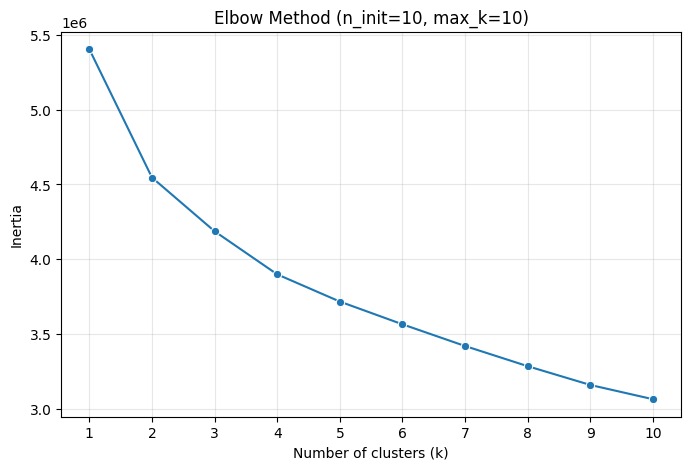

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Ta

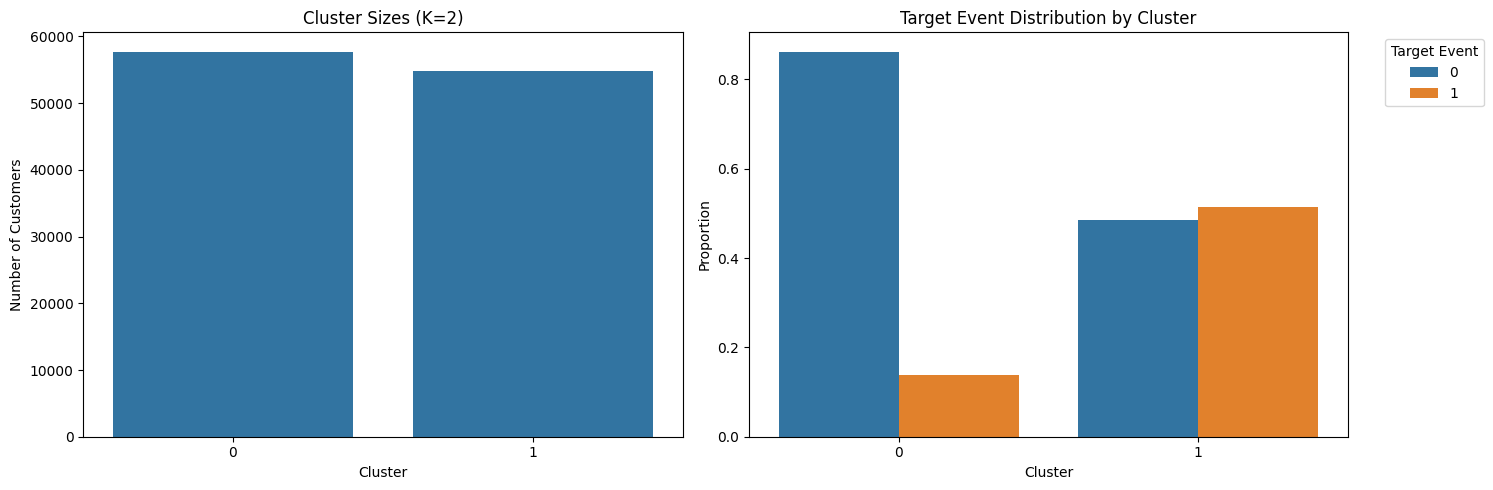

In [4]:
# Configuration parameters for experimentation
EXPERIMENT_CONFIG = {
    'correlation_thresholds': [(0.1, -0.1), (0.2, -0.2), (0.3, -0.3)],
    'n_init_values': [10, 'auto'],
    'max_k_values': [8, 10, 12, 15],
    'manual_k_values': [3, 4, 5, 6, 7]  # For testing specific k values
}

# Calculate correlation with target variable
def calculate_correlation(df, df_target_column, threshold=(0.1, -0.1)):
    correlations = df.corrwith(df_target_column).dropna()  # Handle NaN correlations
    
    # Filter features based on the threshold
    reduced_features = correlations[(correlations > threshold[0]) | (correlations < threshold[1])].index.tolist()
    df_reduced = df[reduced_features]
    print(f"Threshold {threshold}: {len(df_reduced.columns)} features selected")
    
    return correlations, df_reduced, reduced_features

# Enhanced elbow method with configurable parameters
def elbow_method(X, n_init=10, max_k=10, plot=True):
    print(f"Finding optimal clusters: n_init={n_init}, max_k={max_k}")
    inertia = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=n_init)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    if plot:
        plt.figure(figsize=(8, 5))
        sns.lineplot(x=k_range, y=inertia, marker='o')
        plt.title(f'Elbow Method (n_init={n_init}, max_k={max_k})')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range)
        plt.grid(True, alpha=0.3)
        plt.show()

    return k_range, inertia

def calculate_elbow_point(inertias):
    """Calculate elbow point using second derivative method"""
    inertia_array = np.array(inertias)
    diff = np.diff(inertia_array)
    diff_2 = np.diff(diff)

    print("Rate of change analysis:")
    for i, (d1, d2) in enumerate(zip(diff, diff_2), start=2):
        print(f"K={i}, First diff={d1:.2f}, Second diff={d2:.2f}")

    elbow_idx = np.argmax(diff_2) + 2
    return elbow_idx

def enhanced_cluster_analysis(df_original, df_clustered, target_column='target_event'):
    """
    Comprehensive cluster analysis with business metrics
    """
    print("=== ENHANCED CLUSTER ANALYSIS ===\n")
    
    # Merge original data with cluster labels for full analysis
    df_full_analysis = df_original.copy()
    df_full_analysis['cluster'] = df_clustered['cluster']
    
    # Cluster size analysis
    cluster_sizes = df_clustered['cluster'].value_counts().sort_index()
    print("Cluster Sizes:")
    for cluster, size in cluster_sizes.items():
        percentage = (size / len(df_clustered)) * 100
        print(f"  Cluster {cluster}: {size} customers ({percentage:.2f}%)")
    
    print("\n" + "="*60)
    
    # Business metrics analysis
    metrics_to_analyze = [
        ('target_actual_profit', 'Avg Revenue'),
        ('transaction_count', 'Avg Transactions'), 
        ('interaction_count', 'Avg Interactions'),
        ('session_count', 'Avg Sessions'),
        ('recency', 'Avg Recency'),
        ('category_diversity', 'Avg Category Diversity')
    ]
    
    # Find available metrics in the dataset
    available_metrics = []
    for metric_col, metric_name in metrics_to_analyze:
        if metric_col in df_full_analysis.columns:
            available_metrics.append((metric_col, metric_name))
        else:
            # Try to find similar column names
            similar_cols = [col for col in df_full_analysis.columns if metric_col.replace('_', '').lower() in col.replace('_', '').lower()]
            if similar_cols:
                print(f"Note: Using '{similar_cols[0]}' for {metric_name}")
                available_metrics.append((similar_cols[0], metric_name))
    
    print(f"Business Metrics Analysis ({len(available_metrics)} metrics found):")
    
    # Calculate metrics by cluster
    cluster_metrics = {}
    for cluster in sorted(df_full_analysis['cluster'].unique()):
        cluster_data = df_full_analysis[df_full_analysis['cluster'] == cluster]
        cluster_metrics[cluster] = {}
        
        for metric_col, metric_name in available_metrics:
            if metric_col in cluster_data.columns:
                avg_value = cluster_data[metric_col].mean()
                cluster_metrics[cluster][metric_name] = avg_value
    
    # Display metrics table
    metrics_df = pd.DataFrame(cluster_metrics).T
    if not metrics_df.empty:
        print("\nCluster Business Metrics:")
        print(metrics_df.round(2))
    
    print("\n" + "="*60)
    
    # Target event distribution analysis
    print("Target Event Distribution by Cluster:")
    cluster_target_distribution = pd.crosstab(df_clustered['cluster'], df_clustered[target_column], normalize='index')
    print(cluster_target_distribution.round(3))
    
    return cluster_sizes, cluster_target_distribution, metrics_df

def run_clustering_experiment(df_original, df_features_filtered, target_variable, 
                            threshold, n_init, max_k, manual_k=None):
    """
    Run a complete clustering experiment with given parameters
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: threshold={threshold}, n_init={n_init}, max_k={max_k}")
    if manual_k:
        print(f"Manual K override: {manual_k}")
    print(f"{'='*80}")
    
    # Step 1: Feature selection
    correlations, df_reduced, reduced_features = calculate_correlation(
        df_features_filtered, df_original[target_variable], threshold=threshold
    )
    
    if len(df_reduced.columns) == 0:
        print("No features selected with current threshold. Skipping experiment.")
        return None
    
    # Step 2: Prepare data
    df_experiment = df_reduced.copy()
    df_experiment[target_variable] = df_original[target_variable]
    
    X = df_experiment.drop(columns=[target_variable]).copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Step 3: Find optimal k or use manual k
    if manual_k:
        optimal_k = manual_k
        print(f"Using manual K = {optimal_k}")
    else:
        k_range, inertias = elbow_method(X_scaled, n_init=n_init, max_k=max_k, plot=True)
        optimal_k = calculate_elbow_point(inertias)
        print(f"Optimal K determined by elbow method: {optimal_k}")
    
    # Step 4: Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=n_init)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    df_clustered = df_reduced.copy()
    df_clustered['cluster'] = cluster_labels
    df_clustered[target_variable] = df_original[target_variable]
    
    # Step 5: Analyze results
    cluster_sizes, cluster_target_dist, metrics_df = enhanced_cluster_analysis(
        df_original, df_clustered, target_variable
    )
    
    # Step 6: Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Cluster sizes
    sns.countplot(data=df_clustered, x='cluster', order=cluster_sizes.index, ax=axes[0])
    axes[0].set_title(f'Cluster Sizes (K={optimal_k})')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Customers')
    
    # Target event distribution
    cluster_target_melted = cluster_target_dist.reset_index().melt(id_vars='cluster')
    sns.barplot(data=cluster_target_melted, x='cluster', y='value', 
                hue='target_event', ax=axes[1])
    axes[1].set_title('Target Event Distribution by Cluster')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Proportion')
    axes[1].legend(title='Target Event', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'threshold': threshold,
        'n_init': n_init,
        'max_k': max_k,
        'optimal_k': optimal_k,
        'n_features': len(df_reduced.columns),
        'cluster_sizes': cluster_sizes,
        'target_distribution': cluster_target_dist,
        'business_metrics': metrics_df,
        'df_clustered': df_clustered
    }

# Initialize experiment
target_variable = 'target_event'
print(f"Starting clustering experiments with target variable: {target_variable}")
print(f"Original dataset shape: {df.shape}")
print(f"Filtered features shape: {df_features_filtered.shape}")

# Run single experiment with default parameters
print("\n" + "="*80)
print("RUNNING DEFAULT EXPERIMENT")
print("="*80)

default_result = run_clustering_experiment(
    df_original=df,
    df_features_filtered=df_features_filtered,
    target_variable=target_variable,
    threshold=(0.1, -0.1),
    n_init=10,
    max_k=10
)


RUNNING MULTIPLE PARAMETER EXPERIMENTS

--- Testing Different Correlation Thresholds ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10


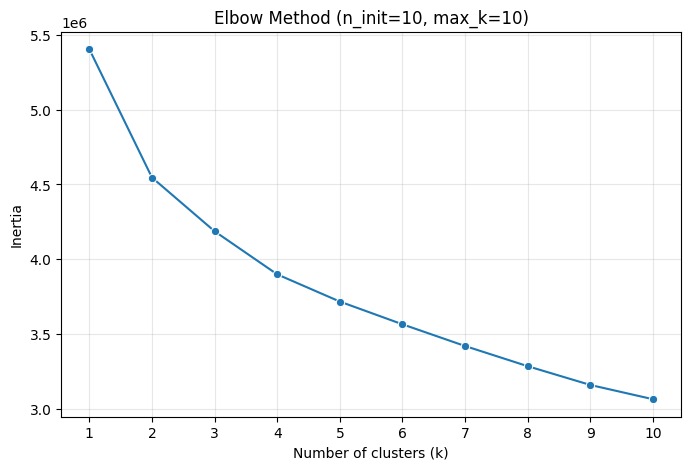

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Ta

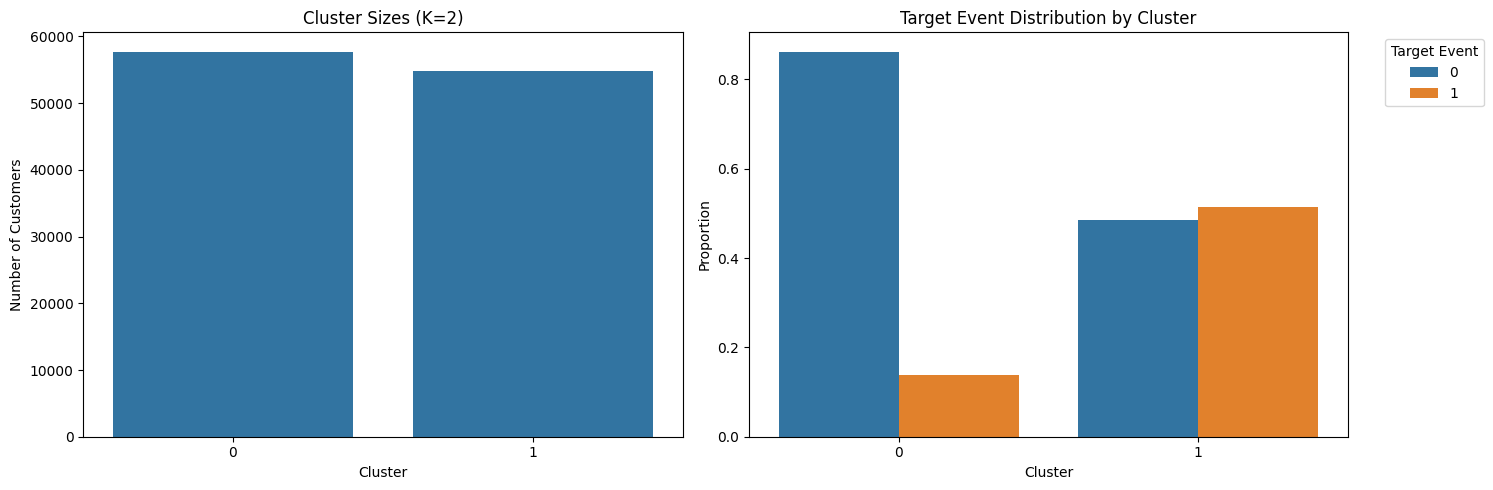


EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Threshold (0.2, -0.2): 18 features selected
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=10
Finding optimal clusters: n_init=10, max_k=10


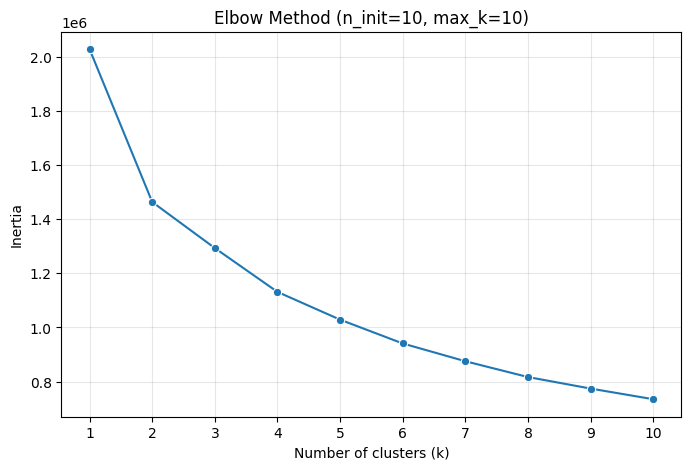

Rate of change analysis:
K=2, First diff=-563999.50, Second diff=393892.56
K=3, First diff=-170106.94, Second diff=8305.05
K=4, First diff=-161801.89, Second diff=59382.64
K=5, First diff=-102419.25, Second diff=14529.28
K=6, First diff=-87889.97, Second diff=22261.12
K=7, First diff=-65628.84, Second diff=7314.64
K=8, First diff=-58314.21, Second diff=15763.57
K=9, First diff=-42550.63, Second diff=3212.08
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 66836 customers (59.35%)
  Cluster 1: 45774 customers (40.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.86              0.54          0.83        27.35
1        -3.36              0.45          0.66        80.08

Target E

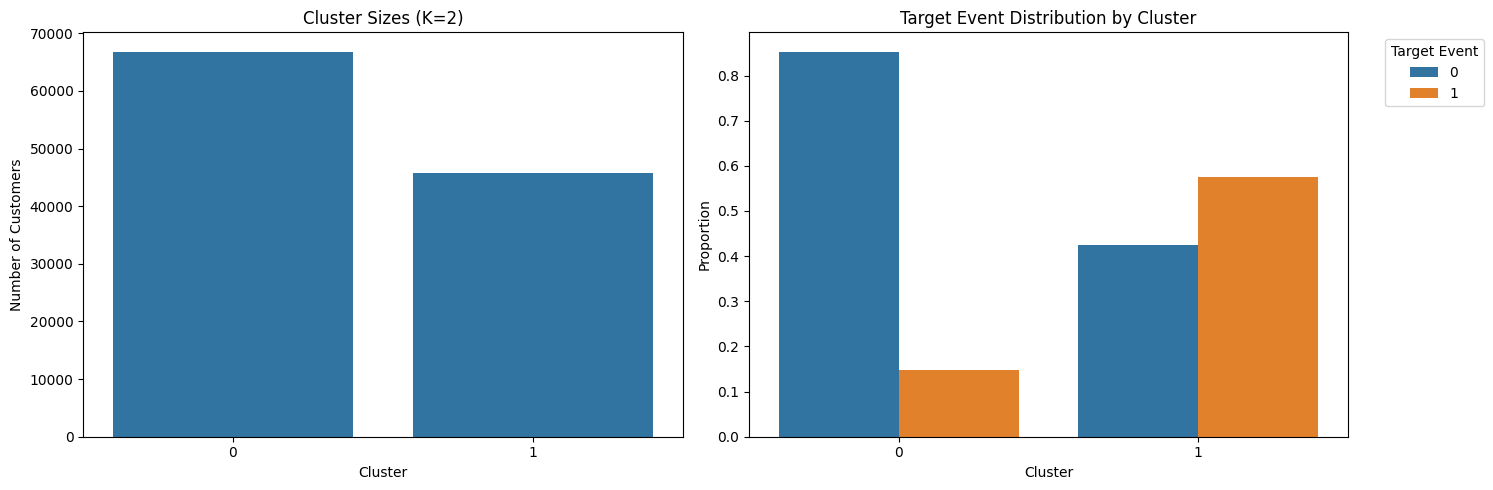


EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=10
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=10


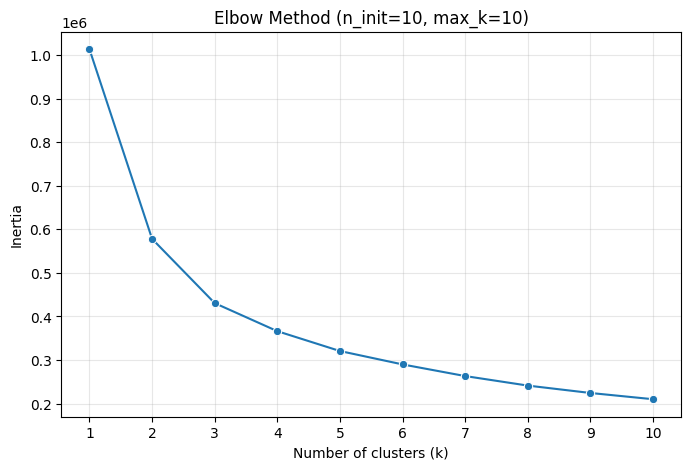

Rate of change analysis:
K=2, First diff=-435470.61, Second diff=287967.43
K=3, First diff=-147503.18, Second diff=83082.74
K=4, First diff=-64420.44, Second diff=18840.92
K=5, First diff=-45579.52, Second diff=14842.66
K=6, First diff=-30736.85, Second diff=3990.46
K=7, First diff=-26746.39, Second diff=4888.00
K=8, First diff=-21858.39, Second diff=4882.23
K=9, First diff=-16976.16, Second diff=2658.90
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70476 customers (62.58%)
  Cluster 1: 42134 customers (37.42%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59          0.87        27.76
1        -3.44              0.36          0.59        83.96

Target Even

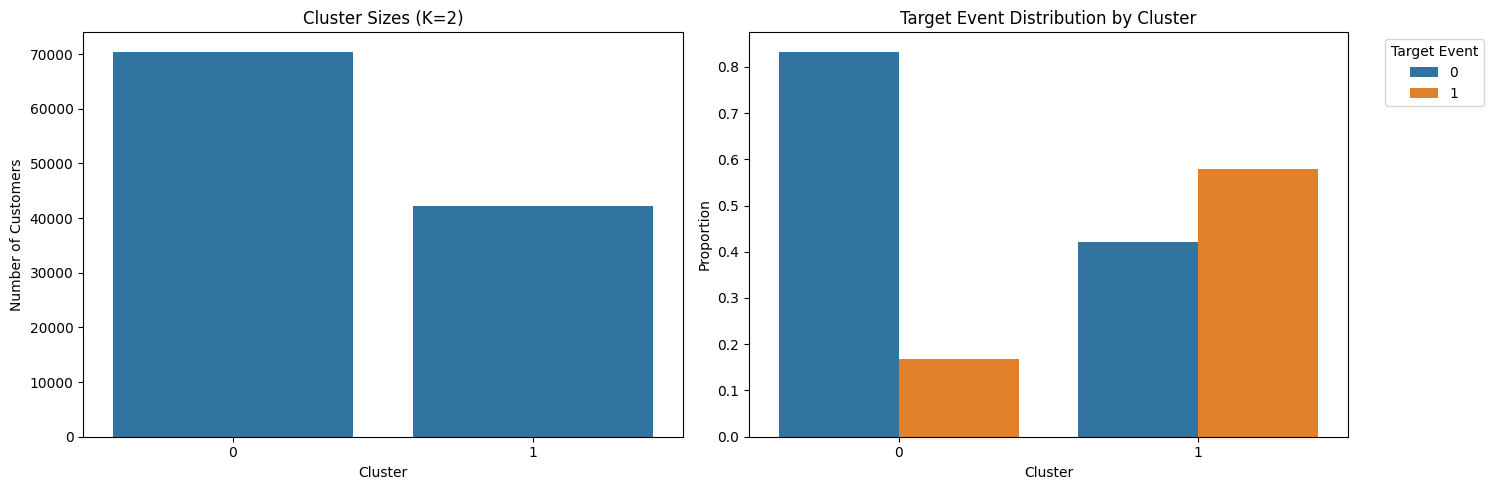


--- Testing Different n_init Values ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10


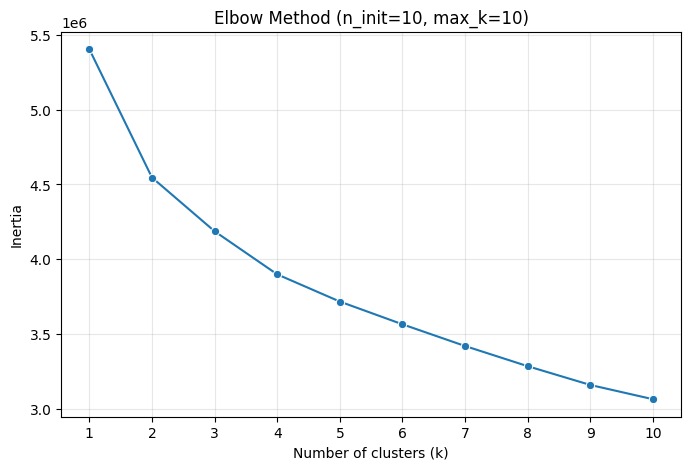

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Ta

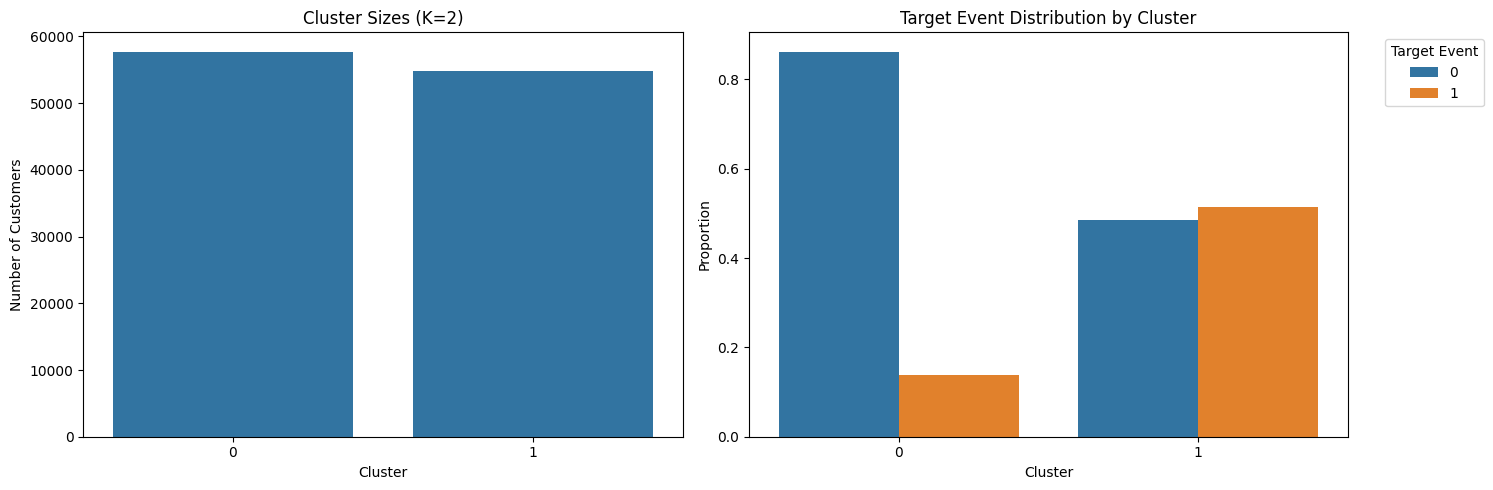


EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=10


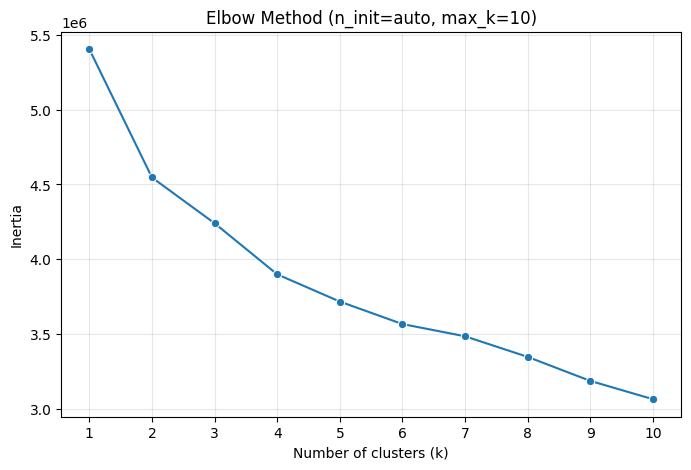

Rate of change analysis:
K=2, First diff=-858591.31, Second diff=552166.84
K=3, First diff=-306424.47, Second diff=-35474.34
K=4, First diff=-341898.80, Second diff=159739.88
K=5, First diff=-182158.92, Second diff=31606.56
K=6, First diff=-150552.36, Second diff=68711.99
K=7, First diff=-81840.37, Second diff=-56108.87
K=8, First diff=-137949.24, Second diff=-22735.30
K=9, First diff=-160684.54, Second diff=38149.96
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57962 customers (51.47%)
  Cluster 1: 54648 customers (48.53%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.04              0.54          0.83        24.74
1        -4.39              0.46          0.69        74.29

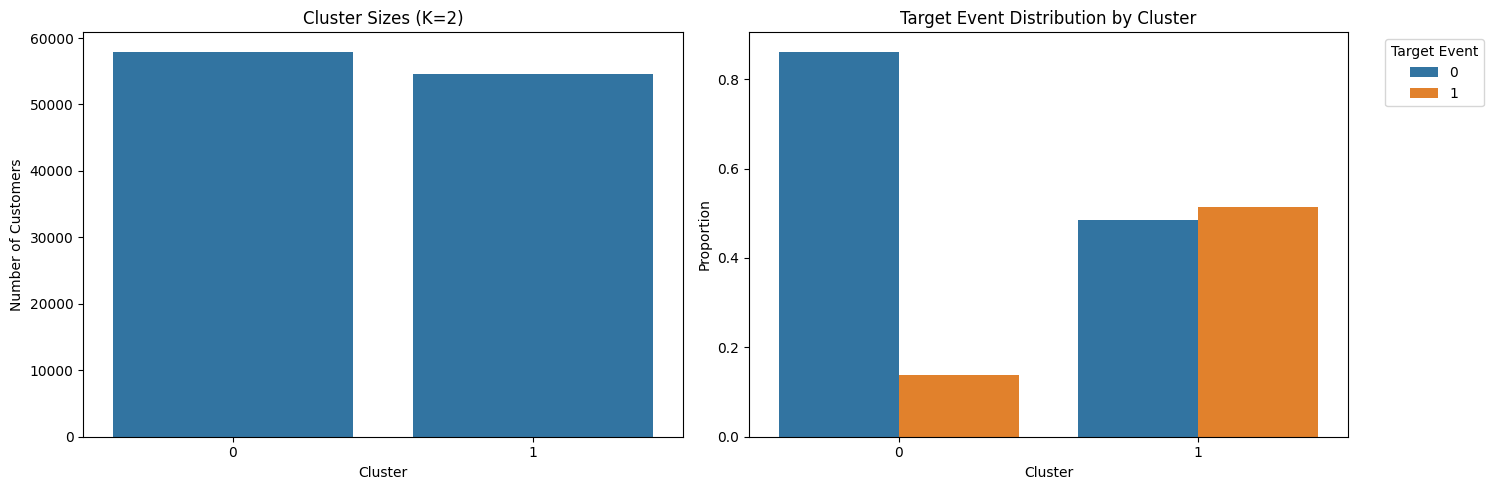


--- Testing Different max_k Values ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=8


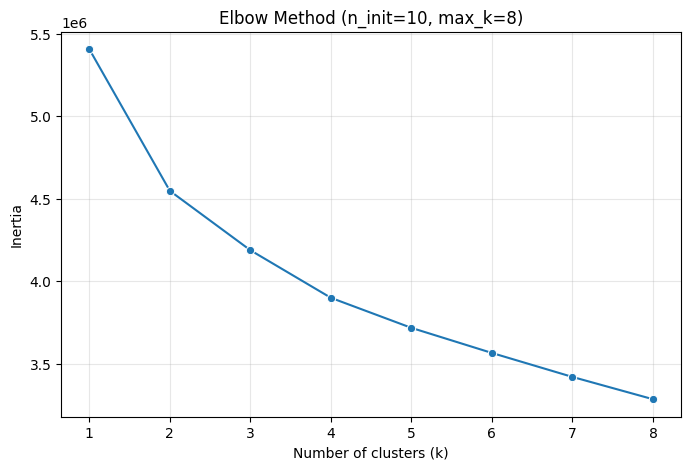

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0      

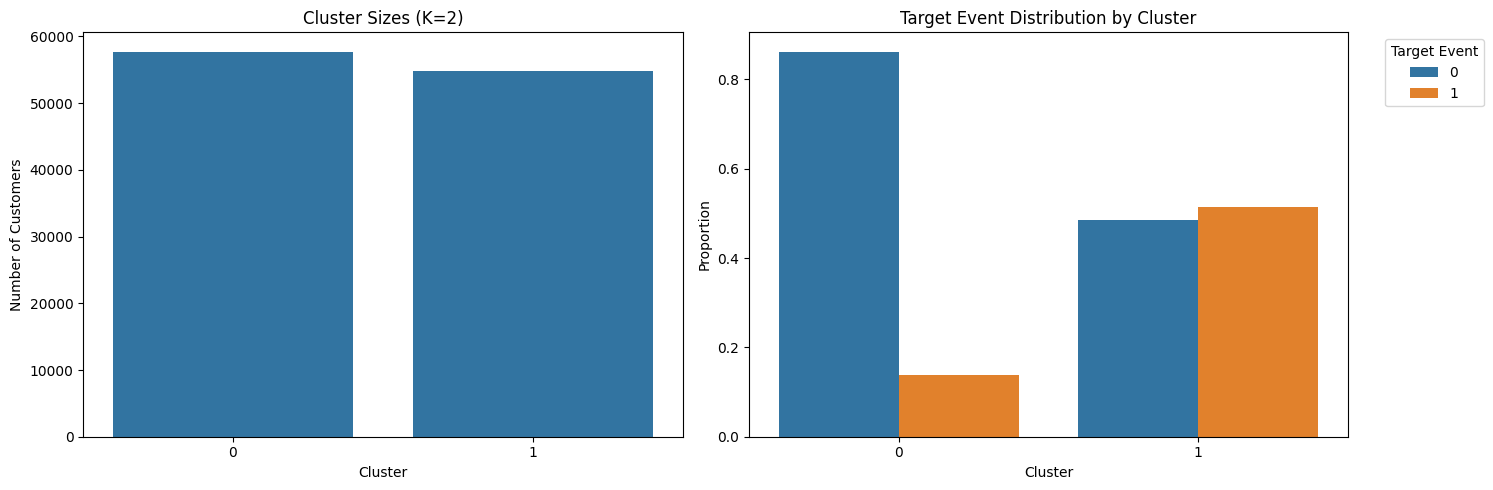


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10


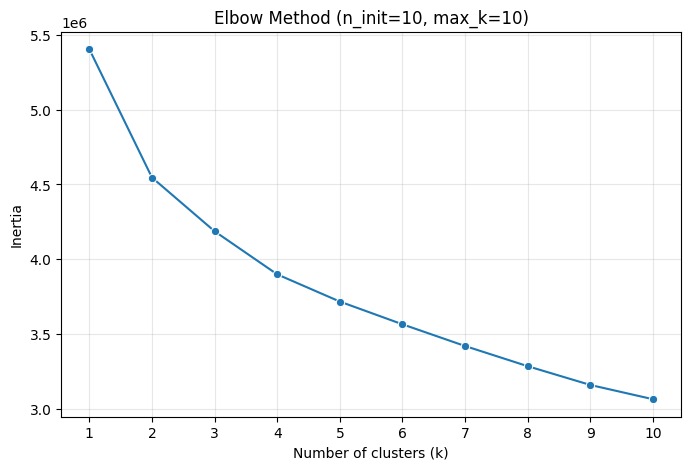

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Ta

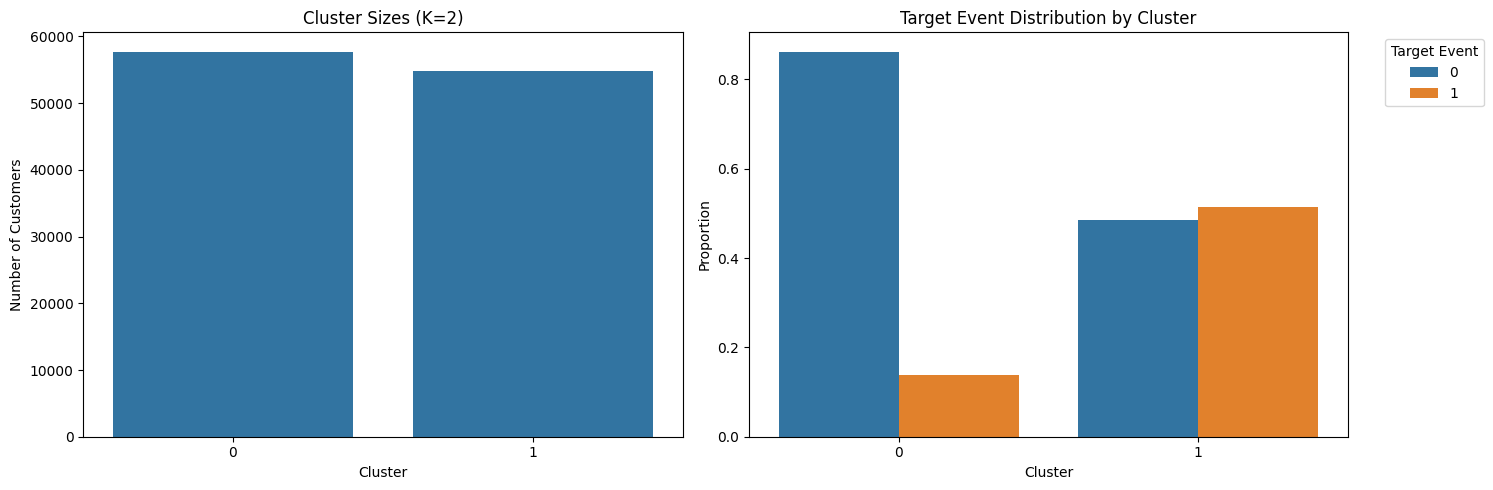


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=12
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=12


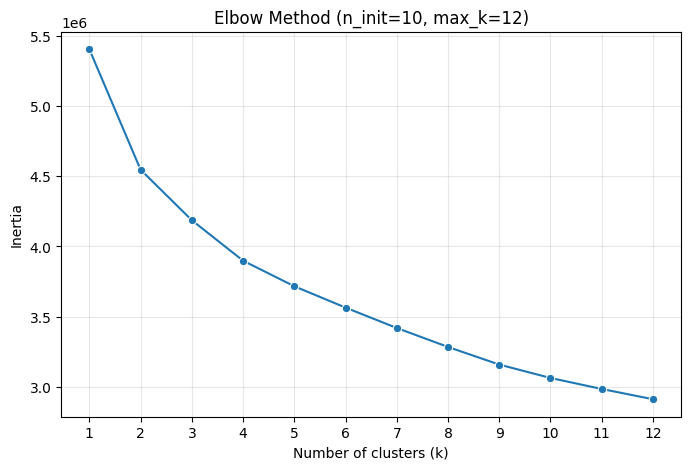

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
K=10, First diff=-95412.01, Second diff=16872.87
K=11, First diff=-78539.14, Second diff=5589.73
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05            

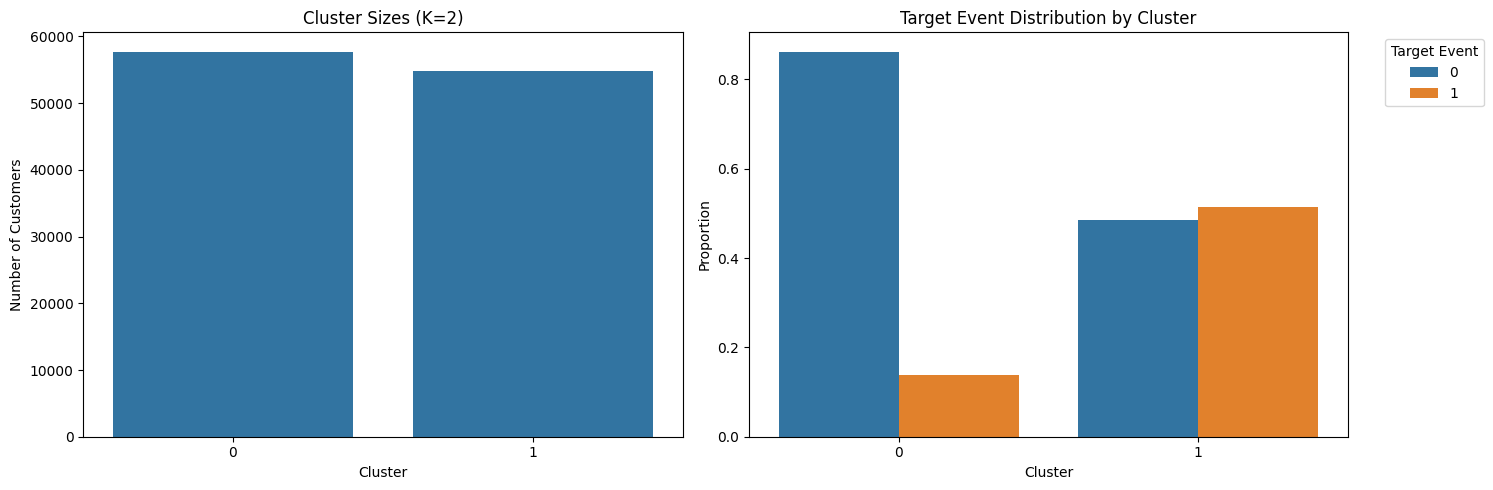


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=15
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=15


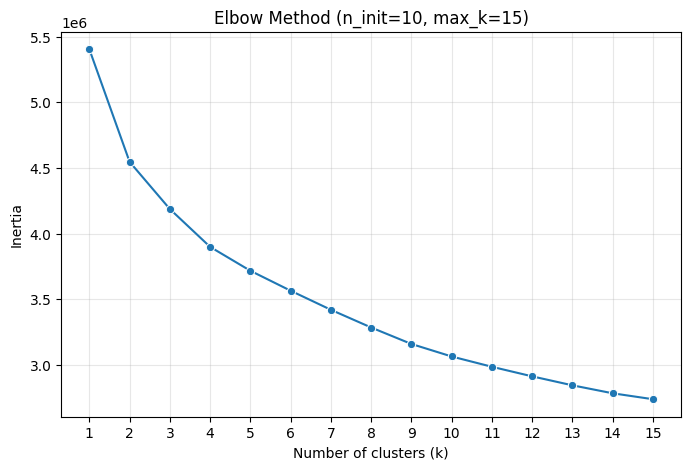

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
K=10, First diff=-95412.01, Second diff=16872.87
K=11, First diff=-78539.14, Second diff=5589.73
K=12, First diff=-72949.41, Second diff=4609.88
K=13, First diff=-68339.53, Second diff=7581.20
K=14, First diff=-60758.33, Second diff=15544.33
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metr

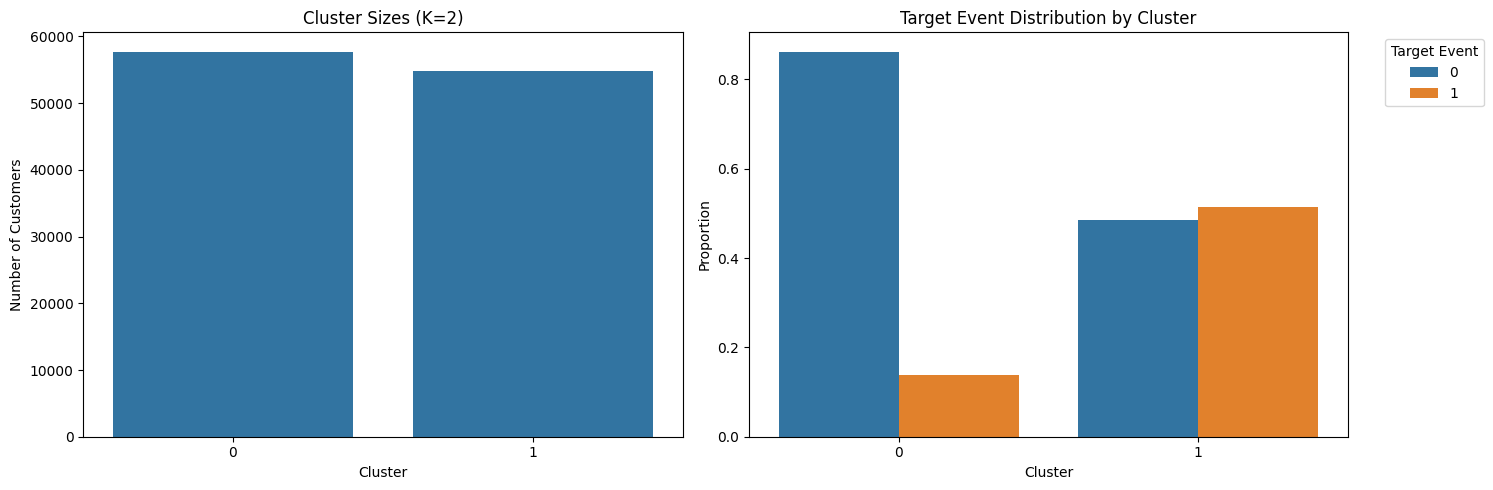


--- Testing Manual K Values ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 54534 customers (48.43%)
  Cluster 1: 4245 customers (3.77%)
  Cluster 2: 53831 customers (47.80%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -4.84              0.35          0.59        73.59
1        -3.54              1.96          2.11        55.34
2       -11.16              0.54          0.83        23.14

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.492  0.508
1             0.681  0.319
2             0.869  0.131
=== ENHANCED CLUS

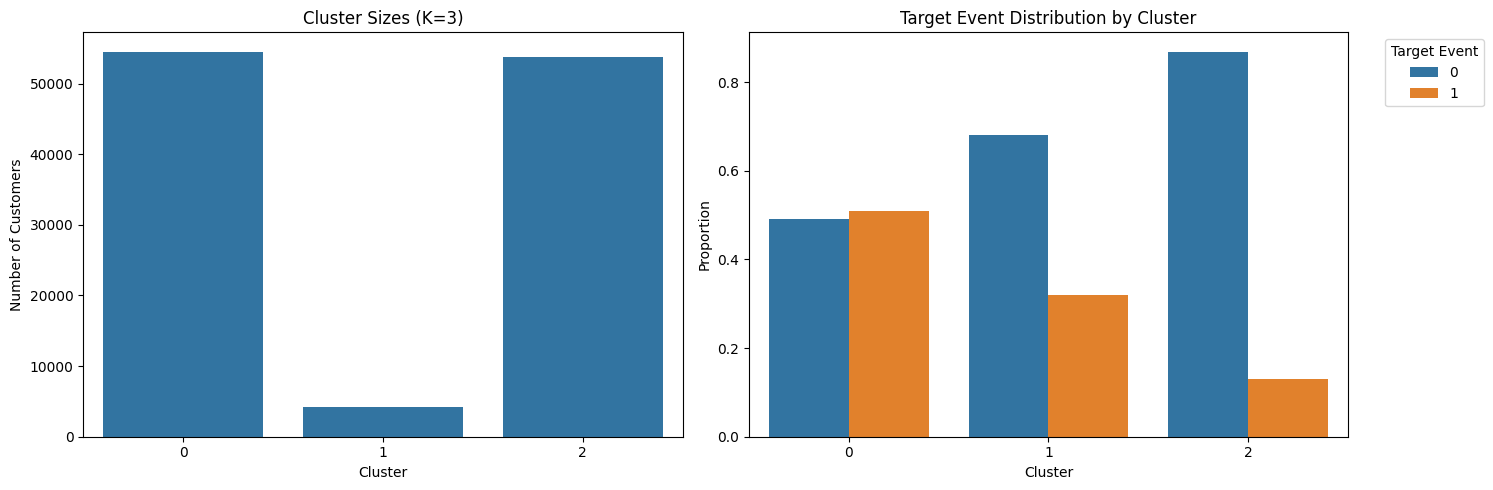


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.59

Target Event Distribution by Cluster:
target_event      0     

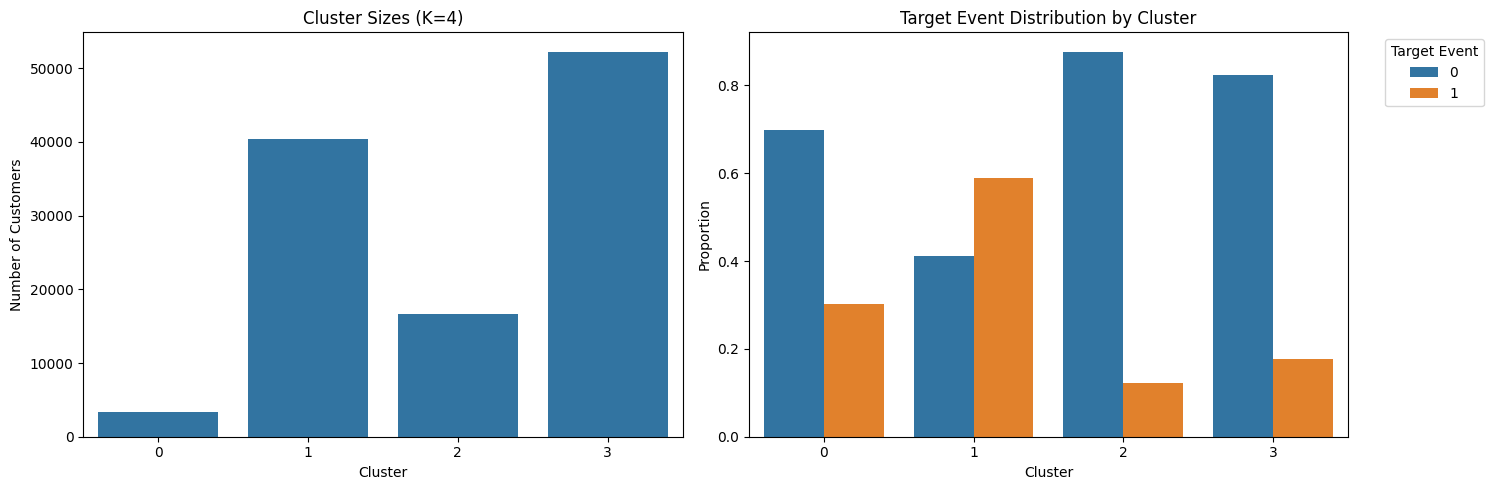


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 14028 customers (12.46%)
  Cluster 1: 11998 customers (10.65%)
  Cluster 2: 47302 customers (42.01%)
  Cluster 3: 36303 customers (32.24%)
  Cluster 4: 2979 customers (2.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.46              0.60          0.86        13.93
1         2.78              0.37          0.47       103.42
2       -10.46              0.52          0.81        29.11
3        -6.82              0.34          0.62        69.35
4        -3.40              2.24          2.38        54.58

Target Event Distribution b

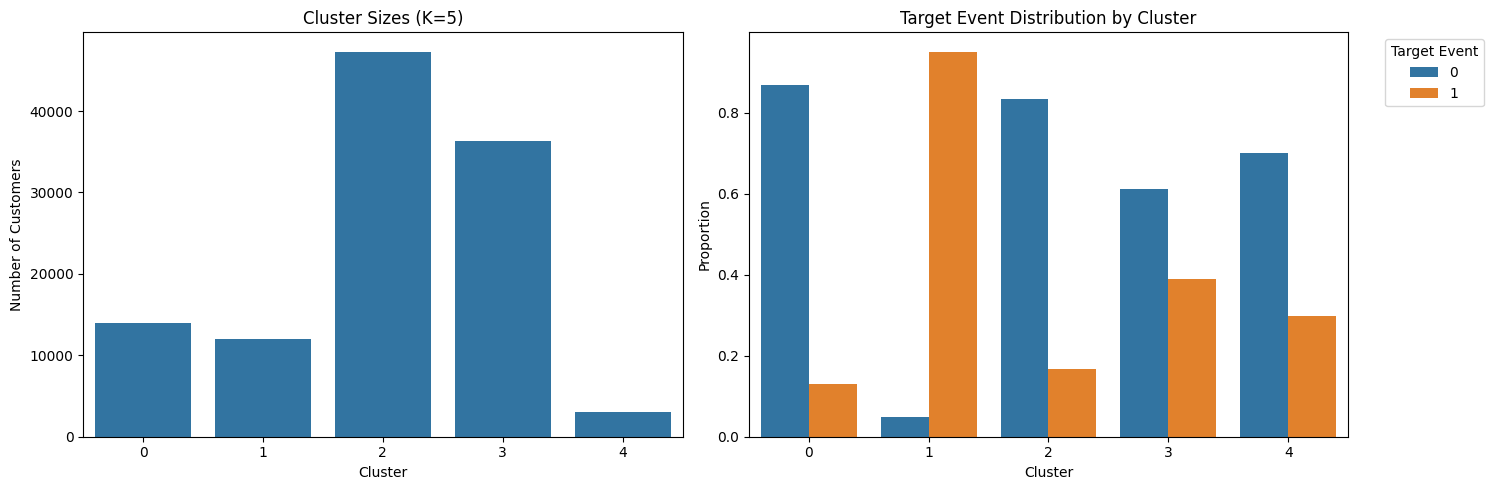


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 13405 customers (11.90%)
  Cluster 1: 11588 customers (10.29%)
  Cluster 2: 322 customers (0.29%)
  Cluster 3: 34994 customers (31.08%)
  Cluster 4: 45683 customers (40.57%)
  Cluster 5: 6618 customers (5.88%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.43              0.61          0.87        13.70
1         2.72              0.36          0.46       104.27
2         0.58              4.52          5.79        57.20
3        -6.96              0.29          0.58        69.67
4       -10.54              0.50          0.79       

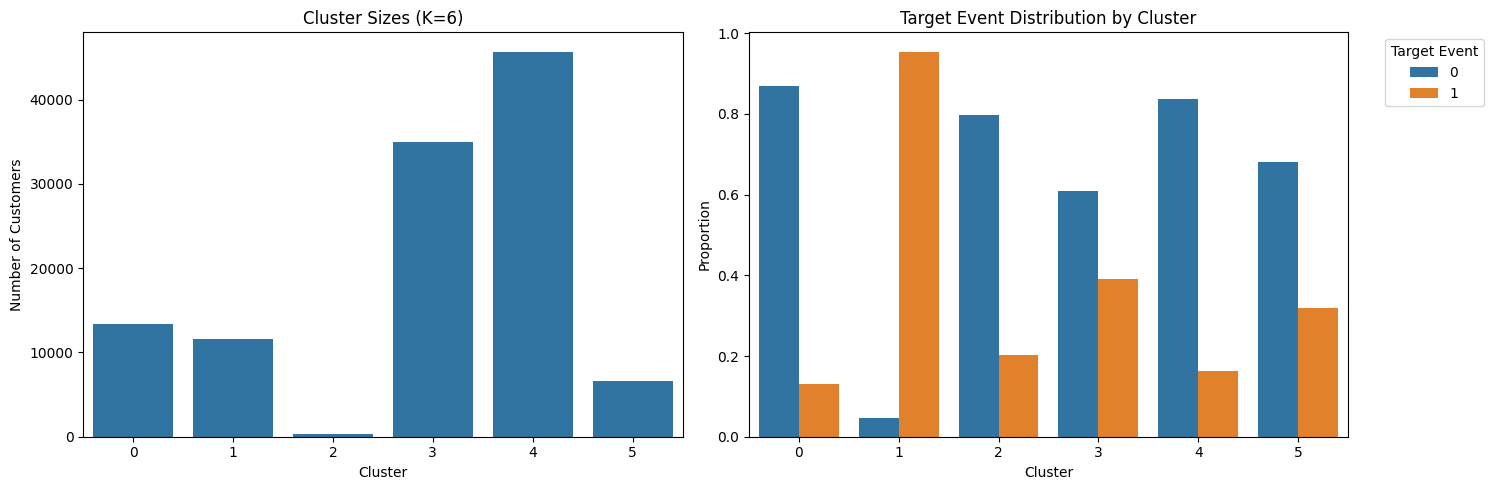


EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 30434 customers (27.03%)
  Cluster 1: 15921 customers (14.14%)
  Cluster 2: 11209 customers (9.95%)
  Cluster 3: 5942 customers (5.28%)
  Cluster 4: 252 customers (0.22%)
  Cluster 5: 42980 customers (38.17%)
  Cluster 6: 5872 customers (5.21%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -6.62              0.28          0.57        73.69
1       -11.89              0.52          0.77        16.44
2         2.76              0.36          0.46       104.34
3       -10.74              0.50          0.88        16.35
4         3.14    

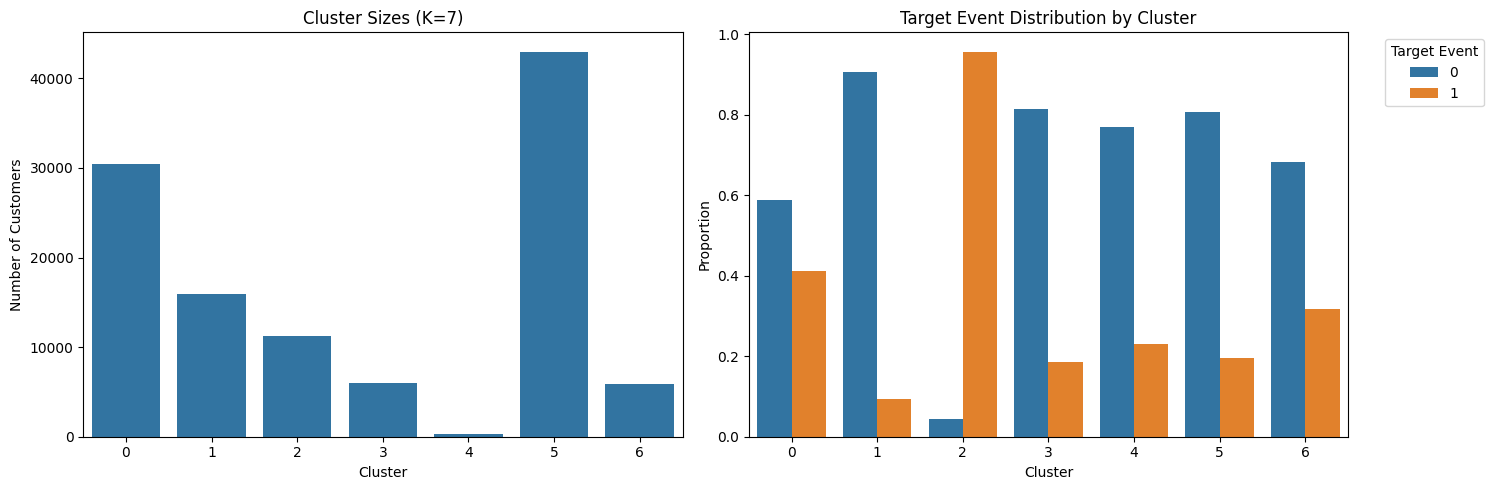

In [5]:
# Multiple experiments with different parameters
def run_parameter_experiments():
    """
    Run multiple experiments with different parameter combinations
    """
    print("\n" + "="*80)
    print("RUNNING MULTIPLE PARAMETER EXPERIMENTS")
    print("="*80)
    
    experiment_results = []
    
    # Experiment 1: Different correlation thresholds
    print("\n--- Testing Different Correlation Thresholds ---")
    for threshold in EXPERIMENT_CONFIG['correlation_thresholds']:
        result = run_clustering_experiment(
            df_original=df,
            df_features_filtered=df_features_filtered,
            target_variable=target_variable,
            threshold=threshold,
            n_init=10,
            max_k=10
        )
        if result:
            experiment_results.append(result)
    
    # Experiment 2: Different n_init values
    print("\n--- Testing Different n_init Values ---")
    for n_init in EXPERIMENT_CONFIG['n_init_values']:
        result = run_clustering_experiment(
            df_original=df,
            df_features_filtered=df_features_filtered,
            target_variable=target_variable,
            threshold=(0.1, -0.1),
            n_init=n_init,
            max_k=10
        )
        if result:
            experiment_results.append(result)
    
    # Experiment 3: Different max_k values
    print("\n--- Testing Different max_k Values ---")
    for max_k in EXPERIMENT_CONFIG['max_k_values']:
        result = run_clustering_experiment(
            df_original=df,
            df_features_filtered=df_features_filtered,
            target_variable=target_variable,
            threshold=(0.1, -0.1),
            n_init=10,
            max_k=max_k
        )
        if result:
            experiment_results.append(result)
    
    # Experiment 4: Manual K values
    print("\n--- Testing Manual K Values ---")
    for manual_k in EXPERIMENT_CONFIG['manual_k_values']:
        result = run_clustering_experiment(
            df_original=df,
            df_features_filtered=df_features_filtered,
            target_variable=target_variable,
            threshold=(0.1, -0.1),
            n_init=10,
            max_k=10,
            manual_k=manual_k
        )
        if result:
            experiment_results.append(result)
    
    return experiment_results

# Run comprehensive experiments
experiment_results = run_parameter_experiments()

Starting comprehensive grid search...

RUNNING GRID SEARCH EXPERIMENTS
Total parameter combinations to test: 144
Estimated runtime: ~72.0 minutes

--- Grid Search Experiment 1/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=8
Finding optimal clusters: n_init=10, max_k=8


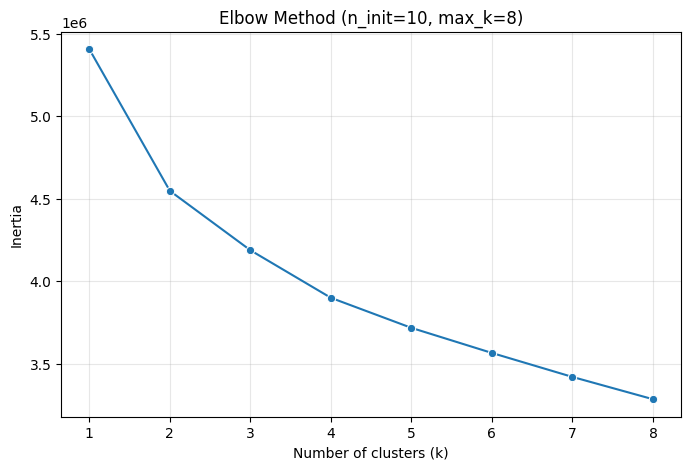

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0      

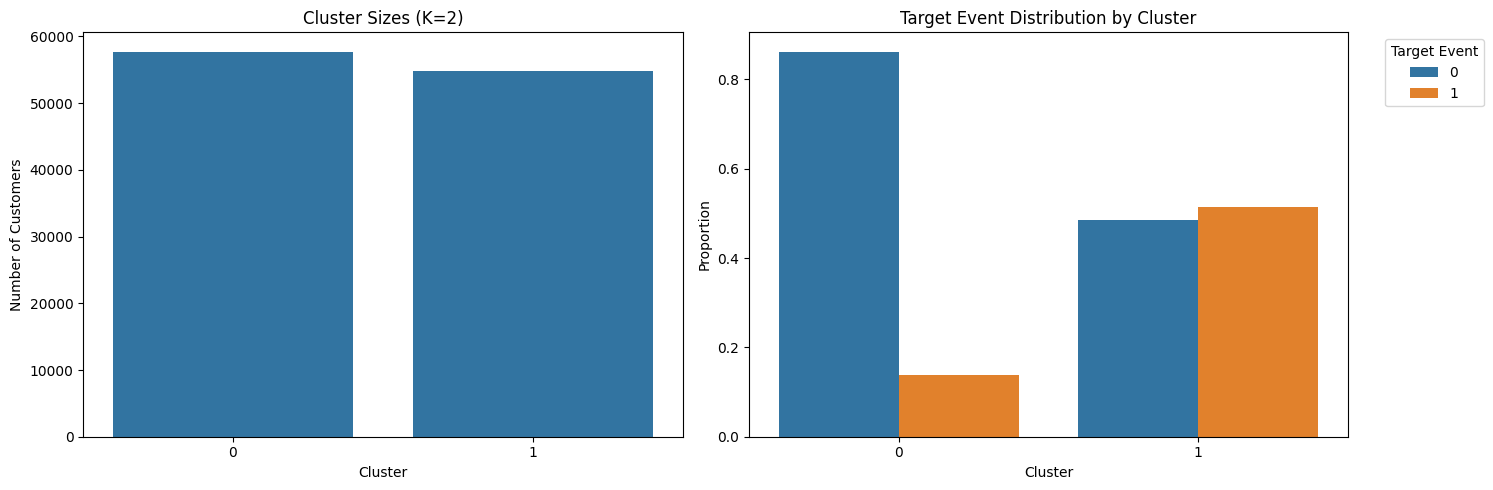

✓ Success: K=2, Features=48

--- Grid Search Experiment 2/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 54534 customers (48.43%)
  Cluster 1: 4245 customers (3.77%)
  Cluster 2: 53831 customers (47.80%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -4.84              0.35          0.59        73.59
1        -3.54              1.96          2.11        55.34
2       -11.16              0.54          0.83        23.14

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0  

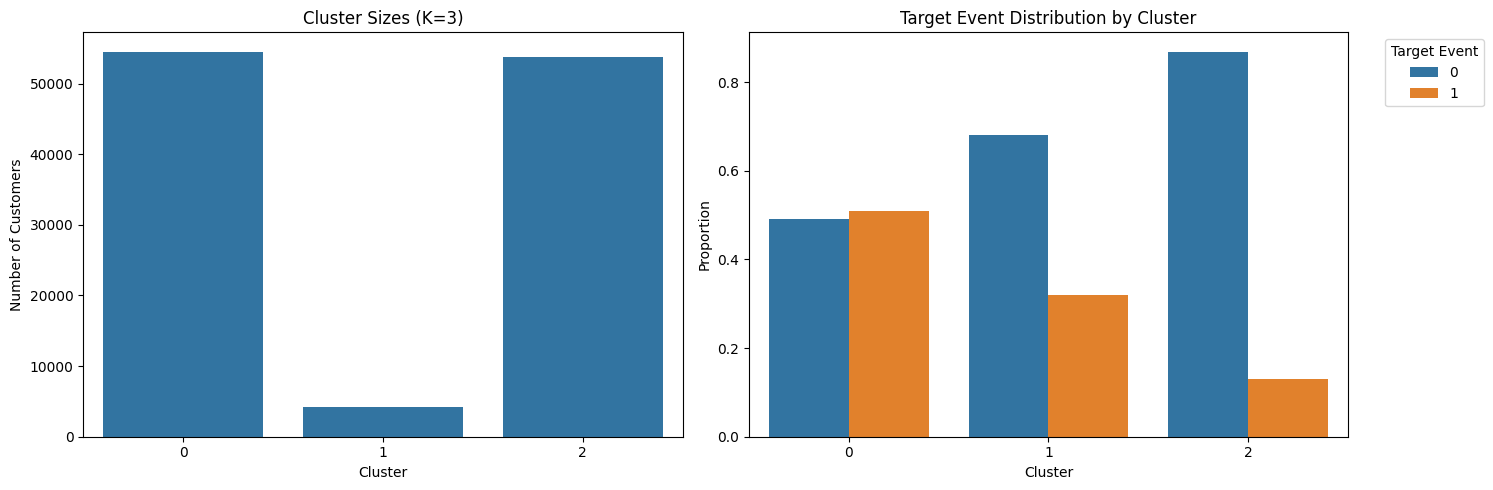

✓ Success: K=3, Features=48

--- Grid Search Experiment 3/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.5

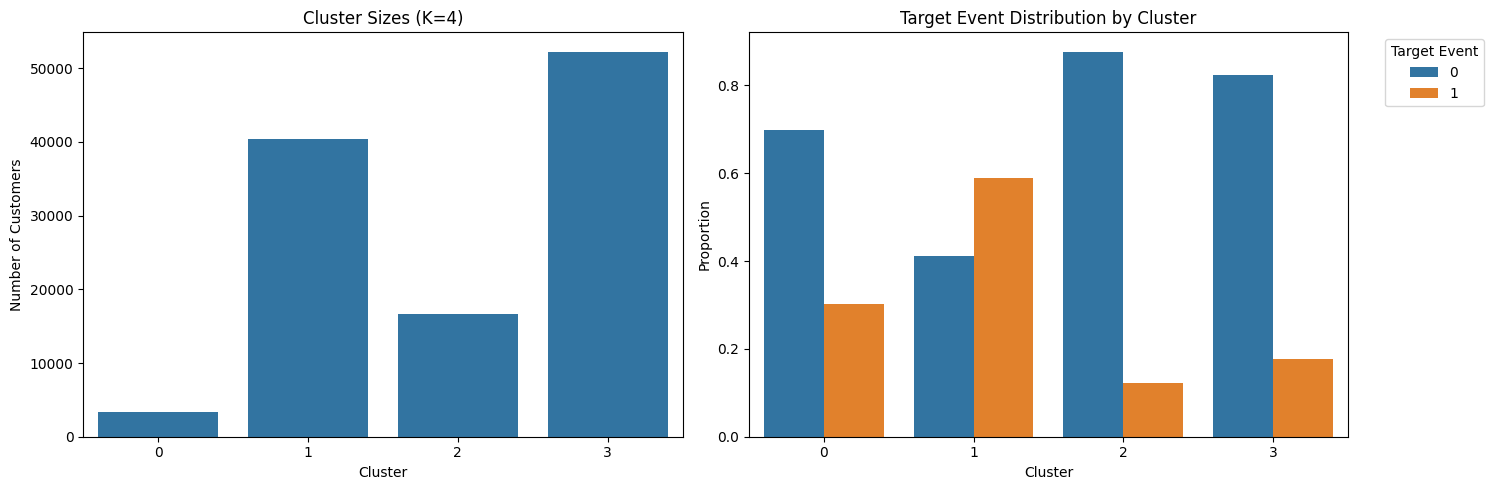

✓ Success: K=4, Features=48

--- Grid Search Experiment 4/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 14028 customers (12.46%)
  Cluster 1: 11998 customers (10.65%)
  Cluster 2: 47302 customers (42.01%)
  Cluster 3: 36303 customers (32.24%)
  Cluster 4: 2979 customers (2.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.46              0.60          0.86        13.93
1         2.78              0.37          0.47       103.42
2       -10.46              0.52          0.81        29.11
3        -6.82              0.34          0.62        69.35
4        -3.40         

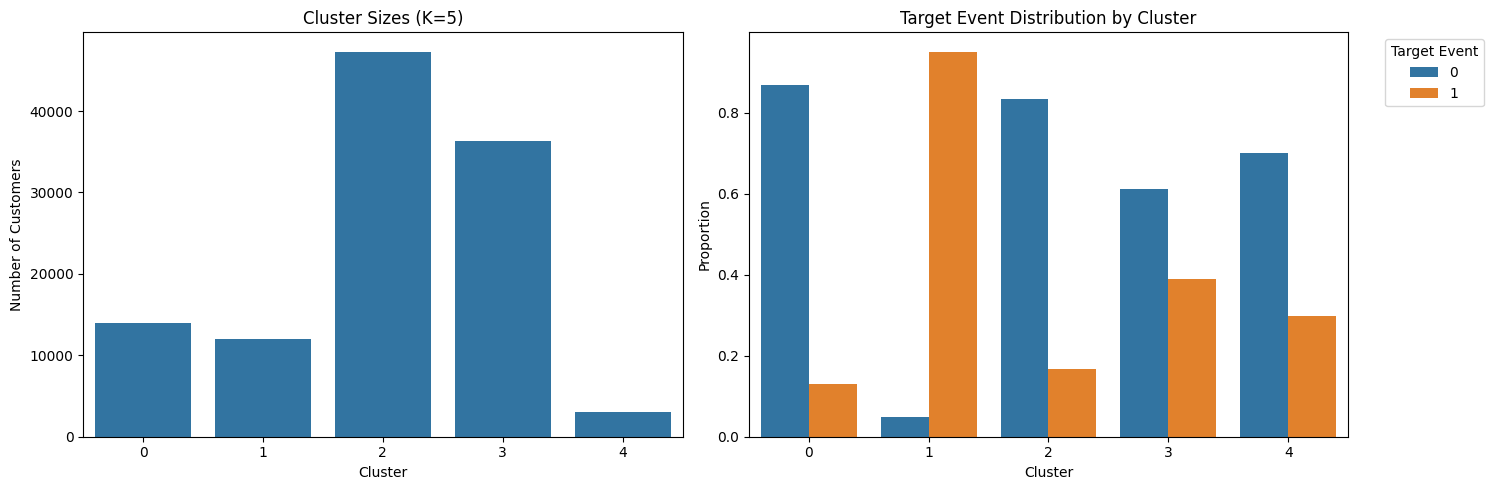

✓ Success: K=5, Features=48

--- Grid Search Experiment 5/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 13405 customers (11.90%)
  Cluster 1: 11588 customers (10.29%)
  Cluster 2: 322 customers (0.29%)
  Cluster 3: 34994 customers (31.08%)
  Cluster 4: 45683 customers (40.57%)
  Cluster 5: 6618 customers (5.88%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.43              0.61          0.87        13.70
1         2.72              0.36          0.46       104.27
2         0.58              4.52          5.79        57.20
3        -6.96              0.29          0.58  

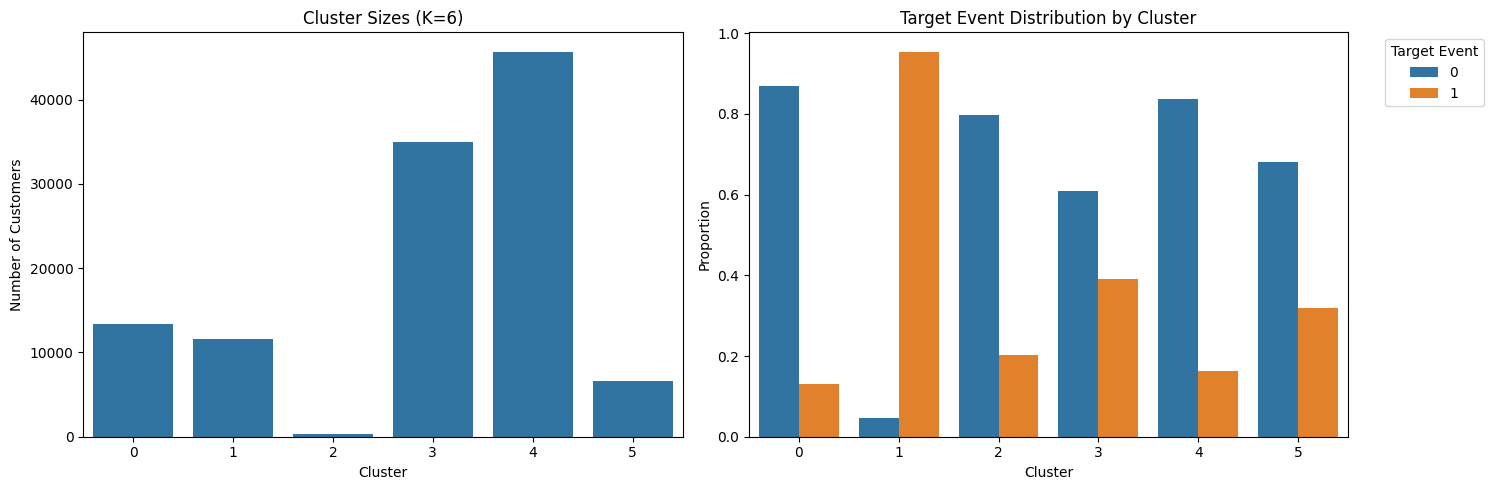

✓ Success: K=6, Features=48

--- Grid Search Experiment 6/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=8
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 30434 customers (27.03%)
  Cluster 1: 15921 customers (14.14%)
  Cluster 2: 11209 customers (9.95%)
  Cluster 3: 5942 customers (5.28%)
  Cluster 4: 252 customers (0.22%)
  Cluster 5: 42980 customers (38.17%)
  Cluster 6: 5872 customers (5.21%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -6.62              0.28          0.57        73.69
1       -11.89              0.52          0.77        16.44
2         2.76              0.36          0.46       104.34
3       -10.7

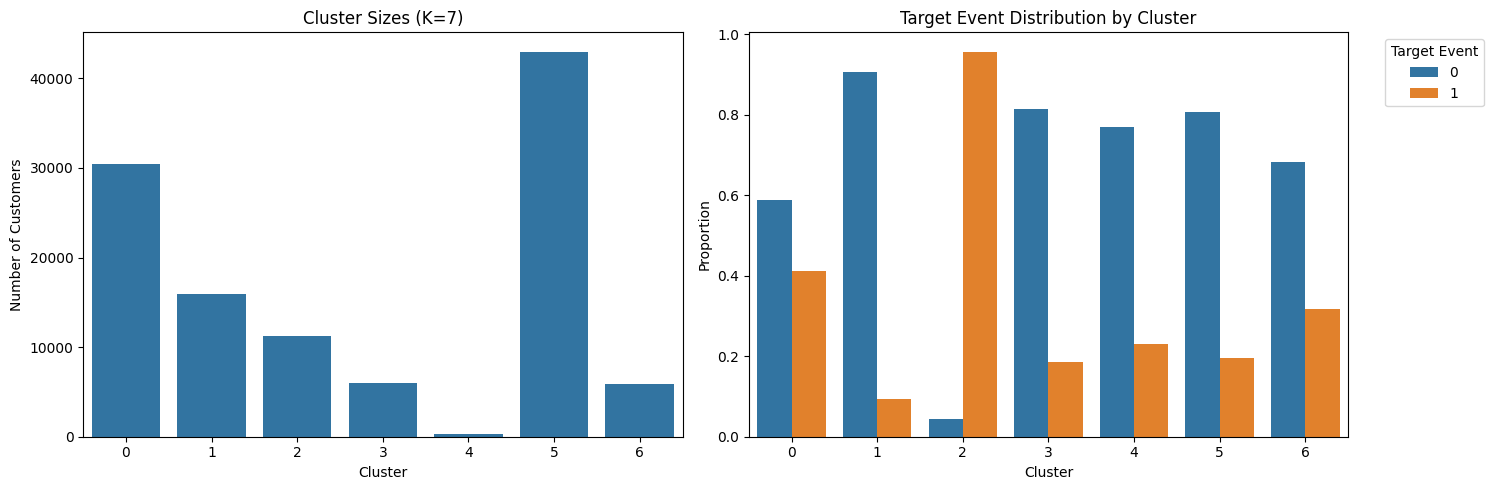

✓ Success: K=7, Features=48

--- Grid Search Experiment 7/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=10
Finding optimal clusters: n_init=10, max_k=10


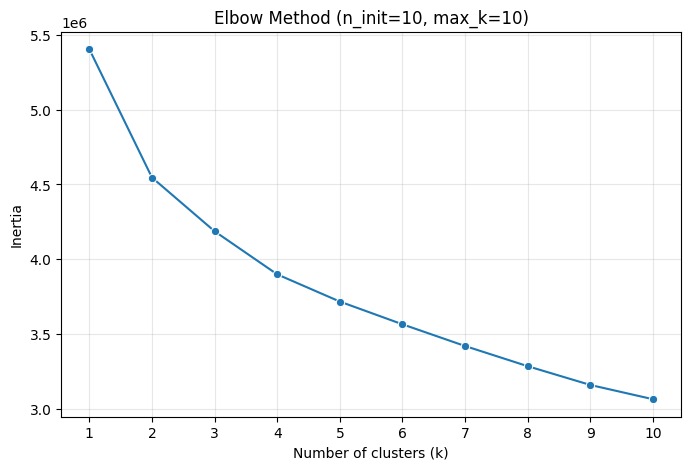

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05              0.54          0.83        24.66
1        -4.41              0.46          0.69        74.17

Ta

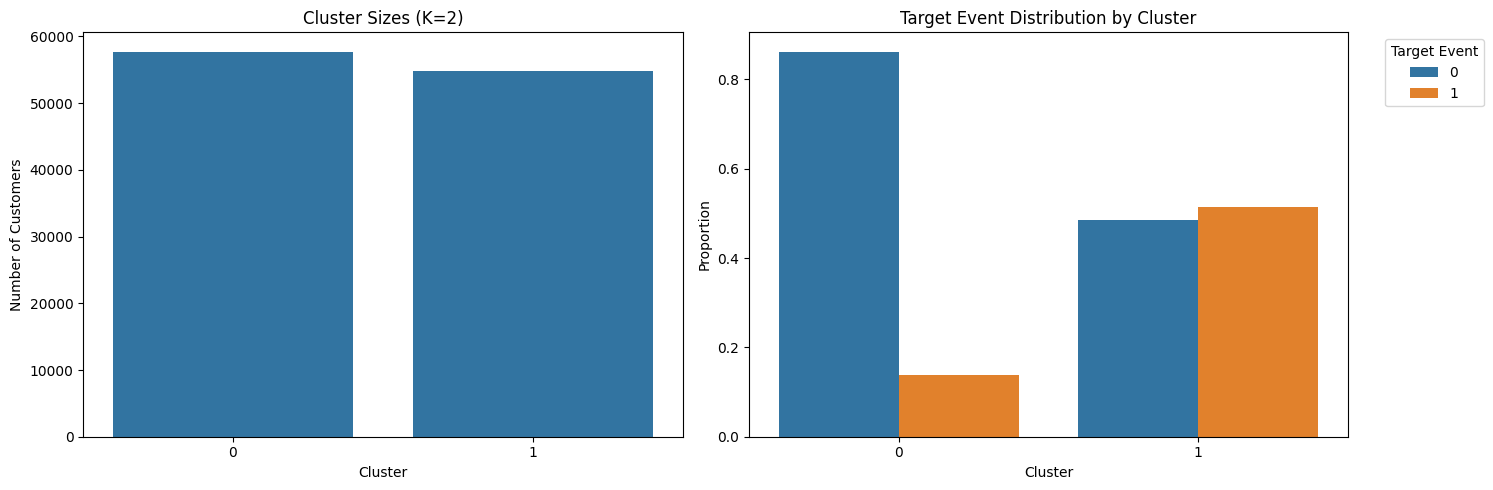

✓ Success: K=2, Features=48

--- Grid Search Experiment 8/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 54534 customers (48.43%)
  Cluster 1: 4245 customers (3.77%)
  Cluster 2: 53831 customers (47.80%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -4.84              0.35          0.59        73.59
1        -3.54              1.96          2.11        55.34
2       -11.16              0.54          0.83        23.14

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0 

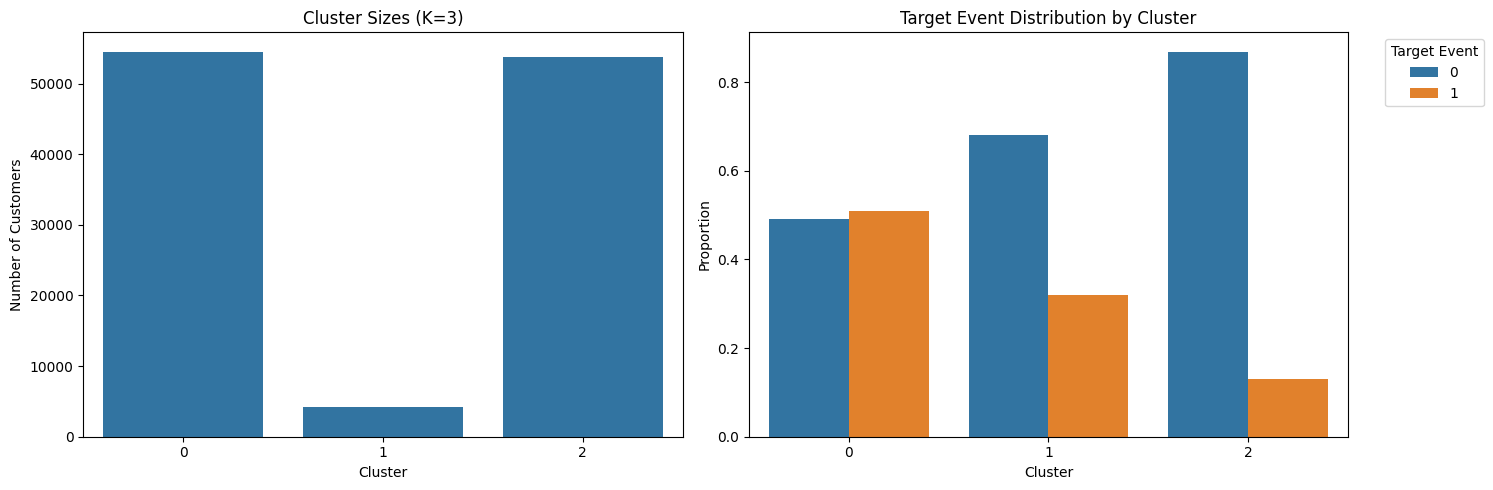

✓ Success: K=3, Features=48

--- Grid Search Experiment 9/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.

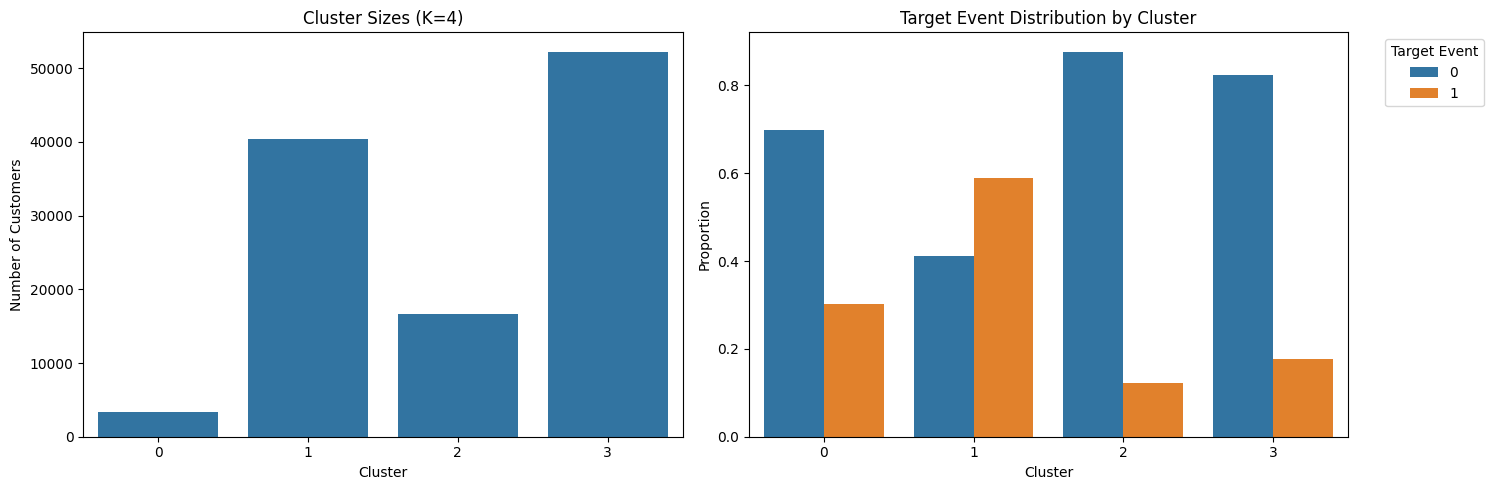

✓ Success: K=4, Features=48

--- Grid Search Experiment 10/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 14028 customers (12.46%)
  Cluster 1: 11998 customers (10.65%)
  Cluster 2: 47302 customers (42.01%)
  Cluster 3: 36303 customers (32.24%)
  Cluster 4: 2979 customers (2.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.46              0.60          0.86        13.93
1         2.78              0.37          0.47       103.42
2       -10.46              0.52          0.81        29.11
3        -6.82    

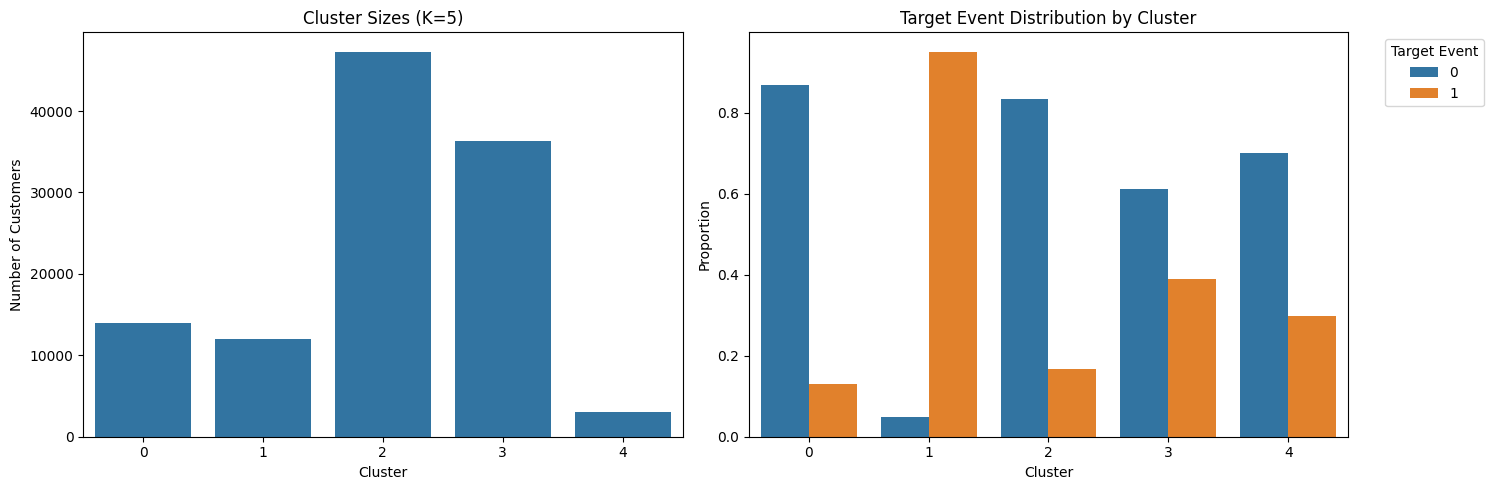

✓ Success: K=5, Features=48

--- Grid Search Experiment 11/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 13405 customers (11.90%)
  Cluster 1: 11588 customers (10.29%)
  Cluster 2: 322 customers (0.29%)
  Cluster 3: 34994 customers (31.08%)
  Cluster 4: 45683 customers (40.57%)
  Cluster 5: 6618 customers (5.88%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.43              0.61          0.87        13.70
1         2.72              0.36          0.46       104.27
2         0.58              4.52          5.79        57.20
3        -6.96             

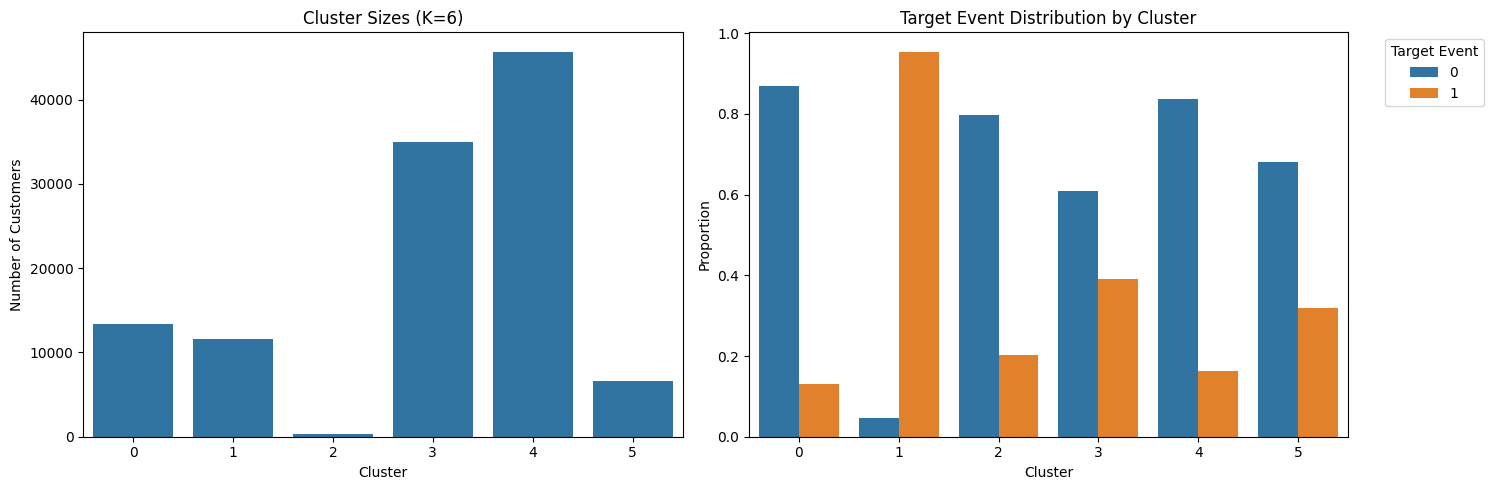

✓ Success: K=6, Features=48

--- Grid Search Experiment 12/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=10
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 30434 customers (27.03%)
  Cluster 1: 15921 customers (14.14%)
  Cluster 2: 11209 customers (9.95%)
  Cluster 3: 5942 customers (5.28%)
  Cluster 4: 252 customers (0.22%)
  Cluster 5: 42980 customers (38.17%)
  Cluster 6: 5872 customers (5.21%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -6.62              0.28          0.57        73.69
1       -11.89              0.52          0.77        16.44
2       

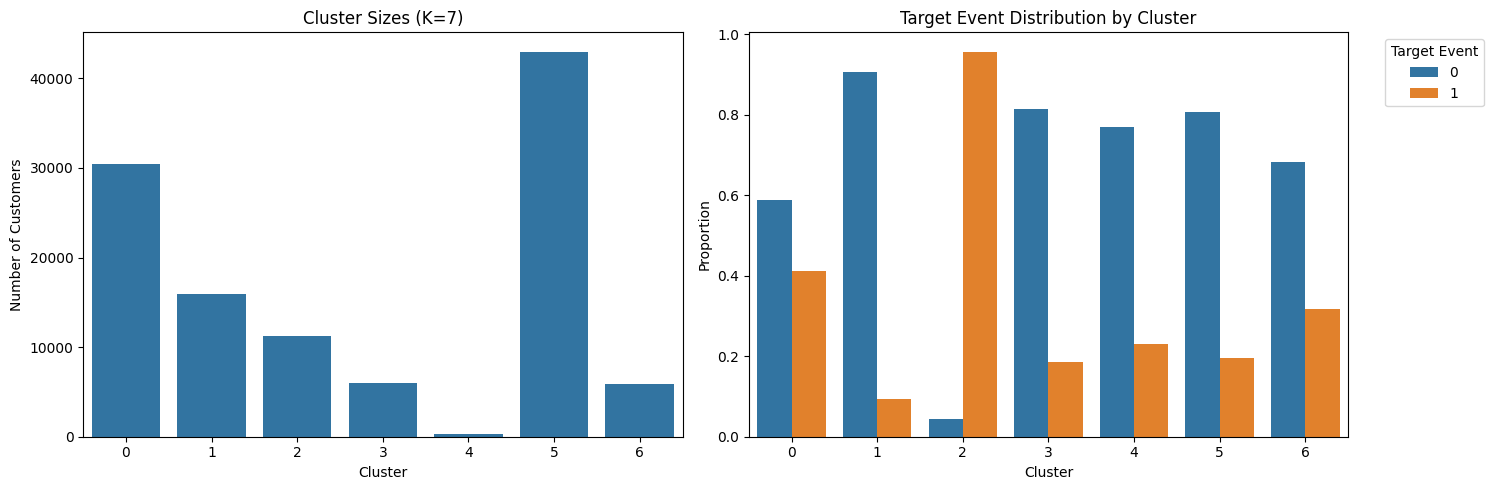

✓ Success: K=7, Features=48

--- Grid Search Experiment 13/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=12
Finding optimal clusters: n_init=10, max_k=12


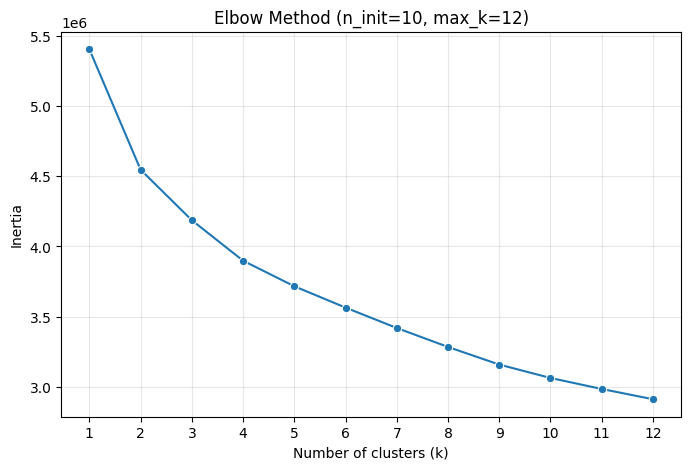

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
K=10, First diff=-95412.01, Second diff=16872.87
K=11, First diff=-78539.14, Second diff=5589.73
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.05            

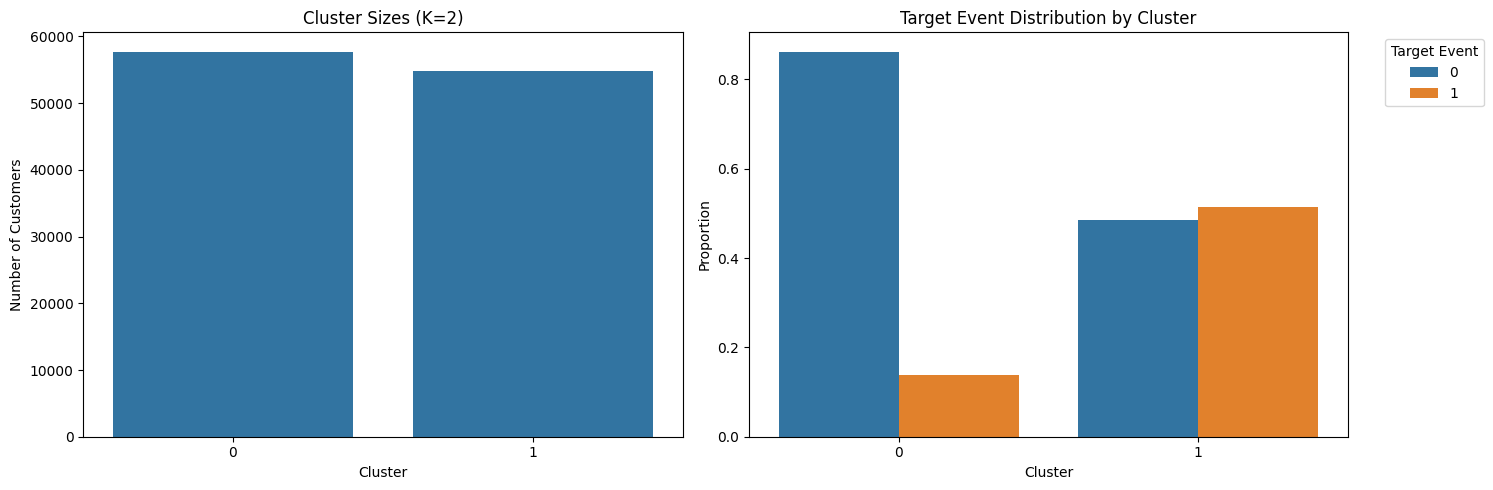

✓ Success: K=2, Features=48

--- Grid Search Experiment 14/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 54534 customers (48.43%)
  Cluster 1: 4245 customers (3.77%)
  Cluster 2: 53831 customers (47.80%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -4.84              0.35          0.59        73.59
1        -3.54              1.96          2.11        55.34
2       -11.16              0.54          0.83        23.14

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0

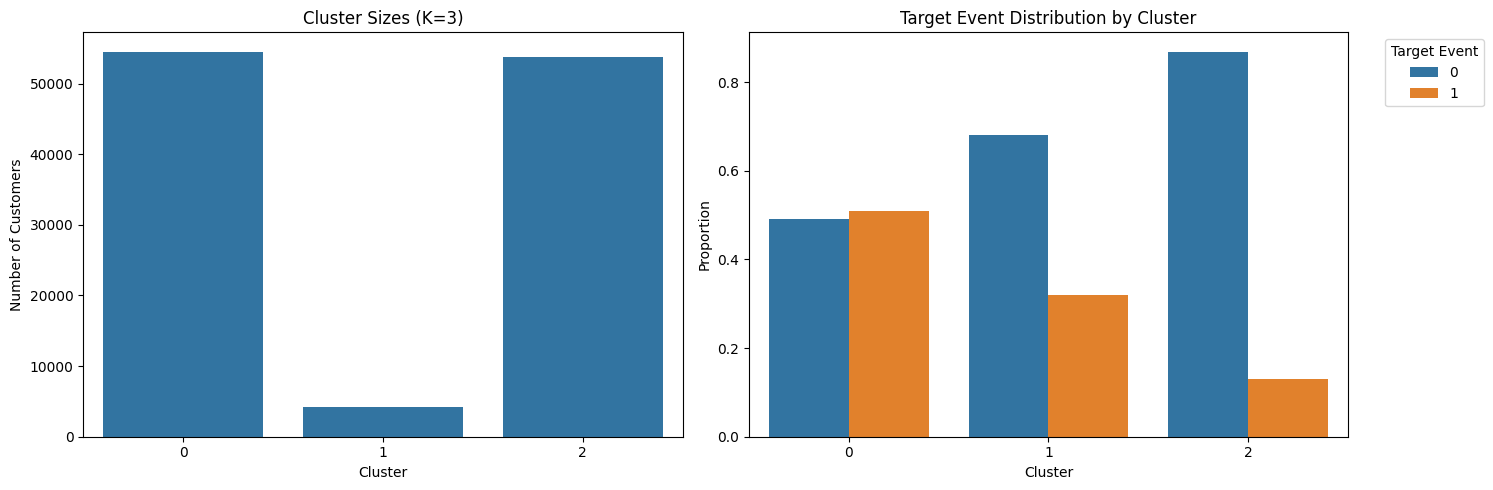

✓ Success: K=3, Features=48

--- Grid Search Experiment 15/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32

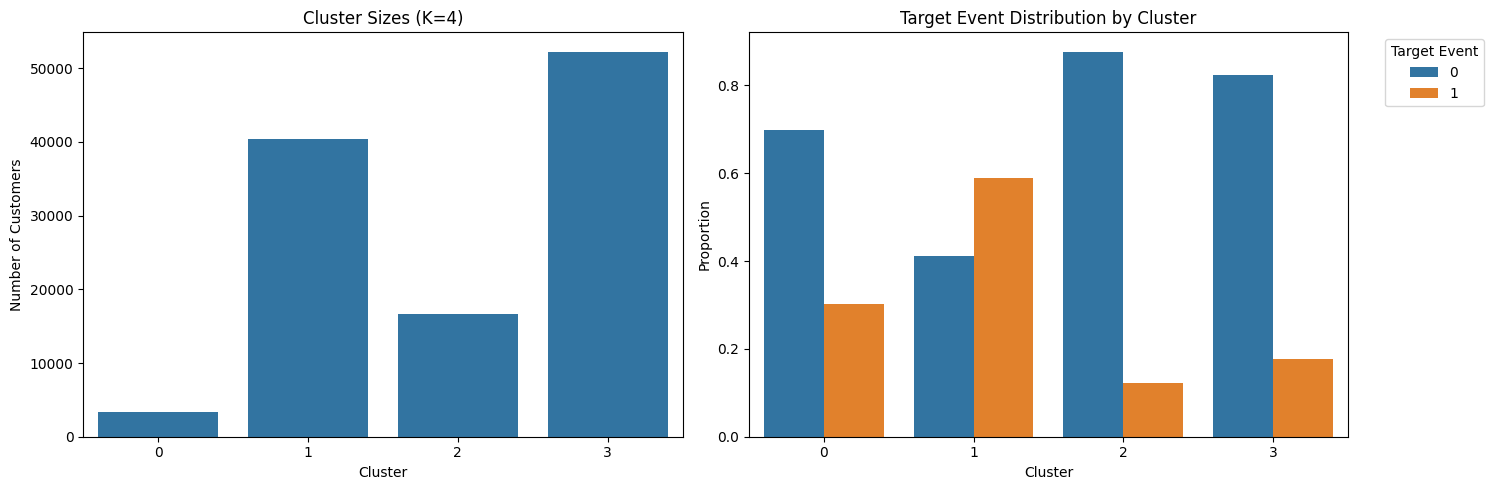

✓ Success: K=4, Features=48

--- Grid Search Experiment 16/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 14028 customers (12.46%)
  Cluster 1: 11998 customers (10.65%)
  Cluster 2: 47302 customers (42.01%)
  Cluster 3: 36303 customers (32.24%)
  Cluster 4: 2979 customers (2.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.46              0.60          0.86        13.93
1         2.78              0.37          0.47       103.42
2       -10.46              0.52          0.81        29.11
3        -6.82    

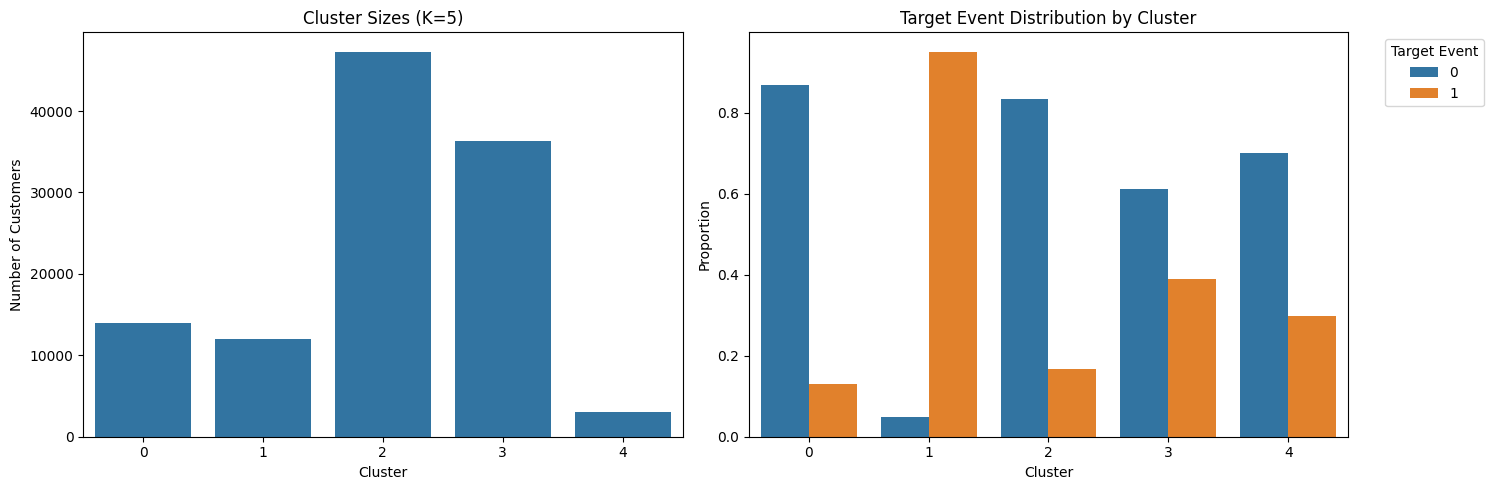

✓ Success: K=5, Features=48

--- Grid Search Experiment 17/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 13405 customers (11.90%)
  Cluster 1: 11588 customers (10.29%)
  Cluster 2: 322 customers (0.29%)
  Cluster 3: 34994 customers (31.08%)
  Cluster 4: 45683 customers (40.57%)
  Cluster 5: 6618 customers (5.88%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.43              0.61          0.87        13.70
1         2.72              0.36          0.46       104.27
2         0.58              4.52          5.79        57.20
3        -6.96              0.29          0.58

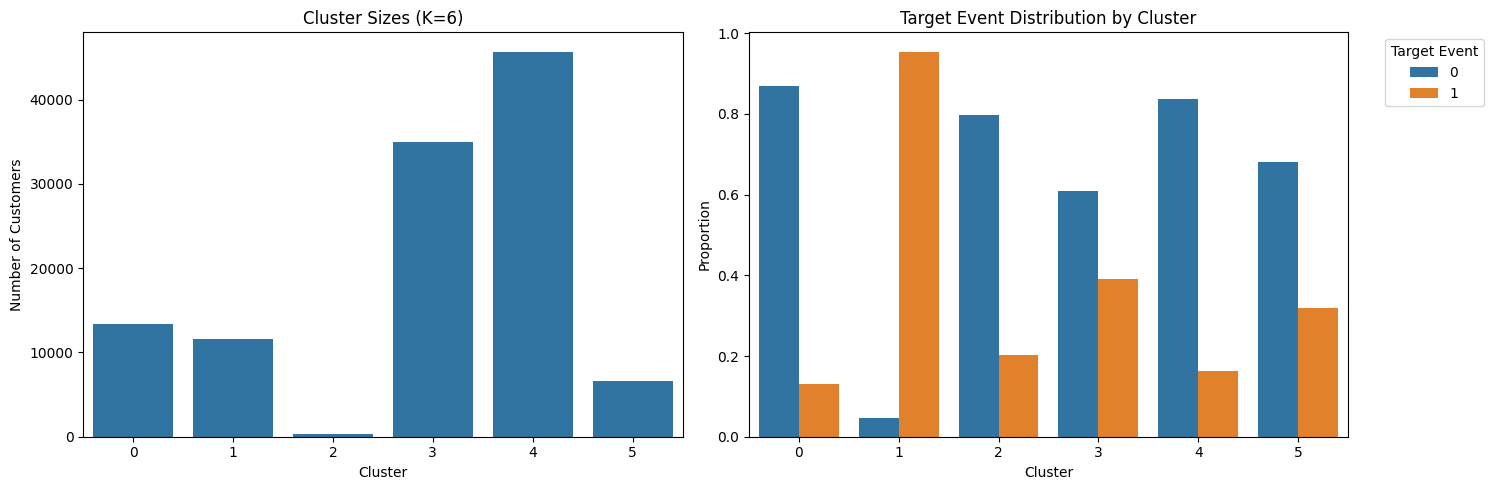

✓ Success: K=6, Features=48

--- Grid Search Experiment 18/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=12
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 30434 customers (27.03%)
  Cluster 1: 15921 customers (14.14%)
  Cluster 2: 11209 customers (9.95%)
  Cluster 3: 5942 customers (5.28%)
  Cluster 4: 252 customers (0.22%)
  Cluster 5: 42980 customers (38.17%)
  Cluster 6: 5872 customers (5.21%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -6.62              0.28          0.57        73.69
1       -11.89              0.52          0.77        16.44
2         2.76              0.36          0.46       104.34
3       -10

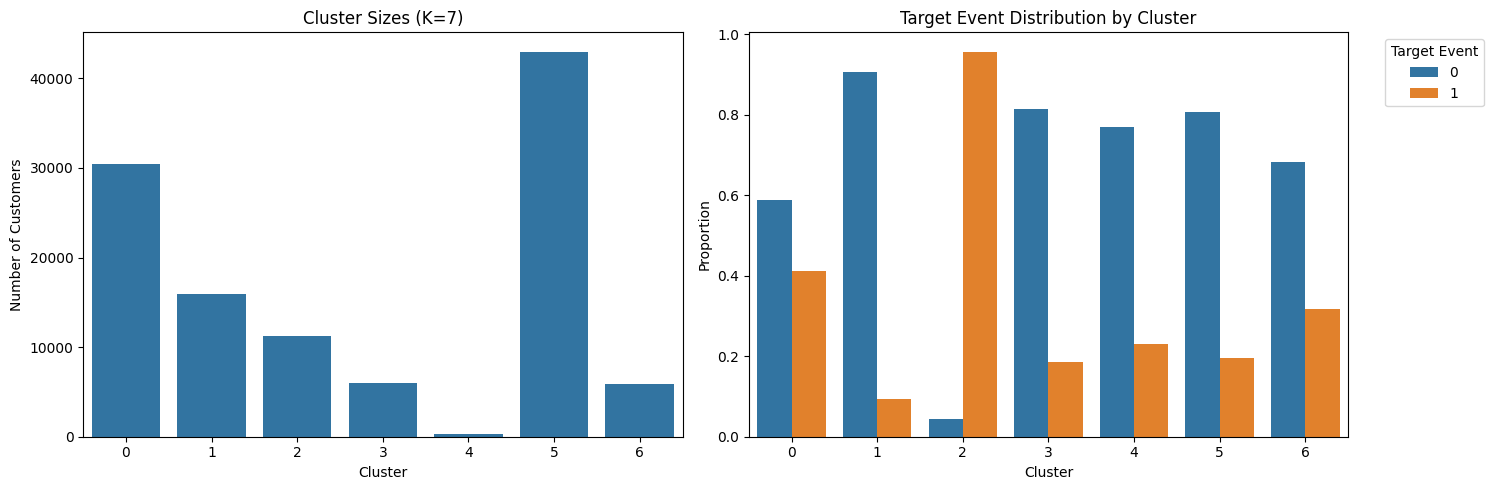

✓ Success: K=7, Features=48

--- Grid Search Experiment 19/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=10, max_k=15


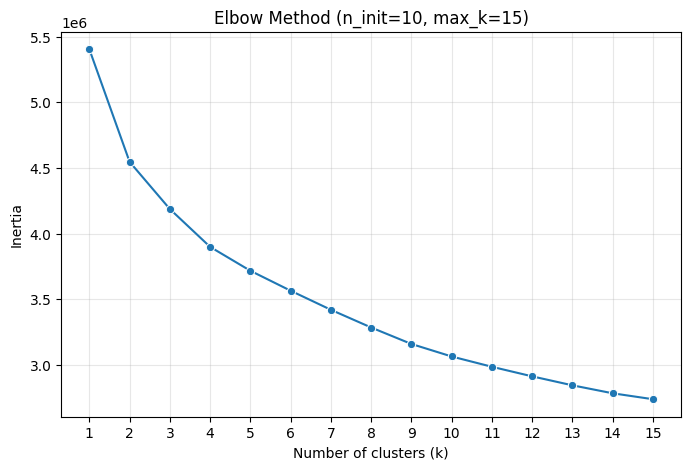

Rate of change analysis:
K=2, First diff=-858595.45, Second diff=498701.38
K=3, First diff=-359894.06, Second diff=71469.00
K=4, First diff=-288425.06, Second diff=106255.83
K=5, First diff=-182169.23, Second diff=30047.98
K=6, First diff=-152121.25, Second diff=6750.58
K=7, First diff=-145370.67, Second diff=10327.31
K=8, First diff=-135043.35, Second diff=9439.85
K=9, First diff=-125603.50, Second diff=30191.49
K=10, First diff=-95412.01, Second diff=16872.87
K=11, First diff=-78539.14, Second diff=5589.73
K=12, First diff=-72949.41, Second diff=4609.88
K=13, First diff=-68339.53, Second diff=7581.20
K=14, First diff=-60758.33, Second diff=15544.33
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57730 customers (51.27%)
  Cluster 1: 54880 customers (48.73%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metr

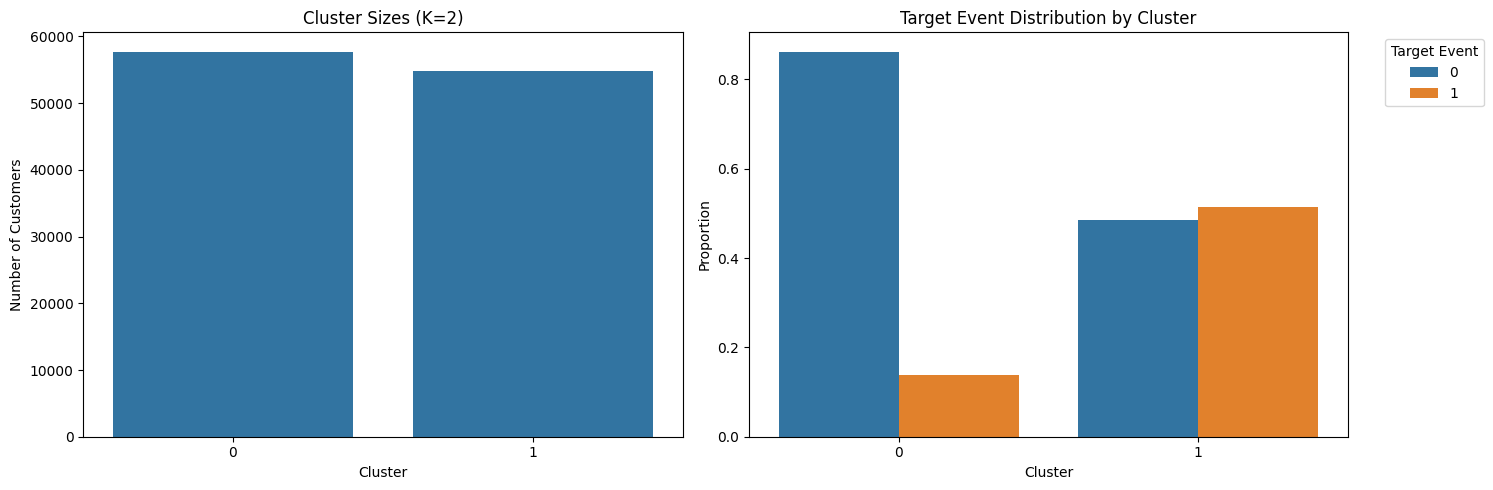

✓ Success: K=2, Features=48

--- Grid Search Experiment 20/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 54534 customers (48.43%)
  Cluster 1: 4245 customers (3.77%)
  Cluster 2: 53831 customers (47.80%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -4.84              0.35          0.59        73.59
1        -3.54              1.96          2.11        55.34
2       -11.16              0.54          0.83        23.14

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0

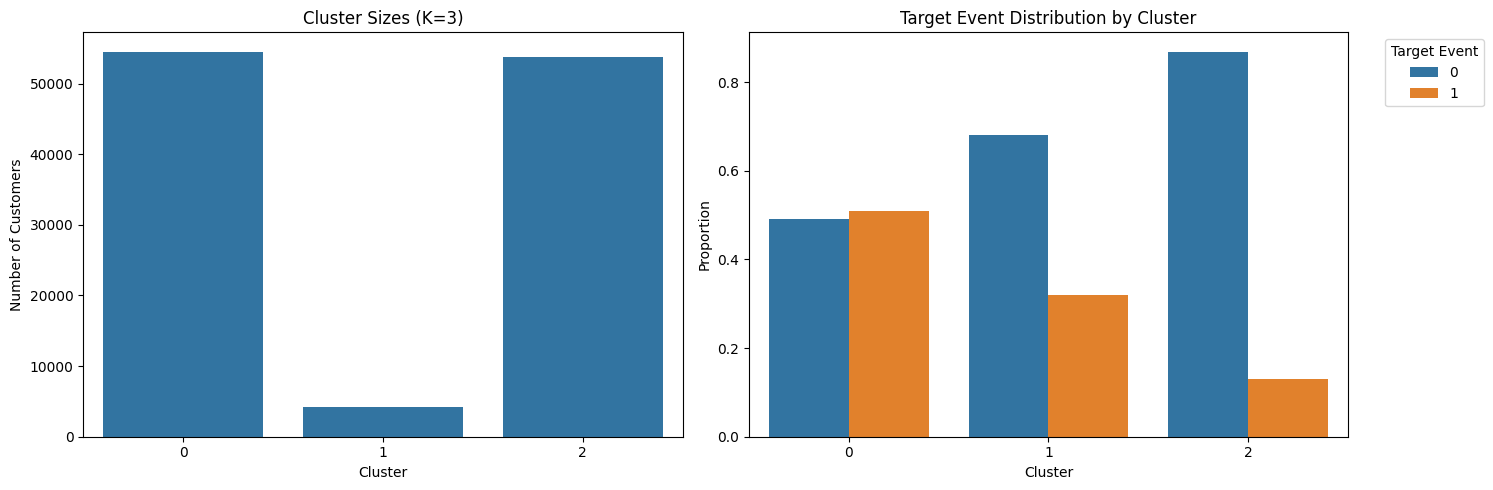

✓ Success: K=3, Features=48

--- Grid Search Experiment 21/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.59

Target Event Distribution by Cluster:
target_event      0 

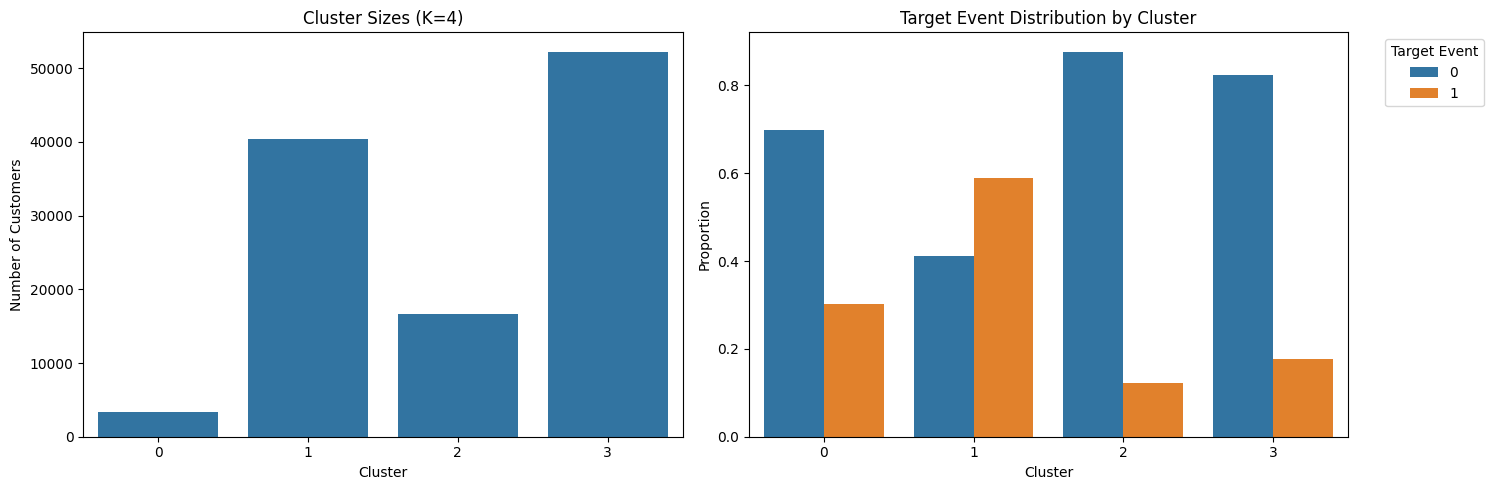

✓ Success: K=4, Features=48

--- Grid Search Experiment 22/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 14028 customers (12.46%)
  Cluster 1: 11998 customers (10.65%)
  Cluster 2: 47302 customers (42.01%)
  Cluster 3: 36303 customers (32.24%)
  Cluster 4: 2979 customers (2.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.46              0.60          0.86        13.93
1         2.78              0.37          0.47       103.42
2       -10.46              0.52          0.81        29.11
3        -6.82              0.34          0.62        69.35
4 

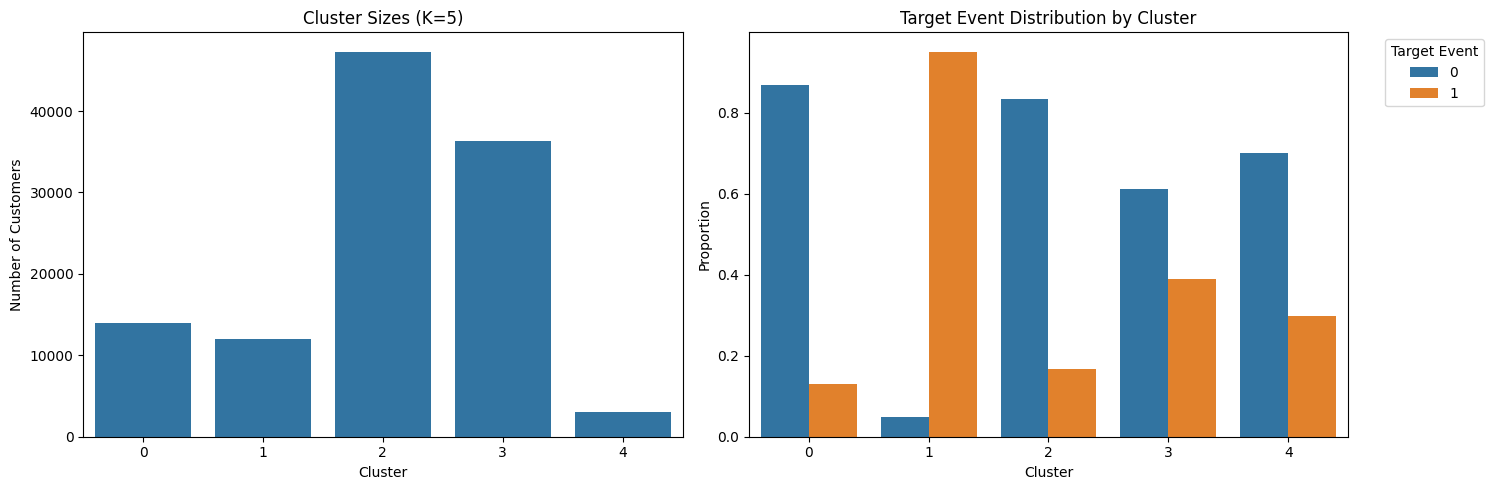

✓ Success: K=5, Features=48

--- Grid Search Experiment 23/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 13405 customers (11.90%)
  Cluster 1: 11588 customers (10.29%)
  Cluster 2: 322 customers (0.29%)
  Cluster 3: 34994 customers (31.08%)
  Cluster 4: 45683 customers (40.57%)
  Cluster 5: 6618 customers (5.88%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.43              0.61          0.87        13.70
1         2.72              0.36          0.46       104.27
2         0.58              4.52          5.79        57.20
3        -6.96              0.29          0.58

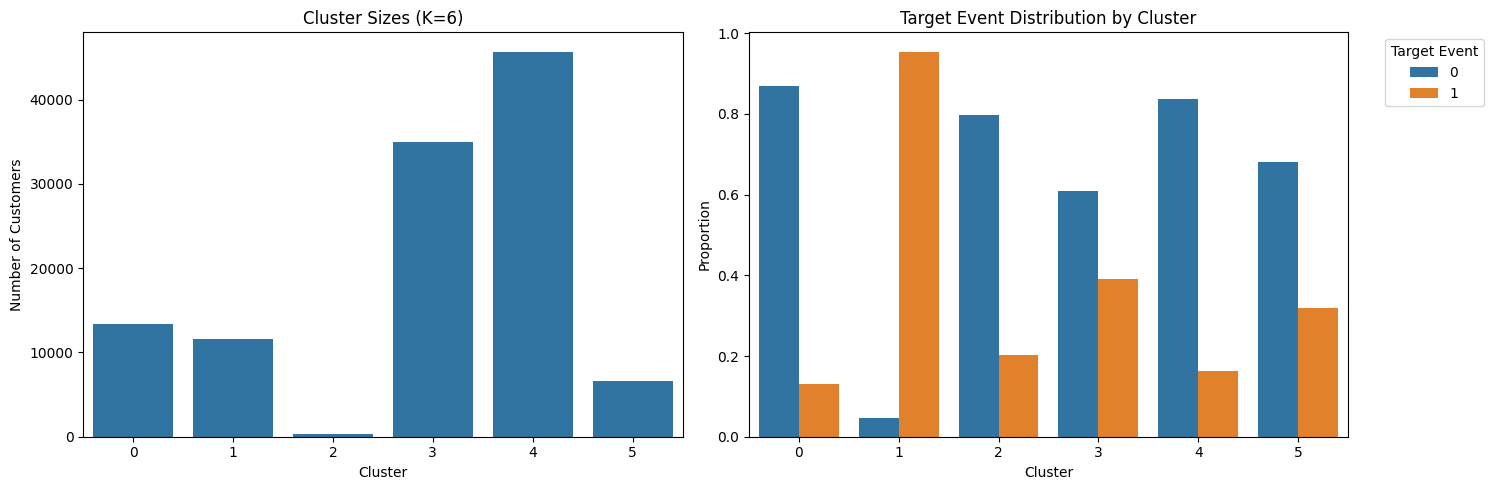

✓ Success: K=6, Features=48

--- Grid Search Experiment 24/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=10, max_k=15
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 30434 customers (27.03%)
  Cluster 1: 15921 customers (14.14%)
  Cluster 2: 11209 customers (9.95%)
  Cluster 3: 5942 customers (5.28%)
  Cluster 4: 252 customers (0.22%)
  Cluster 5: 42980 customers (38.17%)
  Cluster 6: 5872 customers (5.21%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -6.62              0.28          0.57        73.69
1       -11.89              0.52          0.77        16.44
2         2.76              0.36          0.46      

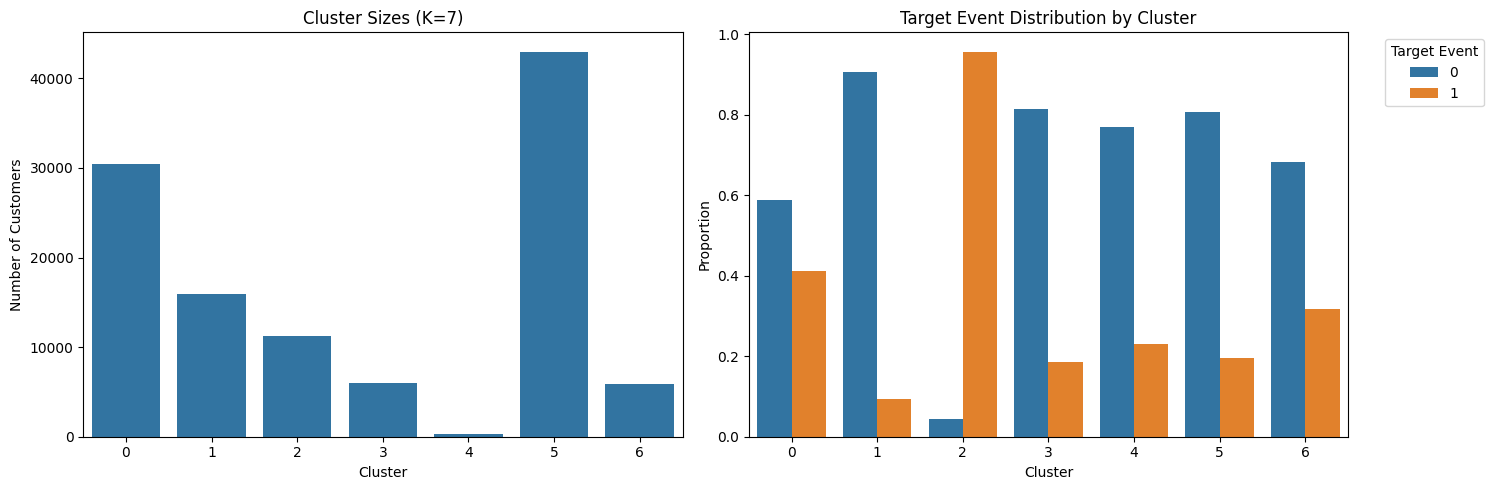

✓ Success: K=7, Features=48

--- Grid Search Experiment 25/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=8
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=8


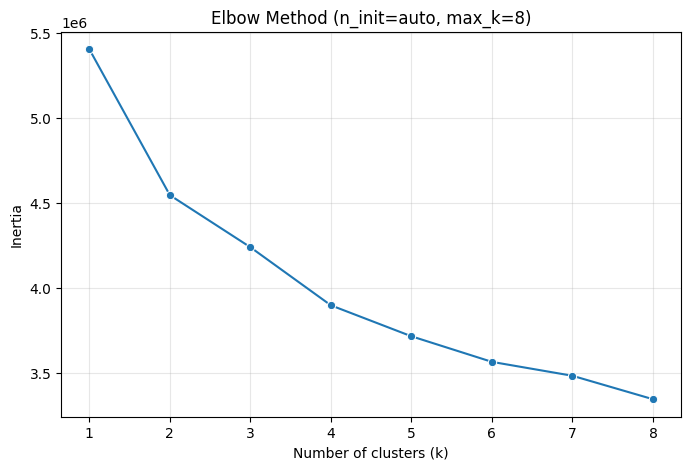

Rate of change analysis:
K=2, First diff=-858591.31, Second diff=552166.84
K=3, First diff=-306424.47, Second diff=-35474.34
K=4, First diff=-341898.80, Second diff=159739.88
K=5, First diff=-182158.92, Second diff=31606.56
K=6, First diff=-150552.36, Second diff=68711.99
K=7, First diff=-81840.37, Second diff=-56108.87
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57962 customers (51.47%)
  Cluster 1: 54648 customers (48.53%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.04              0.54          0.83        24.74
1        -4.39              0.46          0.69        74.29

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0    

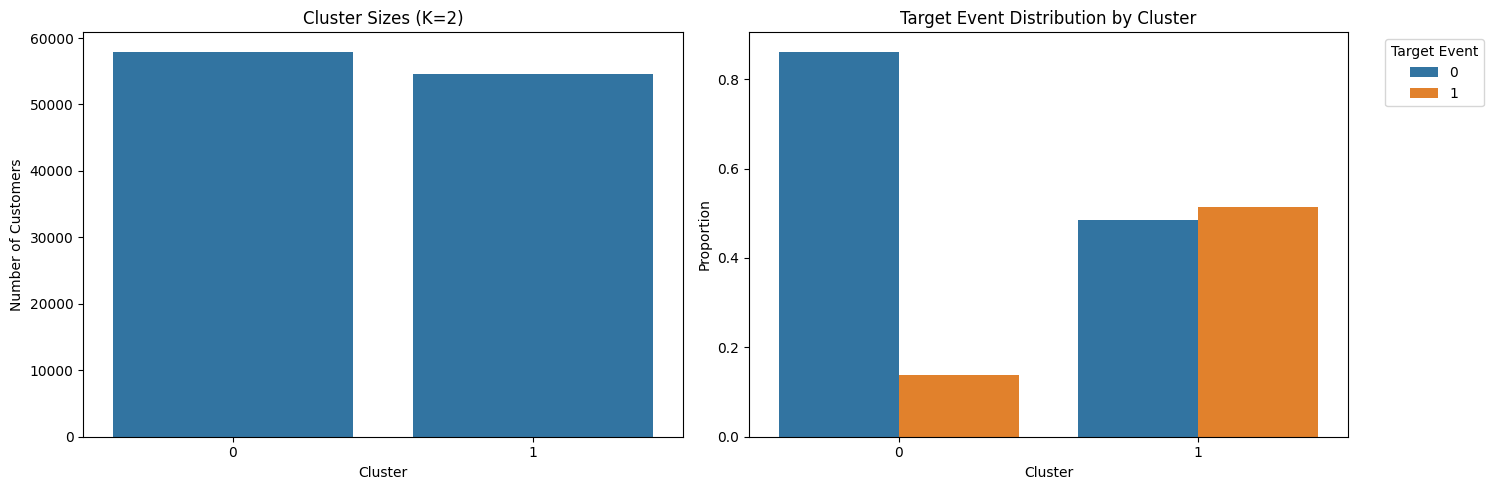

✓ Success: K=2, Features=48

--- Grid Search Experiment 26/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 55502 customers (49.29%)
  Cluster 1: 39123 customers (34.74%)
  Cluster 2: 17985 customers (15.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.02              0.52          0.81        35.05
1        -2.96              0.45          0.67        83.84
2       -11.57              0.55          0.82        14.91

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.807  0.193
1             0.405  0.595
2      

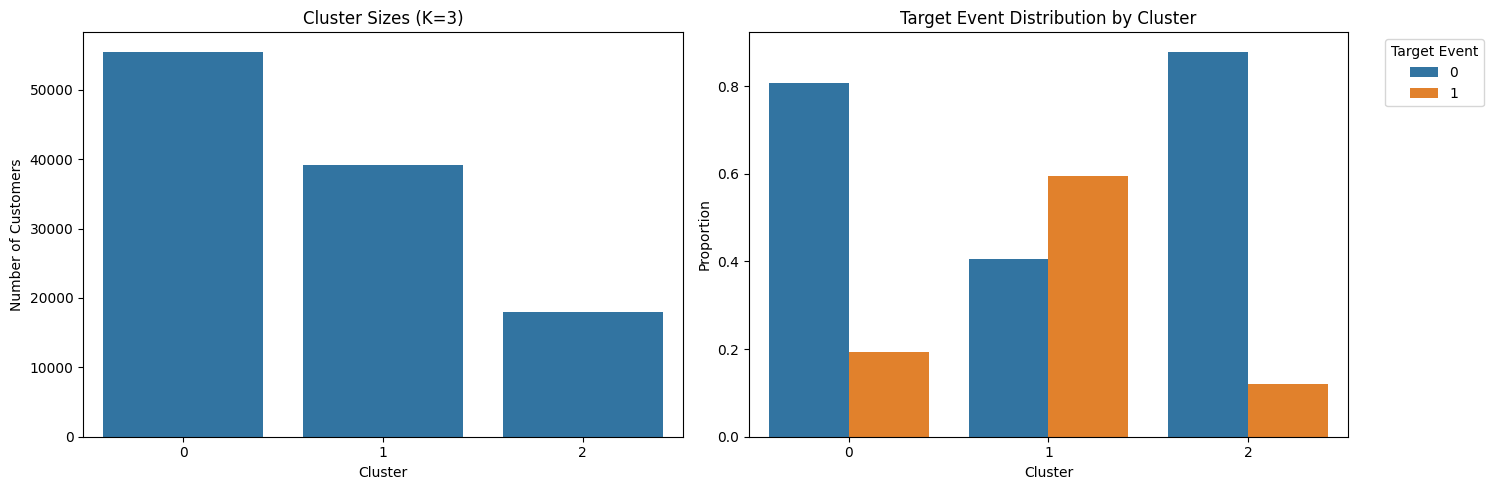

✓ Success: K=3, Features=48

--- Grid Search Experiment 27/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.59

Target Event Distribution by Cluster:
target_event      0

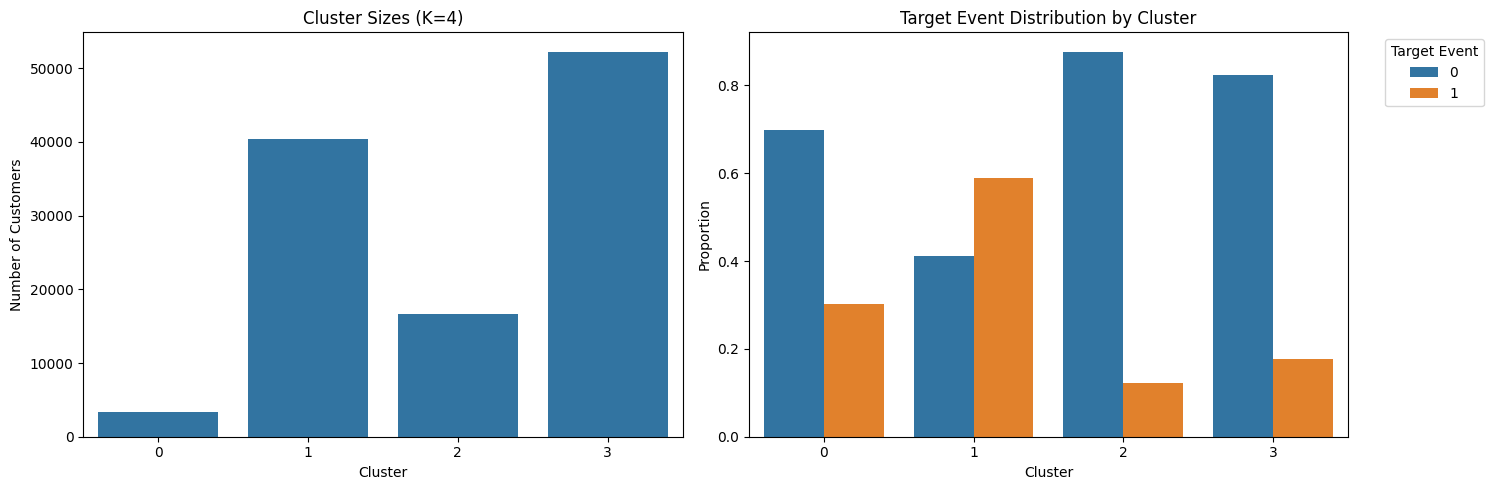

✓ Success: K=4, Features=48

--- Grid Search Experiment 28/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_rat

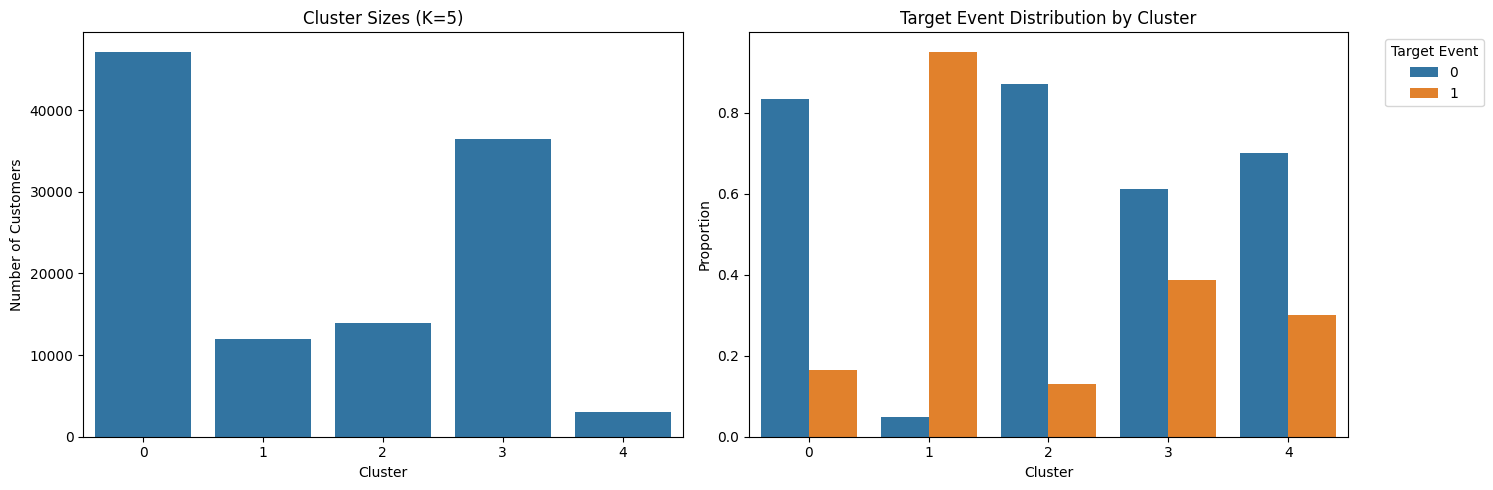

✓ Success: K=5, Features=48

--- Grid Search Experiment 29/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster 5: 1205 customers (1.07%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster 

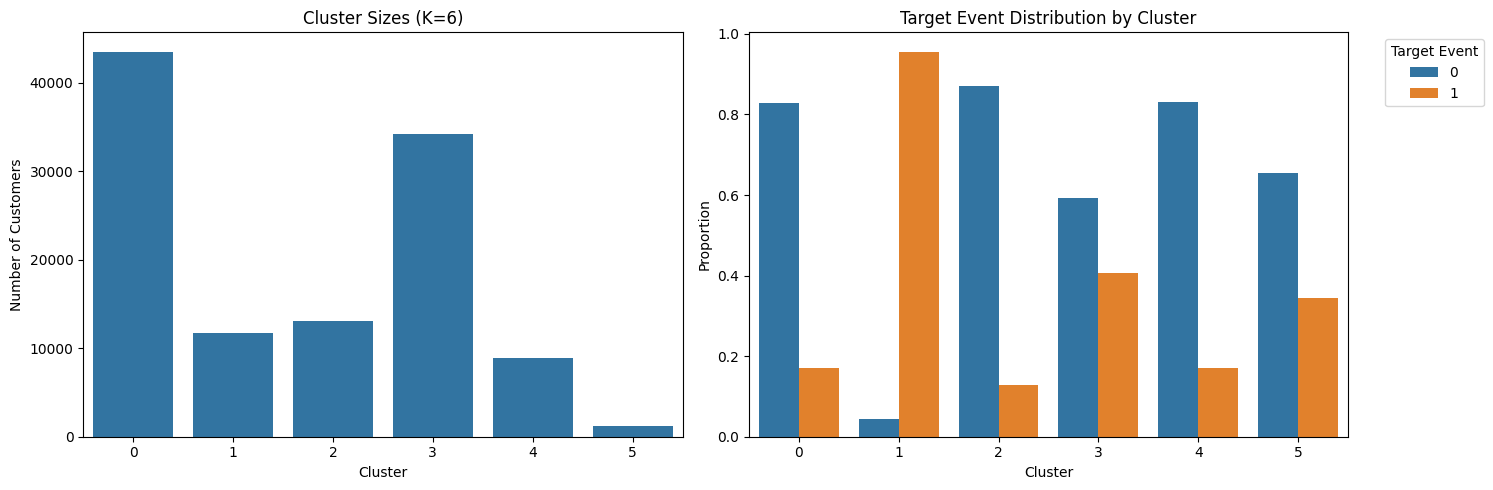

✓ Success: K=6, Features=48

--- Grid Search Experiment 30/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=8
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 9184 customers (8.16%)
  Cluster 5: 1065 customers (0.95%)
  Cluster 6: 9519 customers (8.45%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 9

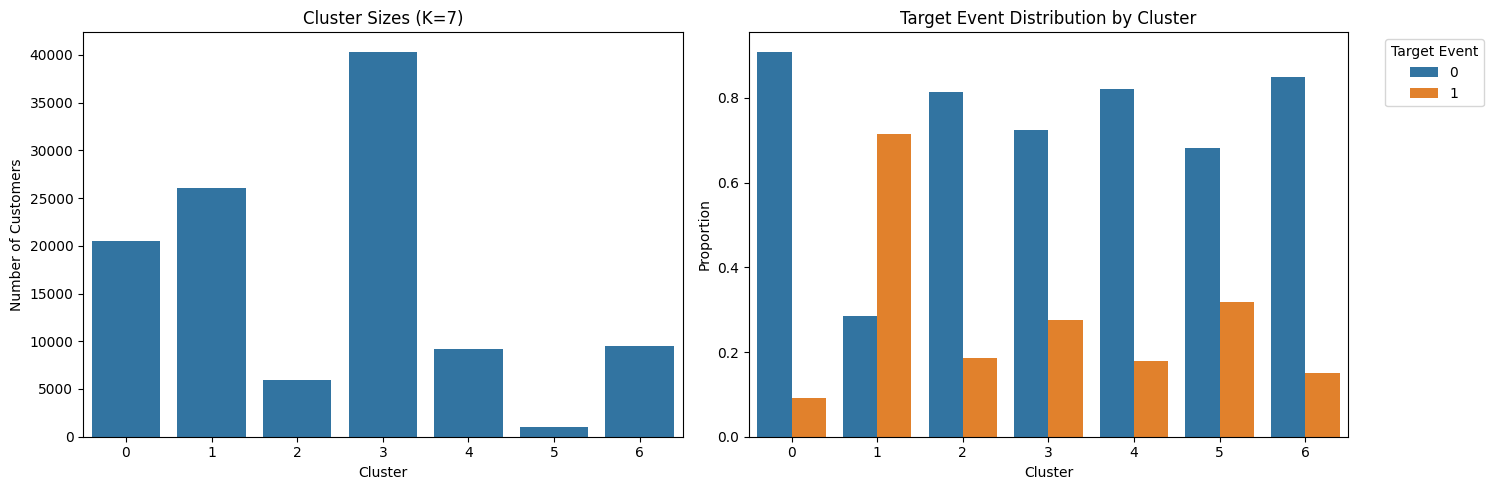

✓ Success: K=7, Features=48

--- Grid Search Experiment 31/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=10
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=10


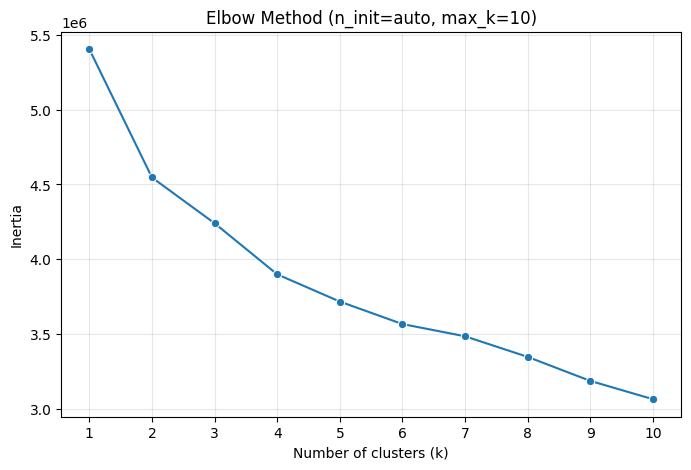

Rate of change analysis:
K=2, First diff=-858591.31, Second diff=552166.84
K=3, First diff=-306424.47, Second diff=-35474.34
K=4, First diff=-341898.80, Second diff=159739.88
K=5, First diff=-182158.92, Second diff=31606.56
K=6, First diff=-150552.36, Second diff=68711.99
K=7, First diff=-81840.37, Second diff=-56108.87
K=8, First diff=-137949.24, Second diff=-22735.30
K=9, First diff=-160684.54, Second diff=38149.96
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57962 customers (51.47%)
  Cluster 1: 54648 customers (48.53%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.04              0.54          0.83        24.74
1        -4.39              0.46          0.69        74.29

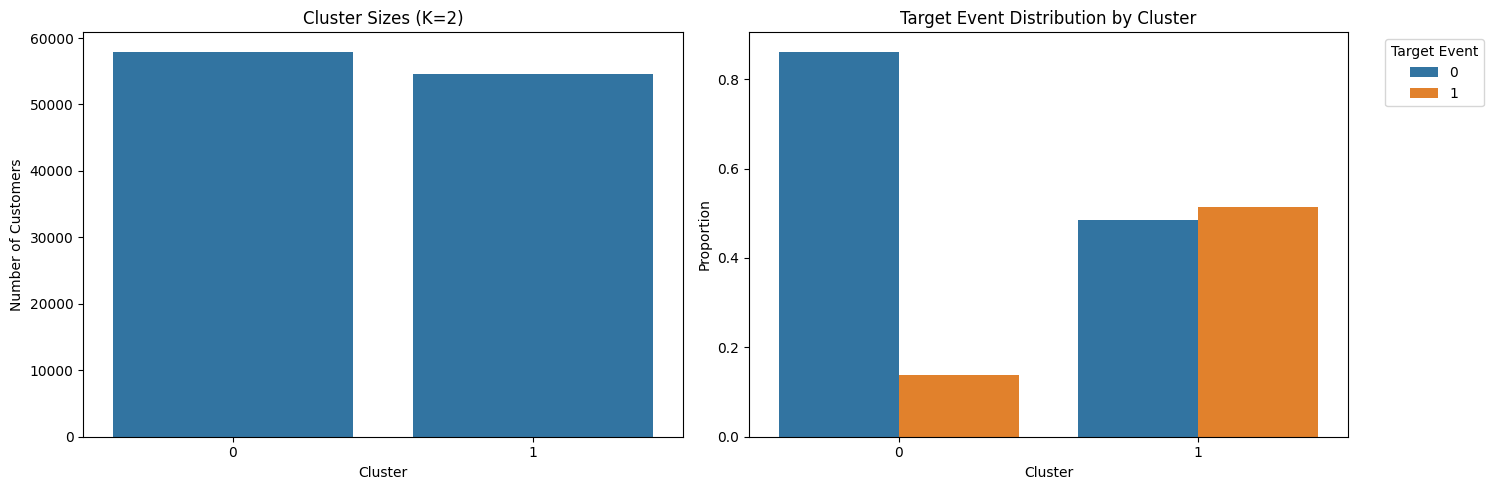

✓ Success: K=2, Features=48

--- Grid Search Experiment 32/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 55502 customers (49.29%)
  Cluster 1: 39123 customers (34.74%)
  Cluster 2: 17985 customers (15.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.02              0.52          0.81        35.05
1        -2.96              0.45          0.67        83.84
2       -11.57              0.55          0.82        14.91

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.807  0.193
1             0.405  0.595
2     

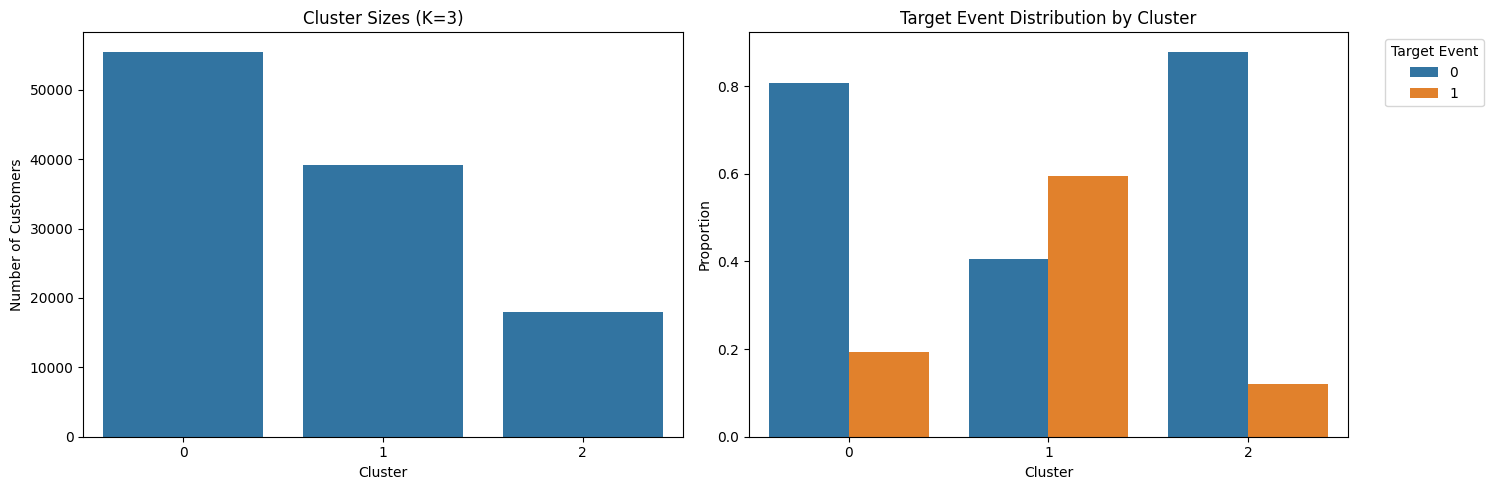

✓ Success: K=3, Features=48

--- Grid Search Experiment 33/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        

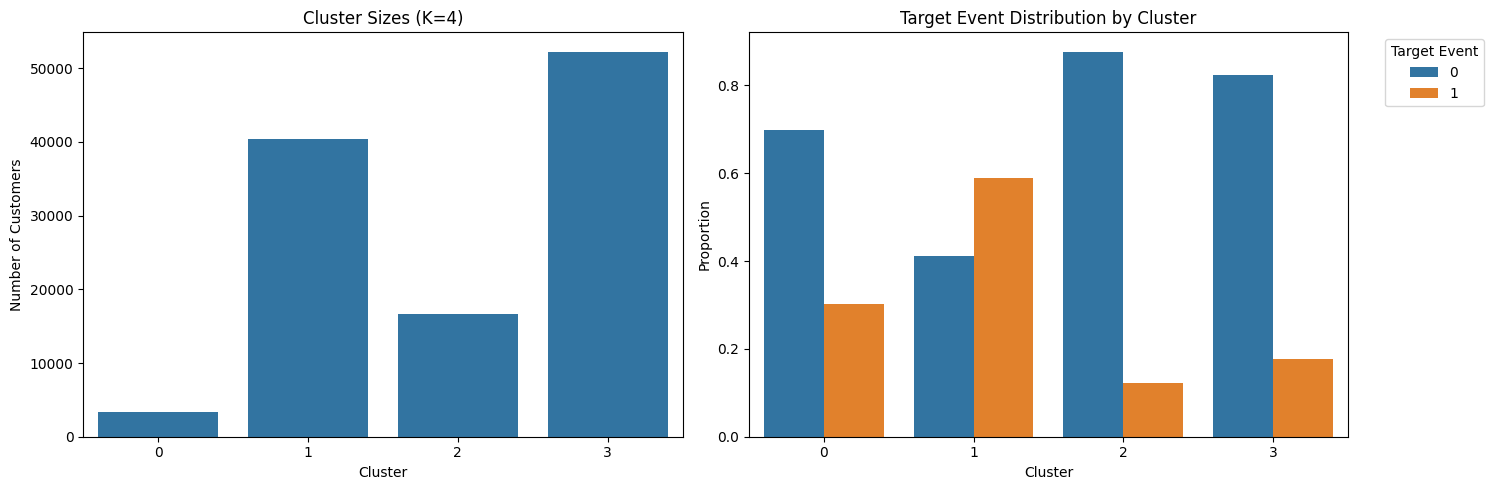

✓ Success: K=4, Features=48

--- Grid Search Experiment 34/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Av

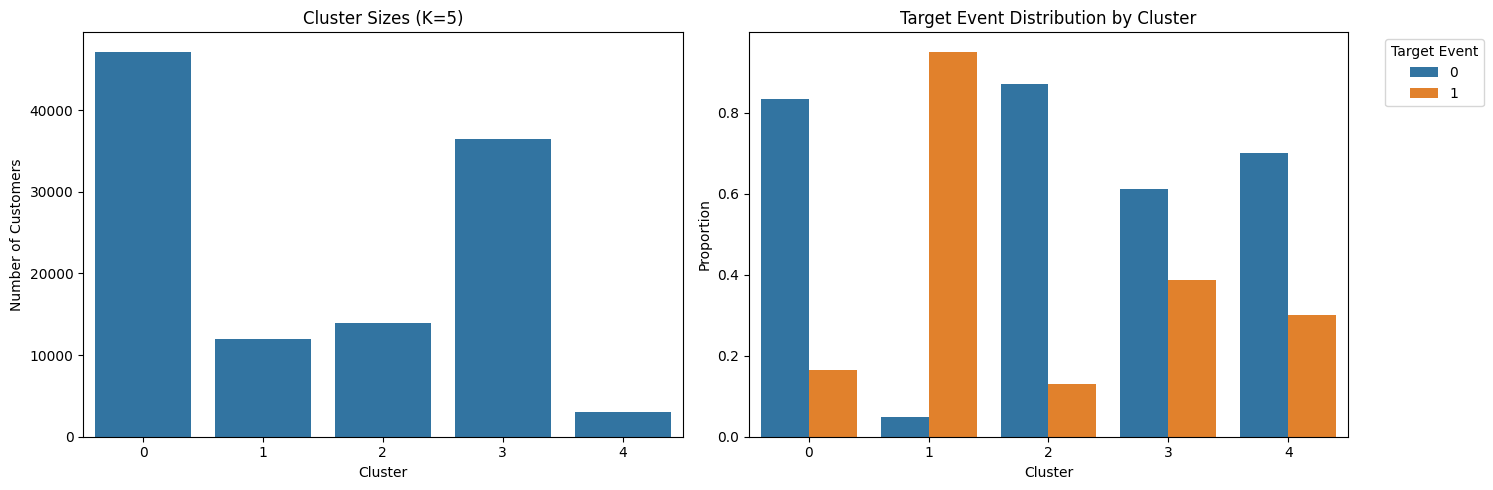

✓ Success: K=5, Features=48

--- Grid Search Experiment 35/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster 5: 1205 customers (1.07%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster

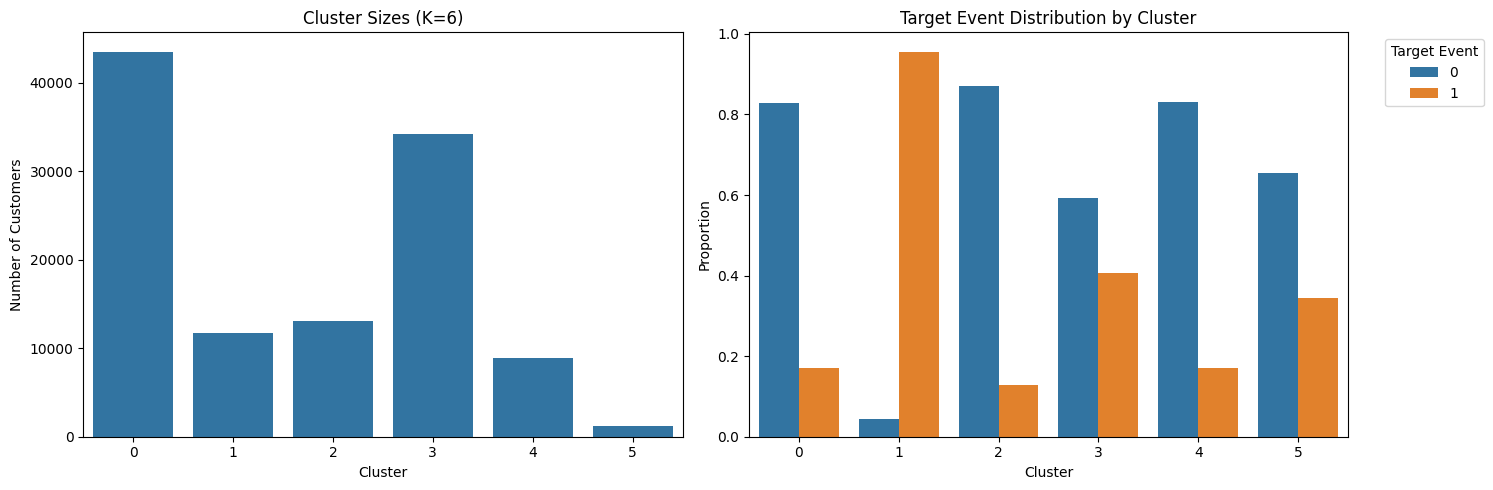

✓ Success: K=6, Features=48

--- Grid Search Experiment 36/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=10
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 9184 customers (8.16%)
  Cluster 5: 1065 customers (0.95%)
  Cluster 6: 9519 customers (8.45%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 

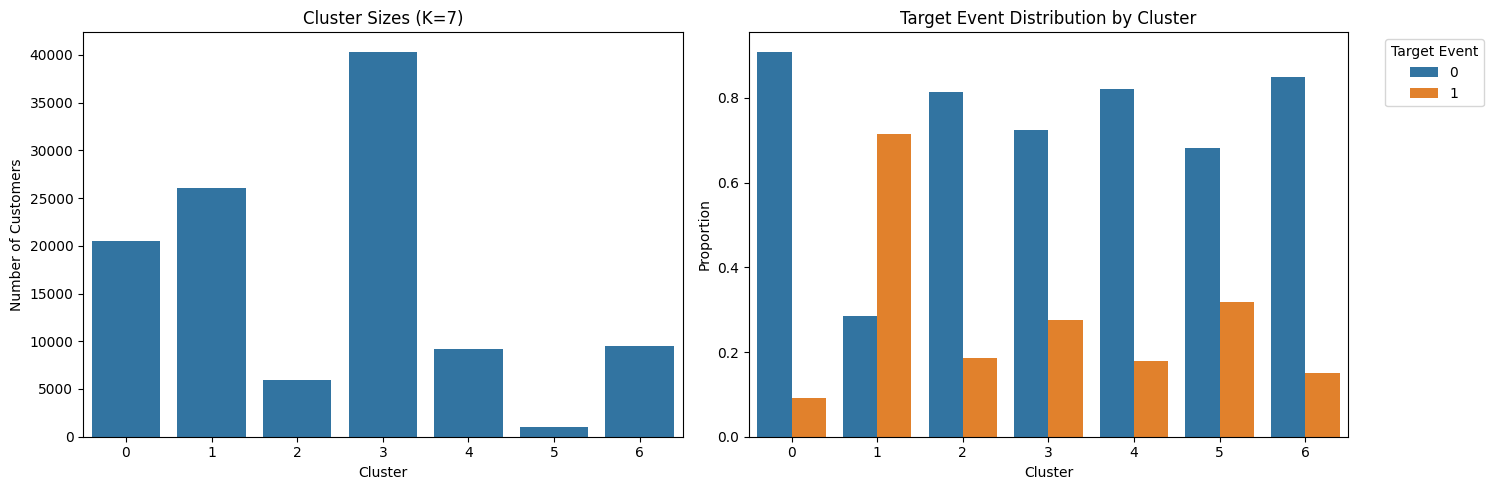

✓ Success: K=7, Features=48

--- Grid Search Experiment 37/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=12
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=12


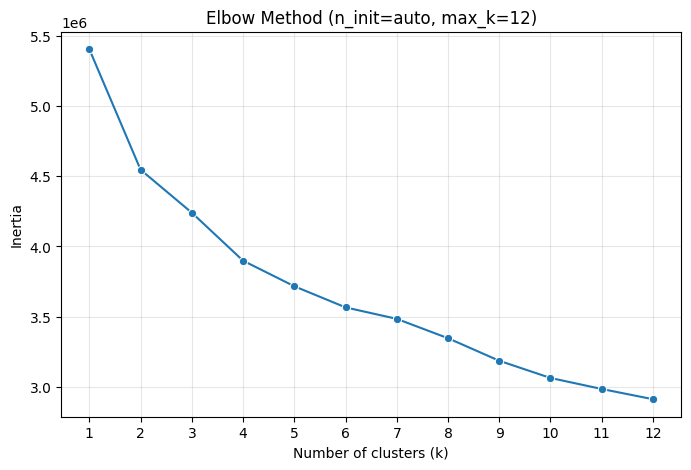

Rate of change analysis:
K=2, First diff=-858591.31, Second diff=552166.84
K=3, First diff=-306424.47, Second diff=-35474.34
K=4, First diff=-341898.80, Second diff=159739.88
K=5, First diff=-182158.92, Second diff=31606.56
K=6, First diff=-150552.36, Second diff=68711.99
K=7, First diff=-81840.37, Second diff=-56108.87
K=8, First diff=-137949.24, Second diff=-22735.30
K=9, First diff=-160684.54, Second diff=38149.96
K=10, First diff=-122534.58, Second diff=43998.20
K=11, First diff=-78536.38, Second diff=5587.49
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57962 customers (51.47%)
  Cluster 1: 54648 customers (48.53%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.04       

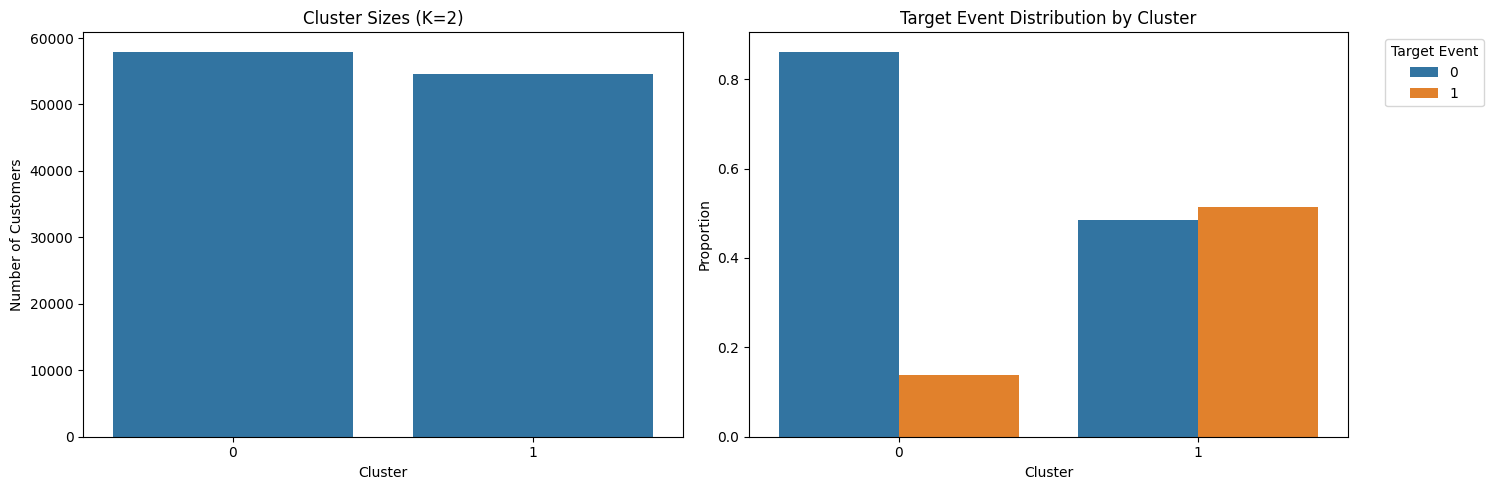

✓ Success: K=2, Features=48

--- Grid Search Experiment 38/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 55502 customers (49.29%)
  Cluster 1: 39123 customers (34.74%)
  Cluster 2: 17985 customers (15.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 55502 customers (49.29%)
  Cluster 1: 39123 customers (34.74%)
  Cluster 2: 17985 customers (15.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 me

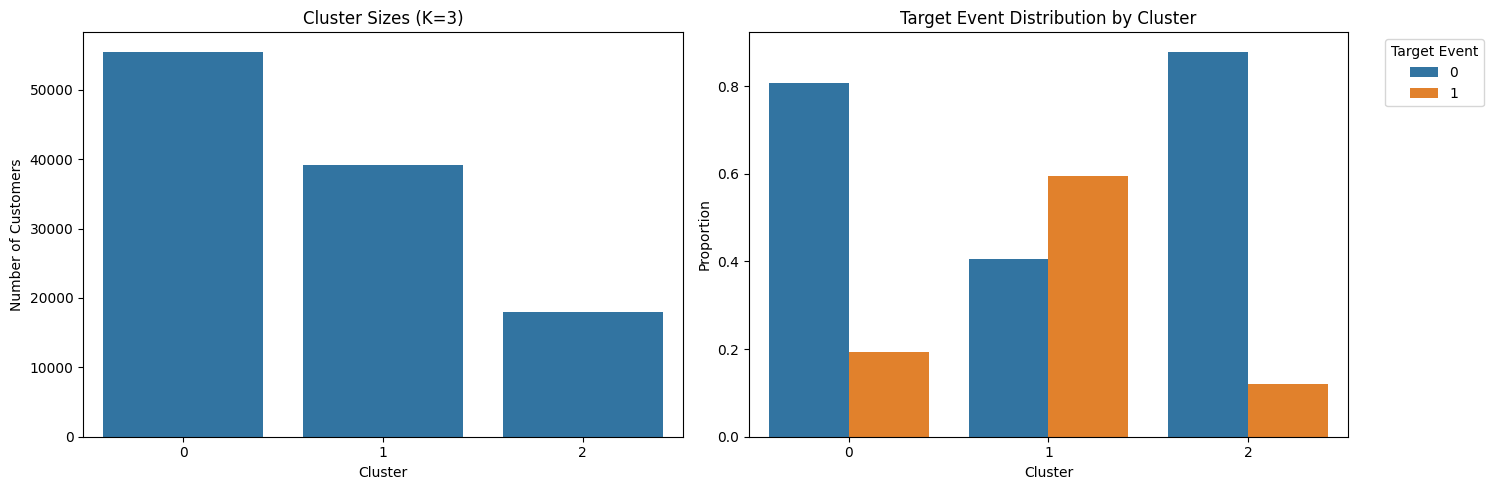

✓ Success: K=3, Features=48

--- Grid Search Experiment 39/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.53              2.13          2.28        55.19
1        -3.45              0.34          0.56        83.22
2       -11.54              0.57          0.83        14.56
3       -10.28              0.51          0.80        32.59

Target Event Distribution by Cluster:
target_event      

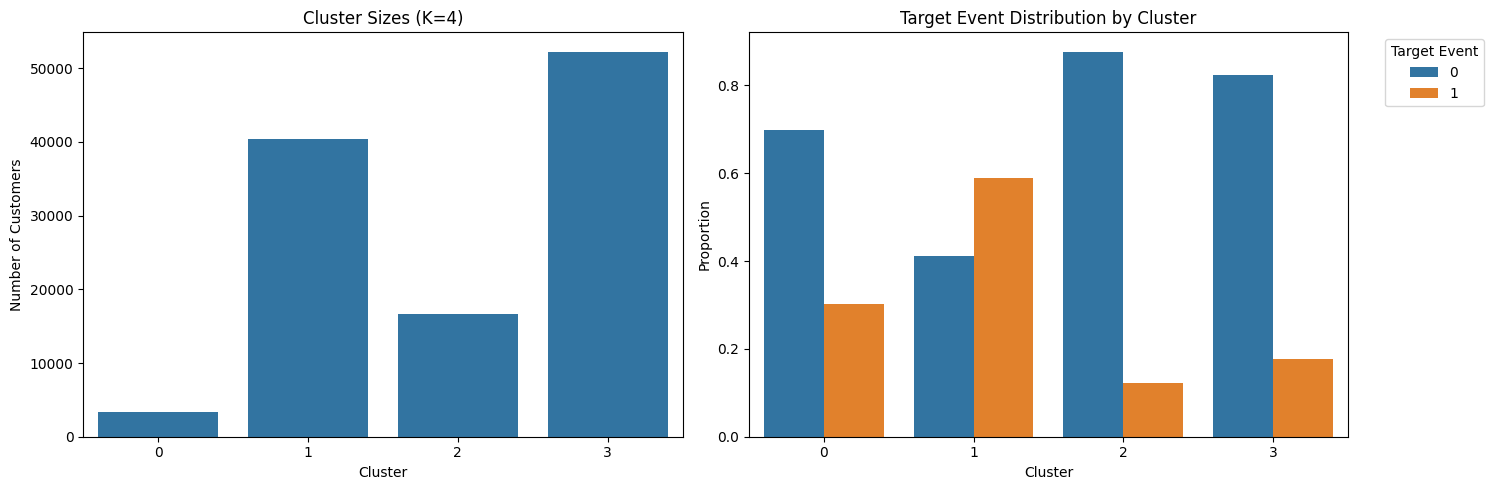

✓ Success: K=4, Features=48

--- Grid Search Experiment 40/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.47              0.52          0.81        28.97
1         2.77              0.37          0.47       103.46
2       -11.46              0.60          0.86        13.91
3        -6.84  

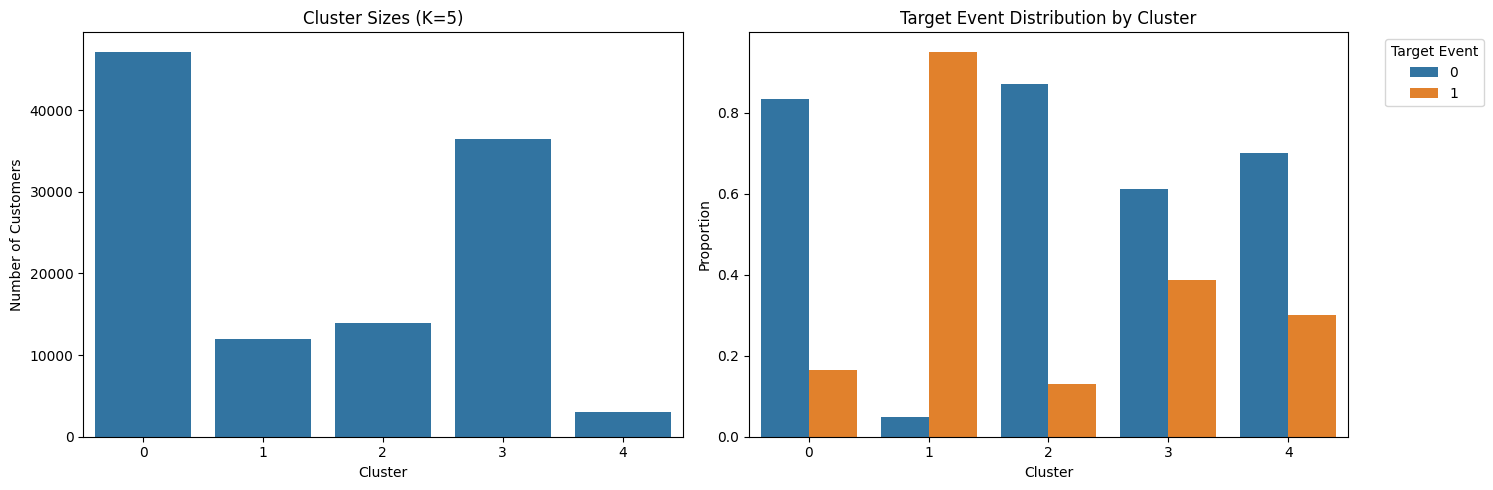

✓ Success: K=5, Features=48

--- Grid Search Experiment 41/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster 5: 1205 customers (1.07%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.48              0.36          0.68        31.46
1         2.94              0.38          0.48       103.72
2       -11.47              0.62        

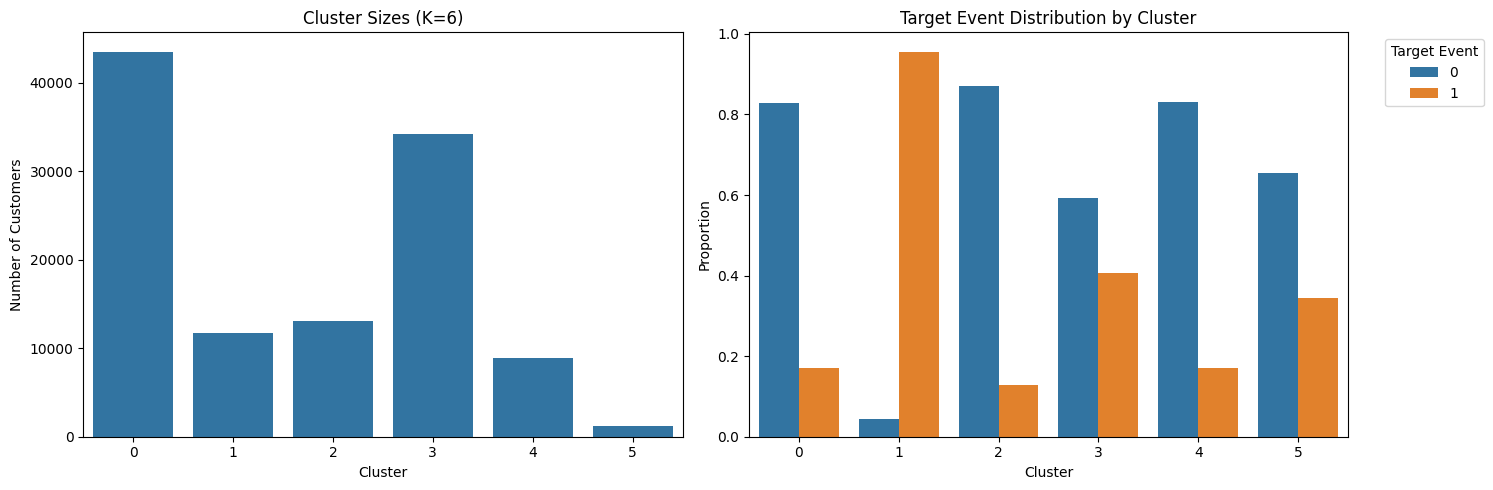

✓ Success: K=6, Features=48

--- Grid Search Experiment 42/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=12
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 9184 customers (8.16%)
  Cluster 5: 1065 customers (0.95%)
  Cluster 6: 9519 customers (8.45%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 

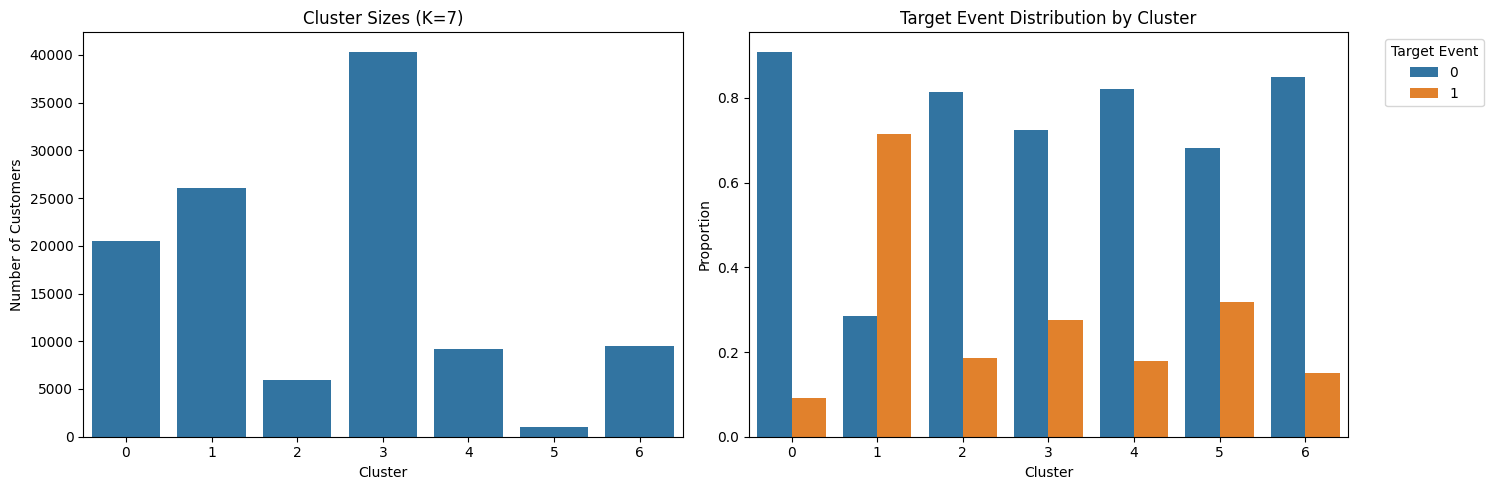

✓ Success: K=7, Features=48

--- Grid Search Experiment 43/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=15
Threshold (0.1, -0.1): 48 features selected
Finding optimal clusters: n_init=auto, max_k=15


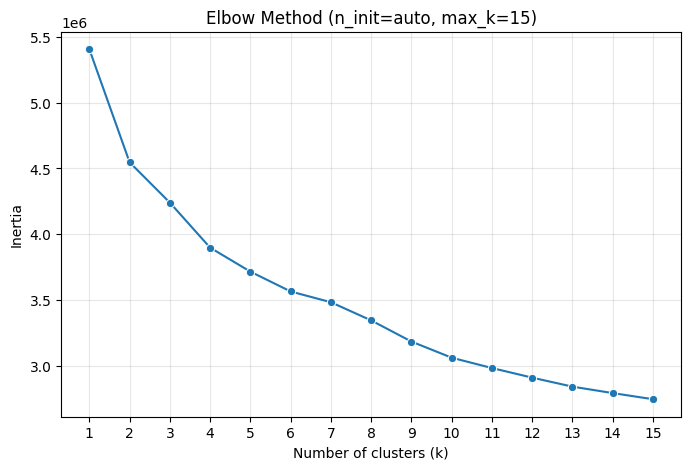

Rate of change analysis:
K=2, First diff=-858591.31, Second diff=552166.84
K=3, First diff=-306424.47, Second diff=-35474.34
K=4, First diff=-341898.80, Second diff=159739.88
K=5, First diff=-182158.92, Second diff=31606.56
K=6, First diff=-150552.36, Second diff=68711.99
K=7, First diff=-81840.37, Second diff=-56108.87
K=8, First diff=-137949.24, Second diff=-22735.30
K=9, First diff=-160684.54, Second diff=38149.96
K=10, First diff=-122534.58, Second diff=43998.20
K=11, First diff=-78536.38, Second diff=5587.49
K=12, First diff=-72948.89, Second diff=4606.08
K=13, First diff=-68342.81, Second diff=19421.12
K=14, First diff=-48921.69, Second diff=2314.61
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57962 customers (51.47%)
  Cluster 1: 54648 customers (48.53%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business

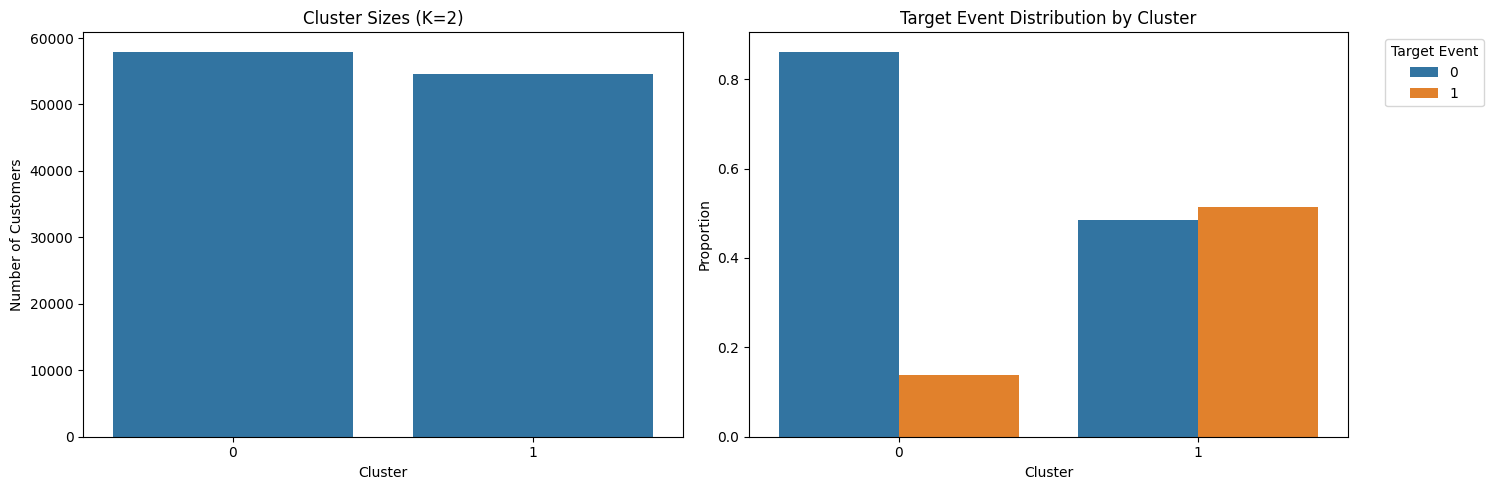

✓ Success: K=2, Features=48

--- Grid Search Experiment 44/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Manual K override: 3
Threshold (0.1, -0.1): 48 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 55502 customers (49.29%)
  Cluster 1: 39123 customers (34.74%)
  Cluster 2: 17985 customers (15.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.02              0.52          0.81        35.05
1        -2.96              0.45          0.67        83.84
2       -11.57              0.55          0.82        14.91

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.807  0.193
1             0.405  0.595
2     

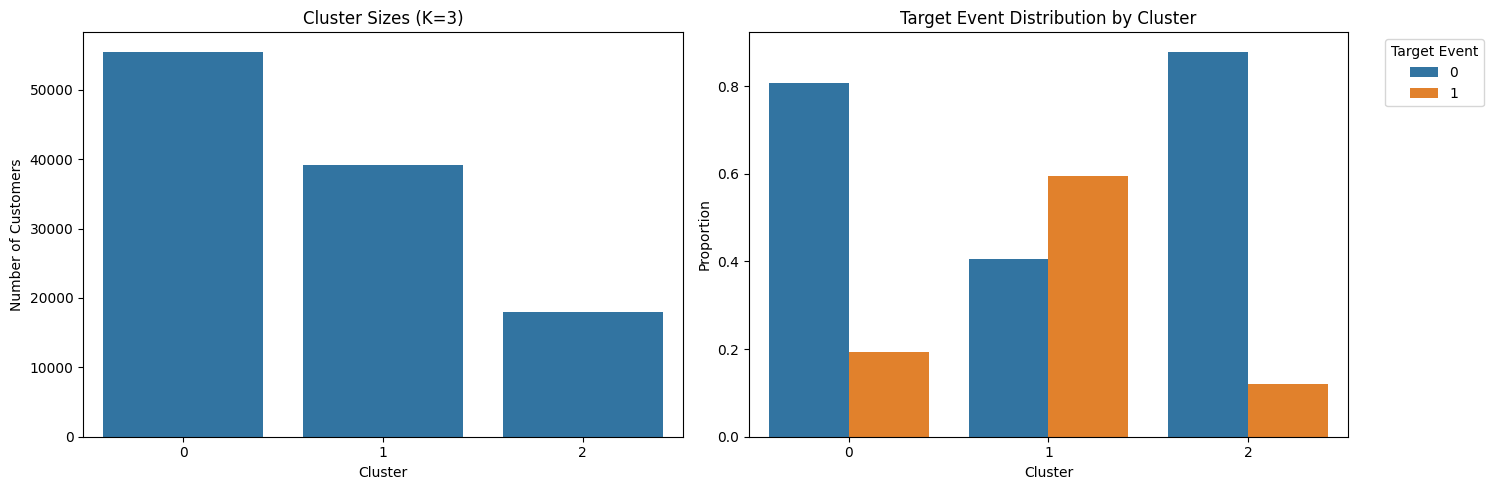

✓ Success: K=3, Features=48

--- Grid Search Experiment 45/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Manual K override: 4
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3300 customers (2.93%)
  Cluster 1: 40456 customers (35.93%)
  Cluster 2: 16591 customers (14.73%)
  Cluster 3: 52263 customers (46.41%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Usin

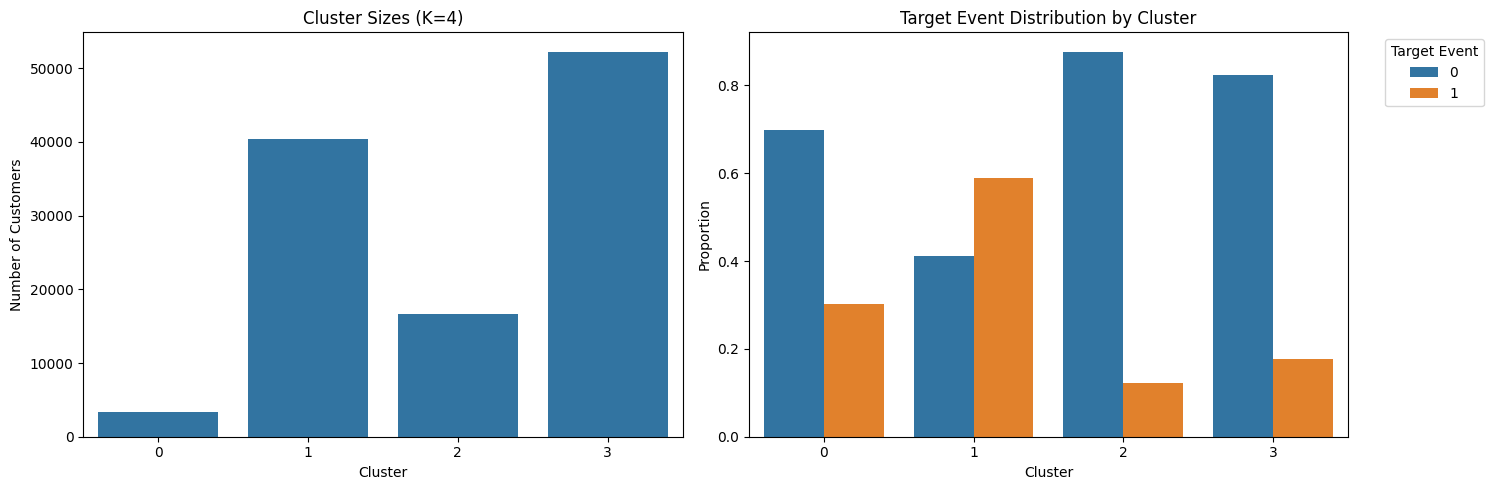

✓ Success: K=4, Features=48

--- Grid Search Experiment 46/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Manual K override: 5
Threshold (0.1, -0.1): 48 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 47179 customers (41.90%)
  Cluster 1: 12015 customers (10.67%)
  Cluster 2: 13899 customers (12.34%)
  Cluster 3: 36470 customers (32.39%)
  Cluster 4: 3047 customers (2.71%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.47              0.52          0.81        28.97
1         2.77              0.37          0.47       103.46
2       -11.46              0.60          0.86        13.91
3        -6.84              0.34          0.62        69.20
4        -3.40     

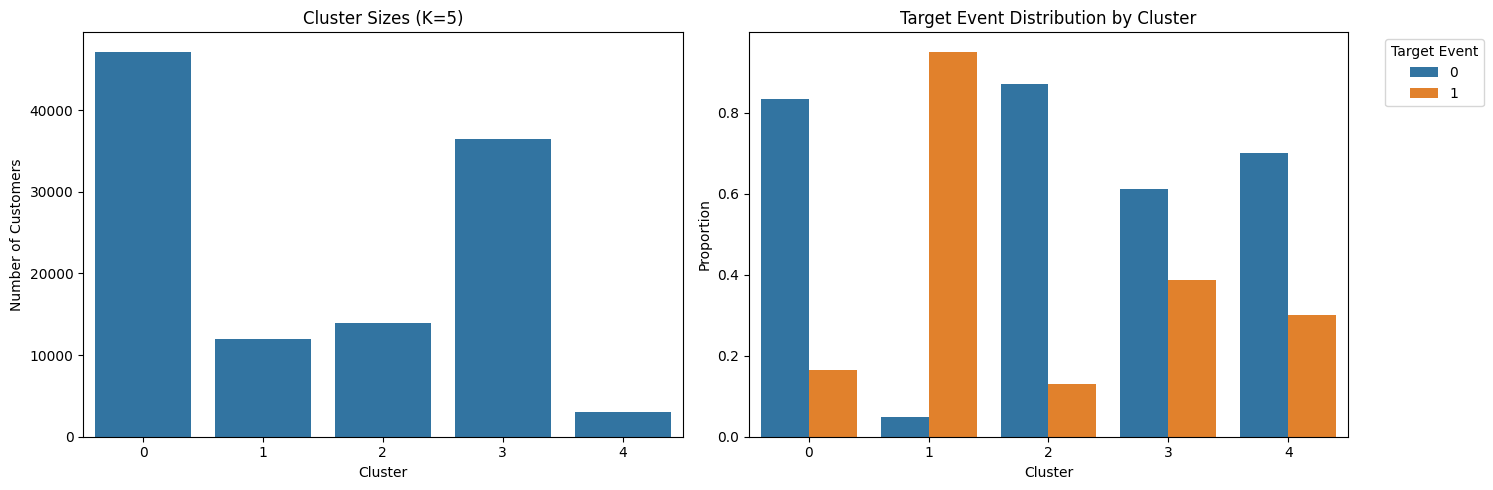

✓ Success: K=5, Features=48

--- Grid Search Experiment 47/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Manual K override: 6
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster 5: 1205 customers (1.07%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.1, -0.1): 48 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 43522 customers (38.65%)
  Cluster 1: 11697 customers (10.39%)
  Cluster 2: 13093 customers (11.63%)
  Cluster 3: 34198 customers (30.37%)
  Cluster 4: 8895 customers (7.90%)
  Cluster

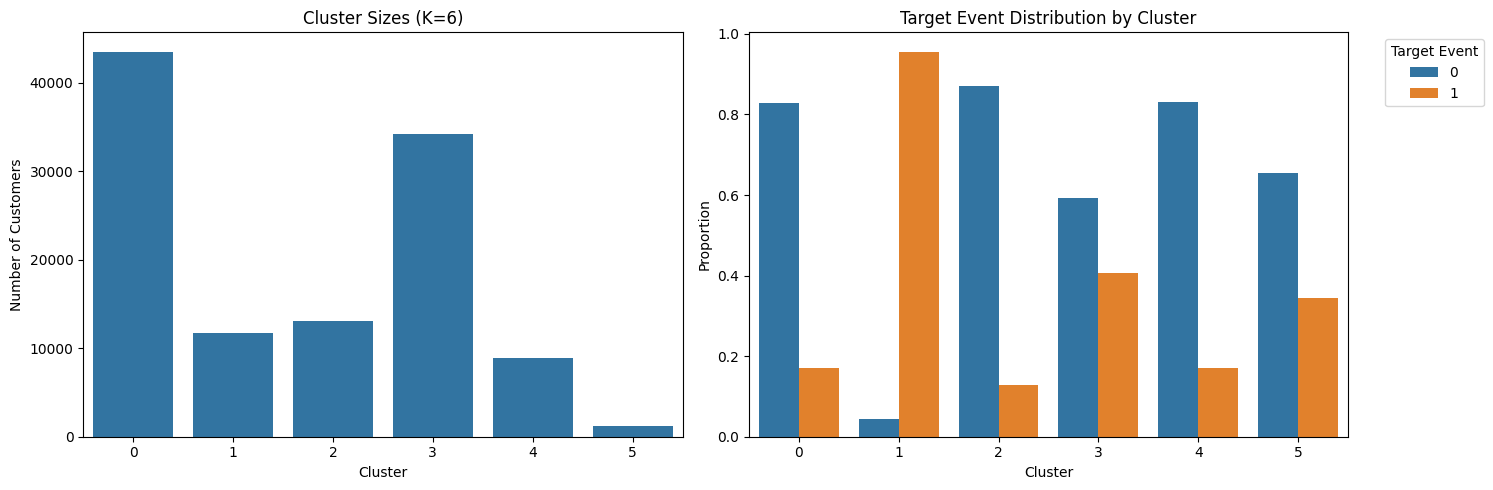

✓ Success: K=6, Features=48

--- Grid Search Experiment 48/144 ---

EXPERIMENT: threshold=(0.1, -0.1), n_init=auto, max_k=15
Manual K override: 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
Threshold (0.1, -0.1): 48 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 20503 customers (18.21%)
  Cluster 1: 26041 customers (23.12%)
  Cluster 2: 5949 customers (5.28%)
  Cluster 3: 40349 customers (35.83%)
  Cluster 4: 9184 customers (8.16%)
  Cluster 5: 1065 customers (0.95%)
  Cluster 6: 9519 customers (8.45%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.89              0.50          0.81        16.90
1        -1.16              0.36          0.57        94.15
2     

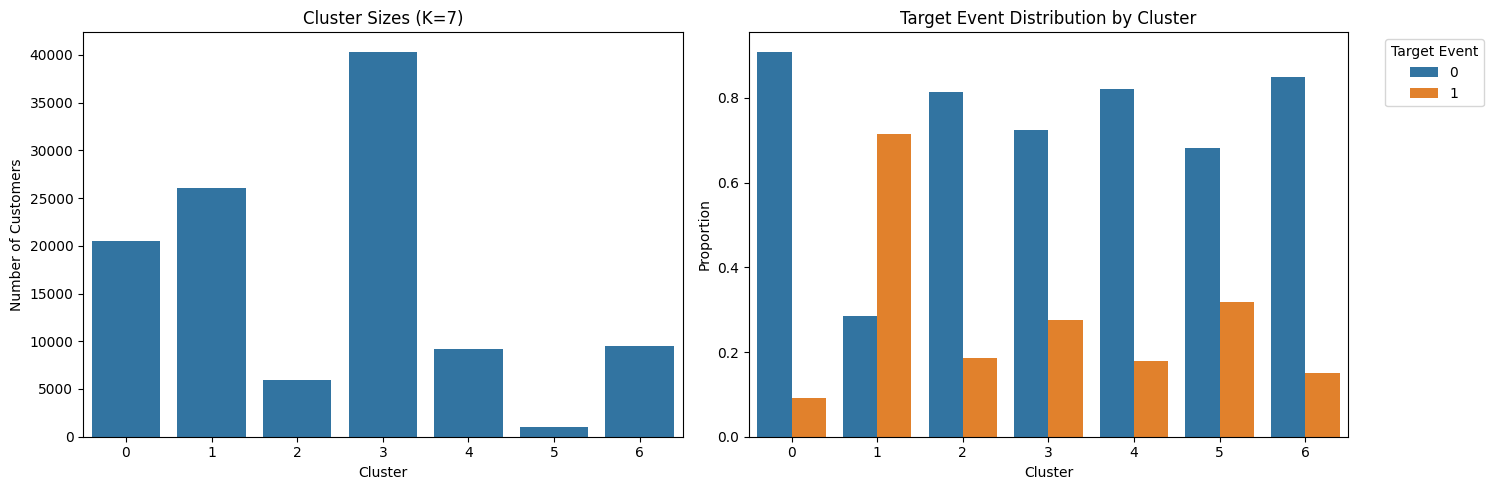

✓ Success: K=7, Features=48

--- Grid Search Experiment 49/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=8
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=8


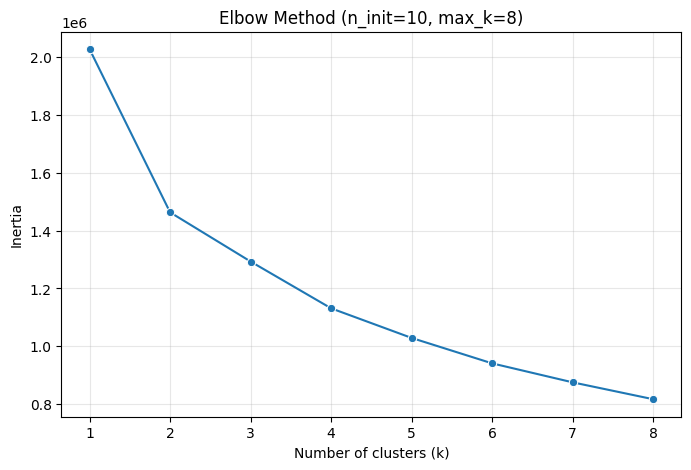

Rate of change analysis:
K=2, First diff=-563999.50, Second diff=393892.56
K=3, First diff=-170106.94, Second diff=8305.05
K=4, First diff=-161801.89, Second diff=59382.64
K=5, First diff=-102419.25, Second diff=14529.28
K=6, First diff=-87889.97, Second diff=22261.12
K=7, First diff=-65628.84, Second diff=7314.64
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 66836 customers (59.35%)
  Cluster 1: 45774 customers (40.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.86              0.54          0.83        27.35
1        -3.36              0.45          0.66        80.08

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0          

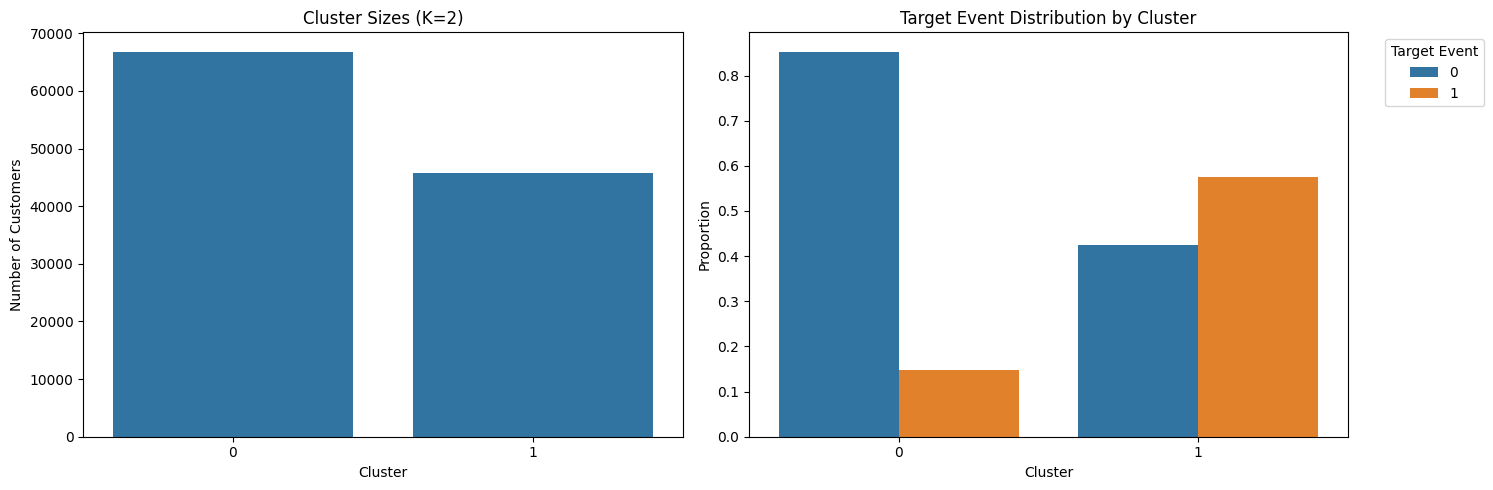

✓ Success: K=2, Features=18

--- Grid Search Experiment 50/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49712 customers (44.15%)
  Cluster 1: 48385 customers (42.97%)
  Cluster 2: 14513 customers (12.89%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1        -6.94              0.43          0.68        60.38
2         1.85              0.53          0.69       103.67

Target Event Distribution by Cluster:
target_event      0      1
cluster                   


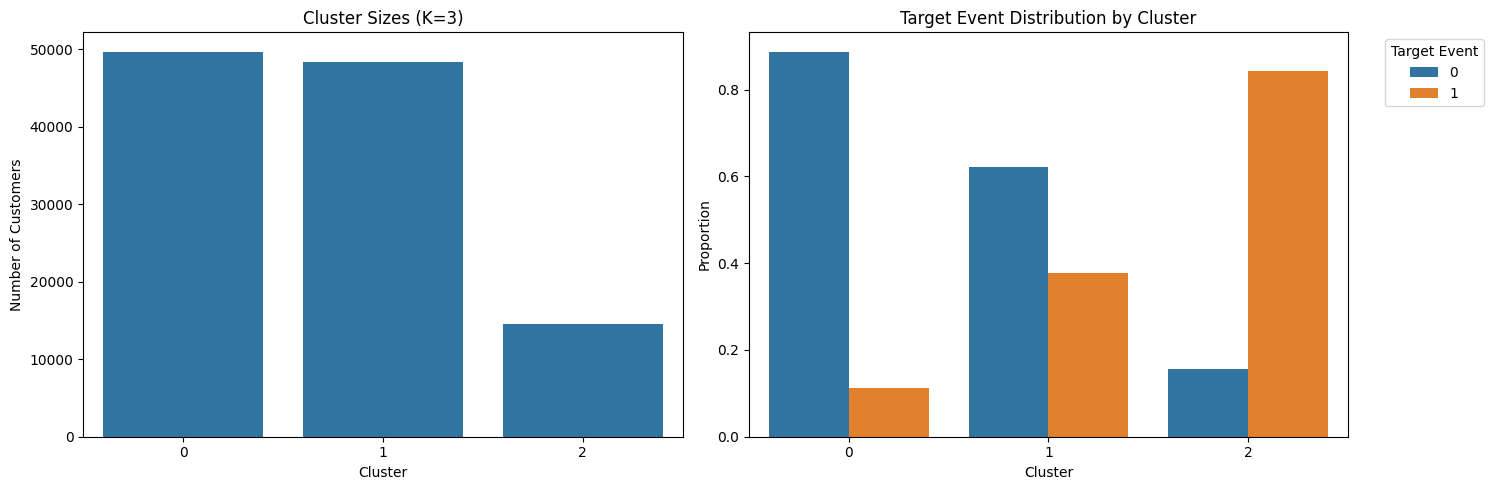

✓ Success: K=3, Features=18

--- Grid Search Experiment 51/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 11838 customers (10.51%)
  Cluster 1: 50381 customers (44.74%)
  Cluster 2: 3263 customers (2.90%)
  Cluster 3: 47128 customers (41.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0         2.25              0.31          0.44       108.67
1       -11.44              0.56          0.86        21.65
2        -2.94              1.69          1.96        65.99
3        -6.80              0.40          0.65        61.

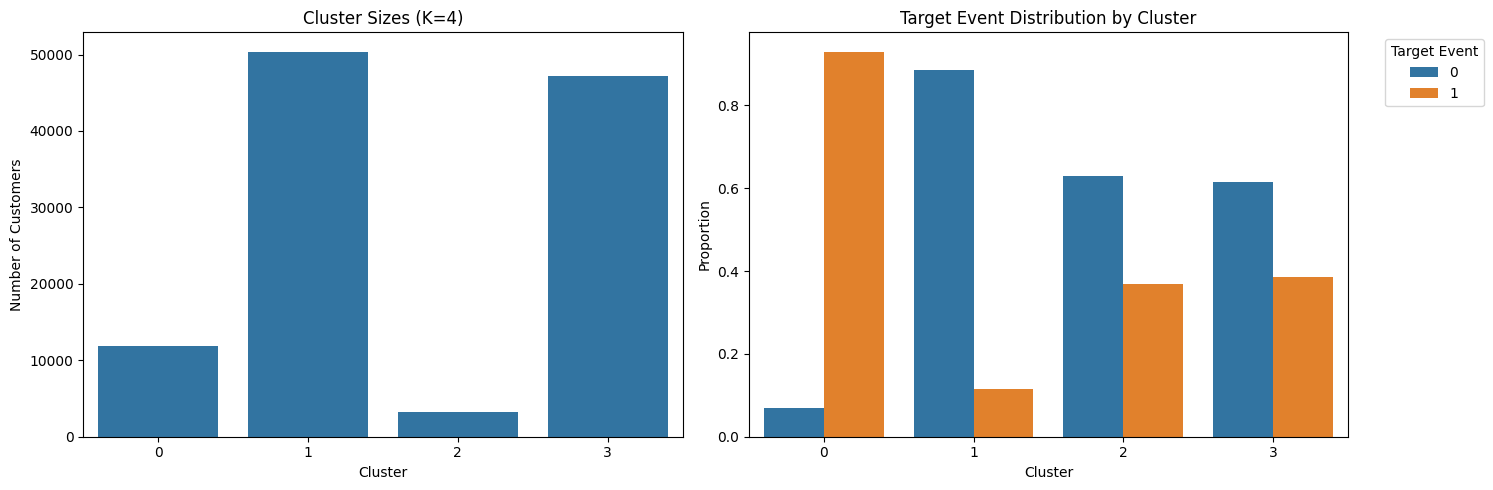

✓ Success: K=4, Features=18

--- Grid Search Experiment 52/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3188 customers (2.83%)
  Cluster 1: 11387 customers (10.11%)
  Cluster 2: 46753 customers (41.52%)
  Cluster 3: 6136 customers (5.45%)
  Cluster 4: 45146 customers (40.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -2.92              1.71          1.98        65.92
1         2.35              0.32          0.44       109.23
2       -11.36              0.57          0.86        23.42
3       -10.81       

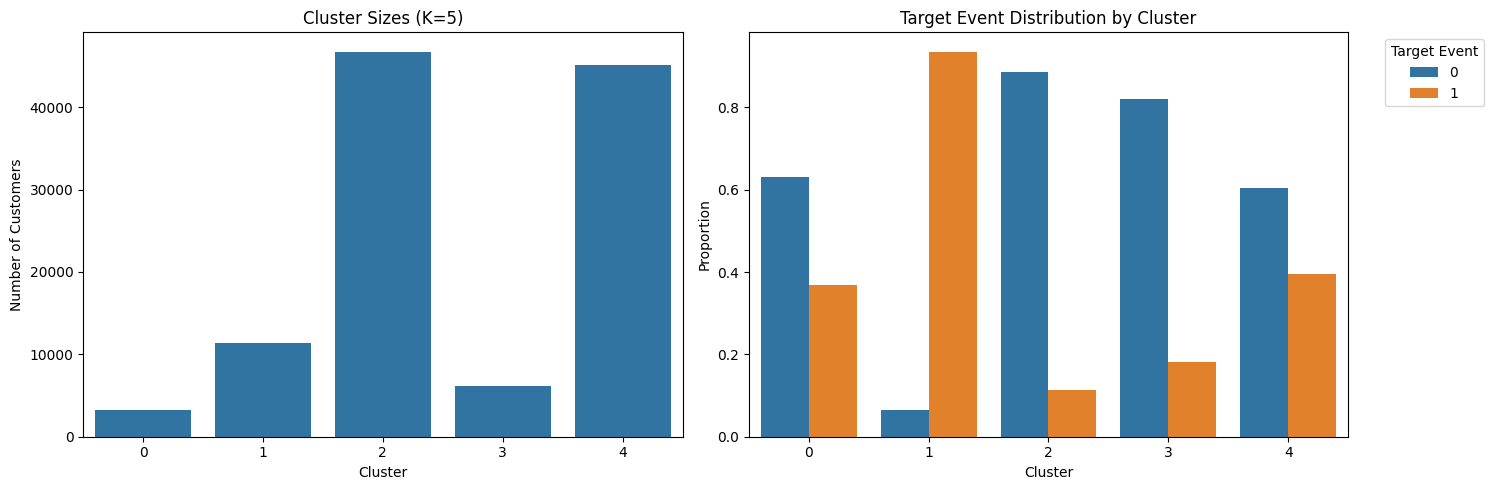

✓ Success: K=5, Features=18

--- Grid Search Experiment 53/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 21911 customers (19.46%)
  Cluster 1: 31505 customers (27.98%)
  Cluster 2: 40748 customers (36.19%)
  Cluster 3: 2827 customers (2.51%)
  Cluster 4: 9466 customers (8.41%)
  Cluster 5: 6153 customers (5.46%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.92              0.44          0.77        18.57
1        -5.37              0.34          0.59        74.22
2        -9.83              0.61          0.8

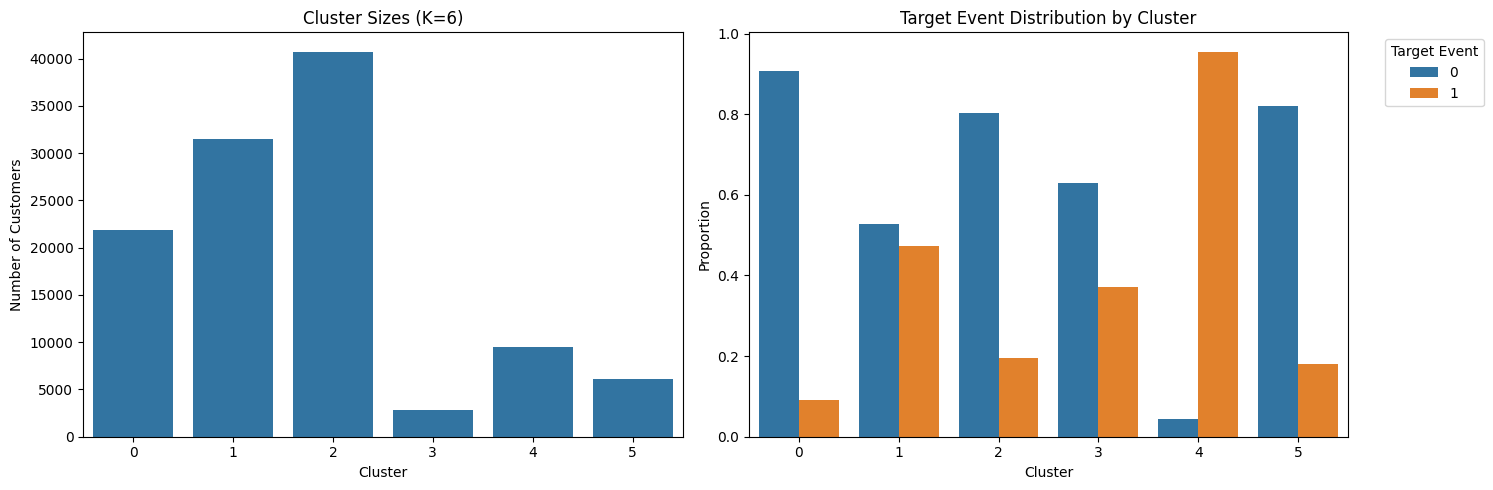

✓ Success: K=6, Features=18

--- Grid Search Experiment 54/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=8
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39812 customers (35.35%)
  Cluster 1: 5937 customers (5.27%)
  Cluster 2: 319 customers (0.28%)
  Cluster 3: 20770 customers (18.44%)
  Cluster 4: 30355 customers (26.96%)
  Cluster 5: 6154 customers (5.46%)
  Cluster 6: 9263 customers (8.23%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.96              0.61          0.86        33.34
1        -4.14              1.21          1.37        63.46
2         

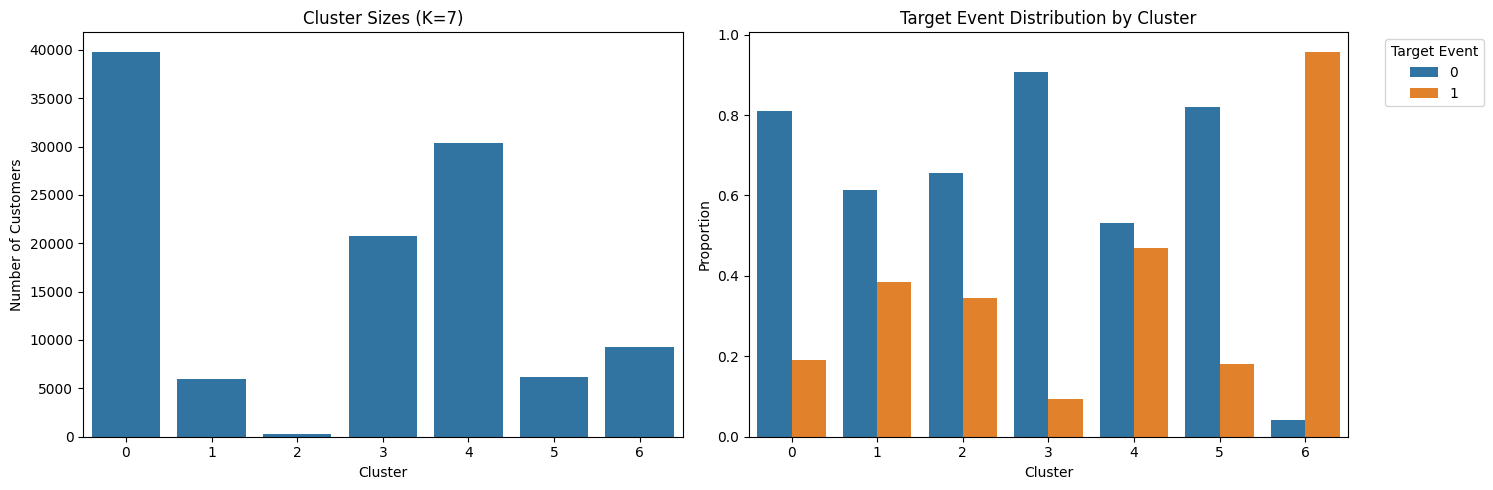

✓ Success: K=7, Features=18

--- Grid Search Experiment 55/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=10
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=10


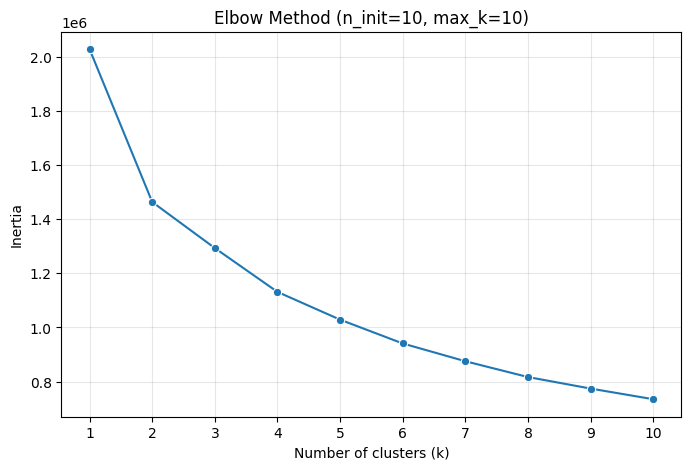

Rate of change analysis:
K=2, First diff=-563999.50, Second diff=393892.56
K=3, First diff=-170106.94, Second diff=8305.05
K=4, First diff=-161801.89, Second diff=59382.64
K=5, First diff=-102419.25, Second diff=14529.28
K=6, First diff=-87889.97, Second diff=22261.12
K=7, First diff=-65628.84, Second diff=7314.64
K=8, First diff=-58314.21, Second diff=15763.57
K=9, First diff=-42550.63, Second diff=3212.08
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 66836 customers (59.35%)
  Cluster 1: 45774 customers (40.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.86              0.54          0.83        27.35
1        -3.36              0.45          0.66        80.08

Target E

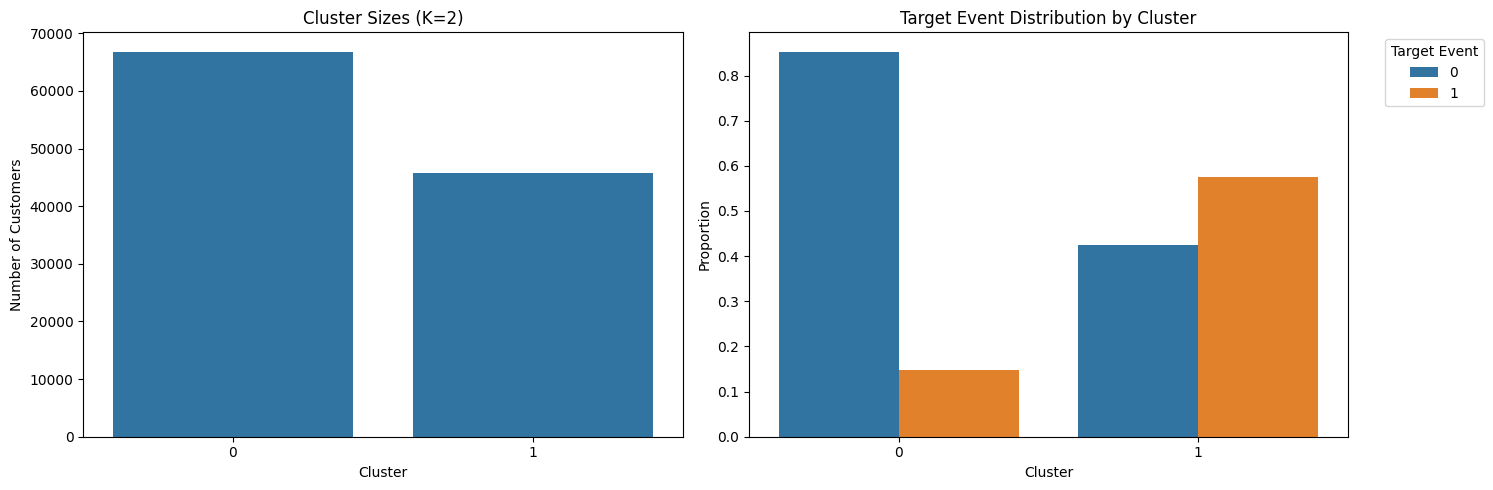

✓ Success: K=2, Features=18

--- Grid Search Experiment 56/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49712 customers (44.15%)
  Cluster 1: 48385 customers (42.97%)
  Cluster 2: 14513 customers (12.89%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1        -6.94              0.43          0.68        60.38
2         1.85              0.53          0.69       103.67

Target Event Distribution by Cluster:
target_event      0      1
cluster                   

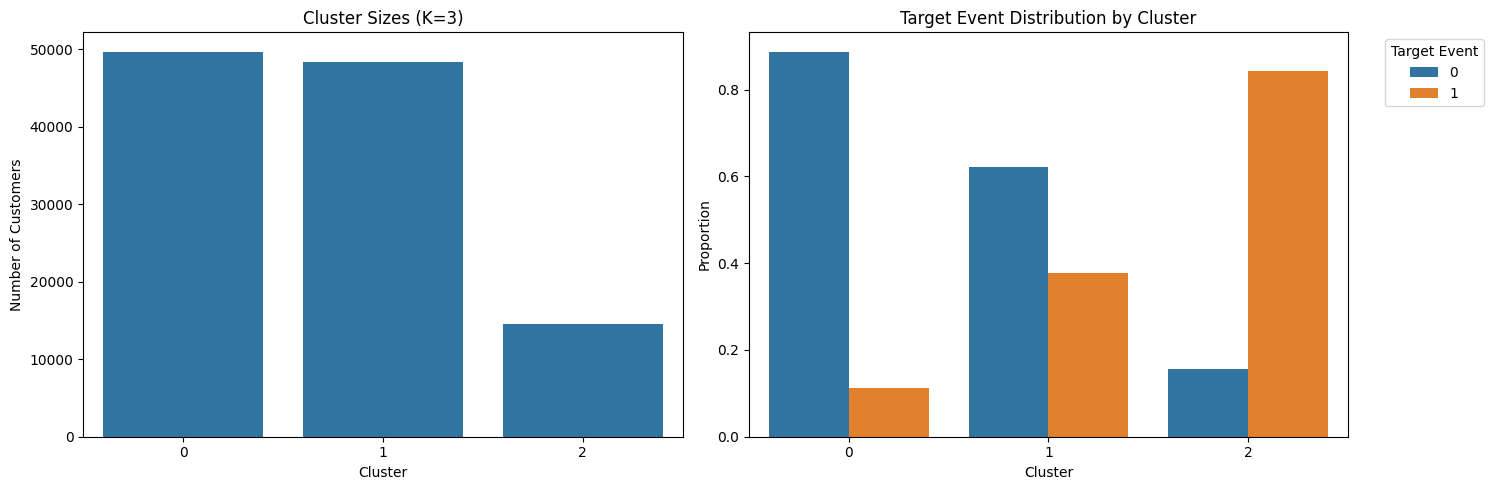

✓ Success: K=3, Features=18

--- Grid Search Experiment 57/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 11838 customers (10.51%)
  Cluster 1: 50381 customers (44.74%)
  Cluster 2: 3263 customers (2.90%)
  Cluster 3: 47128 customers (41.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0         2.25              0.31          0.44       108.67
1       -11.44              0.56          0.86        21.65
2        -2.94              1.69          1.96        65.99
3        -6.80              0.40          0.65        61

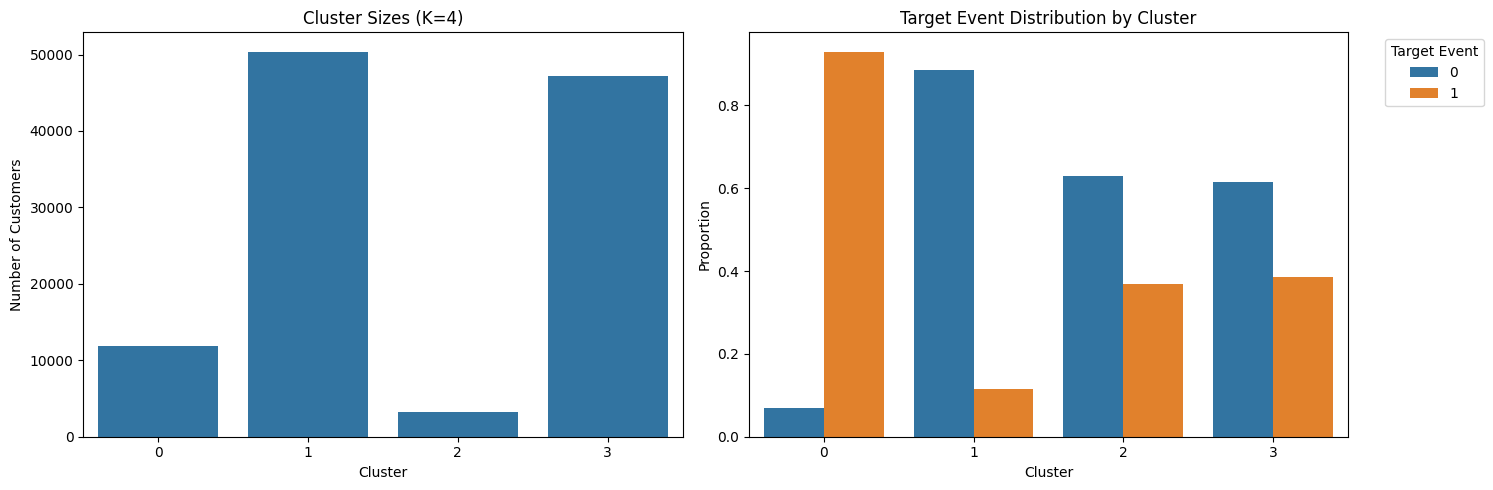

✓ Success: K=4, Features=18

--- Grid Search Experiment 58/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3188 customers (2.83%)
  Cluster 1: 11387 customers (10.11%)
  Cluster 2: 46753 customers (41.52%)
  Cluster 3: 6136 customers (5.45%)
  Cluster 4: 45146 customers (40.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -2.92              1.71          1.98        65.92
1         2.35              0.32          0.44       109.23
2       -11.36              0.57          0.86        23.42
3       -10.81      

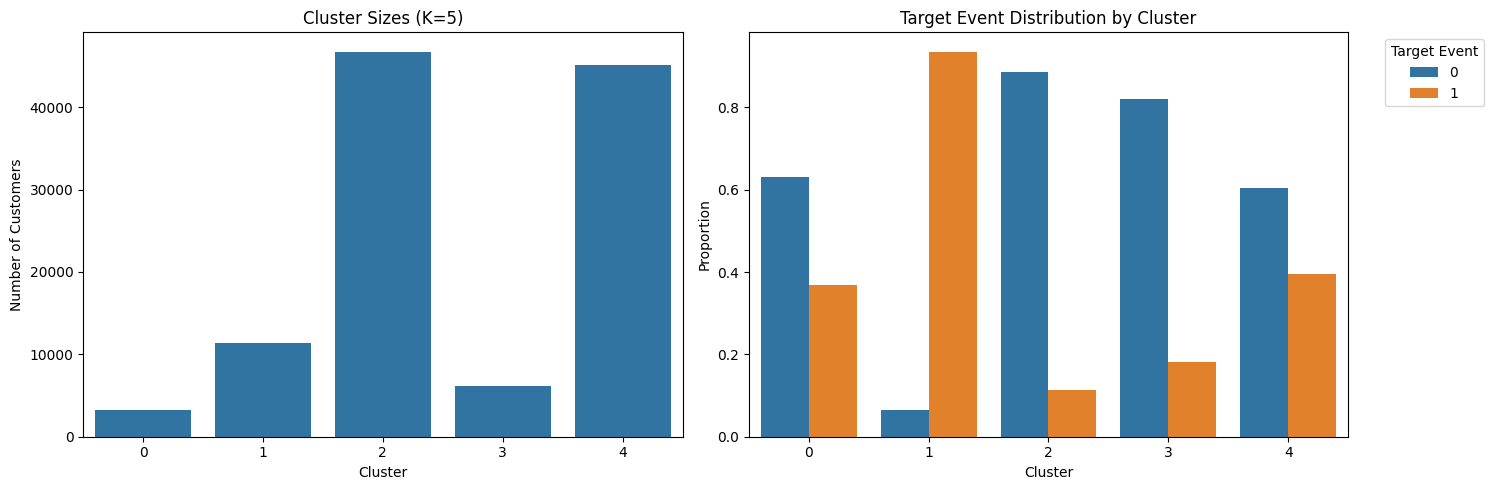

✓ Success: K=5, Features=18

--- Grid Search Experiment 59/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 21911 customers (19.46%)
  Cluster 1: 31505 customers (27.98%)
  Cluster 2: 40748 customers (36.19%)
  Cluster 3: 2827 customers (2.51%)
  Cluster 4: 9466 customers (8.41%)
  Cluster 5: 6153 customers (5.46%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.92              0.44          0.77        18.57
1        -5.37              0.34          0.59        74.22
2        -9.83              0.61          0.

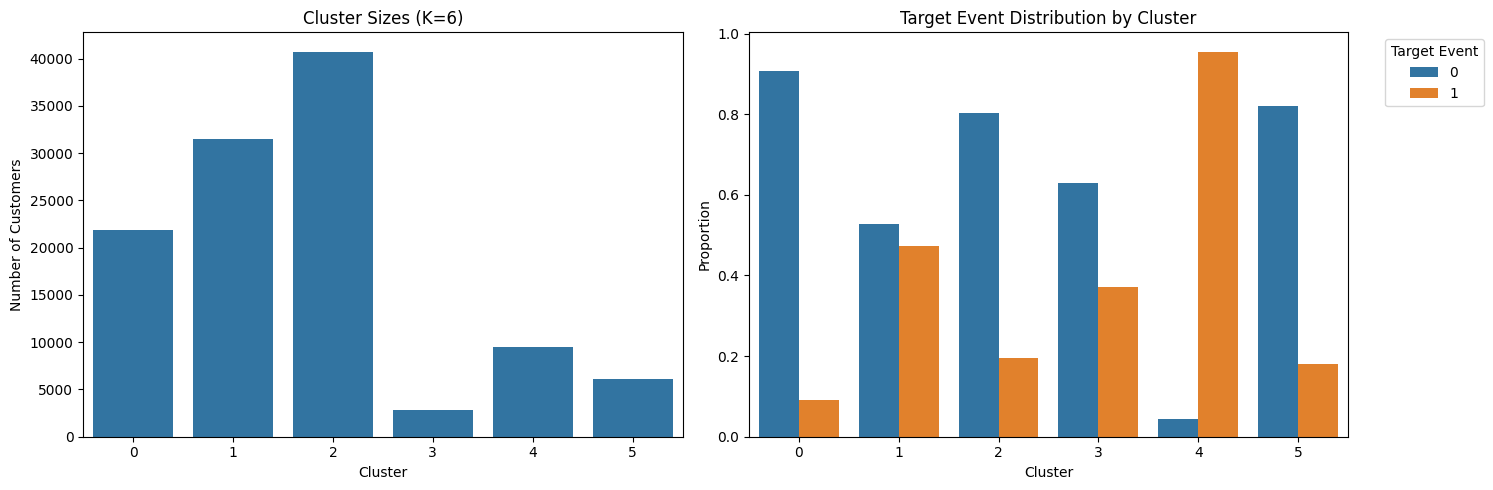

✓ Success: K=6, Features=18

--- Grid Search Experiment 60/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=10
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39812 customers (35.35%)
  Cluster 1: 5937 customers (5.27%)
  Cluster 2: 319 customers (0.28%)
  Cluster 3: 20770 customers (18.44%)
  Cluster 4: 30355 customers (26.96%)
  Cluster 5: 6154 customers (5.46%)
  Cluster 6: 9263 customers (8.23%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.96              0.61          0.86        33.34
1        -4.14              1.21          1.37        63.46
2        

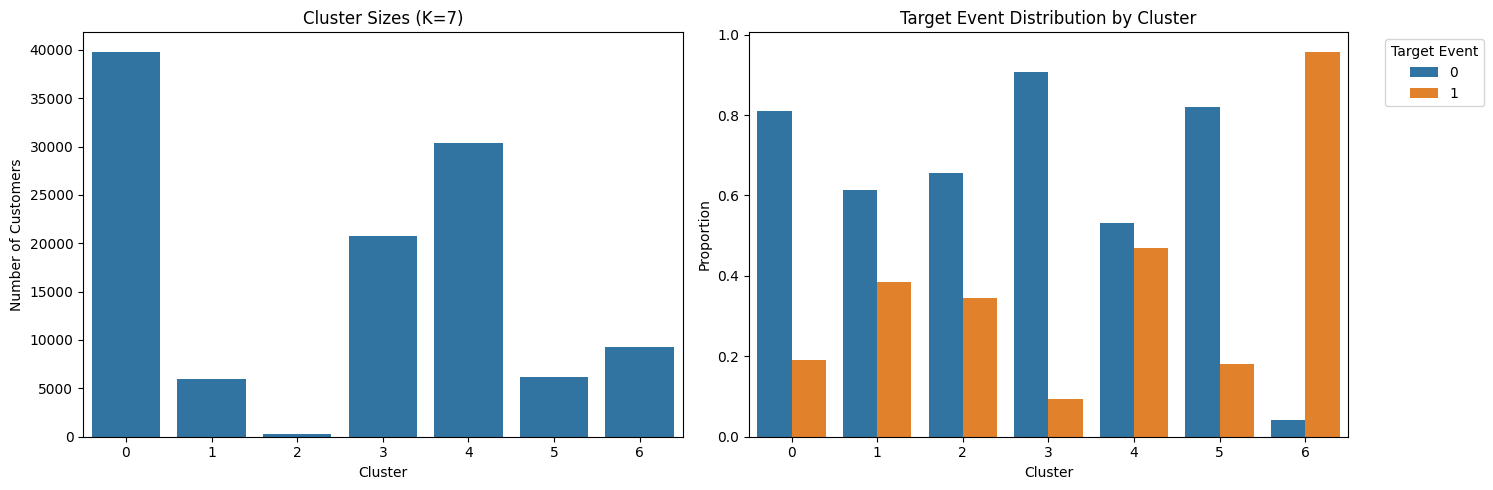

✓ Success: K=7, Features=18

--- Grid Search Experiment 61/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=12
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=12


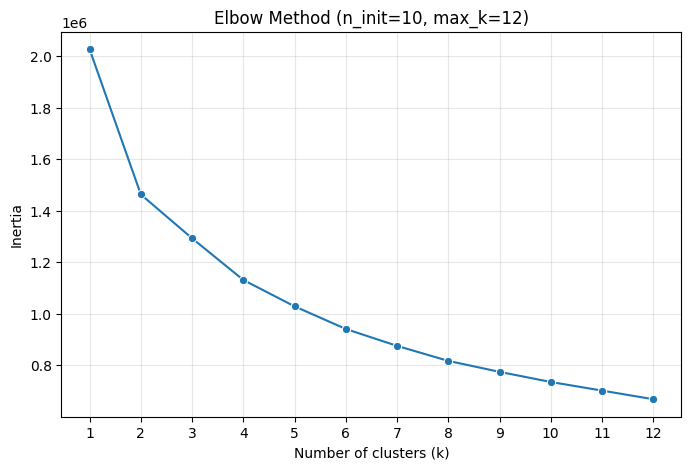

Rate of change analysis:
K=2, First diff=-563999.50, Second diff=393892.56
K=3, First diff=-170106.94, Second diff=8305.05
K=4, First diff=-161801.89, Second diff=59382.64
K=5, First diff=-102419.25, Second diff=14529.28
K=6, First diff=-87889.97, Second diff=22261.12
K=7, First diff=-65628.84, Second diff=7314.64
K=8, First diff=-58314.21, Second diff=15763.57
K=9, First diff=-42550.63, Second diff=3212.08
K=10, First diff=-39338.55, Second diff=5937.59
K=11, First diff=-33400.96, Second diff=-162.75
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 66836 customers (59.35%)
  Cluster 1: 45774 customers (40.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.86              0.54 

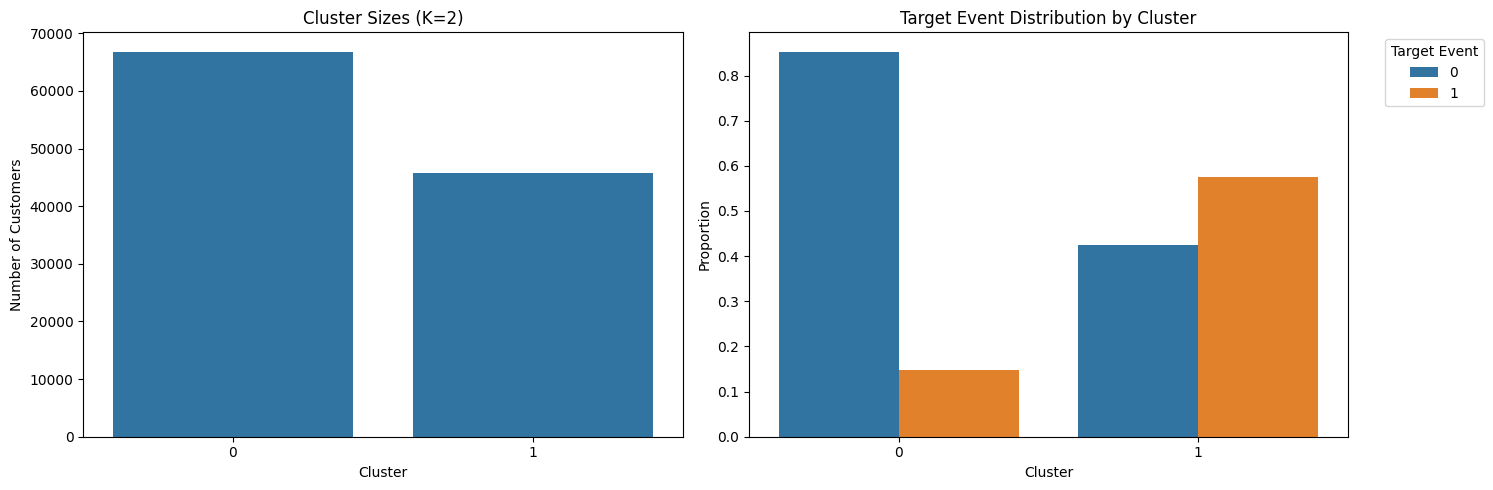

✓ Success: K=2, Features=18

--- Grid Search Experiment 62/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49712 customers (44.15%)
  Cluster 1: 48385 customers (42.97%)
  Cluster 2: 14513 customers (12.89%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1        -6.94              0.43          0.68        60.38
2         1.85              0.53          0.69       103.67

Target Event Distribution by Cluster:
target_event      0      1
cluster                   

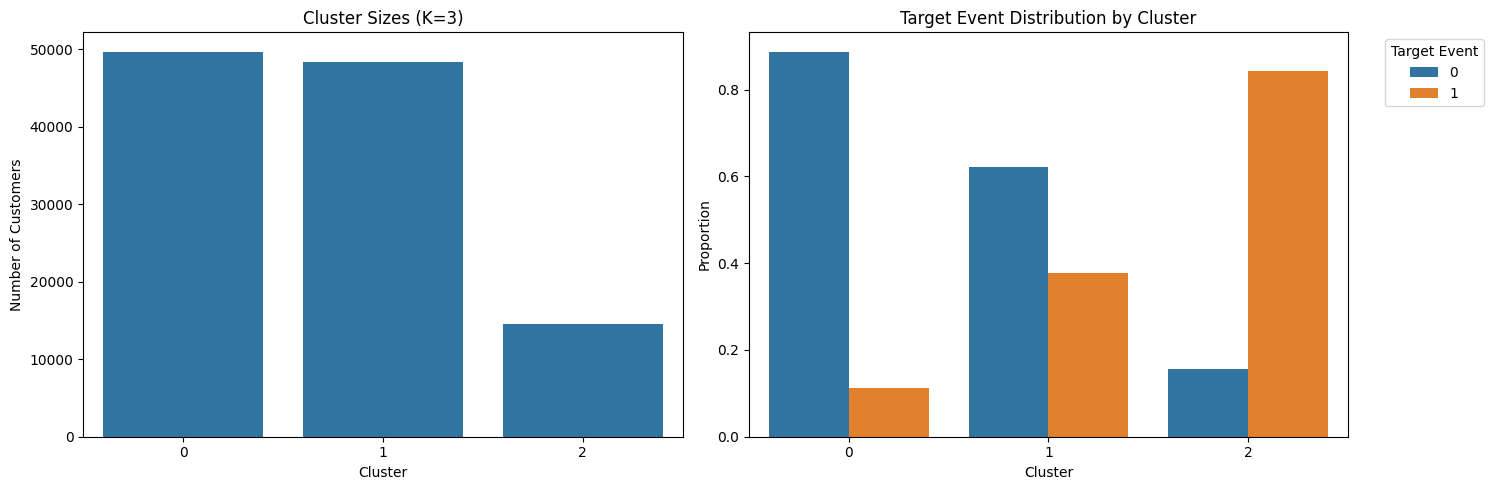

✓ Success: K=3, Features=18

--- Grid Search Experiment 63/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 11838 customers (10.51%)
  Cluster 1: 50381 customers (44.74%)
  Cluster 2: 3263 customers (2.90%)
  Cluster 3: 47128 customers (41.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0         2.25              0.31          0.44       108.67
1       -11.44              0.56          0.86        21.65
2        -2.94              1.69          1.96        65.99
3        -6.80              0.40          0.65        61

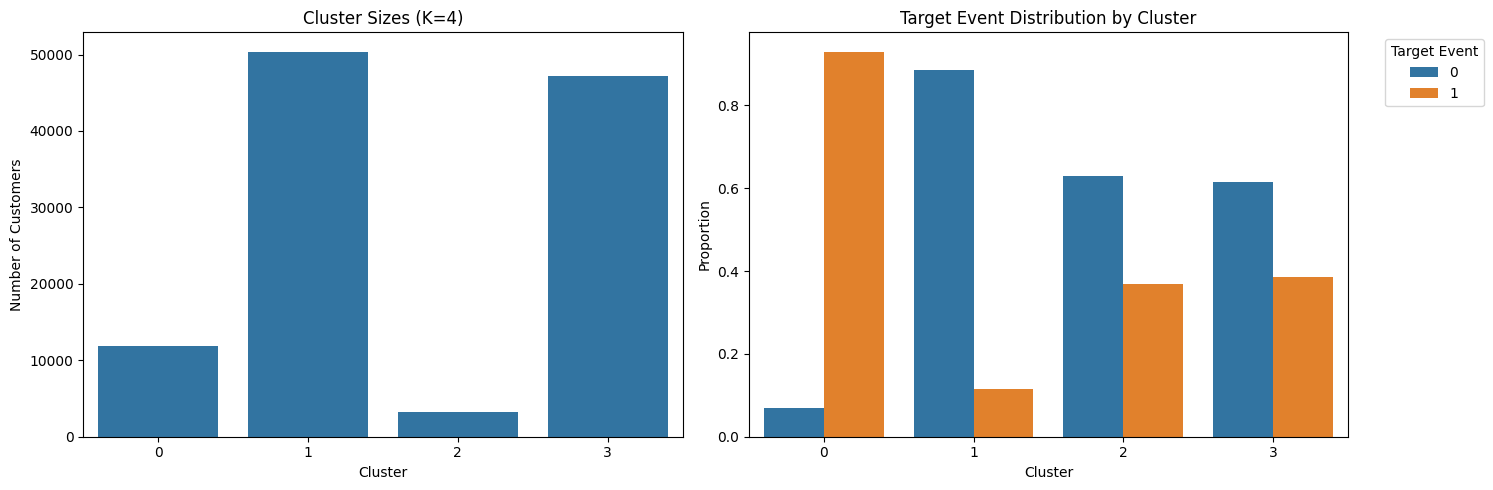

✓ Success: K=4, Features=18

--- Grid Search Experiment 64/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3188 customers (2.83%)
  Cluster 1: 11387 customers (10.11%)
  Cluster 2: 46753 customers (41.52%)
  Cluster 3: 6136 customers (5.45%)
  Cluster 4: 45146 customers (40.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -2.92              1.71          1.98        65.92
1         2.35              0.32          0.44       109.23
2       -11.36              0.57          0.86        23.42
3       -10.81      

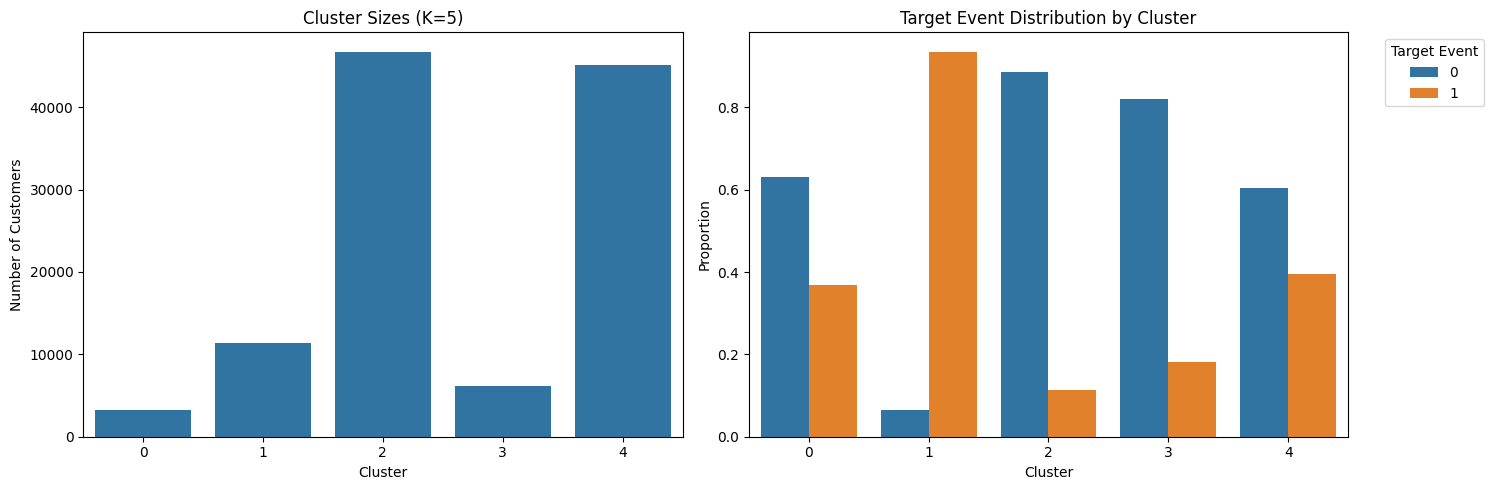

✓ Success: K=5, Features=18

--- Grid Search Experiment 65/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 21911 customers (19.46%)
  Cluster 1: 31505 customers (27.98%)
  Cluster 2: 40748 customers (36.19%)
  Cluster 3: 2827 customers (2.51%)
  Cluster 4: 9466 customers (8.41%)
  Cluster 5: 6153 customers (5.46%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.92              0.44          0.77        18.57
1        -5.37              0.34          0.59        74.22
2        -9.83              0.61          0.

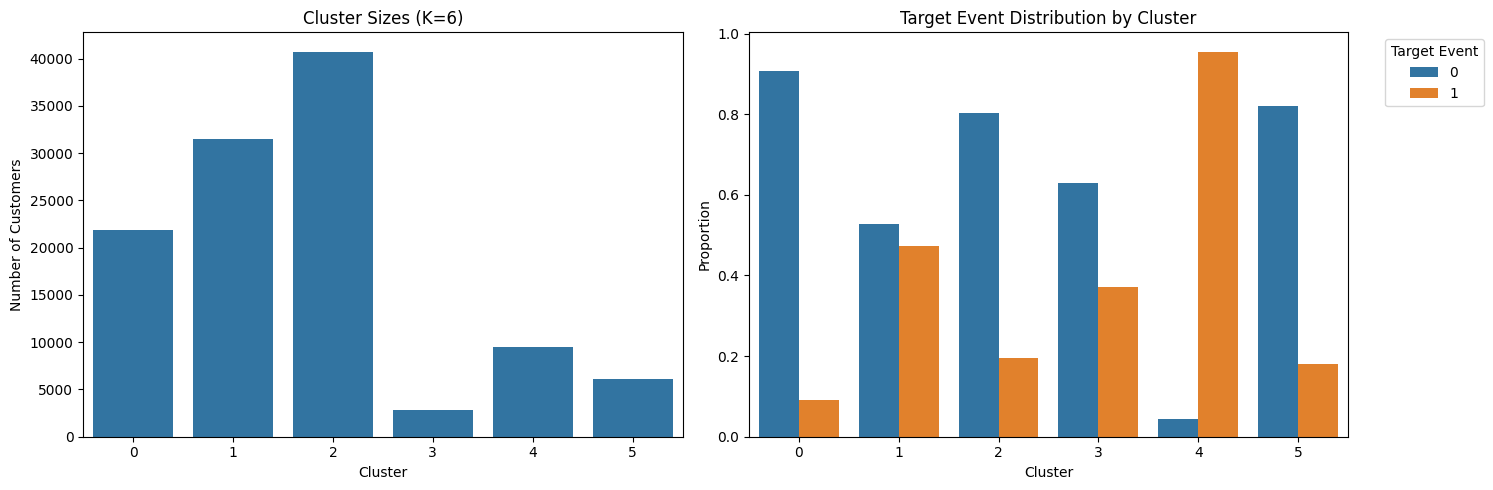

✓ Success: K=6, Features=18

--- Grid Search Experiment 66/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=12
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39812 customers (35.35%)
  Cluster 1: 5937 customers (5.27%)
  Cluster 2: 319 customers (0.28%)
  Cluster 3: 20770 customers (18.44%)
  Cluster 4: 30355 customers (26.96%)
  Cluster 5: 6154 customers (5.46%)
  Cluster 6: 9263 customers (8.23%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.96              0.61          0.86        33.34
1        -4.14              1.21          1.37        63.46
2        

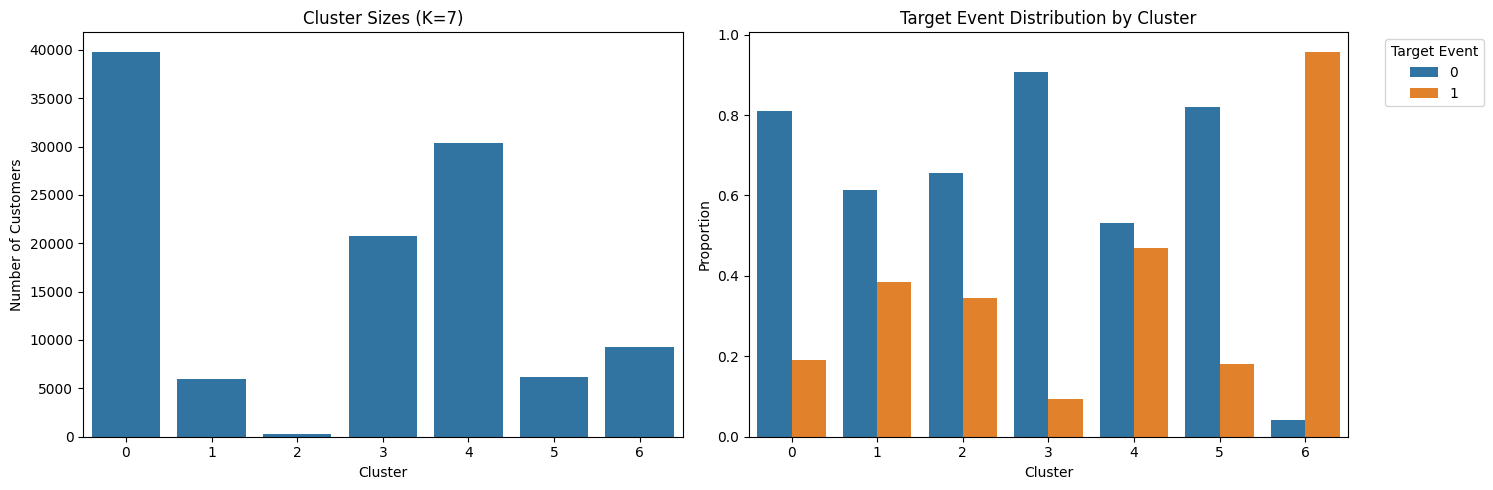

✓ Success: K=7, Features=18

--- Grid Search Experiment 67/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=15
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=10, max_k=15


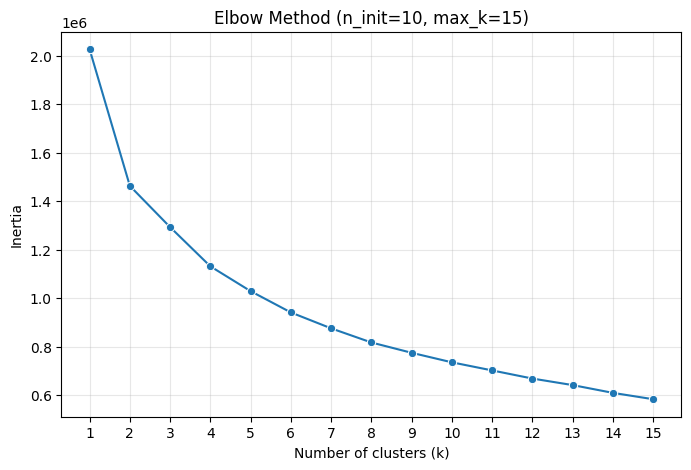

Rate of change analysis:
K=2, First diff=-563999.50, Second diff=393892.56
K=3, First diff=-170106.94, Second diff=8305.05
K=4, First diff=-161801.89, Second diff=59382.64
K=5, First diff=-102419.25, Second diff=14529.28
K=6, First diff=-87889.97, Second diff=22261.12
K=7, First diff=-65628.84, Second diff=7314.64
K=8, First diff=-58314.21, Second diff=15763.57
K=9, First diff=-42550.63, Second diff=3212.08
K=10, First diff=-39338.55, Second diff=5937.59
K=11, First diff=-33400.96, Second diff=-162.75
K=12, First diff=-33563.71, Second diff=6583.06
K=13, First diff=-26980.65, Second diff=-5121.12
K=14, First diff=-32101.77, Second diff=5927.28
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 66836 customers (59.35%)
  Cluster 1: 45774 customers (40.65%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Ana

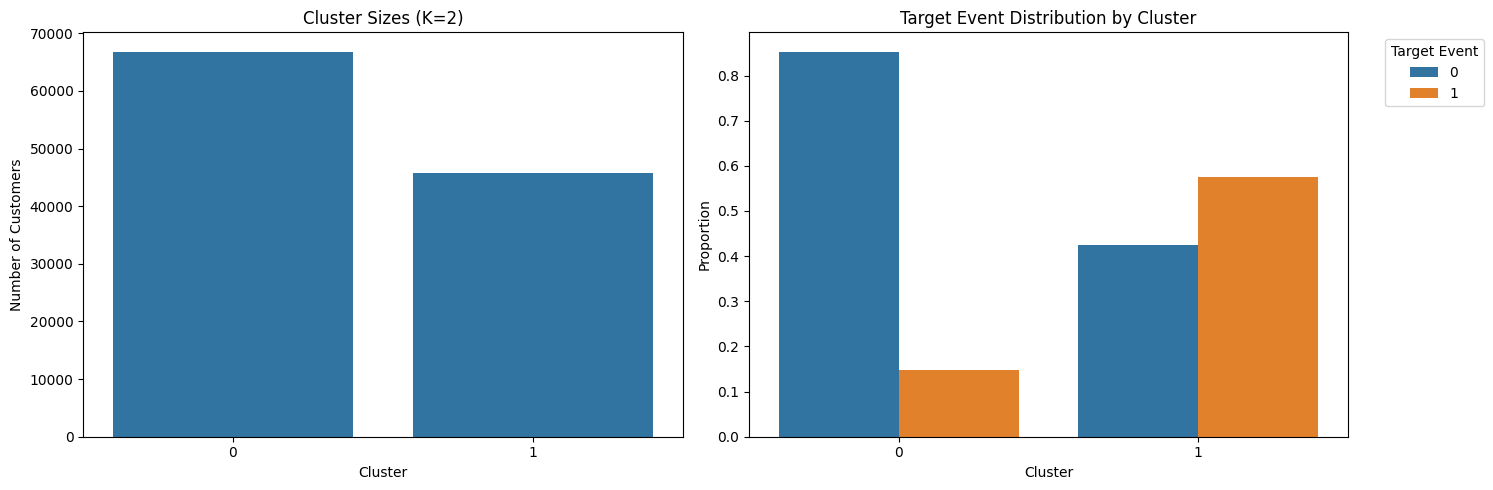

✓ Success: K=2, Features=18

--- Grid Search Experiment 68/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49712 customers (44.15%)
  Cluster 1: 48385 customers (42.97%)
  Cluster 2: 14513 customers (12.89%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1        -6.94              0.43          0.68        60.38
2         1.85              0.53          0.69       103.67

Target Event Distribution by Cluster:
target_event      0      1
cluster                   

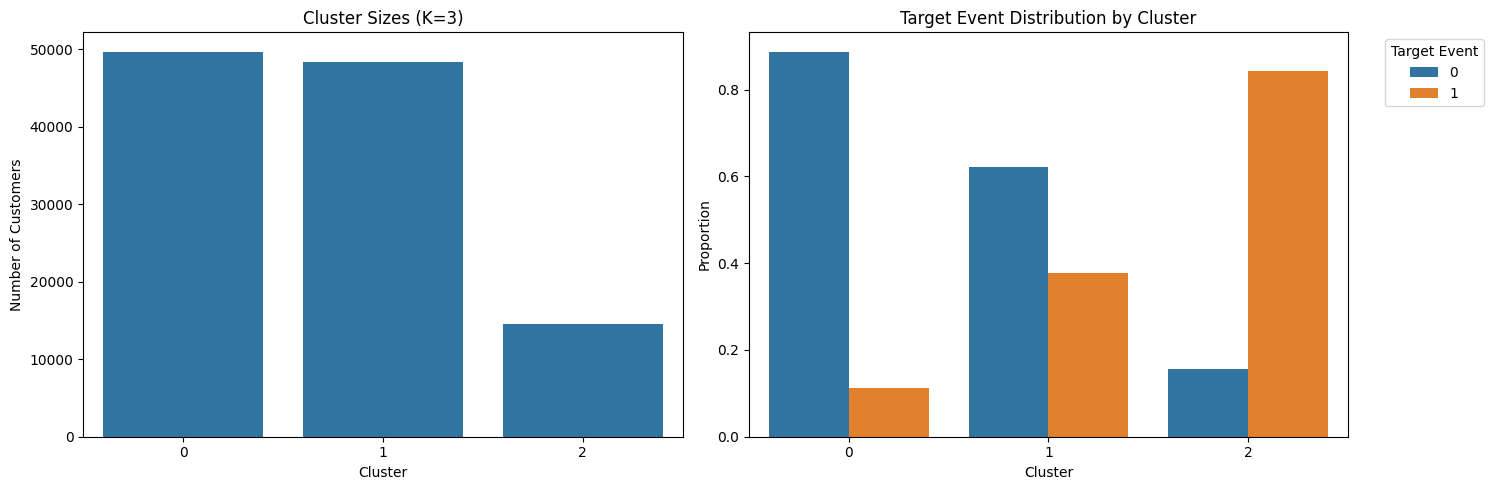

✓ Success: K=3, Features=18

--- Grid Search Experiment 69/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 11838 customers (10.51%)
  Cluster 1: 50381 customers (44.74%)
  Cluster 2: 3263 customers (2.90%)
  Cluster 3: 47128 customers (41.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0         2.25              0.31          0.44       108.67
1       -11.44              0.56          0.86        21.65
2        -2.94              1.69          1.96        65.99
3        -6.80              0.40          0.65        61

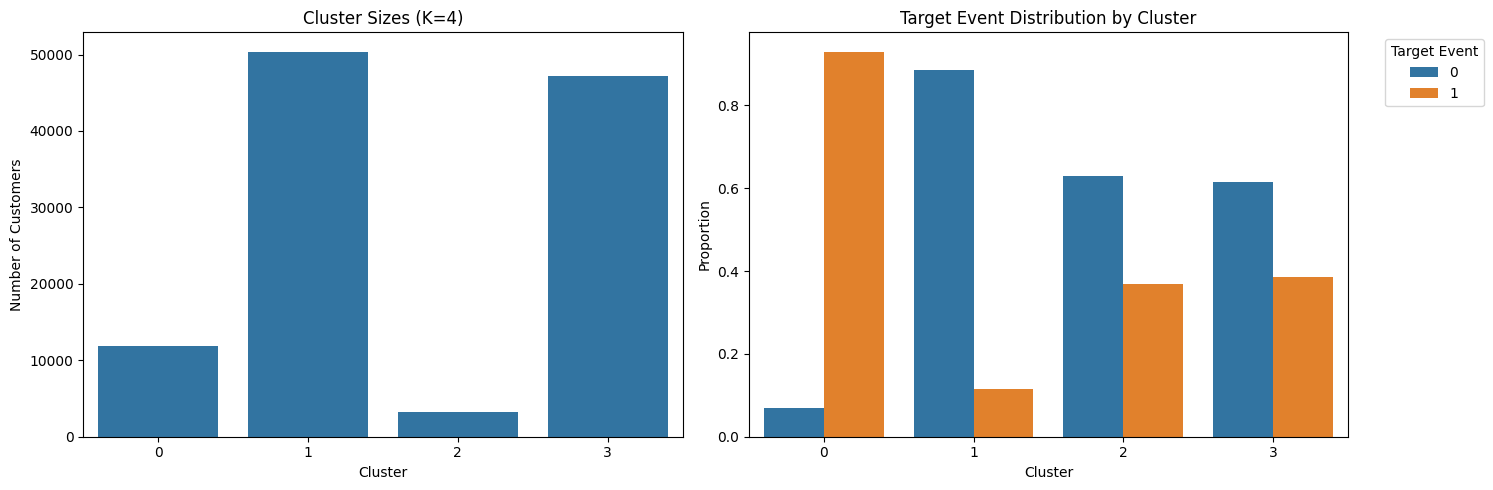

✓ Success: K=4, Features=18

--- Grid Search Experiment 70/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 3188 customers (2.83%)
  Cluster 1: 11387 customers (10.11%)
  Cluster 2: 46753 customers (41.52%)
  Cluster 3: 6136 customers (5.45%)
  Cluster 4: 45146 customers (40.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -2.92              1.71          1.98        65.92
1         2.35              0.32          0.44       109.23
2       -11.36              0.57          0.86        23.42
3       -10.81      

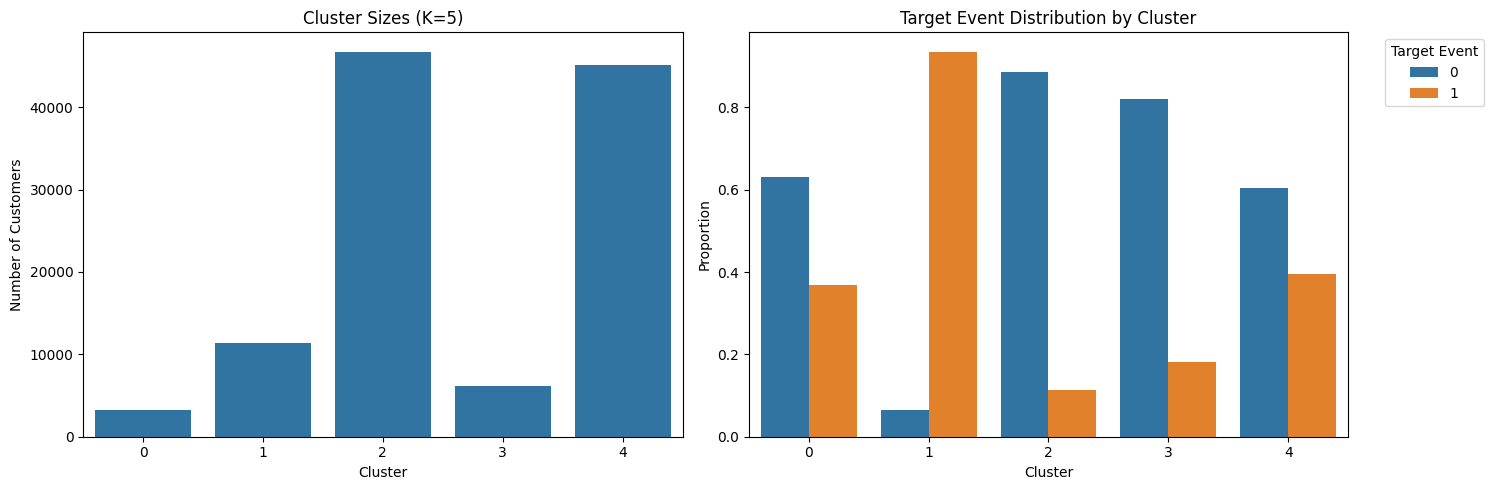

✓ Success: K=5, Features=18

--- Grid Search Experiment 71/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 21911 customers (19.46%)
  Cluster 1: 31505 customers (27.98%)
  Cluster 2: 40748 customers (36.19%)
  Cluster 3: 2827 customers (2.51%)
  Cluster 4: 9466 customers (8.41%)
  Cluster 5: 6153 customers (5.46%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.92              0.44          0.77        18.57
1        -5.37              0.34          0.59        74.22
2        -9.83              0.61          0.

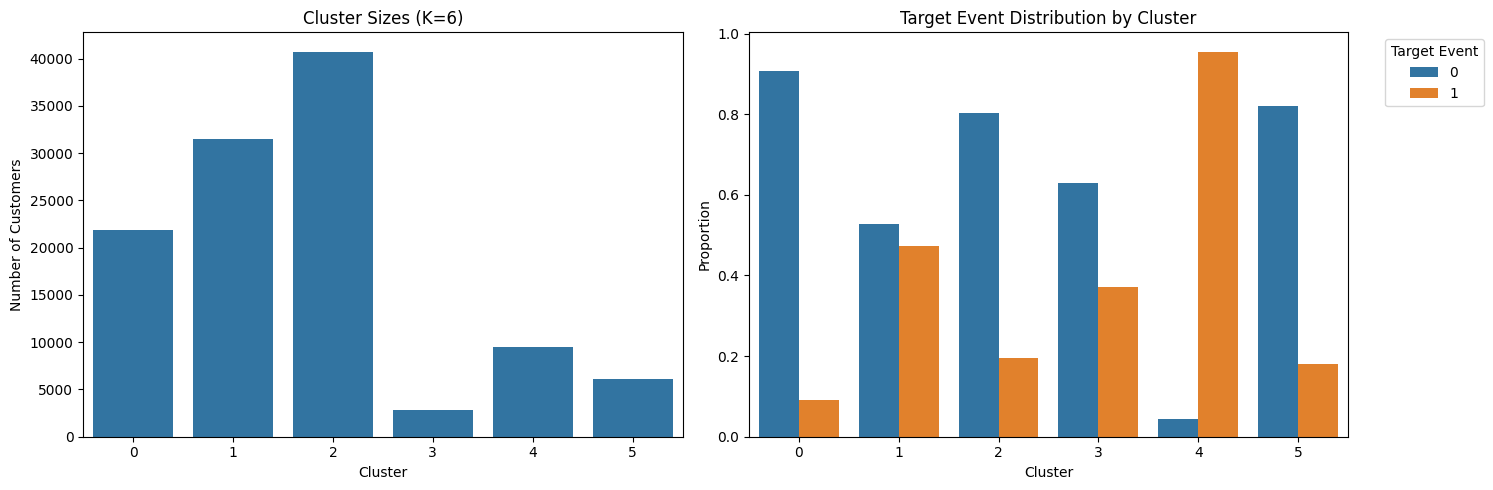

✓ Success: K=6, Features=18

--- Grid Search Experiment 72/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=10, max_k=15
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39812 customers (35.35%)
  Cluster 1: 5937 customers (5.27%)
  Cluster 2: 319 customers (0.28%)
  Cluster 3: 20770 customers (18.44%)
  Cluster 4: 30355 customers (26.96%)
  Cluster 5: 6154 customers (5.46%)
  Cluster 6: 9263 customers (8.23%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.96              0.61          0.86        33.34
1        -4.14              1.21          1.37        63.46
2        

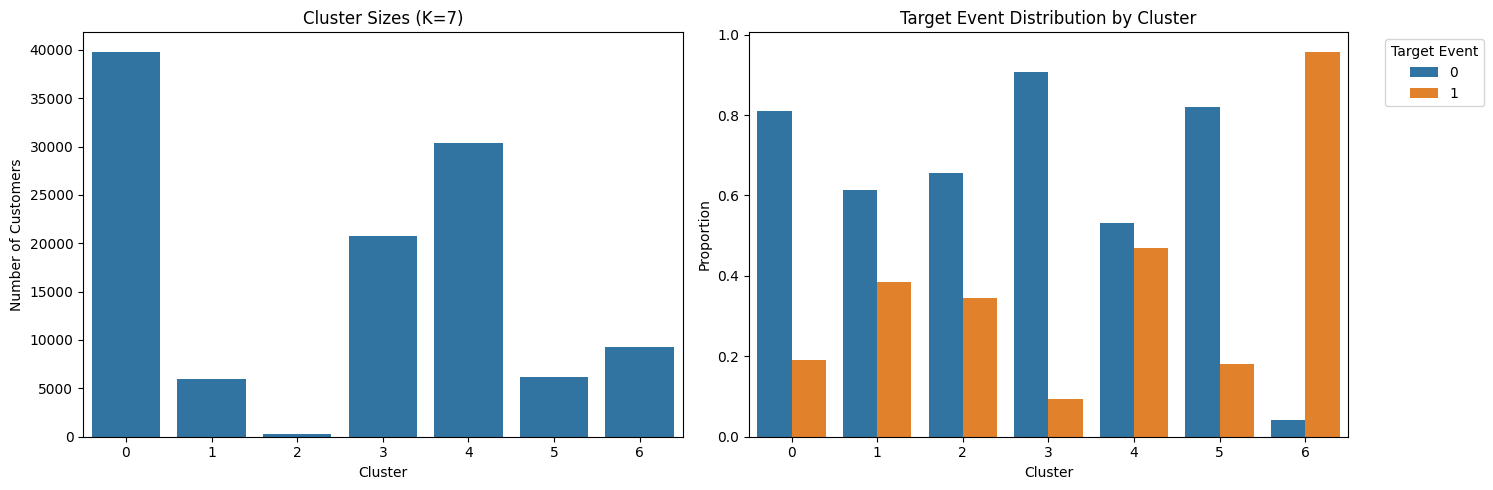

✓ Success: K=7, Features=18

--- Grid Search Experiment 73/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=8
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=8


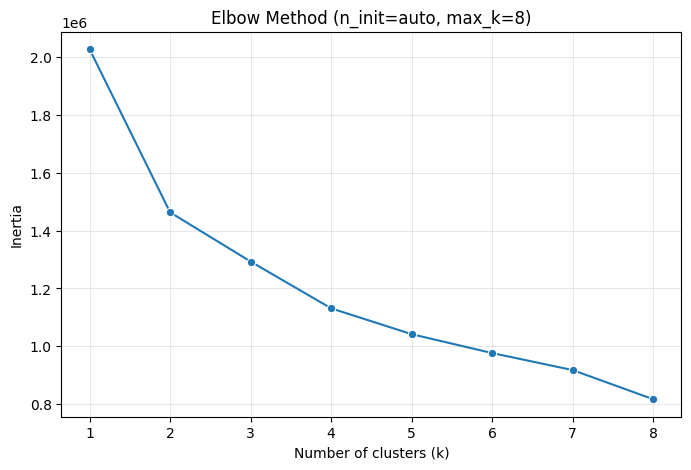

Rate of change analysis:
K=2, First diff=-563997.06, Second diff=393888.06
K=3, First diff=-170109.00, Second diff=8309.11
K=4, First diff=-161799.89, Second diff=72481.85
K=5, First diff=-89318.04, Second diff=24023.27
K=6, First diff=-65294.76, Second diff=6408.70
K=7, First diff=-58886.06, Second diff=-41824.19
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 46018 customers (40.86%)
  Cluster 1: 66592 customers (59.14%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.38              0.45          0.66        79.93
1       -10.88              0.54          0.83        27.26

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0          

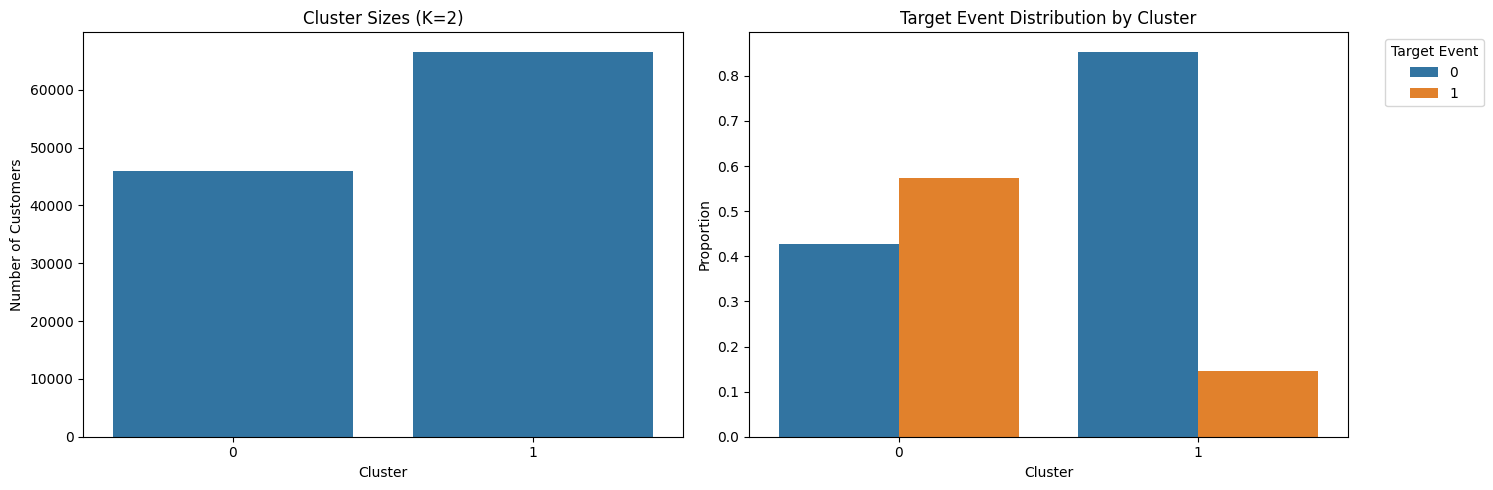

✓ Success: K=2, Features=18

--- Grid Search Experiment 74/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49719 customers (44.15%)
  Cluster 1: 14509 customers (12.88%)
  Cluster 2: 48382 customers (42.96%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1         1.85              0.53          0.69       103.67
2        -6.94              0.43          0.68        60.39

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.887  0.113
1             0.156  0.844
2      

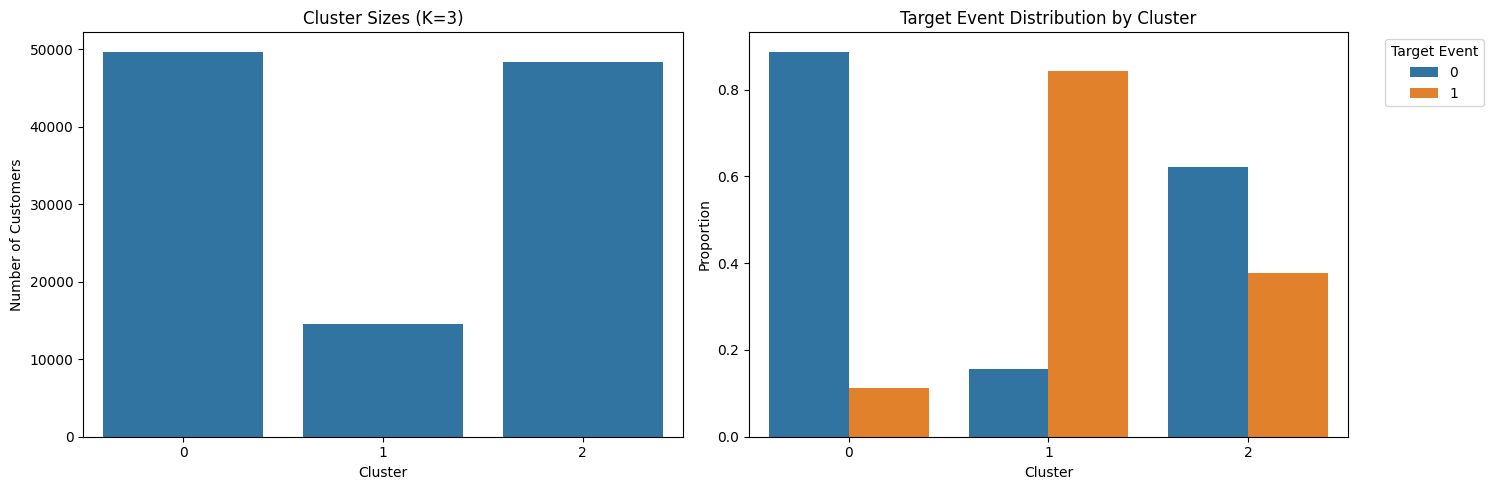

✓ Success: K=3, Features=18

--- Grid Search Experiment 75/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50178 customers (44.56%)
  Cluster 1: 11889 customers (10.56%)
  Cluster 2: 47199 customers (41.91%)
  Cluster 3: 3344 customers (2.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50178 customers (44.56%)
  Cluster 1: 11889 customers (10.56%)
  Cluster 2: 47199 customers (41.91%)
  Cluster 3: 3344 customers (2.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using

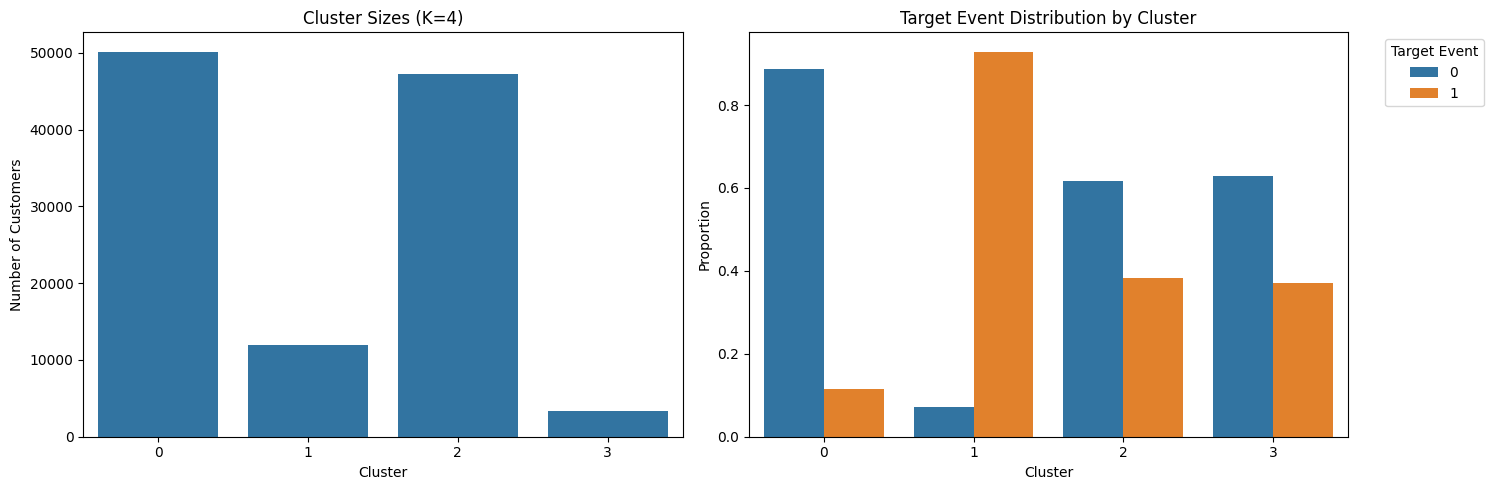

✓ Success: K=4, Features=18

--- Grid Search Experiment 76/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 40790 customers (36.22%)
  Cluster 1: 9326 customers (8.28%)
  Cluster 2: 28315 customers (25.14%)
  Cluster 3: 2819 customers (2.50%)
  Cluster 4: 31360 customers (27.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.27              0.57          0.82        38.20
1         2.66              0.31          0.43       111.46
2        -5.22              0.33          0.58        76.66
3        -2.73              1.77          2.06        66.02
4       -11.84        

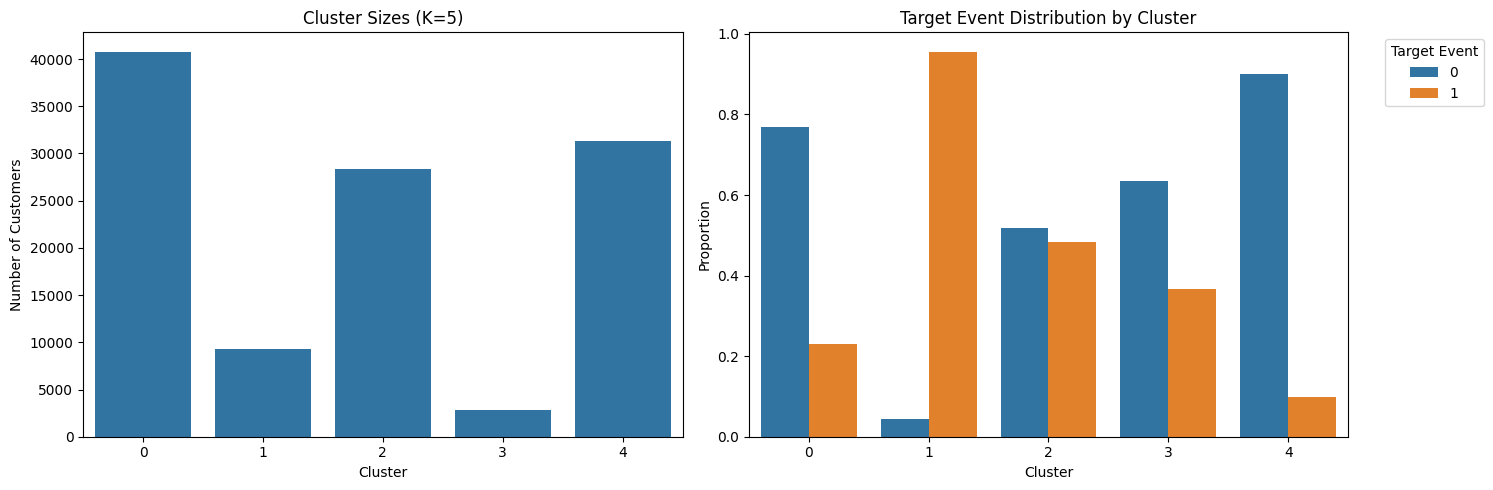

✓ Success: K=5, Features=18

--- Grid Search Experiment 77/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39792 customers (35.34%)
  Cluster 1: 9110 customers (8.09%)
  Cluster 2: 27344 customers (24.28%)
  Cluster 3: 5908 customers (5.25%)
  Cluster 4: 30137 customers (26.76%)
  Cluster 5: 319 customers (0.28%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.42              0.56          0.81        37.01
1         2.70              0.31          0.42       112.05
2        -5.46              0.28          0.

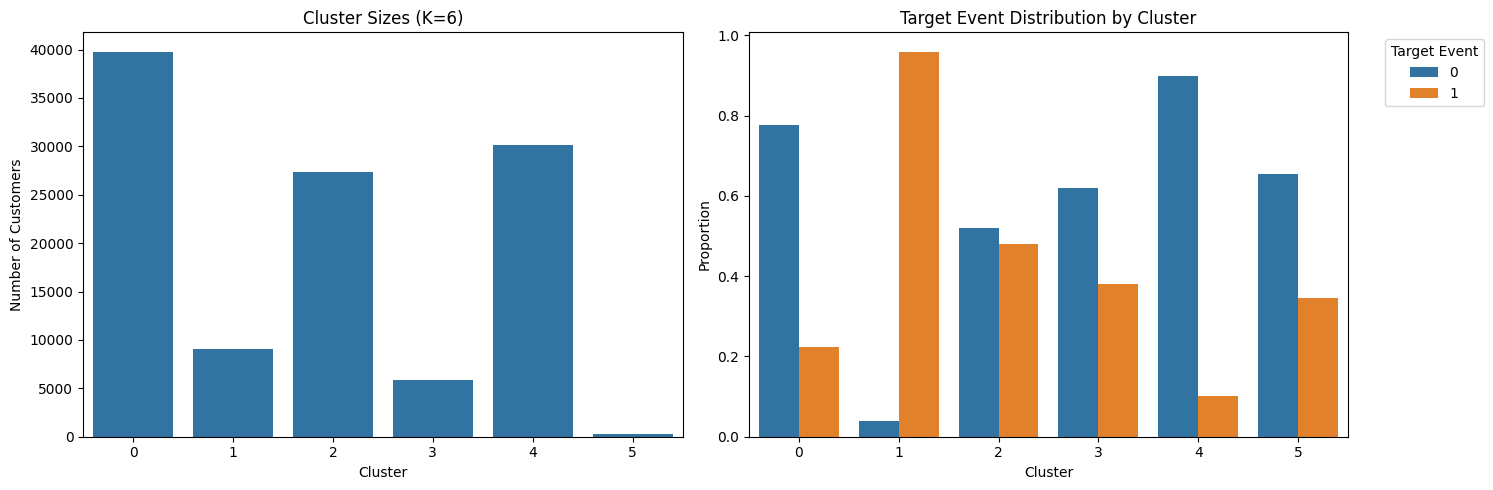

✓ Success: K=6, Features=18

--- Grid Search Experiment 78/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=8
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 7161 customers (6.36%)
  Cluster 1: 9122 customers (8.10%)
  Cluster 2: 37623 customers (33.41%)
  Cluster 3: 24067 customers (21.37%)
  Cluster 4: 29413 customers (26.12%)
  Cluster 5: 239 customers (0.21%)
  Cluster 6: 4985 customers (4.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -12.04              1.46          1.59        19.38
1         2.65              0.31          0.42       111.58
2       

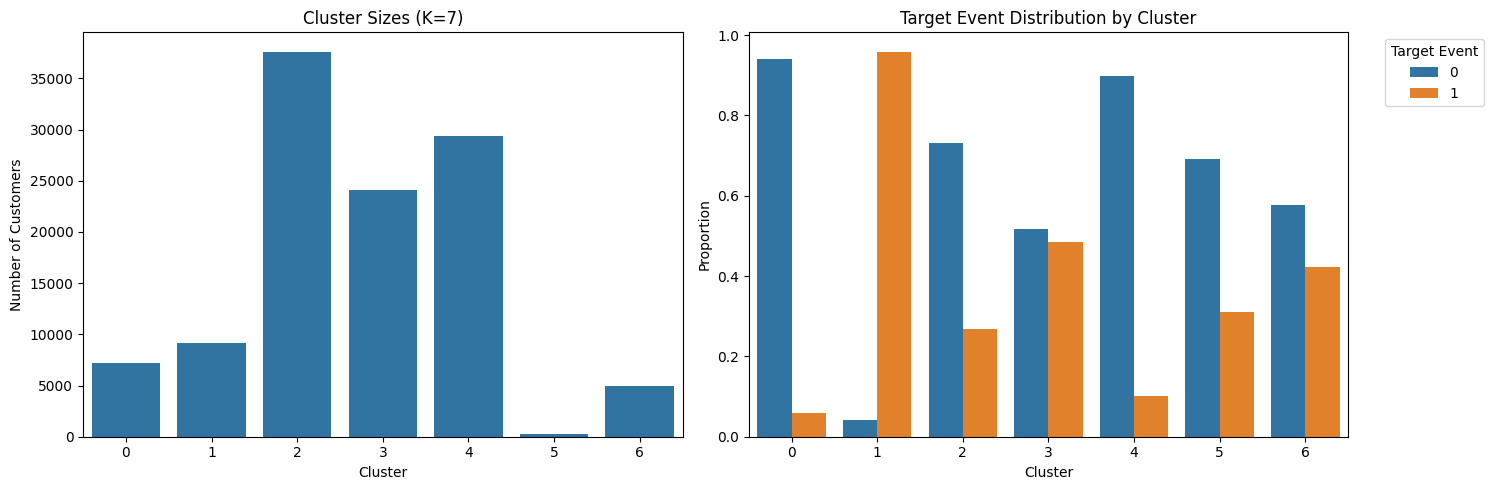

✓ Success: K=7, Features=18

--- Grid Search Experiment 79/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=10
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=10


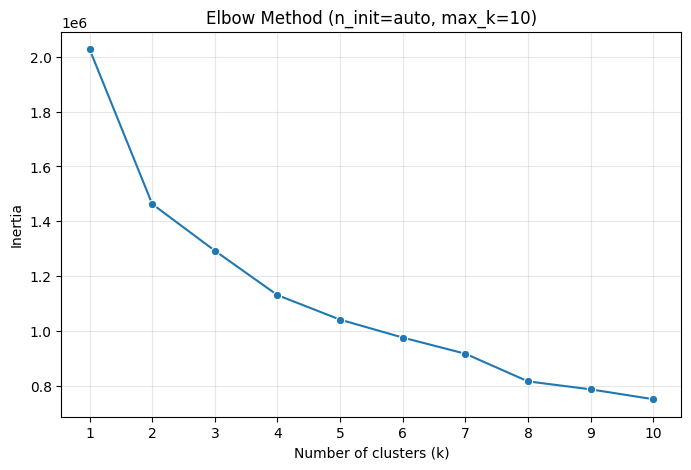

Rate of change analysis:
K=2, First diff=-563997.06, Second diff=393888.06
K=3, First diff=-170109.00, Second diff=8309.11
K=4, First diff=-161799.89, Second diff=72481.85
K=5, First diff=-89318.04, Second diff=24023.27
K=6, First diff=-65294.76, Second diff=6408.70
K=7, First diff=-58886.06, Second diff=-41824.19
K=8, First diff=-100710.24, Second diff=71630.25
K=9, First diff=-29079.99, Second diff=-6886.58
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 46018 customers (40.86%)
  Cluster 1: 66592 customers (59.14%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.38              0.45          0.66        79.93
1       -10.88              0.54          0.83        27.26

Target

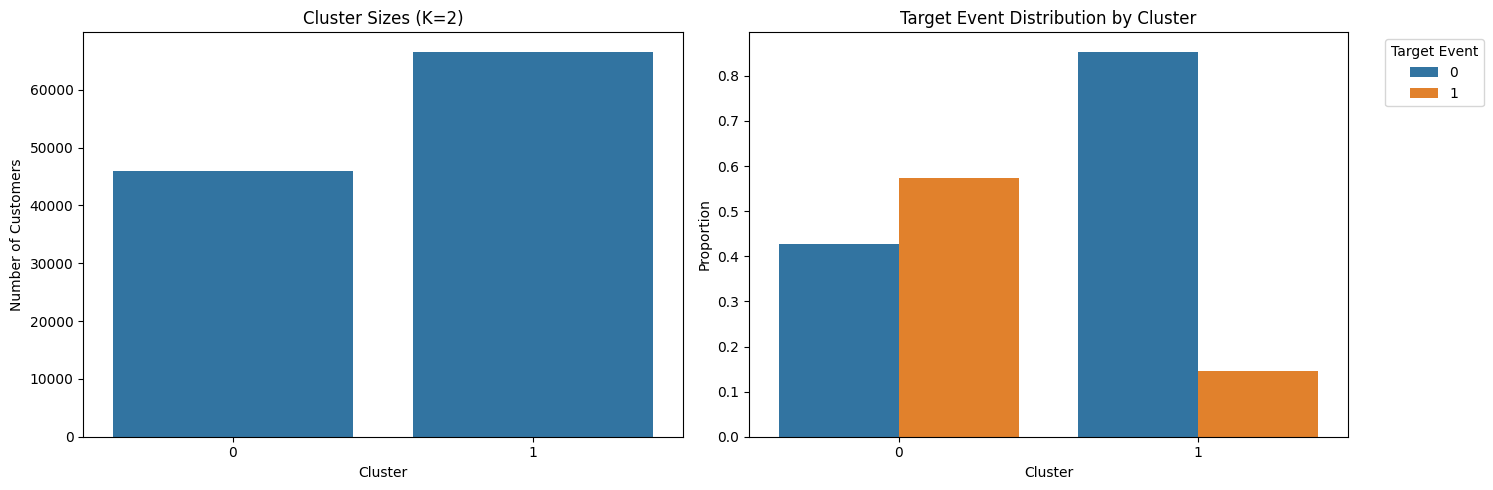

✓ Success: K=2, Features=18

--- Grid Search Experiment 80/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49719 customers (44.15%)
  Cluster 1: 14509 customers (12.88%)
  Cluster 2: 48382 customers (42.96%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1         1.85              0.53          0.69       103.67
2        -6.94              0.43          0.68        60.39

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.887  0.113
1             0.156  0.844
2     

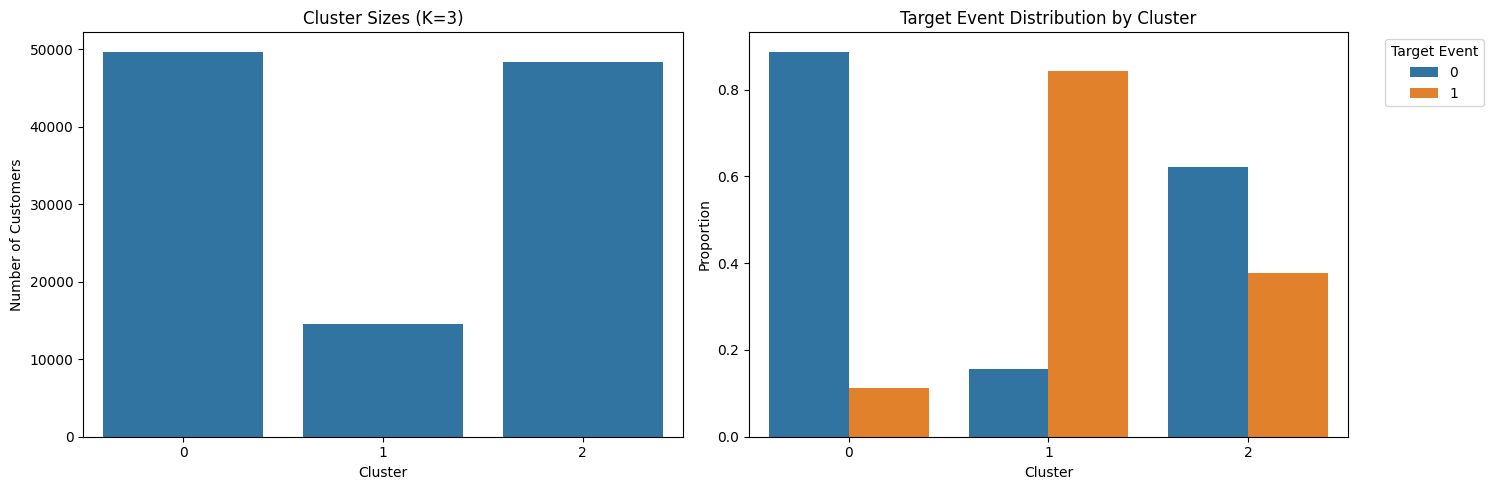

✓ Success: K=3, Features=18

--- Grid Search Experiment 81/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50178 customers (44.56%)
  Cluster 1: 11889 customers (10.56%)
  Cluster 2: 47199 customers (41.91%)
  Cluster 3: 3344 customers (2.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.45              0.56          0.86        21.58
1         2.23              0.31          0.44       108.61
2        -6.82              0.40          0.65        61.41
3        -2.94              1.67          1.94        66.05

Target Event Distribution by Cluster:
target_event      

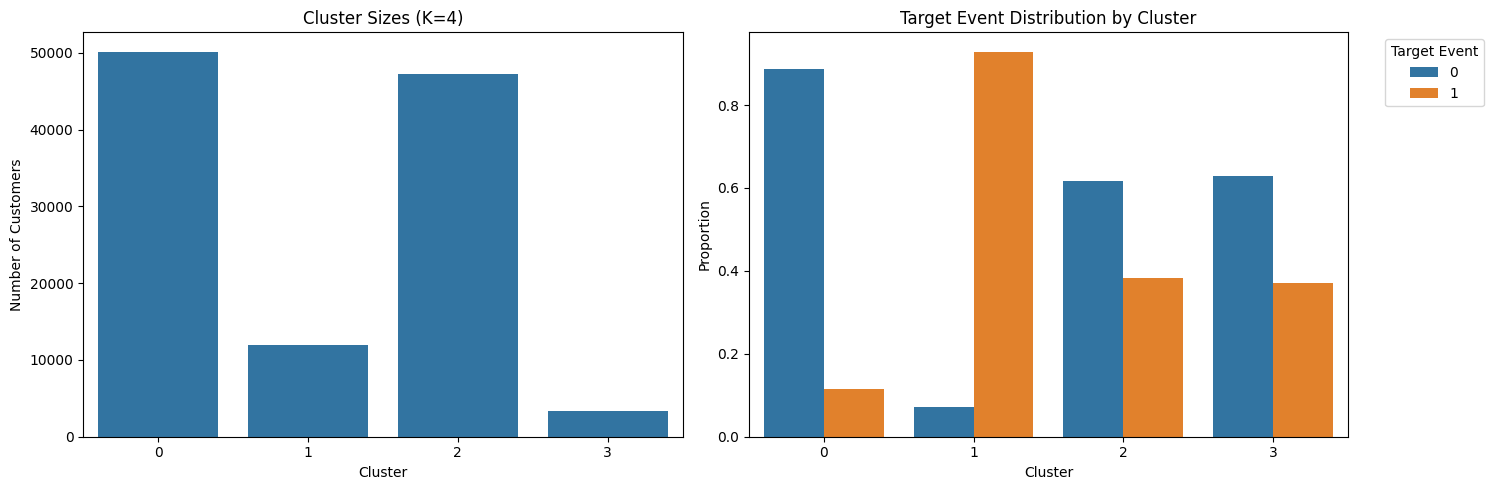

✓ Success: K=4, Features=18

--- Grid Search Experiment 82/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 40790 customers (36.22%)
  Cluster 1: 9326 customers (8.28%)
  Cluster 2: 28315 customers (25.14%)
  Cluster 3: 2819 customers (2.50%)
  Cluster 4: 31360 customers (27.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.27              0.57          0.82        38.20
1         2.66              0.31          0.43       111.46
2        -5.22              0.33          0.58        76.66
3        -2.73              1.77          2.06        66.02
4       -11.84       

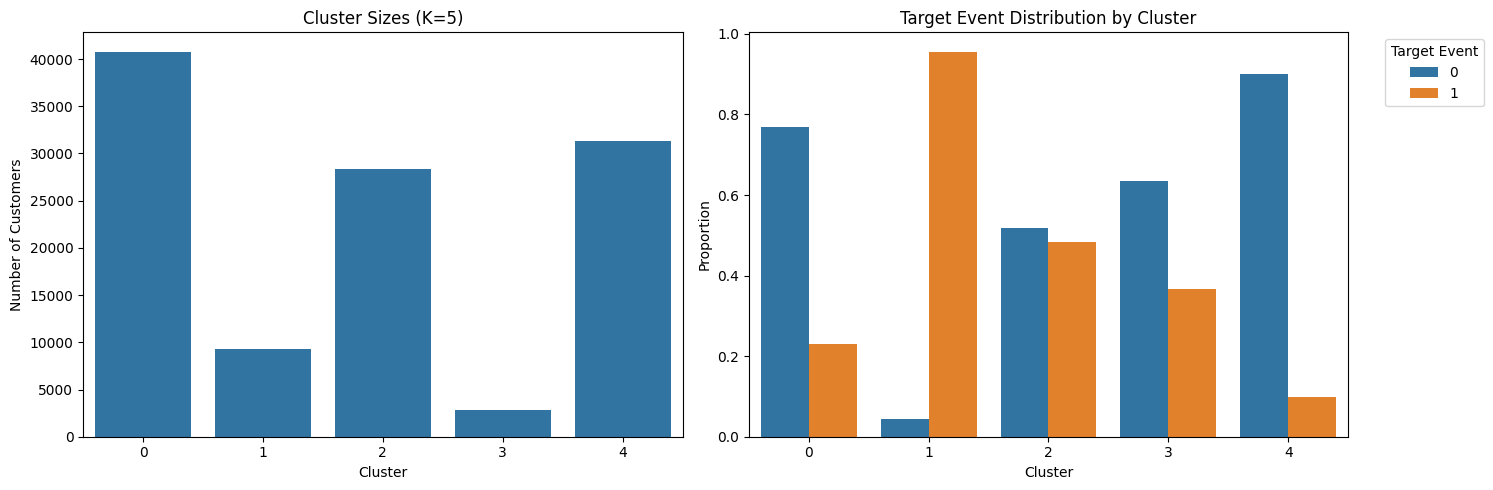

✓ Success: K=5, Features=18

--- Grid Search Experiment 83/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39792 customers (35.34%)
  Cluster 1: 9110 customers (8.09%)
  Cluster 2: 27344 customers (24.28%)
  Cluster 3: 5908 customers (5.25%)
  Cluster 4: 30137 customers (26.76%)
  Cluster 5: 319 customers (0.28%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.42              0.56          0.81        37.01
1         2.70              0.31          0.42       112.05
2        -5.46              0.28          0.54        76.62
3        -4.21             

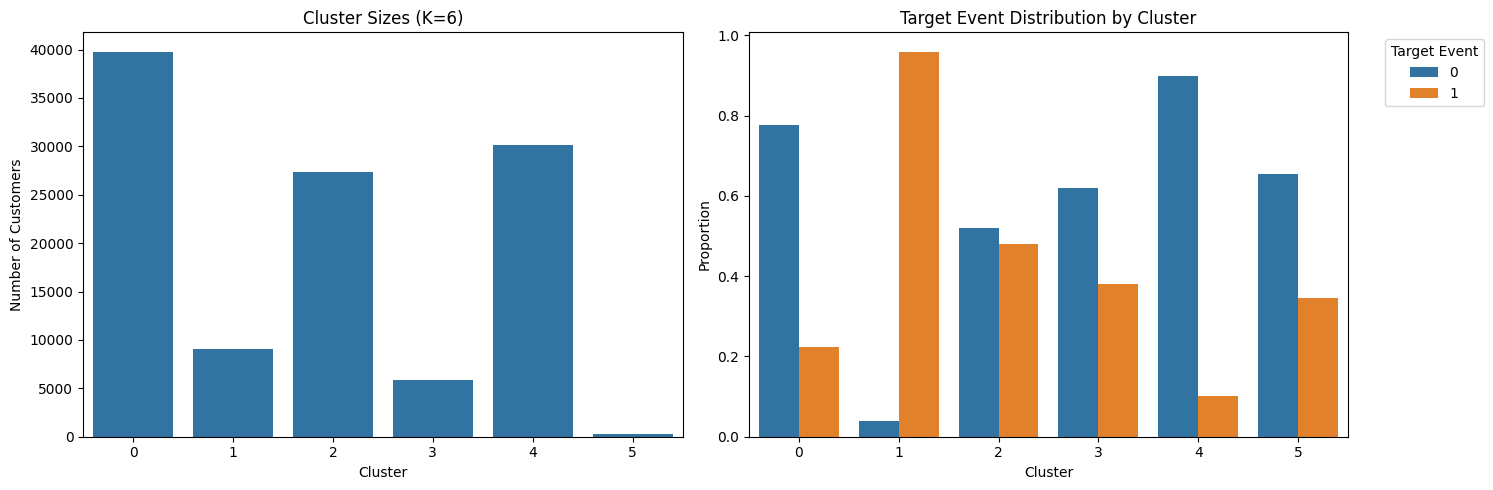

✓ Success: K=6, Features=18

--- Grid Search Experiment 84/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=10
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 7161 customers (6.36%)
  Cluster 1: 9122 customers (8.10%)
  Cluster 2: 37623 customers (33.41%)
  Cluster 3: 24067 customers (21.37%)
  Cluster 4: 29413 customers (26.12%)
  Cluster 5: 239 customers (0.21%)
  Cluster 6: 4985 customers (4.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -12.04              1.46          1.59        19.38
1         2.65              0.31          0.42       111.58
2      

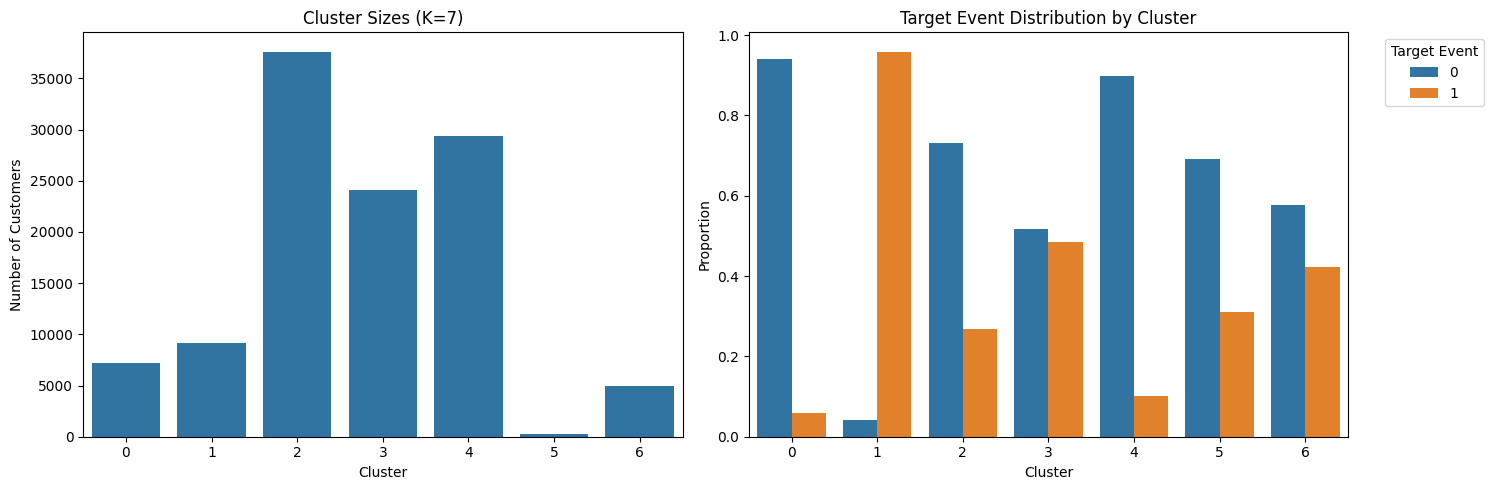

✓ Success: K=7, Features=18

--- Grid Search Experiment 85/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=12
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=12


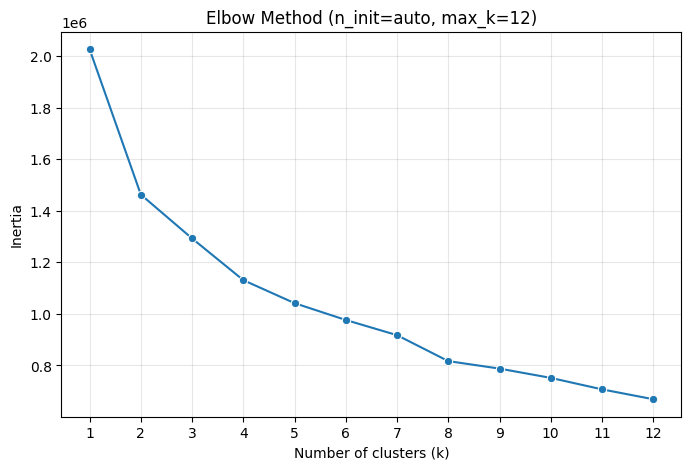

Rate of change analysis:
K=2, First diff=-563997.06, Second diff=393888.06
K=3, First diff=-170109.00, Second diff=8309.11
K=4, First diff=-161799.89, Second diff=72481.85
K=5, First diff=-89318.04, Second diff=24023.27
K=6, First diff=-65294.76, Second diff=6408.70
K=7, First diff=-58886.06, Second diff=-41824.19
K=8, First diff=-100710.24, Second diff=71630.25
K=9, First diff=-29079.99, Second diff=-6886.58
K=10, First diff=-35966.57, Second diff=-8562.46
K=11, First diff=-44529.03, Second diff=6237.90
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 46018 customers (40.86%)
  Cluster 1: 66592 customers (59.14%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -3.38              0.

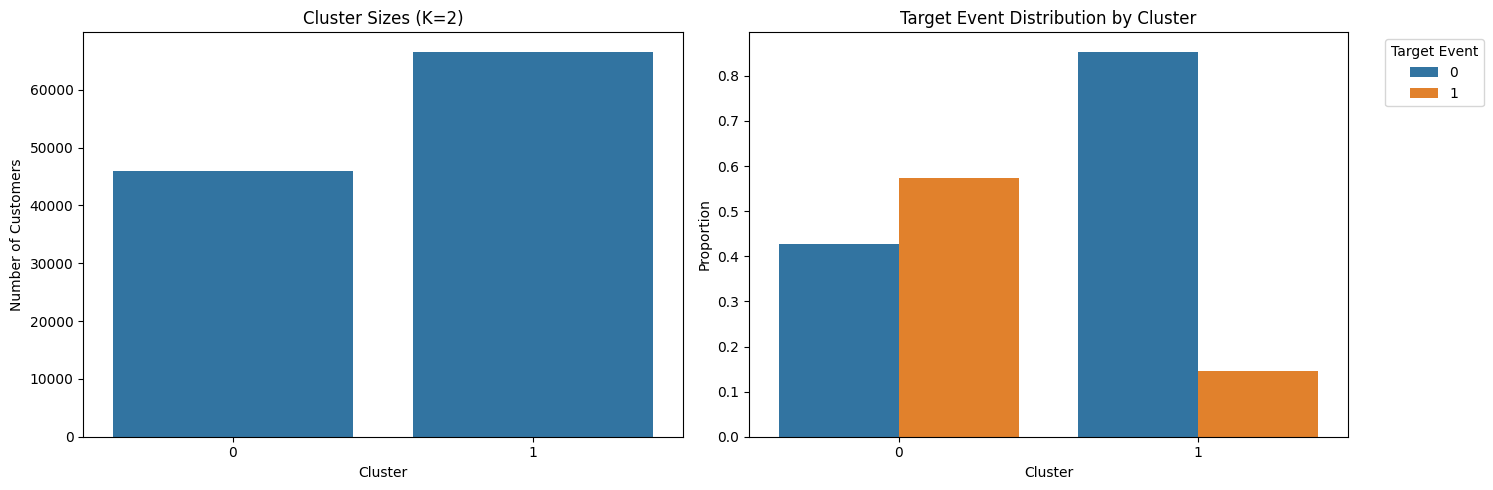

✓ Success: K=2, Features=18

--- Grid Search Experiment 86/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49719 customers (44.15%)
  Cluster 1: 14509 customers (12.88%)
  Cluster 2: 48382 customers (42.96%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1         1.85              0.53          0.69       103.67
2        -6.94              0.43          0.68        60.39

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.887  0.113
1             0.156  0.844
2     

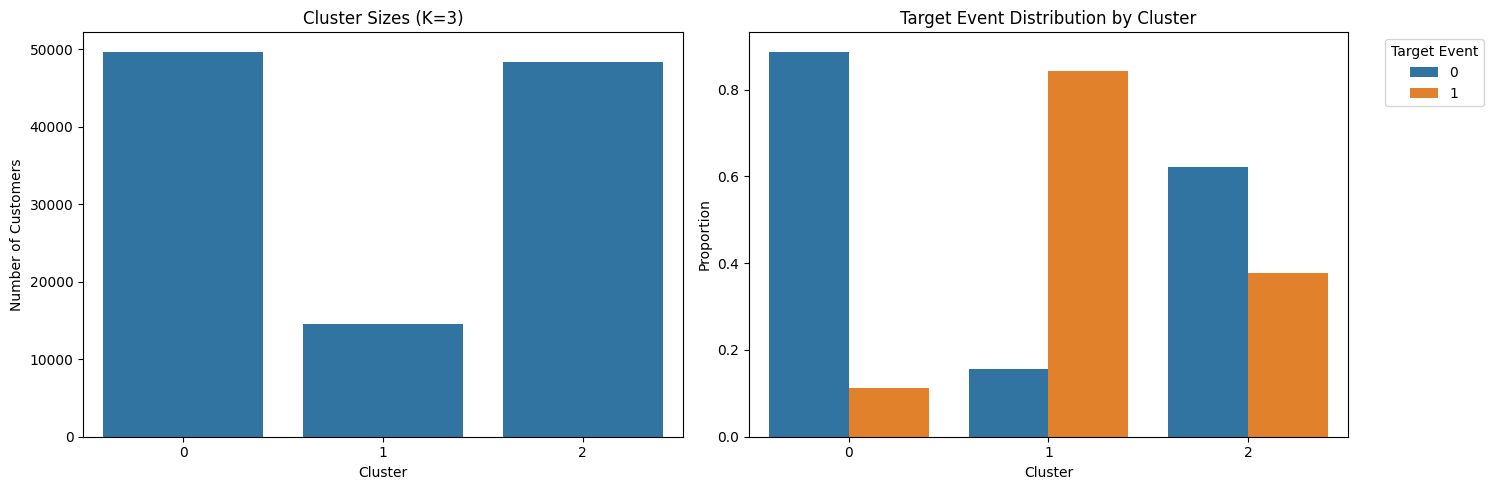

✓ Success: K=3, Features=18

--- Grid Search Experiment 87/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50178 customers (44.56%)
  Cluster 1: 11889 customers (10.56%)
  Cluster 2: 47199 customers (41.91%)
  Cluster 3: 3344 customers (2.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.45              0.56          0.86        21.58
1         2.23              0.31          0.44       108.61
2        -6.82              0.40          0.65        61.41
3        -2.94              1.67          1.94        66.05

Target Event Distribution by Cluster:
target_event      

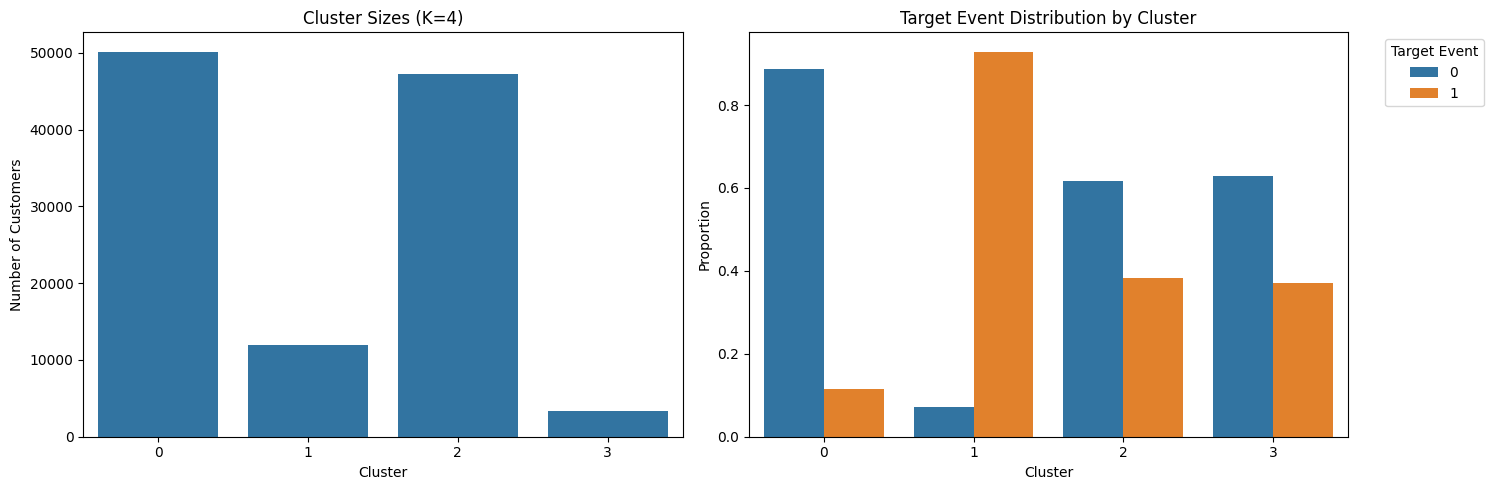

✓ Success: K=4, Features=18

--- Grid Search Experiment 88/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 40790 customers (36.22%)
  Cluster 1: 9326 customers (8.28%)
  Cluster 2: 28315 customers (25.14%)
  Cluster 3: 2819 customers (2.50%)
  Cluster 4: 31360 customers (27.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.27              0.57          0.82        38.20
1         2.66              0.31          0.43       111.46
2        -5.22              0.33          0.58        76.66
3        -2.73              1.77          2.06        66.02
4       -11.84       

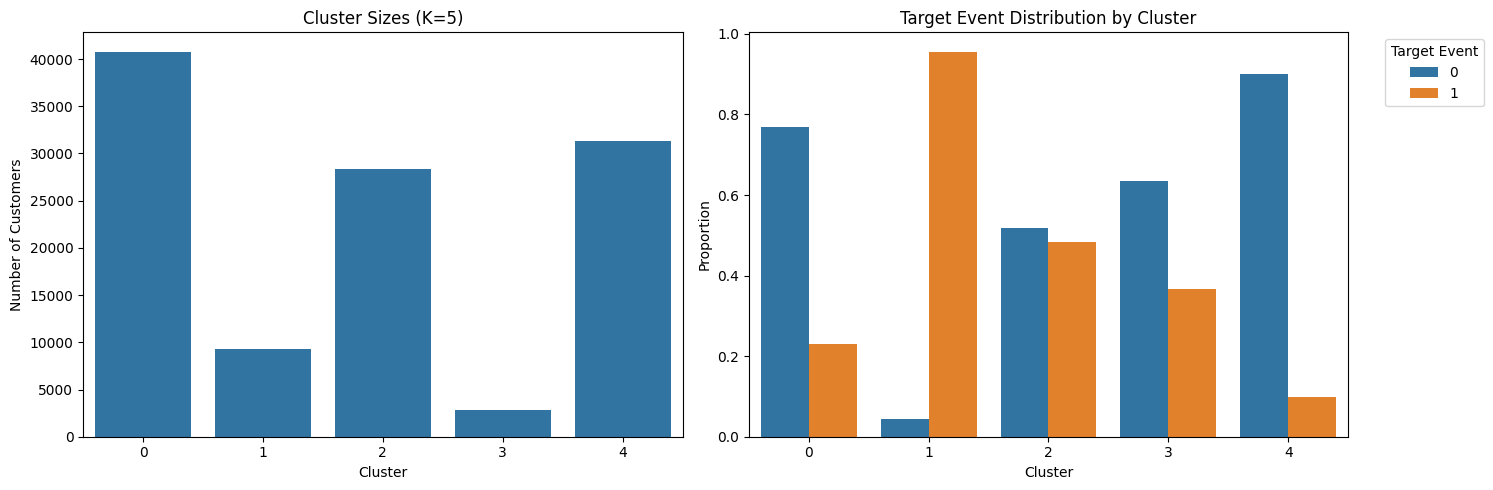

✓ Success: K=5, Features=18

--- Grid Search Experiment 89/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39792 customers (35.34%)
  Cluster 1: 9110 customers (8.09%)
  Cluster 2: 27344 customers (24.28%)
  Cluster 3: 5908 customers (5.25%)
  Cluster 4: 30137 customers (26.76%)
  Cluster 5: 319 customers (0.28%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39792 customers (35.34%)
  Cluster 1: 9110 customers (8.09%)
  Cluster 2: 27344 customers (24.28%)
  Cluster 3: 5908 customers (5.25%)
  Cluster 4: 30137 customers (26.76%)
  Cluster 5: 3

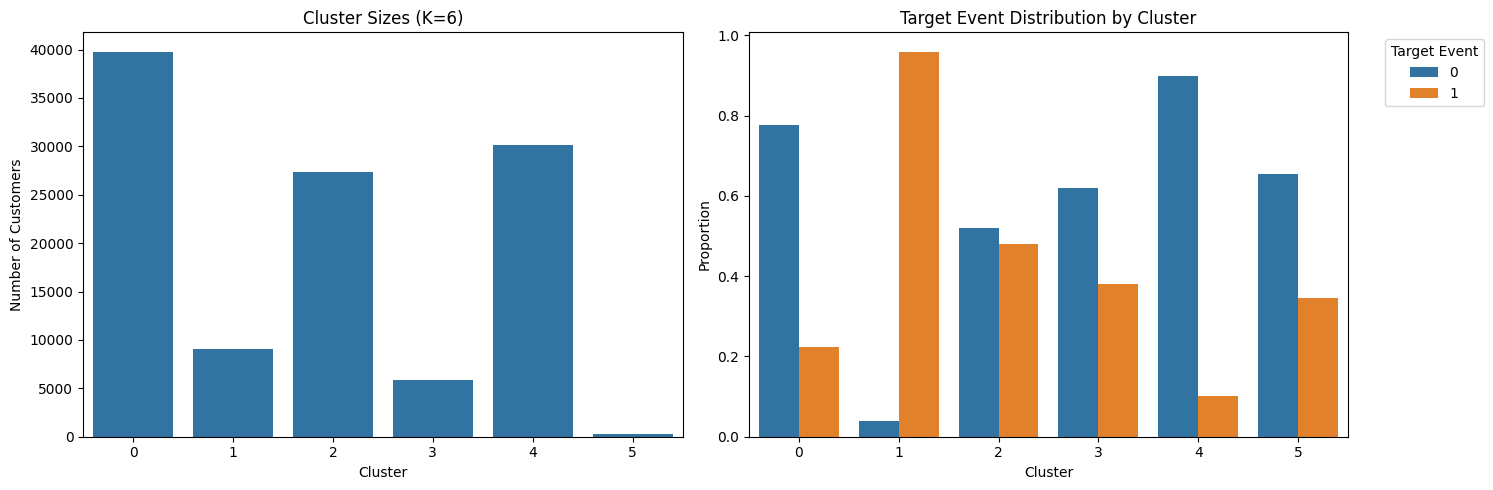

✓ Success: K=6, Features=18

--- Grid Search Experiment 90/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=12
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 7161 customers (6.36%)
  Cluster 1: 9122 customers (8.10%)
  Cluster 2: 37623 customers (33.41%)
  Cluster 3: 24067 customers (21.37%)
  Cluster 4: 29413 customers (26.12%)
  Cluster 5: 239 customers (0.21%)
  Cluster 6: 4985 customers (4.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -12.04              1.46          1.59        19.38
1         2.65              0.31          0.42       111.58
2        -8.67              0.45          0.71        42.02
3        -

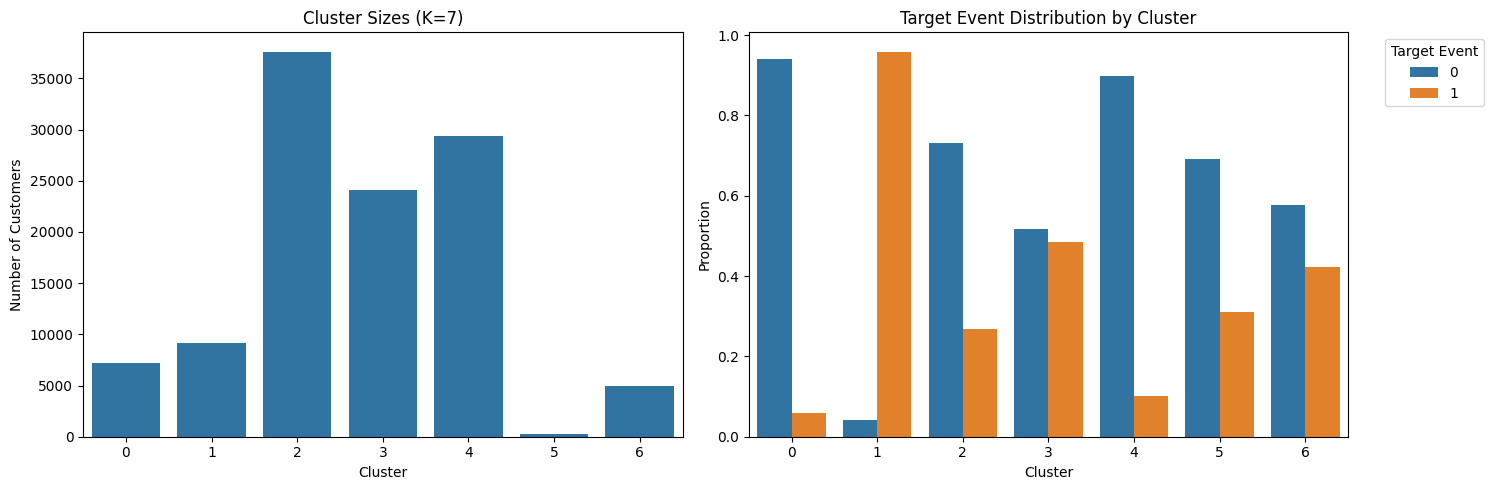

✓ Success: K=7, Features=18

--- Grid Search Experiment 91/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Threshold (0.2, -0.2): 18 features selected
Finding optimal clusters: n_init=auto, max_k=15
Finding optimal clusters: n_init=auto, max_k=15


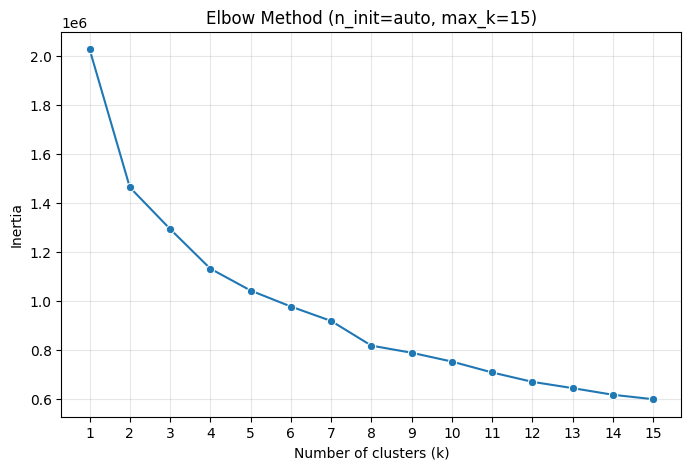

Rate of change analysis:
K=2, First diff=-563997.06, Second diff=393888.06
K=3, First diff=-170109.00, Second diff=8309.11
K=4, First diff=-161799.89, Second diff=72481.85
K=5, First diff=-89318.04, Second diff=24023.27
K=6, First diff=-65294.76, Second diff=6408.70
K=7, First diff=-58886.06, Second diff=-41824.19
K=8, First diff=-100710.24, Second diff=71630.25
K=9, First diff=-29079.99, Second diff=-6886.58
K=10, First diff=-35966.57, Second diff=-8562.46
K=11, First diff=-44529.03, Second diff=6237.90
K=12, First diff=-38291.13, Second diff=12640.17
K=13, First diff=-25650.96, Second diff=-1447.39
K=14, First diff=-27098.36, Second diff=8925.37
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 46018 customers (40.86%)
  Cluster 1: 66592 customers (59.14%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics

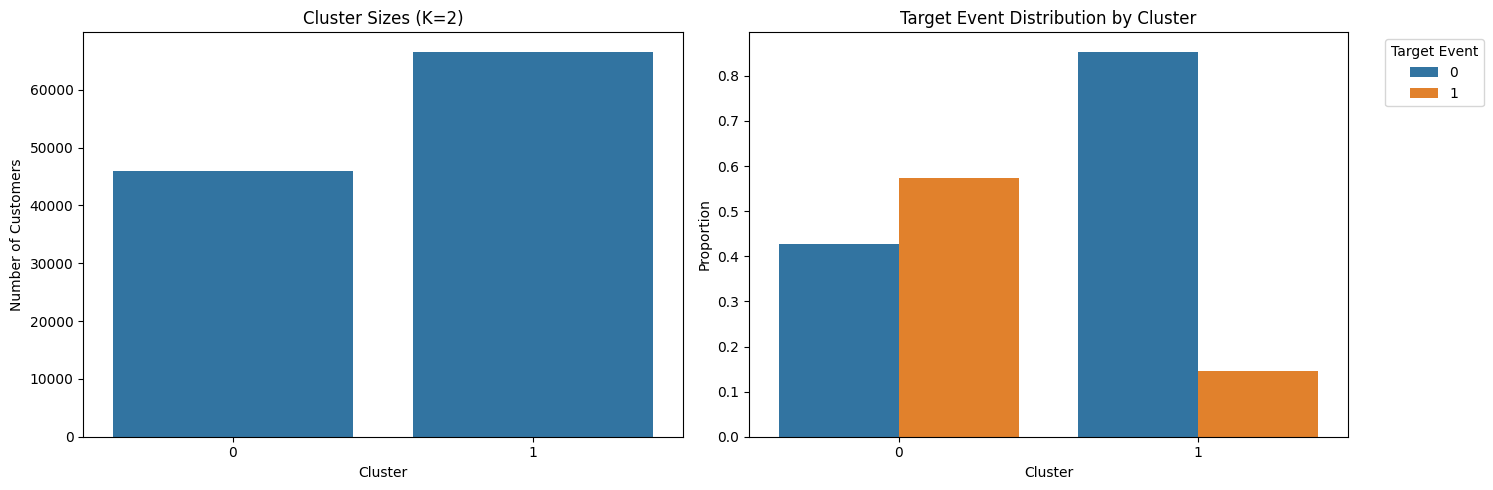

✓ Success: K=2, Features=18

--- Grid Search Experiment 92/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Manual K override: 3
Threshold (0.2, -0.2): 18 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 49719 customers (44.15%)
  Cluster 1: 14509 customers (12.88%)
  Cluster 2: 48382 customers (42.96%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.48              0.56          0.86        21.48
1         1.85              0.53          0.69       103.67
2        -6.94              0.43          0.68        60.39

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.887  0.113
1             0.156  0.844
2     

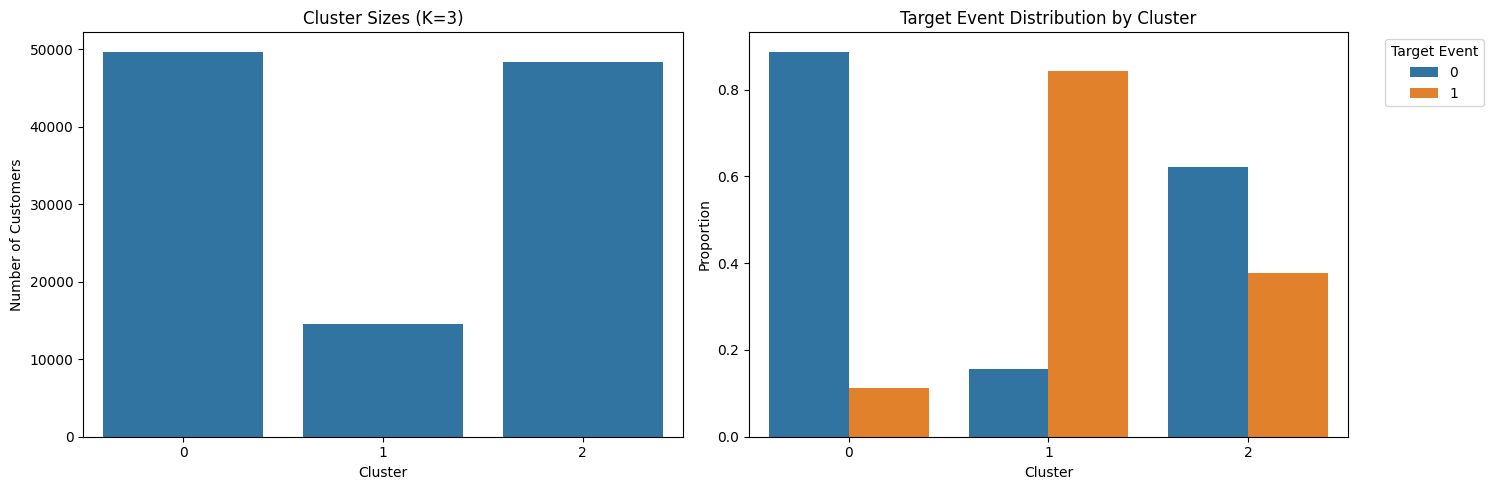

✓ Success: K=3, Features=18

--- Grid Search Experiment 93/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Manual K override: 4
Threshold (0.2, -0.2): 18 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50178 customers (44.56%)
  Cluster 1: 11889 customers (10.56%)
  Cluster 2: 47199 customers (41.91%)
  Cluster 3: 3344 customers (2.97%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.45              0.56          0.86        21.58
1         2.23              0.31          0.44       108.61
2        -6.82              0.40          0.65        61.41
3        -2.94              1.67          1.94        66.05

Target Event Distribution by Cluster:
target_event      

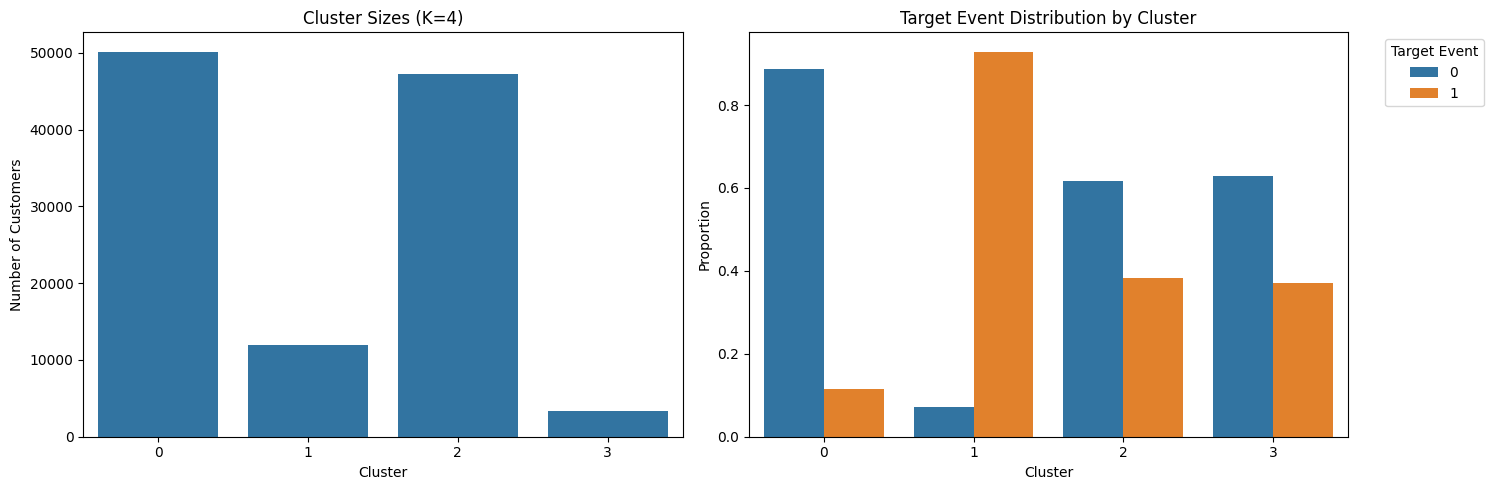

✓ Success: K=4, Features=18

--- Grid Search Experiment 94/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Manual K override: 5
Threshold (0.2, -0.2): 18 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 40790 customers (36.22%)
  Cluster 1: 9326 customers (8.28%)
  Cluster 2: 28315 customers (25.14%)
  Cluster 3: 2819 customers (2.50%)
  Cluster 4: 31360 customers (27.85%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.27              0.57          0.82        38.20
1         2.66              0.31          0.43       111.46
2        -5.22              0.33          0.58        76.66
3        -2.73              1.77          2.06        66.02
4       -11.84       

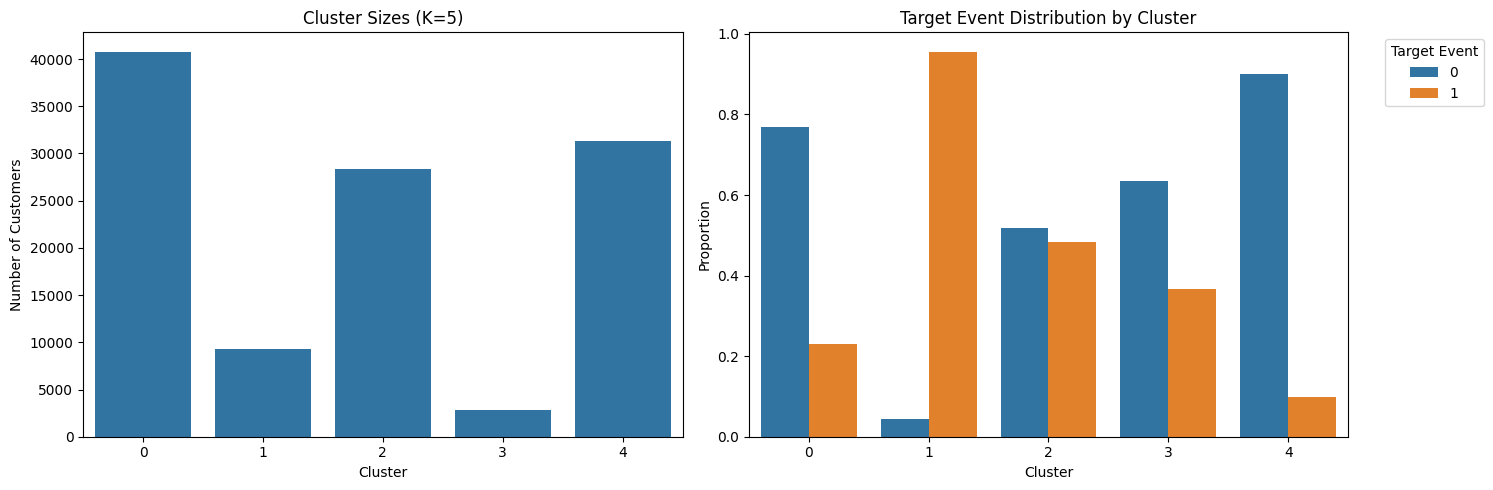

✓ Success: K=5, Features=18

--- Grid Search Experiment 95/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Manual K override: 6
Threshold (0.2, -0.2): 18 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39792 customers (35.34%)
  Cluster 1: 9110 customers (8.09%)
  Cluster 2: 27344 customers (24.28%)
  Cluster 3: 5908 customers (5.25%)
  Cluster 4: 30137 customers (26.76%)
  Cluster 5: 319 customers (0.28%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.42              0.56          0.81        37.01
1         2.70              0.31          0.42       112.05
2        -5.46              0.28          0.54        76.62
3        -4.21              1.23          1.38

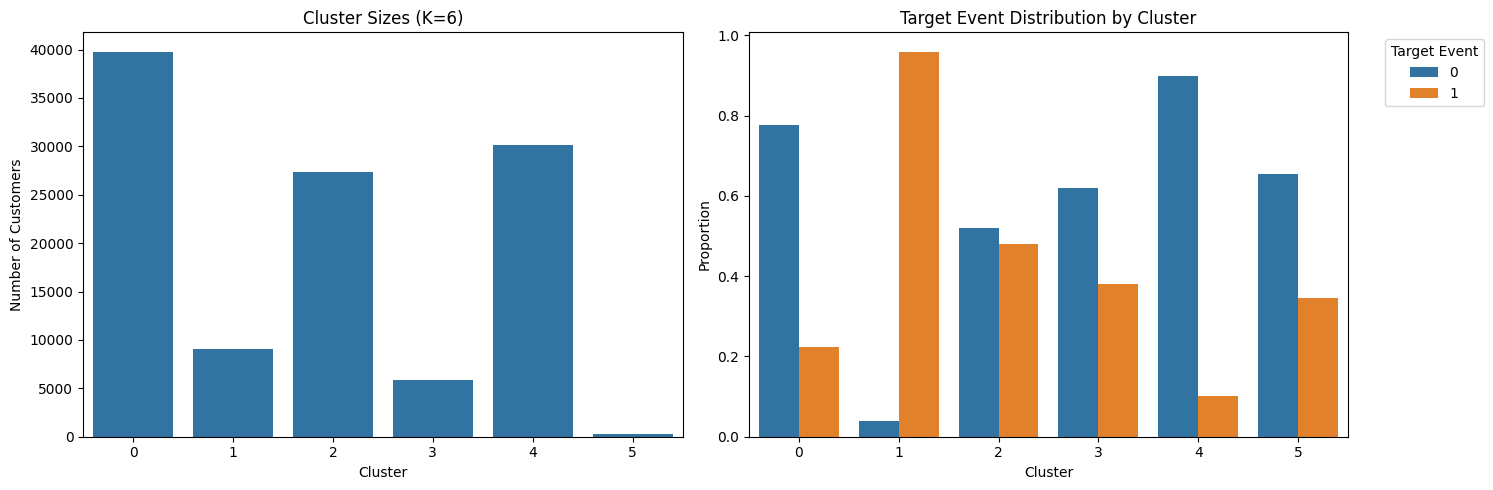

✓ Success: K=6, Features=18

--- Grid Search Experiment 96/144 ---

EXPERIMENT: threshold=(0.2, -0.2), n_init=auto, max_k=15
Manual K override: 7
Threshold (0.2, -0.2): 18 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 7161 customers (6.36%)
  Cluster 1: 9122 customers (8.10%)
  Cluster 2: 37623 customers (33.41%)
  Cluster 3: 24067 customers (21.37%)
  Cluster 4: 29413 customers (26.12%)
  Cluster 5: 239 customers (0.21%)
  Cluster 6: 4985 customers (4.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -12.04              1.46          1.59        19.38
1         2.65              0.31          0.42       111.58
2        -8.67              0.45          0.71        42.02
3        -

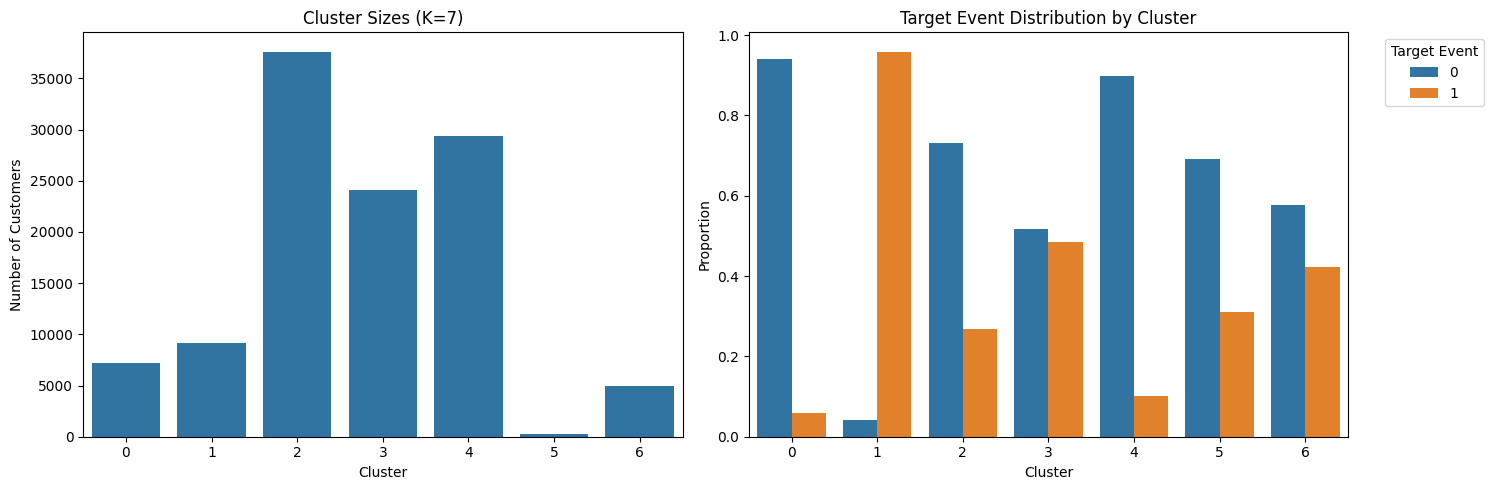

✓ Success: K=7, Features=18

--- Grid Search Experiment 97/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=8


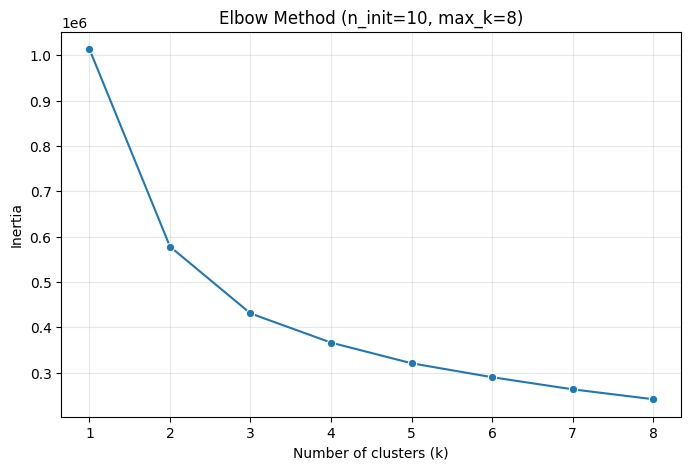

Rate of change analysis:
K=2, First diff=-435470.61, Second diff=287967.43
K=3, First diff=-147503.18, Second diff=83082.74
K=4, First diff=-64420.44, Second diff=18840.92
K=5, First diff=-45579.52, Second diff=14842.66
K=6, First diff=-30736.85, Second diff=3990.46
K=7, First diff=-26746.39, Second diff=4888.00
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70476 customers (62.58%)
  Cluster 1: 42134 customers (37.42%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59          0.87        27.76
1        -3.44              0.36          0.59        83.96

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0            

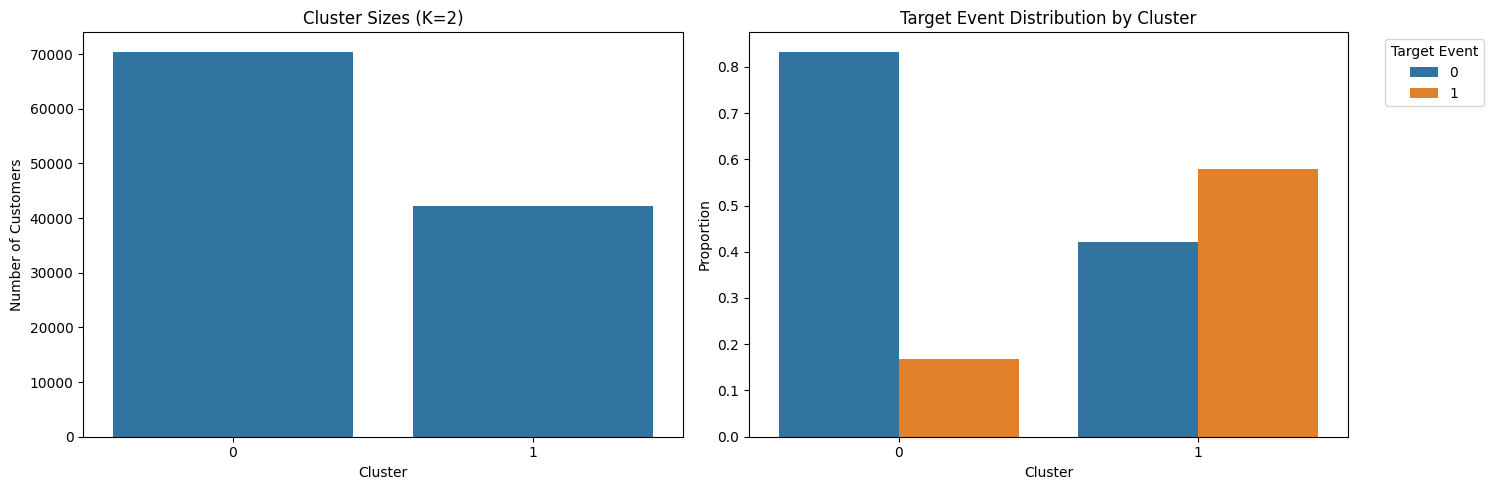

✓ Success: K=2, Features=9

--- Grid Search Experiment 98/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57726 customers (51.26%)
  Cluster 1: 10876 customers (9.66%)
  Cluster 2: 44008 customers (39.08%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.72              0.63          0.91        23.07
1         2.86              0.36          0.50       110.01
2        -6.64              0.37          0.63        67.38

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.

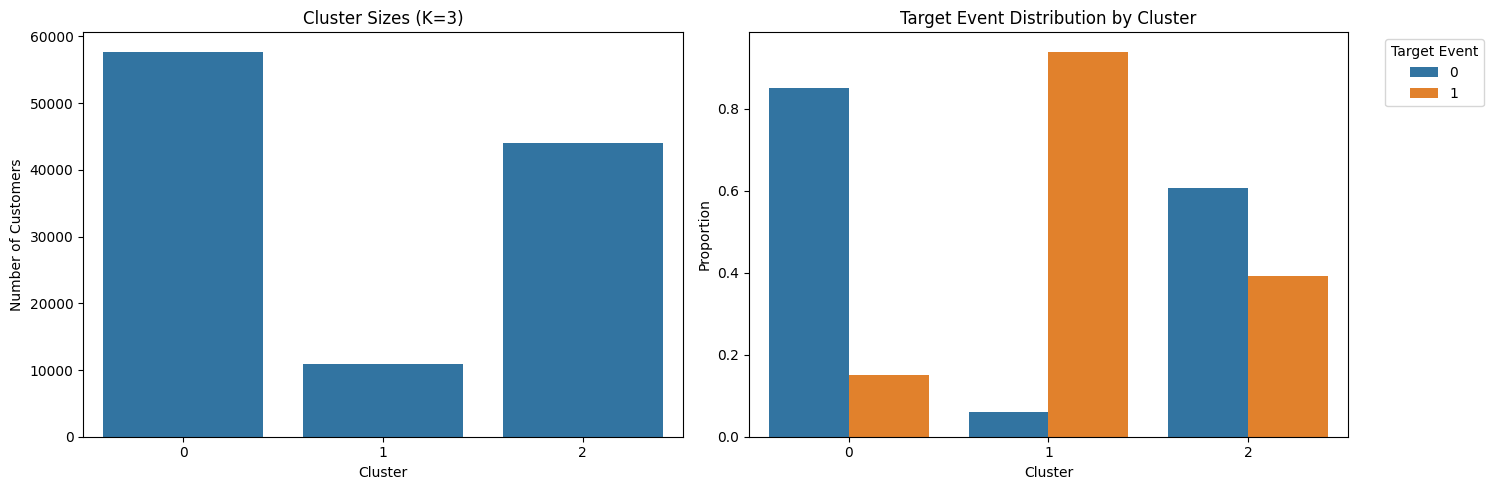

✓ Success: K=3, Features=9

--- Grid Search Experiment 99/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39383 customers (34.97%)
  Cluster 1: 9271 customers (8.23%)
  Cluster 2: 39245 customers (34.85%)
  Cluster 3: 24711 customers (21.94%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -8.45              0.43          0.68        45.49
1         3.02              0.34          0.45       111.48
2       -11.42              0.70          1.00        16.67
3        -5.14              0.36          0.63        81.52

Target Event Distribution by Cluster:
target_event      0    

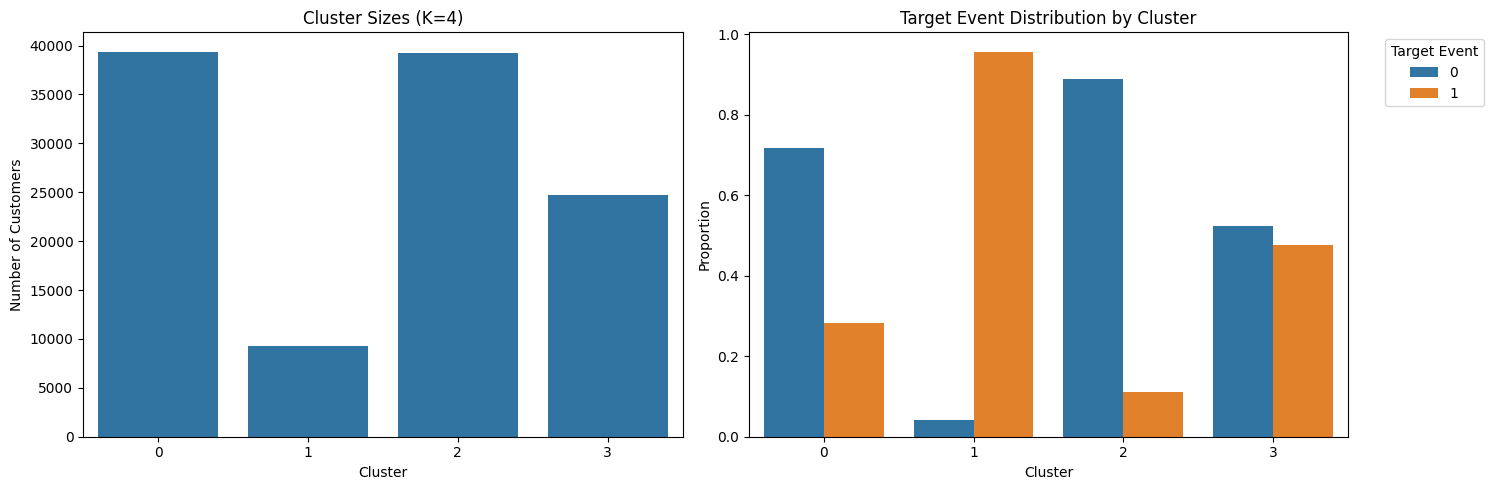

✓ Success: K=4, Features=9

--- Grid Search Experiment 100/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1998 customers (1.77%)
  Cluster 1: 9227 customers (8.19%)
  Cluster 2: 39373 customers (34.96%)
  Cluster 3: 23841 customers (21.17%)
  Cluster 4: 38171 customers (33.90%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.35              0.90          0.82         9.47
1         3.02              0.34          0.45       111.48
2       -11.32              0.68          1.00        17.92
3        -5.03              0.37          0.64        82.28
4        -8.37           

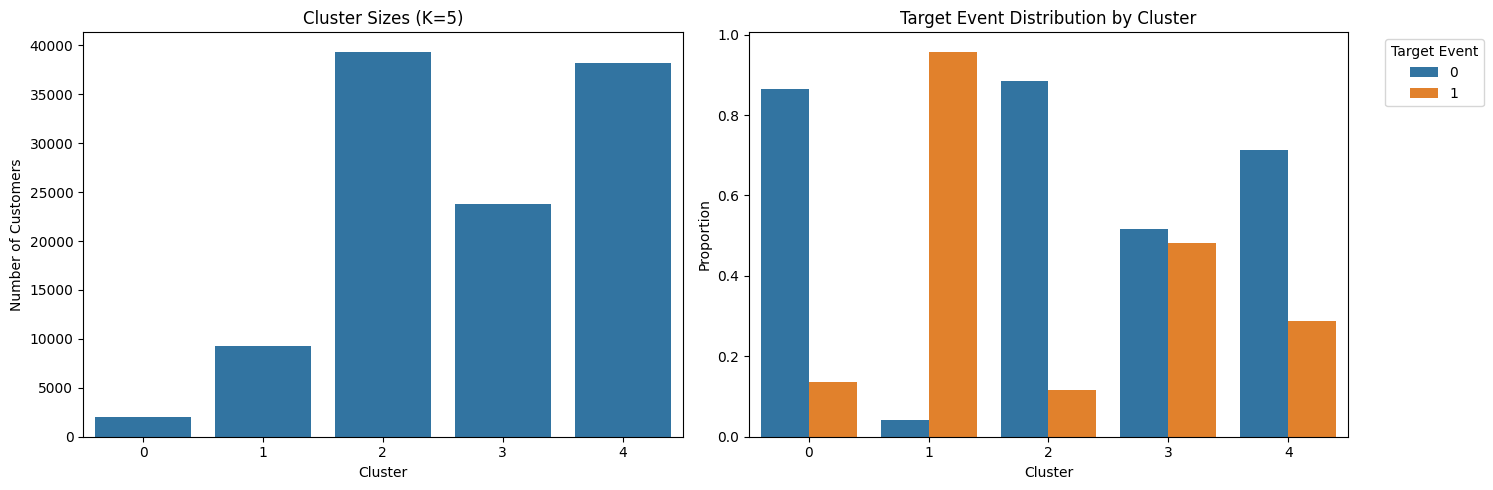

✓ Success: K=5, Features=9

--- Grid Search Experiment 101/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39411 customers (35.00%)
  Cluster 1: 35581 customers (31.60%)
  Cluster 2: 5636 customers (5.00%)
  Cluster 3: 10169 customers (9.03%)
  Cluster 4: 19805 customers (17.59%)
  Cluster 5: 2008 customers (1.78%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.26              0.68          0.99        18.07
1        -9.07              0.42          0.68        45.54
2         3.52              0.33          0.43

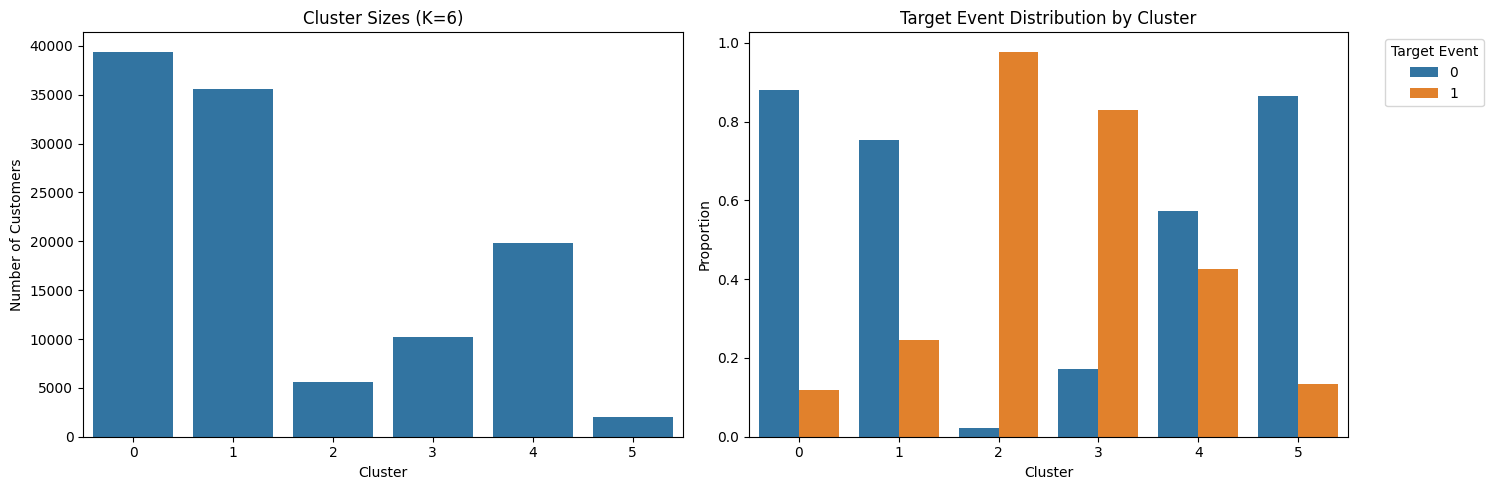

✓ Success: K=6, Features=9

--- Grid Search Experiment 102/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=8
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1926 customers (1.71%)
  Cluster 1: 5892 customers (5.23%)
  Cluster 2: 23304 customers (20.69%)
  Cluster 3: 26314 customers (23.37%)
  Cluster 4: 9789 customers (8.69%)
  Cluster 5: 12054 customers (10.70%)
  Cluster 6: 33331 customers (29.60%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.31              0.93          0.84         9.38
1         3.33              0.32          0.42       123.29
2        -8.80              0.34          0.61        60.43
3       -11

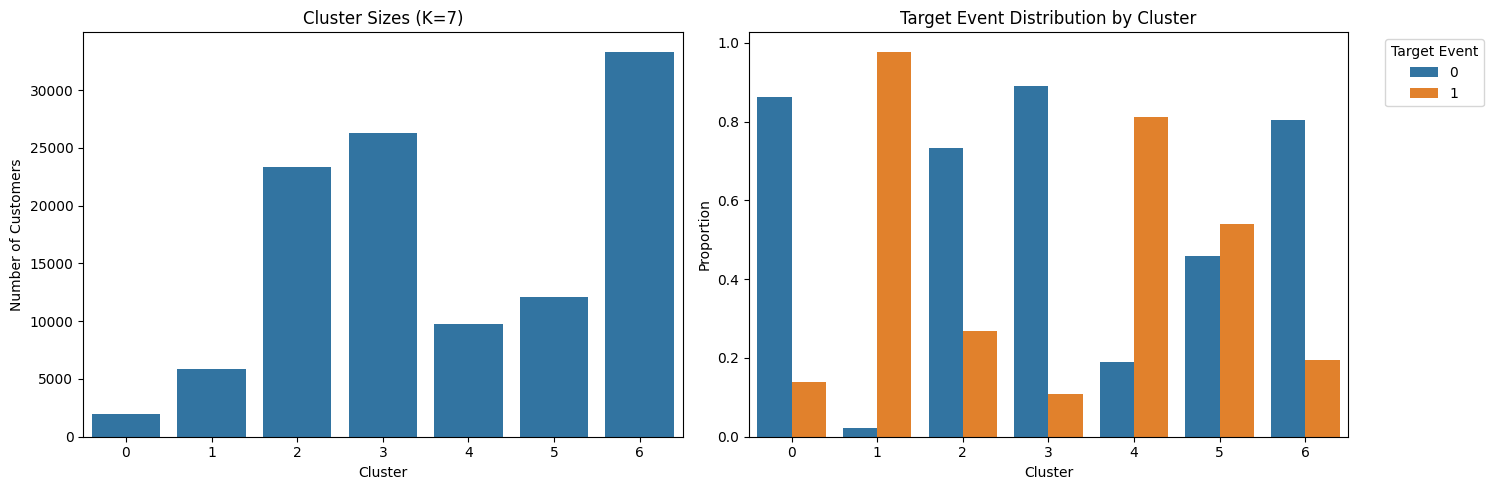

✓ Success: K=7, Features=9

--- Grid Search Experiment 103/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=10
Finding optimal clusters: n_init=10, max_k=10


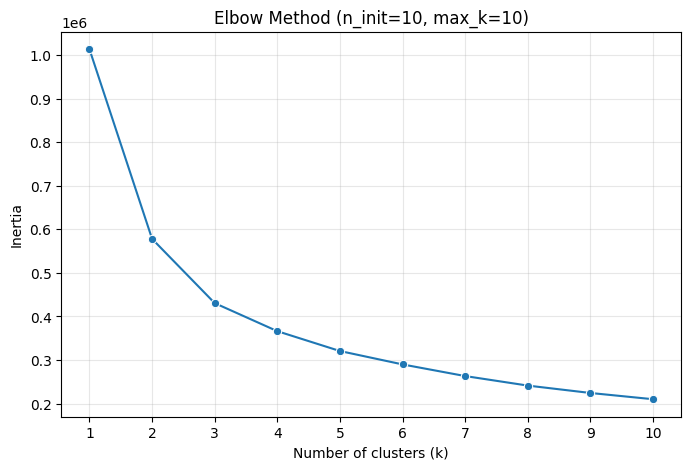

Rate of change analysis:
K=2, First diff=-435470.61, Second diff=287967.43
K=3, First diff=-147503.18, Second diff=83082.74
K=4, First diff=-64420.44, Second diff=18840.92
K=5, First diff=-45579.52, Second diff=14842.66
K=6, First diff=-30736.85, Second diff=3990.46
K=7, First diff=-26746.39, Second diff=4888.00
K=8, First diff=-21858.39, Second diff=4882.23
K=9, First diff=-16976.16, Second diff=2658.90
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70476 customers (62.58%)
  Cluster 1: 42134 customers (37.42%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59          0.87        27.76
1        -3.44              0.36          0.59        83.96

Target Even

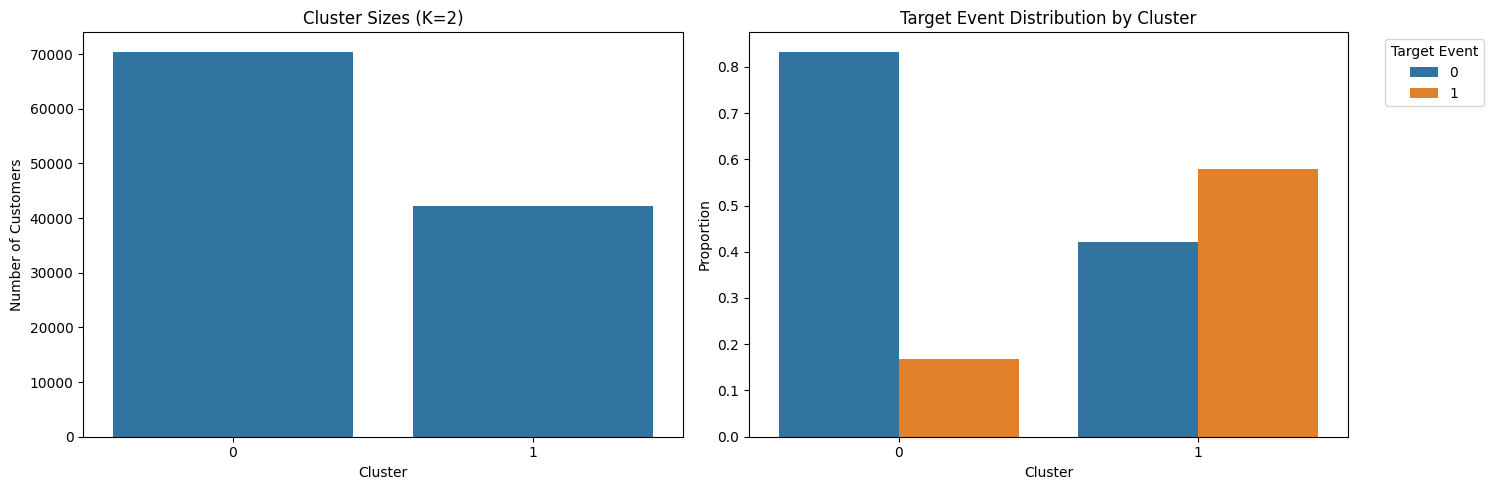

✓ Success: K=2, Features=9

--- Grid Search Experiment 104/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57726 customers (51.26%)
  Cluster 1: 10876 customers (9.66%)
  Cluster 2: 44008 customers (39.08%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.72              0.63          0.91        23.07
1         2.86              0.36          0.50       110.01
2        -6.64              0.37          0.63        67.38

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0 

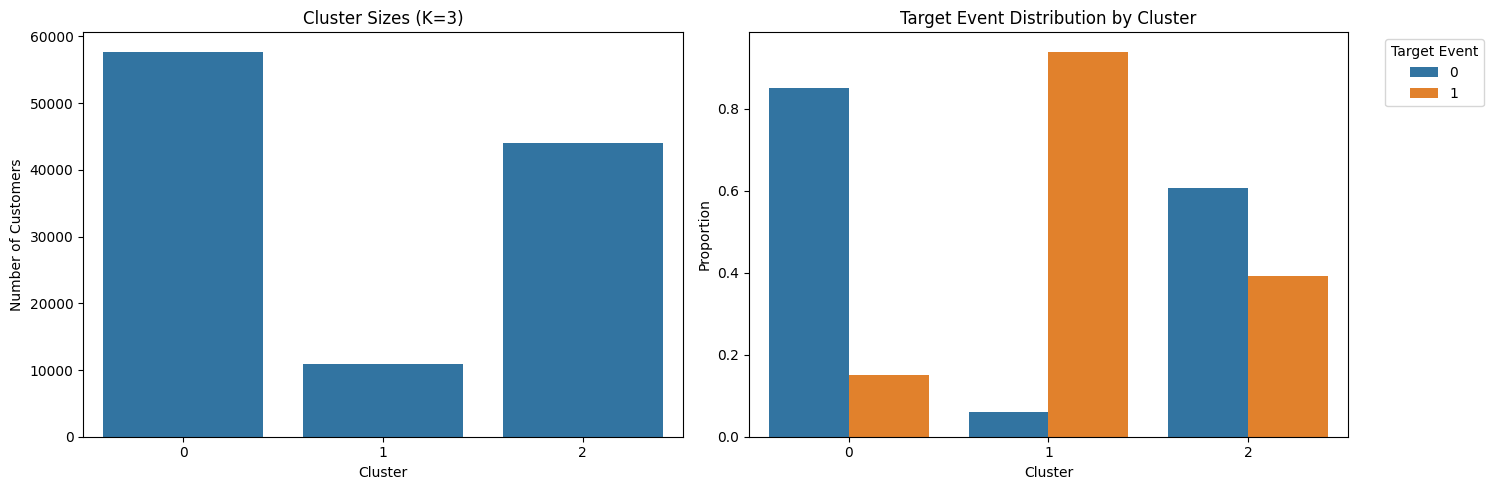

✓ Success: K=3, Features=9

--- Grid Search Experiment 105/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39383 customers (34.97%)
  Cluster 1: 9271 customers (8.23%)
  Cluster 2: 39245 customers (34.85%)
  Cluster 3: 24711 customers (21.94%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -8.45              0.43          0.68        45.49
1         3.02              0.34          0.45       111.48
2       -11.42              0.70          1.00        16.67
3        -5.14              0.36          0.63        81.5

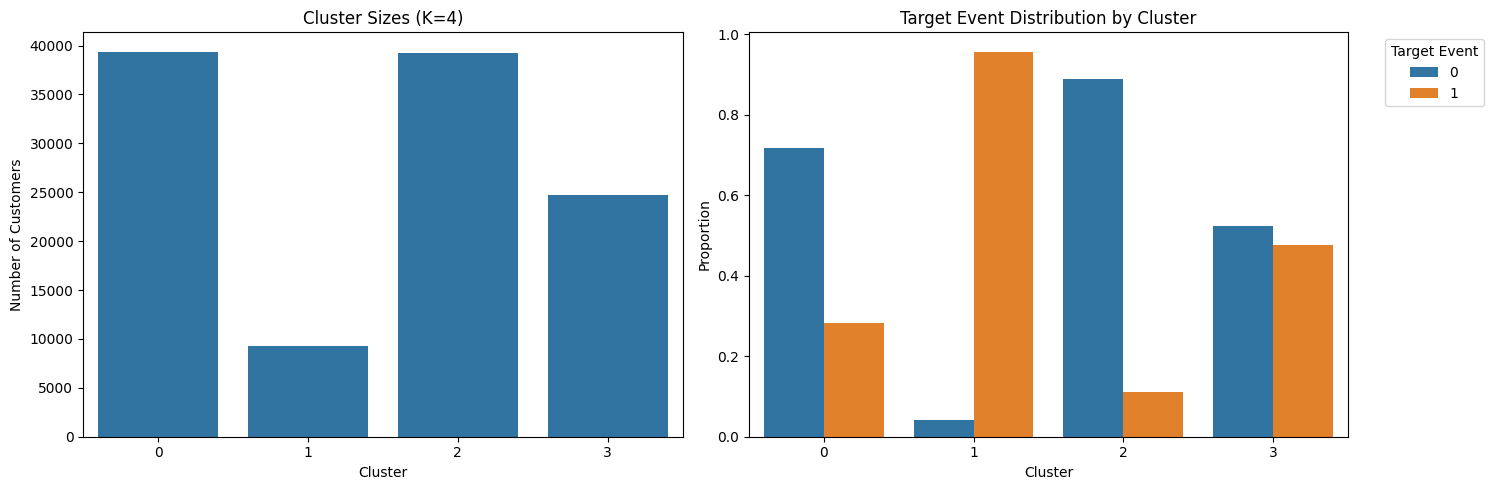

✓ Success: K=4, Features=9

--- Grid Search Experiment 106/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1998 customers (1.77%)
  Cluster 1: 9227 customers (8.19%)
  Cluster 2: 39373 customers (34.96%)
  Cluster 3: 23841 customers (21.17%)
  Cluster 4: 38171 customers (33.90%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.35              0.90          0.82         9.47
1         3.02              0.34          0.45       111.48
2       -11.32              0.68          1.00        17.92
3        -5.03              0.37          0.64        82.28
4        -8.37          

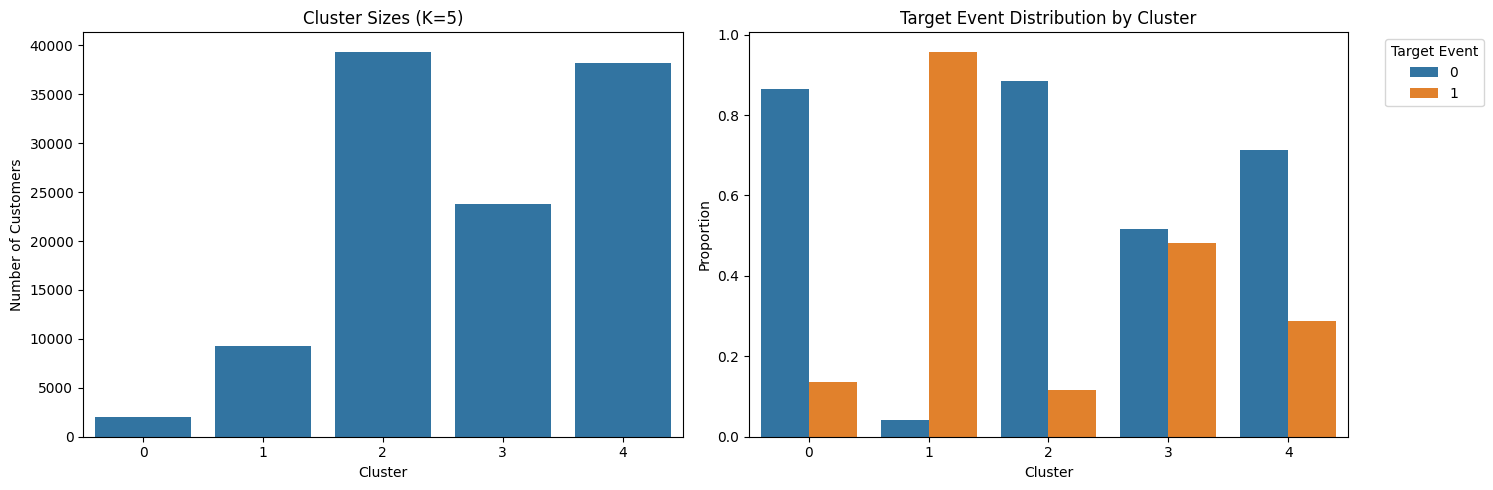

✓ Success: K=5, Features=9

--- Grid Search Experiment 107/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39411 customers (35.00%)
  Cluster 1: 35581 customers (31.60%)
  Cluster 2: 5636 customers (5.00%)
  Cluster 3: 10169 customers (9.03%)
  Cluster 4: 19805 customers (17.59%)
  Cluster 5: 2008 customers (1.78%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.26              0.68          0.99        18.07
1        -9.07              0.42          0.68        45.54
2         3.52              0.33          0.43       124.62
3         0.71              0.38          0.52 

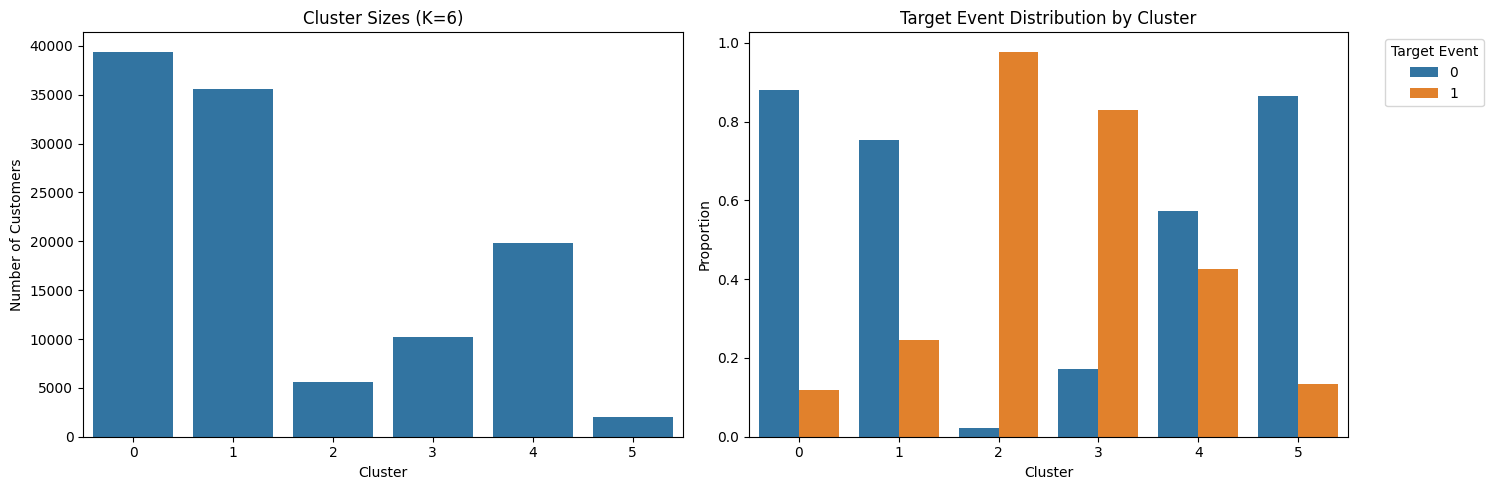

✓ Success: K=6, Features=9

--- Grid Search Experiment 108/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=10
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1926 customers (1.71%)
  Cluster 1: 5892 customers (5.23%)
  Cluster 2: 23304 customers (20.69%)
  Cluster 3: 26314 customers (23.37%)
  Cluster 4: 9789 customers (8.69%)
  Cluster 5: 12054 customers (10.70%)
  Cluster 6: 33331 customers (29.60%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.31              0.93          0.84         9.38
1         3.33              0.32          0.42       123.29
2        -8.80              0.34          0.61     

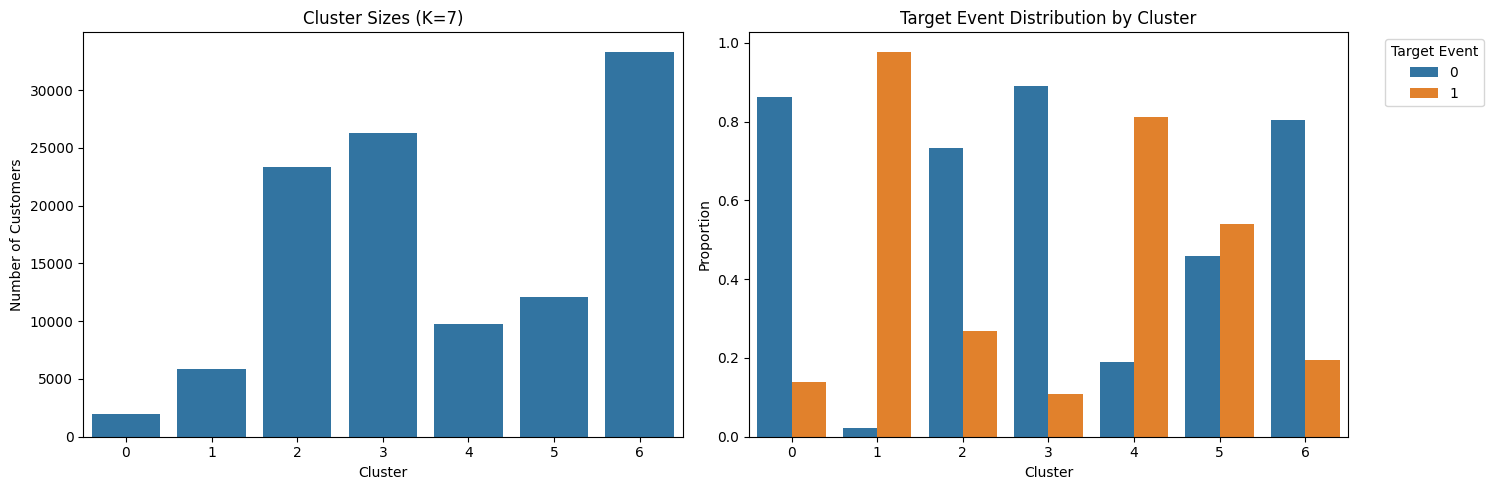

✓ Success: K=7, Features=9

--- Grid Search Experiment 109/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=12


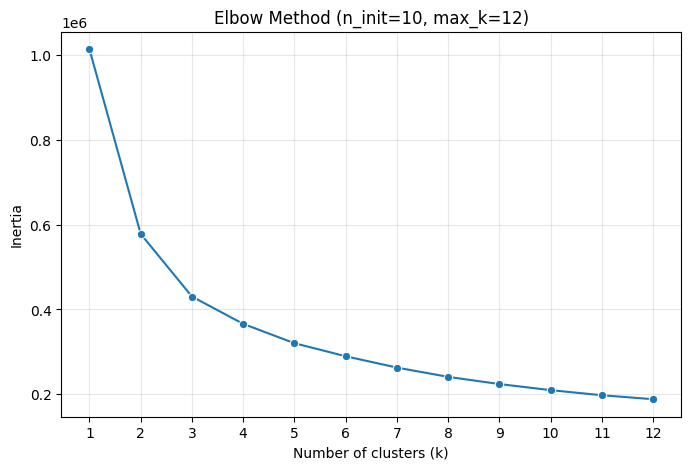

Rate of change analysis:
K=2, First diff=-435470.61, Second diff=287967.43
K=3, First diff=-147503.18, Second diff=83082.74
K=4, First diff=-64420.44, Second diff=18840.92
K=5, First diff=-45579.52, Second diff=14842.66
K=6, First diff=-30736.85, Second diff=3990.46
K=7, First diff=-26746.39, Second diff=4888.00
K=8, First diff=-21858.39, Second diff=4882.23
K=9, First diff=-16976.16, Second diff=2658.90
K=10, First diff=-14317.26, Second diff=2264.28
K=11, First diff=-12052.98, Second diff=2686.56
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70476 customers (62.58%)
  Cluster 1: 42134 customers (37.42%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59    

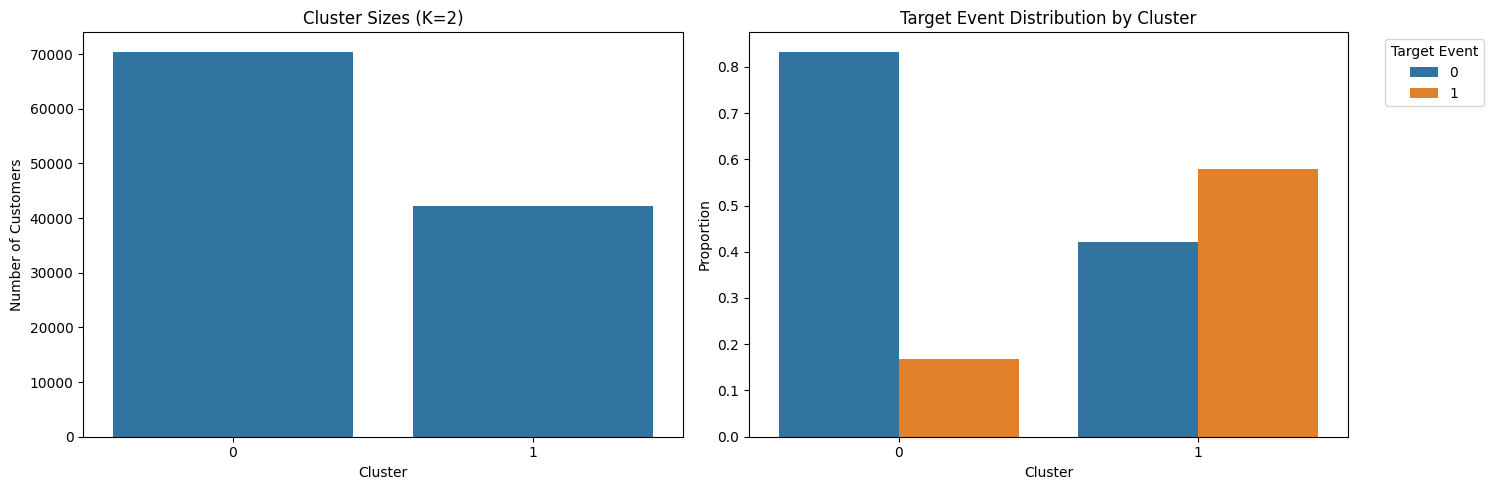

✓ Success: K=2, Features=9

--- Grid Search Experiment 110/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57726 customers (51.26%)
  Cluster 1: 10876 customers (9.66%)
  Cluster 2: 44008 customers (39.08%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.72              0.63          0.91        23.07
1         2.86              0.36          0.50       110.01
2        -6.64              0.37          0.63        67.38

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.150
1             0.061  0.939
2         

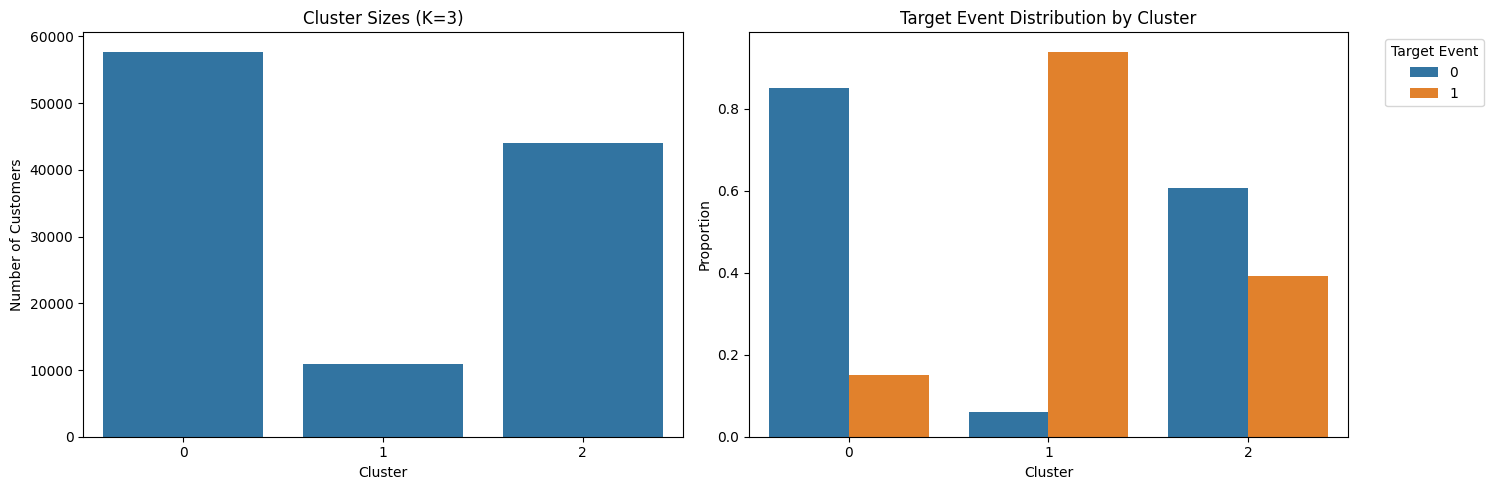

✓ Success: K=3, Features=9

--- Grid Search Experiment 111/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39383 customers (34.97%)
  Cluster 1: 9271 customers (8.23%)
  Cluster 2: 39245 customers (34.85%)
  Cluster 3: 24711 customers (21.94%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -8.45              0.43          0.68        45.49
1         3.02              0.34          0.45       111.48
2       -11.42              0.70          1.00        16.67
3        -5.14              0.36          0.63        81.52

Target Event Distribution by Cluster:
target_event      0  

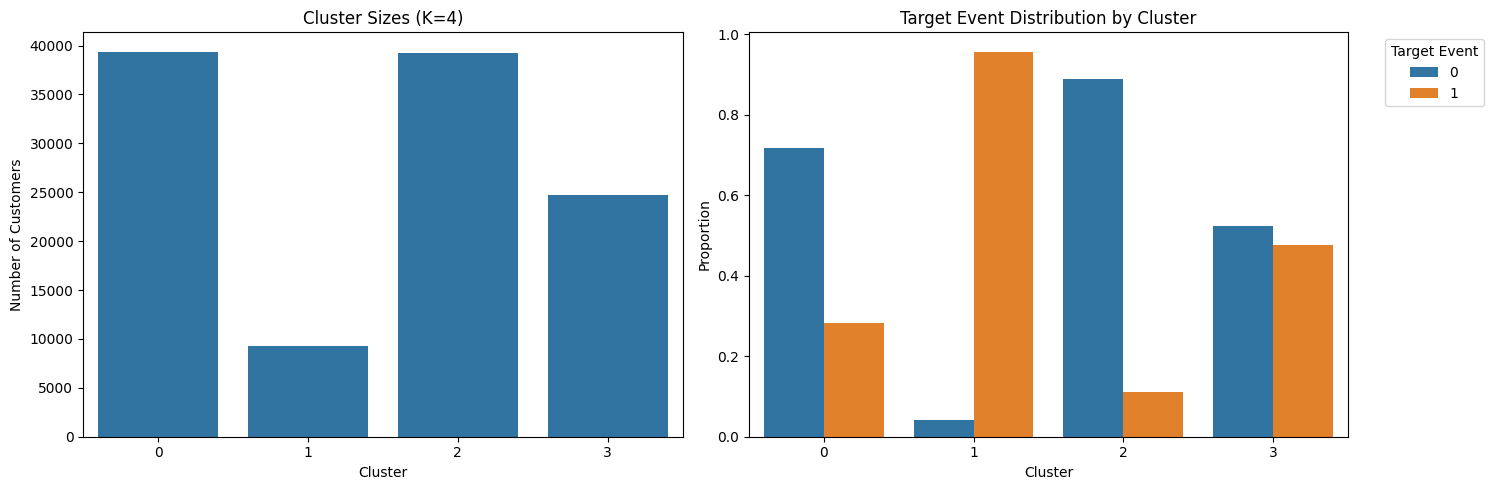

✓ Success: K=4, Features=9

--- Grid Search Experiment 112/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1998 customers (1.77%)
  Cluster 1: 9227 customers (8.19%)
  Cluster 2: 39373 customers (34.96%)
  Cluster 3: 23841 customers (21.17%)
  Cluster 4: 38171 customers (33.90%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.35              0.90          0.82         9.47
1         3.02              0.34          0.45       111.48
2       -11.32              0.68          1.00        17.92
3        -5.03              0.37          0.64        82.28
4        -8.37          

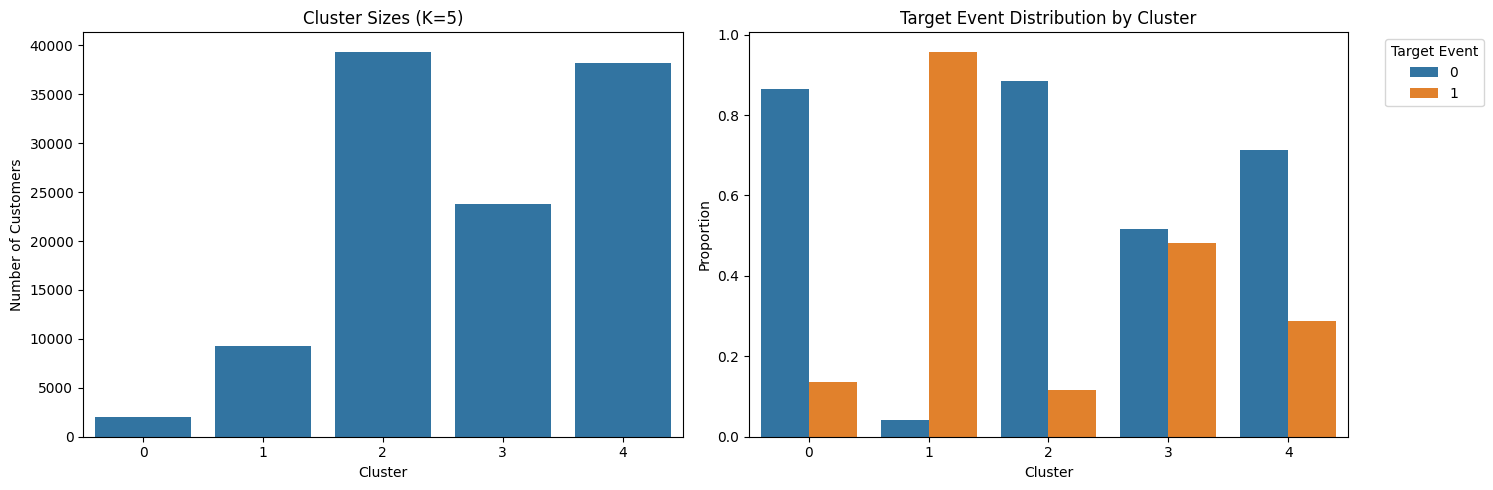

✓ Success: K=5, Features=9

--- Grid Search Experiment 113/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39411 customers (35.00%)
  Cluster 1: 35581 customers (31.60%)
  Cluster 2: 5636 customers (5.00%)
  Cluster 3: 10169 customers (9.03%)
  Cluster 4: 19805 customers (17.59%)
  Cluster 5: 2008 customers (1.78%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.26              0.68          0.99        18.07
1        -9.07              0.42          0.68        45.54
2         3.52              0.33          0.4

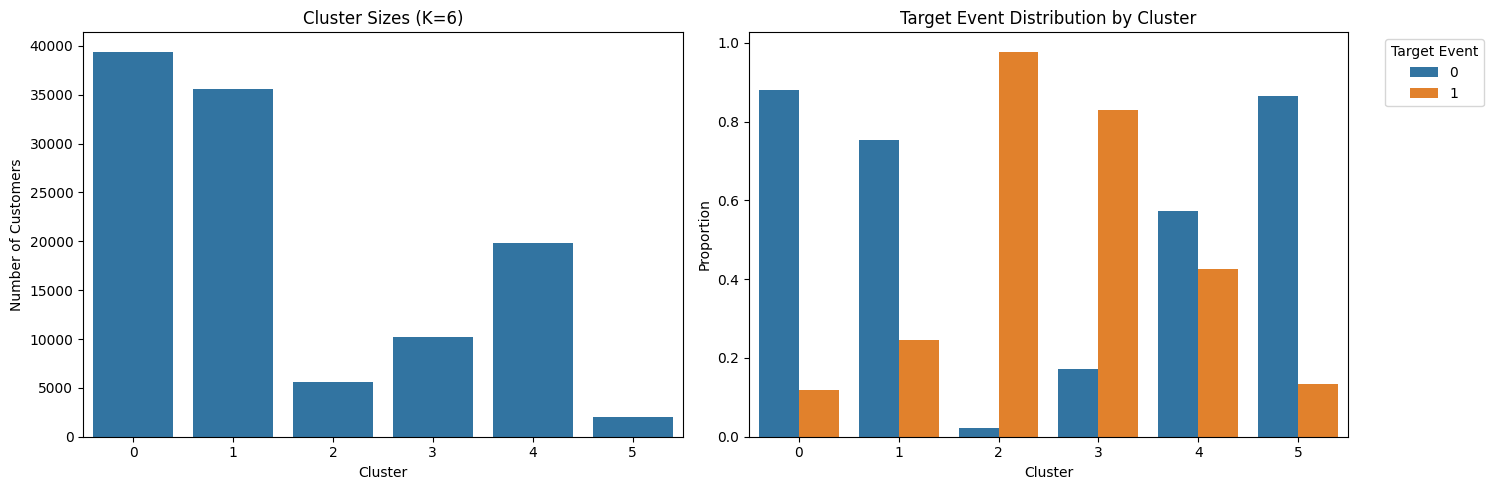

✓ Success: K=6, Features=9

--- Grid Search Experiment 114/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=12
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1926 customers (1.71%)
  Cluster 1: 5892 customers (5.23%)
  Cluster 2: 23304 customers (20.69%)
  Cluster 3: 26314 customers (23.37%)
  Cluster 4: 9789 customers (8.69%)
  Cluster 5: 12054 customers (10.70%)
  Cluster 6: 33331 customers (29.60%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.31              0.93          0.84         9.38
1         3.33              0.32          0.42       123.29
2        -8.80              0.34          0.61        60.43
3       -1

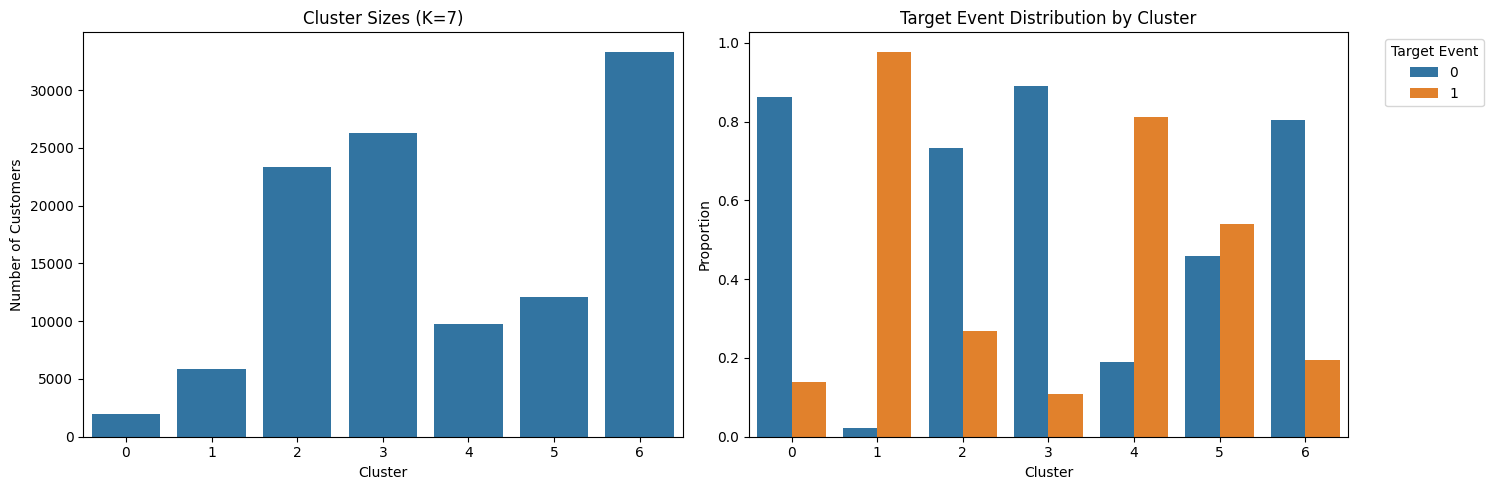

✓ Success: K=7, Features=9

--- Grid Search Experiment 115/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=10, max_k=15


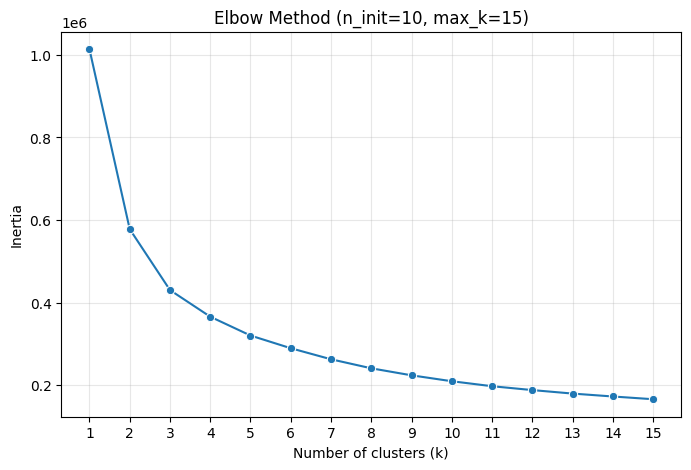

Rate of change analysis:
K=2, First diff=-435470.61, Second diff=287967.43
K=3, First diff=-147503.18, Second diff=83082.74
K=4, First diff=-64420.44, Second diff=18840.92
K=5, First diff=-45579.52, Second diff=14842.66
K=6, First diff=-30736.85, Second diff=3990.46
K=7, First diff=-26746.39, Second diff=4888.00
K=8, First diff=-21858.39, Second diff=4882.23
K=9, First diff=-16976.16, Second diff=2658.90
K=10, First diff=-14317.26, Second diff=2264.28
K=11, First diff=-12052.98, Second diff=2686.56
K=12, First diff=-9366.42, Second diff=918.59
K=13, First diff=-8447.83, Second diff=1395.57
K=14, First diff=-7052.26, Second diff=431.69
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70476 customers (62.58%)
  Cluster 1: 42134 customers (37.42%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 

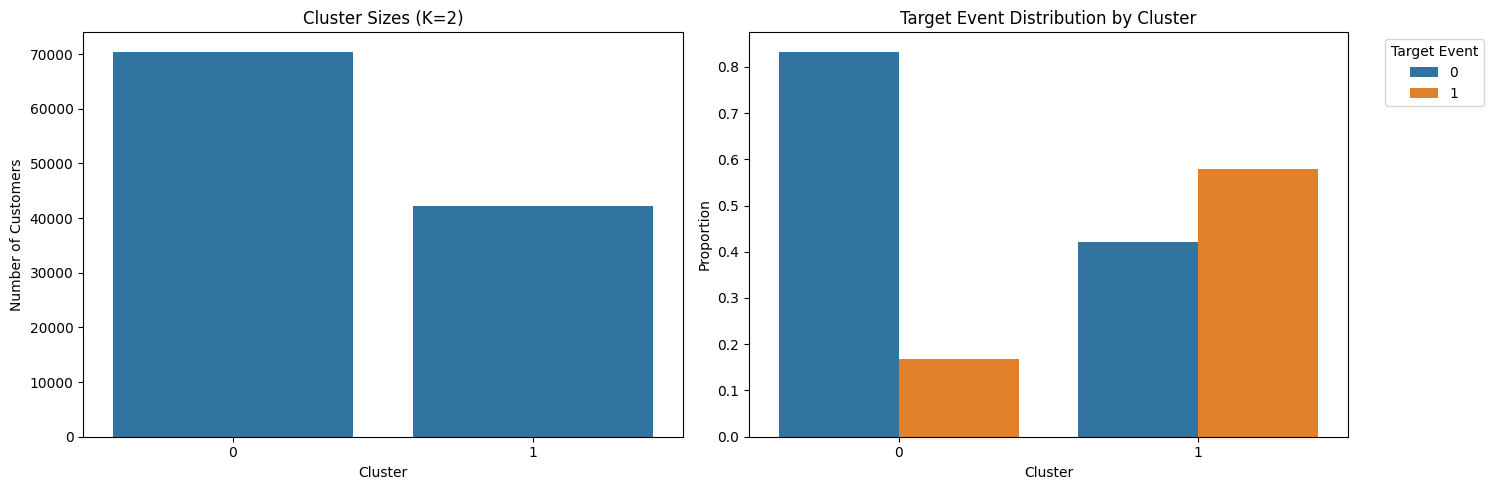

✓ Success: K=2, Features=9

--- Grid Search Experiment 116/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57726 customers (51.26%)
  Cluster 1: 10876 customers (9.66%)
  Cluster 2: 44008 customers (39.08%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.72              0.63          0.91        23.07
1         2.86              0.36          0.50       110.01
2        -6.64              0.37          0.63        67.38

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0 

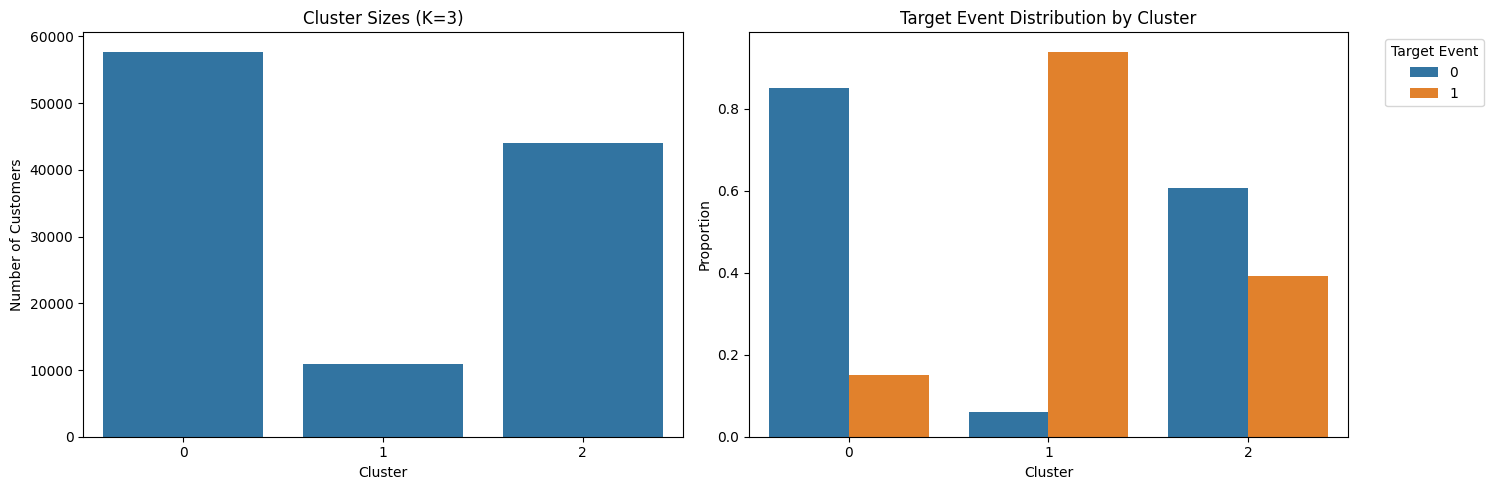

✓ Success: K=3, Features=9

--- Grid Search Experiment 117/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39383 customers (34.97%)
  Cluster 1: 9271 customers (8.23%)
  Cluster 2: 39245 customers (34.85%)
  Cluster 3: 24711 customers (21.94%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -8.45              0.43          0.68        45.49
1         3.02              0.34          0.45       111.48
2       -11.42              0.70          1.00        16.67
3        -5.14              0.36          0.63        81.52

Target Event Distribution by Cluster:
target_event      0  

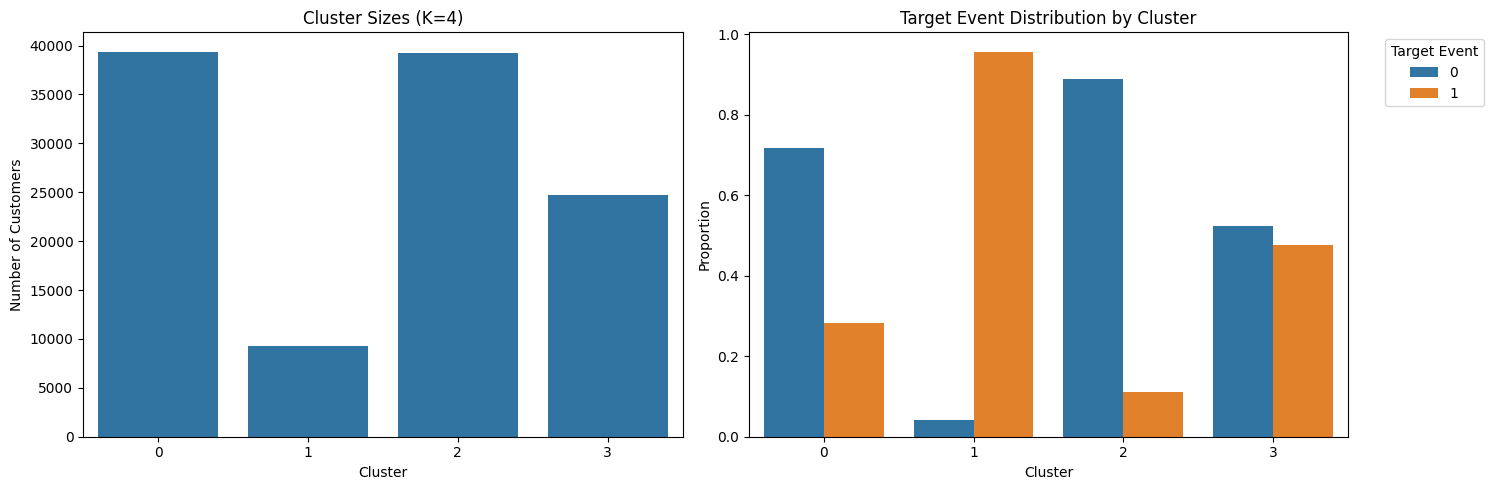

✓ Success: K=4, Features=9

--- Grid Search Experiment 118/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1998 customers (1.77%)
  Cluster 1: 9227 customers (8.19%)
  Cluster 2: 39373 customers (34.96%)
  Cluster 3: 23841 customers (21.17%)
  Cluster 4: 38171 customers (33.90%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.35              0.90          0.82         9.47
1         3.02              0.34          0.45       111.48
2       -11.32              0.68          1.00        17.92
3        -5.03              0.37          0.64        82.28
4        -8.37          

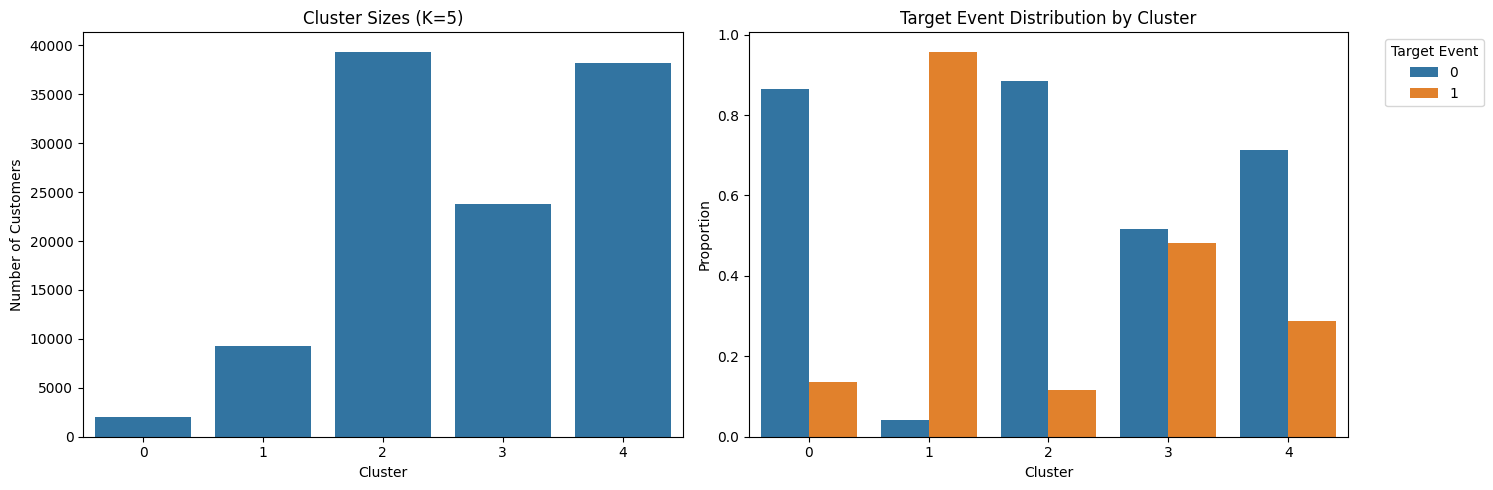

✓ Success: K=5, Features=9

--- Grid Search Experiment 119/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39411 customers (35.00%)
  Cluster 1: 35581 customers (31.60%)
  Cluster 2: 5636 customers (5.00%)
  Cluster 3: 10169 customers (9.03%)
  Cluster 4: 19805 customers (17.59%)
  Cluster 5: 2008 customers (1.78%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.26              0.68          0.99        18.07
1        -9.07              0.42          0.68        45.54
2         3.52              0.33          0.43       124.62
3         0.71              0.38          0.52 

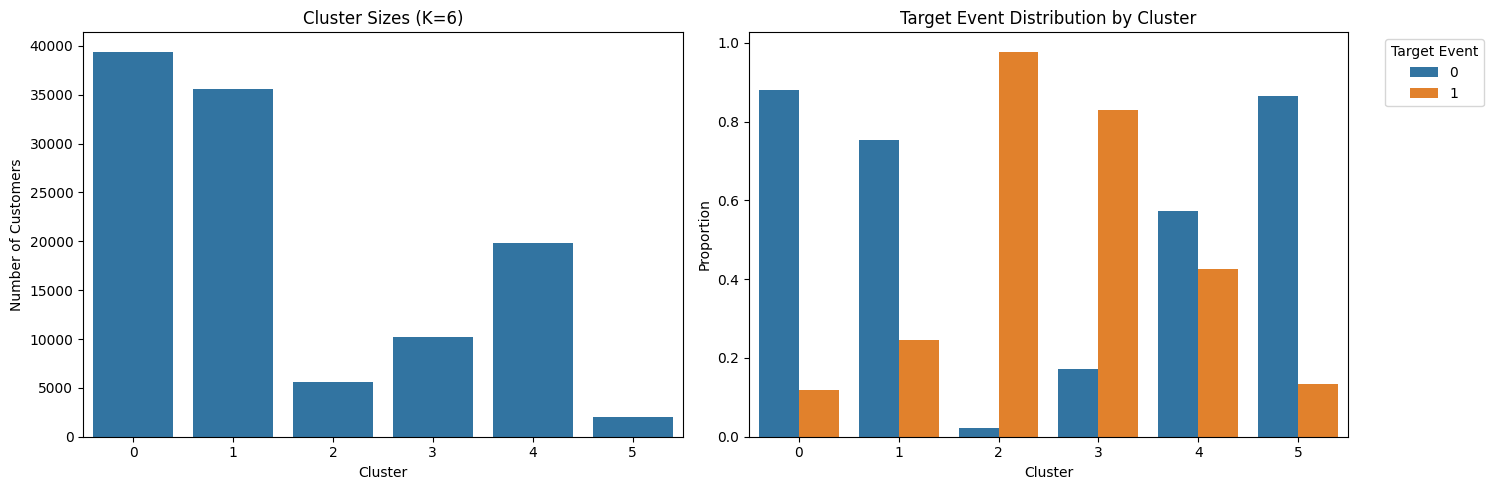

✓ Success: K=6, Features=9

--- Grid Search Experiment 120/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=10, max_k=15
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 1926 customers (1.71%)
  Cluster 1: 5892 customers (5.23%)
  Cluster 2: 23304 customers (20.69%)
  Cluster 3: 26314 customers (23.37%)
  Cluster 4: 9789 customers (8.69%)
  Cluster 5: 12054 customers (10.70%)
  Cluster 6: 33331 customers (29.60%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.31              0.93          0.84         9.38
1         3.33              0.32          0.42       123.29
2        -8.80              0.34          0.61        60.43
3       -1

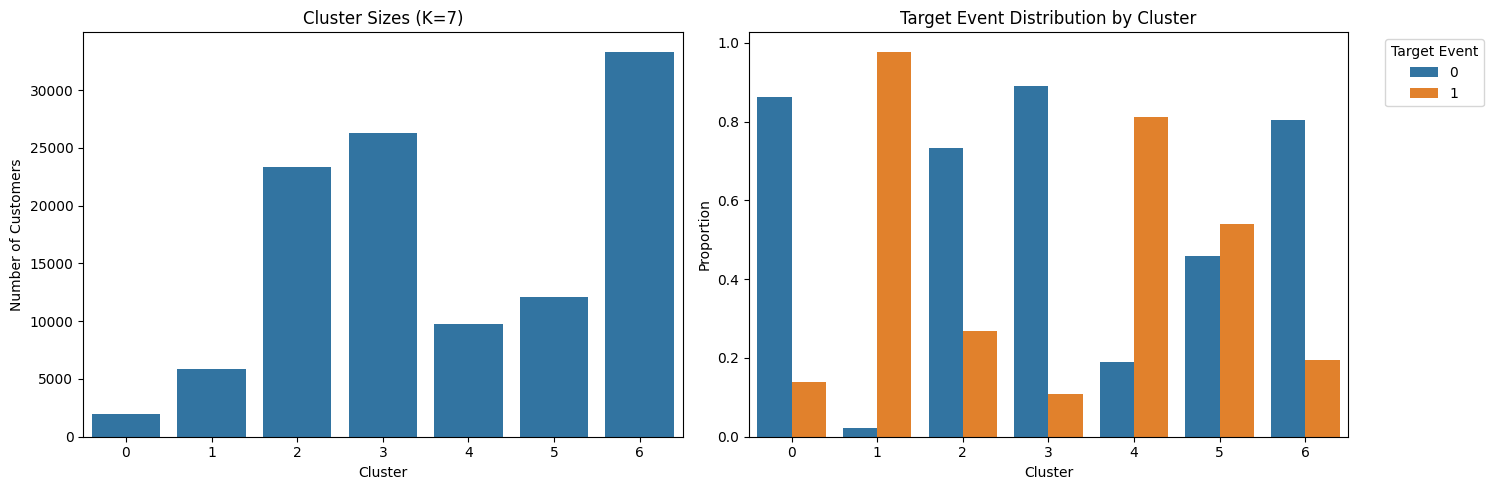

✓ Success: K=7, Features=9

--- Grid Search Experiment 121/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=auto, max_k=8


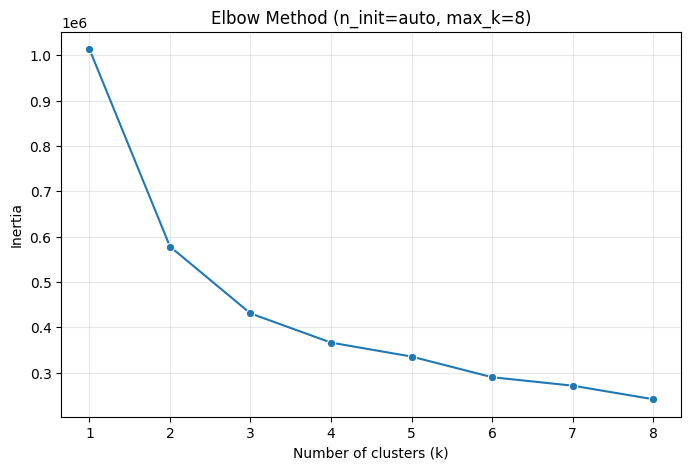

Rate of change analysis:
K=2, First diff=-435468.86, Second diff=287964.04
K=3, First diff=-147504.82, Second diff=83091.65
K=4, First diff=-64413.17, Second diff=33588.77
K=5, First diff=-30824.40, Second diff=-14670.26
K=6, First diff=-45494.65, Second diff=26819.15
K=7, First diff=-18675.51, Second diff=-11249.65
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70511 customers (62.62%)
  Cluster 1: 42099 customers (37.38%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59          0.87        27.77
1        -3.43              0.36          0.59        83.98

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0        

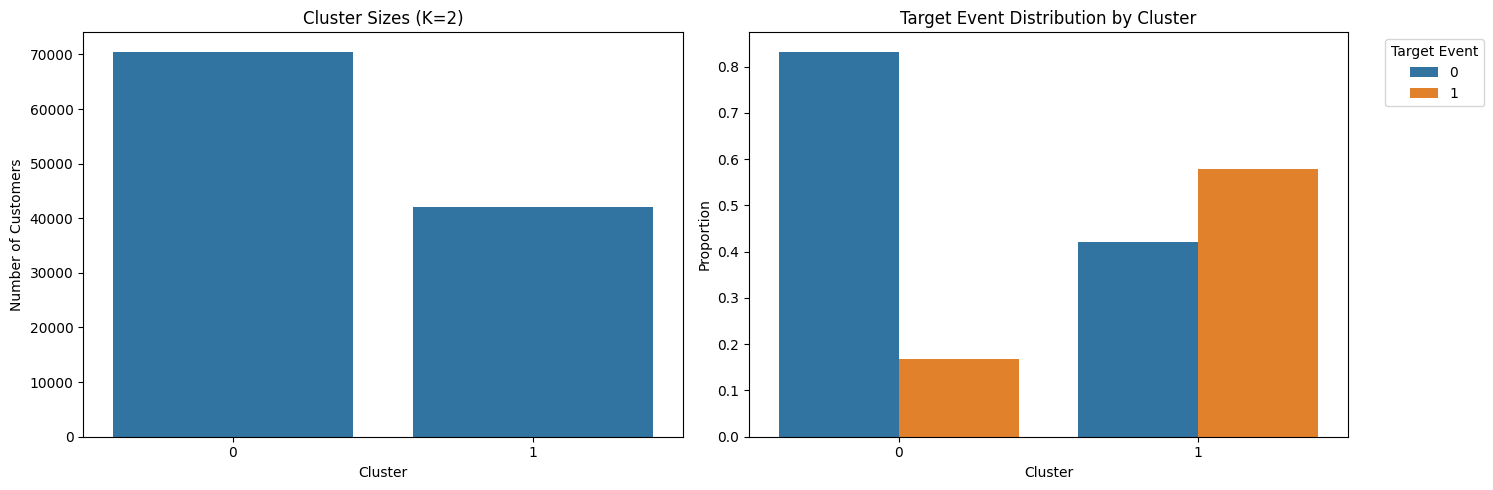

✓ Success: K=2, Features=9

--- Grid Search Experiment 122/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57866 customers (51.39%)
  Cluster 1: 43914 customers (39.00%)
  Cluster 2: 10830 customers (9.62%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.71              0.63          0.91        23.12
1        -6.63              0.37          0.63        67.49
2         2.86              0.36          0.50       110.07

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.150
1             0.607  0.393
2        

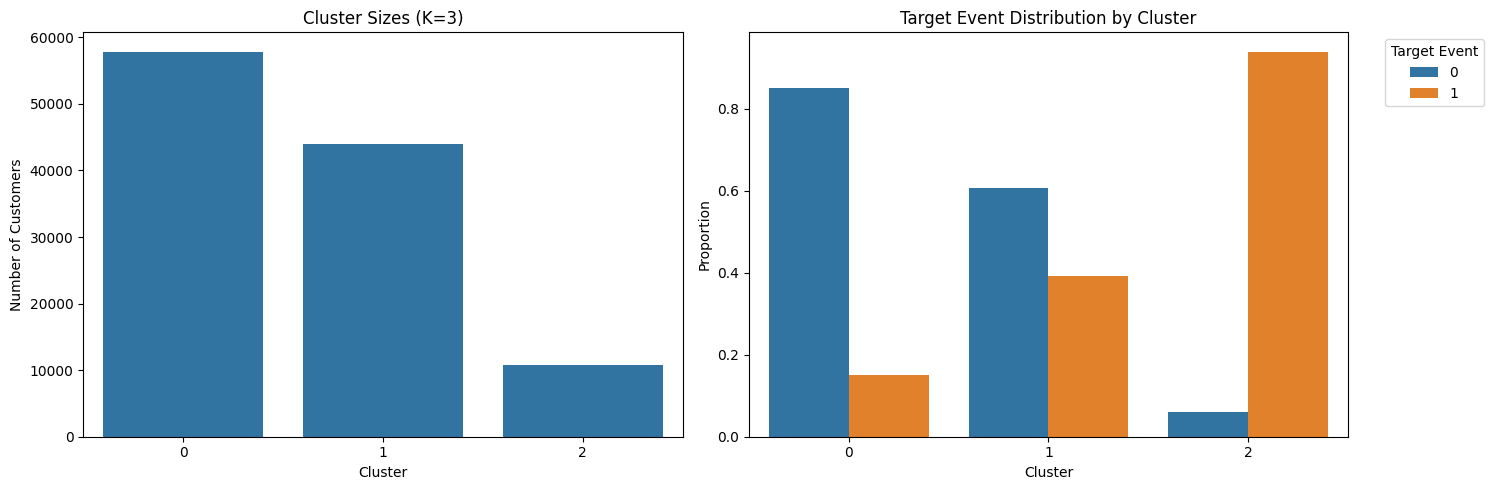

✓ Success: K=3, Features=9

--- Grid Search Experiment 123/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39733 customers (35.28%)
  Cluster 1: 39273 customers (34.88%)
  Cluster 2: 24352 customers (21.63%)
  Cluster 3: 9252 customers (8.22%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.41              0.69          0.99        16.84
1        -8.41              0.43          0.68        45.84
2        -5.10              0.37          0.63        81.83
3         3.02              0.34          0.45       111.47

Target Event Distribution by Cluster:
target_event      0 

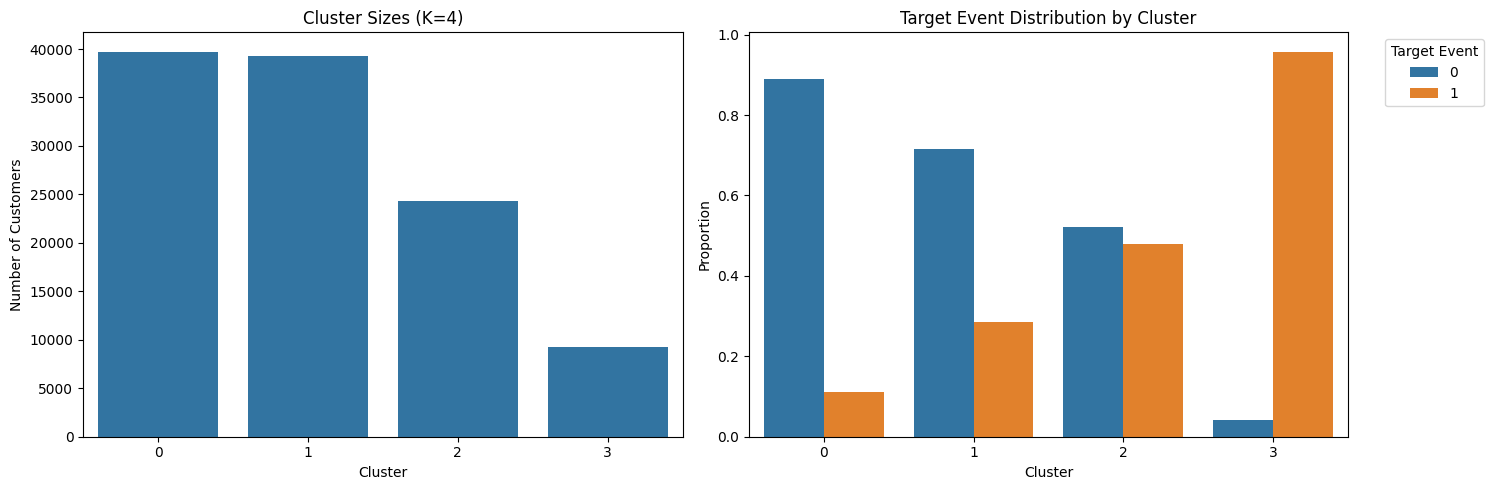

✓ Success: K=4, Features=9

--- Grid Search Experiment 124/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 38246 customers (33.96%)
  Cluster 1: 22027 customers (19.56%)
  Cluster 2: 10534 customers (9.35%)
  Cluster 3: 5287 customers (4.69%)
  Cluster 4: 36516 customers (32.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.10              0.44          0.70        42.71
1        -6.45              0.37          0.65        79.41
2         0.86              0.37          0.52        82.47
3         3.63              0.34          0.44       125.75
4       -11.45        

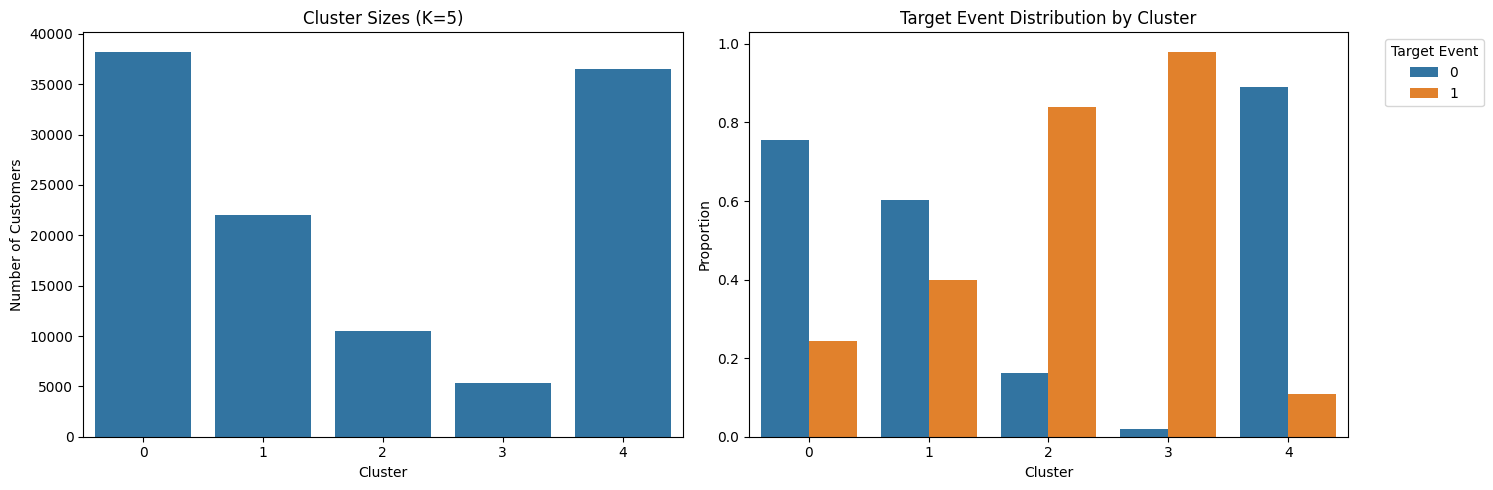

✓ Success: K=5, Features=9

--- Grid Search Experiment 125/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39437 customers (35.02%)
  Cluster 1: 19776 customers (17.56%)
  Cluster 2: 35430 customers (31.46%)
  Cluster 3: 5722 customers (5.08%)
  Cluster 4: 2004 customers (1.78%)
  Cluster 5: 10241 customers (9.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.25              0.68          0.99        18.09
1        -5.93              0.37          0.65        82.73
2        -9.11              0.42          0.68        45.50
3         3.51              0.33          0.43

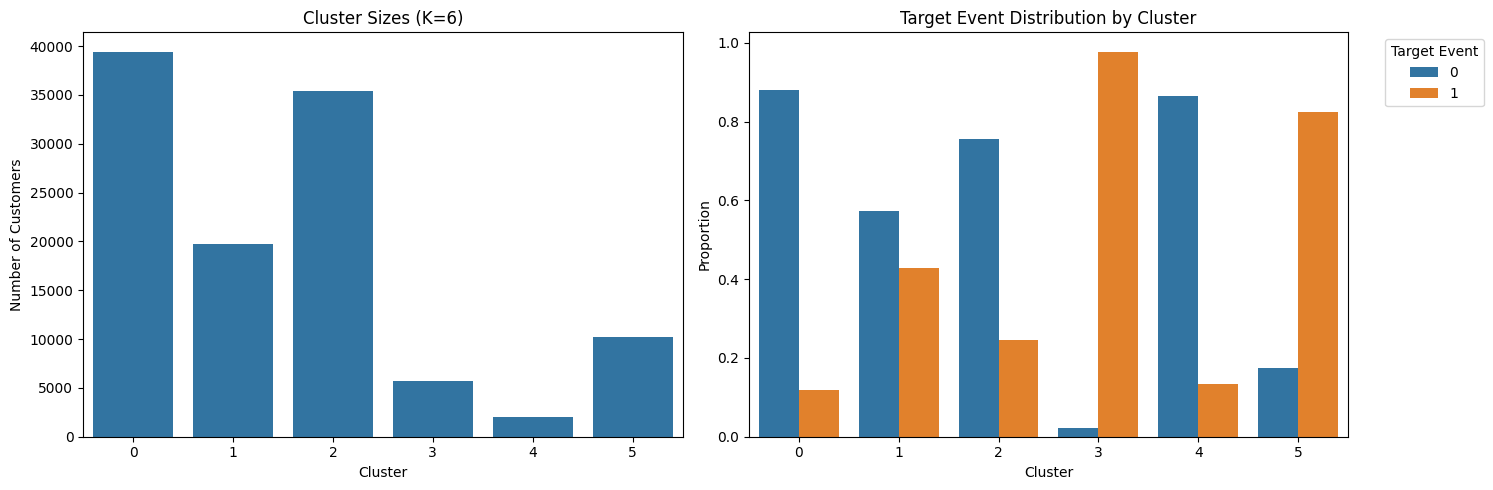

✓ Success: K=6, Features=9

--- Grid Search Experiment 126/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=8
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39052 customers (34.68%)
  Cluster 1: 19753 customers (17.54%)
  Cluster 2: 11290 customers (10.03%)
  Cluster 3: 3674 customers (3.26%)
  Cluster 4: 1918 customers (1.70%)
  Cluster 5: 8383 customers (7.44%)
  Cluster 6: 28540 customers (25.34%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.33              0.68          1.00        18.00
1        -6.15              0.37          0.65        81.37
2        -2.89              0.44          0.60        54.20
3        

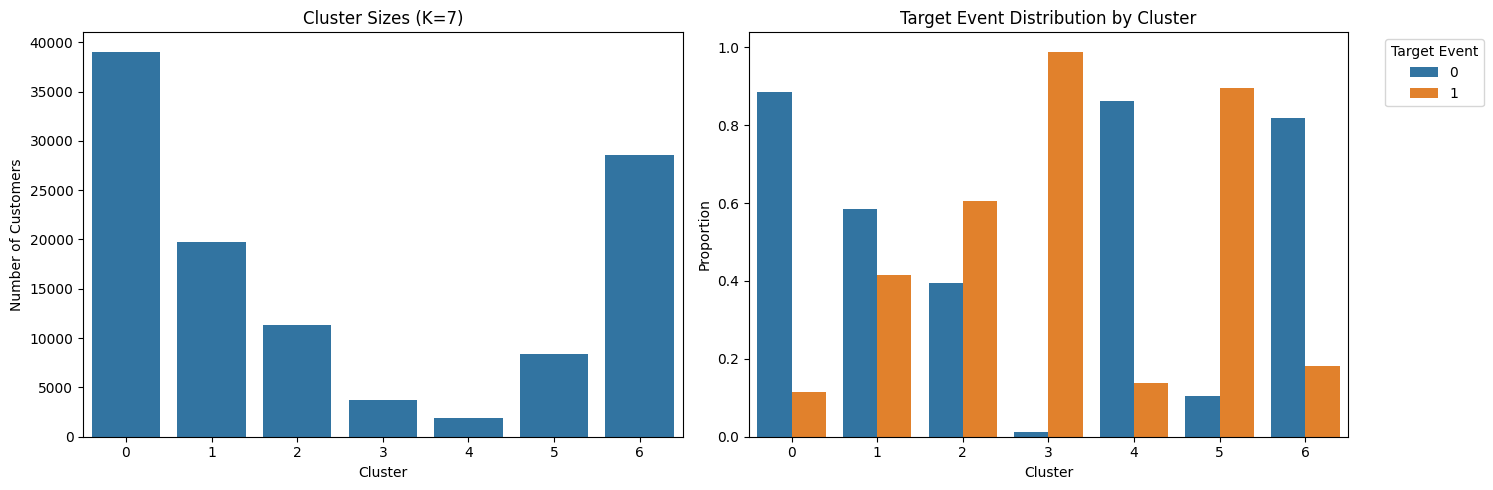

✓ Success: K=7, Features=9

--- Grid Search Experiment 127/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=auto, max_k=10
Finding optimal clusters: n_init=auto, max_k=10


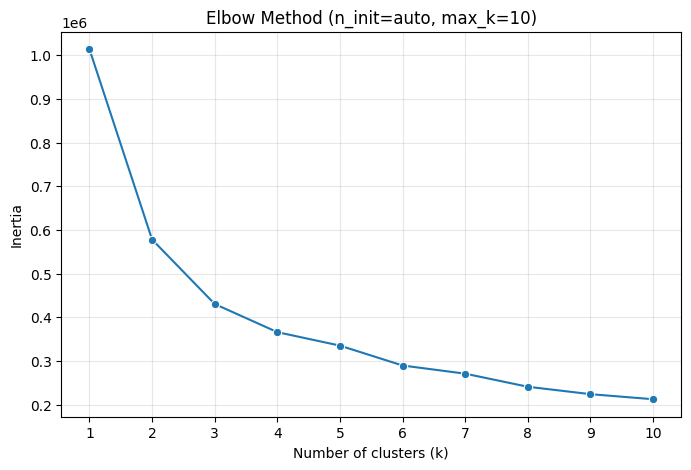

Rate of change analysis:
K=2, First diff=-435468.86, Second diff=287964.04
K=3, First diff=-147504.82, Second diff=83091.65
K=4, First diff=-64413.17, Second diff=33588.77
K=5, First diff=-30824.40, Second diff=-14670.26
K=6, First diff=-45494.65, Second diff=26819.15
K=7, First diff=-18675.51, Second diff=-11249.65
K=8, First diff=-29925.16, Second diff=12943.24
K=9, First diff=-16981.92, Second diff=5426.46
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70511 customers (62.62%)
  Cluster 1: 42099 customers (37.38%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.59          0.87        27.77
1        -3.43              0.36          0.59        83.98

Target

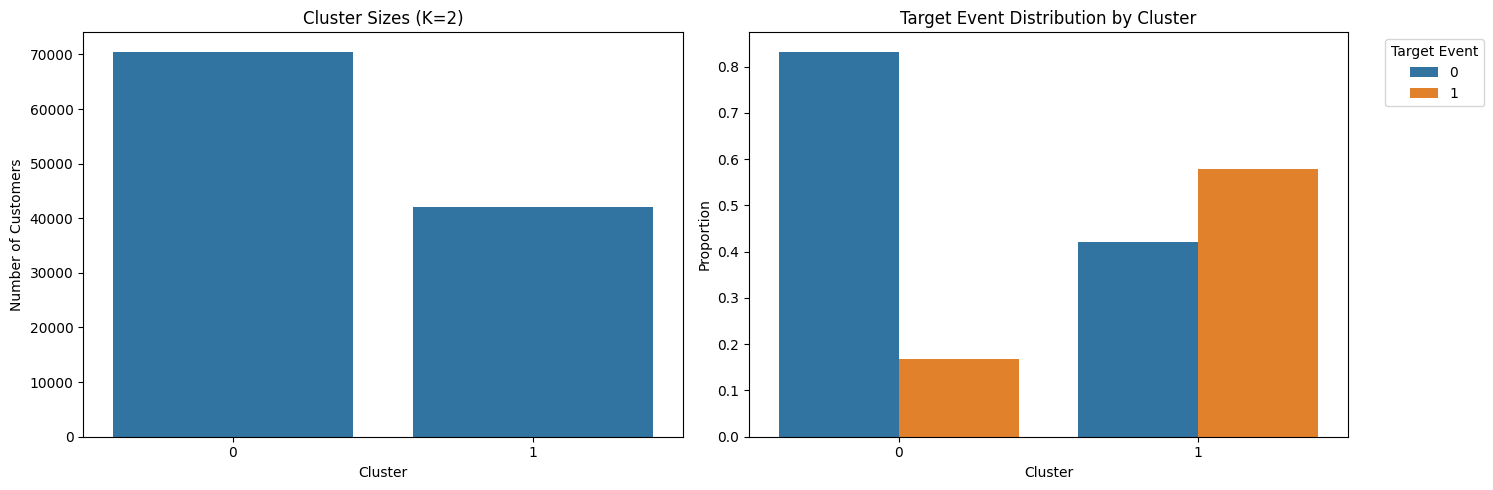

✓ Success: K=2, Features=9

--- Grid Search Experiment 128/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57866 customers (51.39%)
  Cluster 1: 43914 customers (39.00%)
  Cluster 2: 10830 customers (9.62%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.71              0.63          0.91        23.12
1        -6.63              0.37          0.63        67.49
2         2.86              0.36          0.50       110.07

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.150
1             0.607  0.393
2       

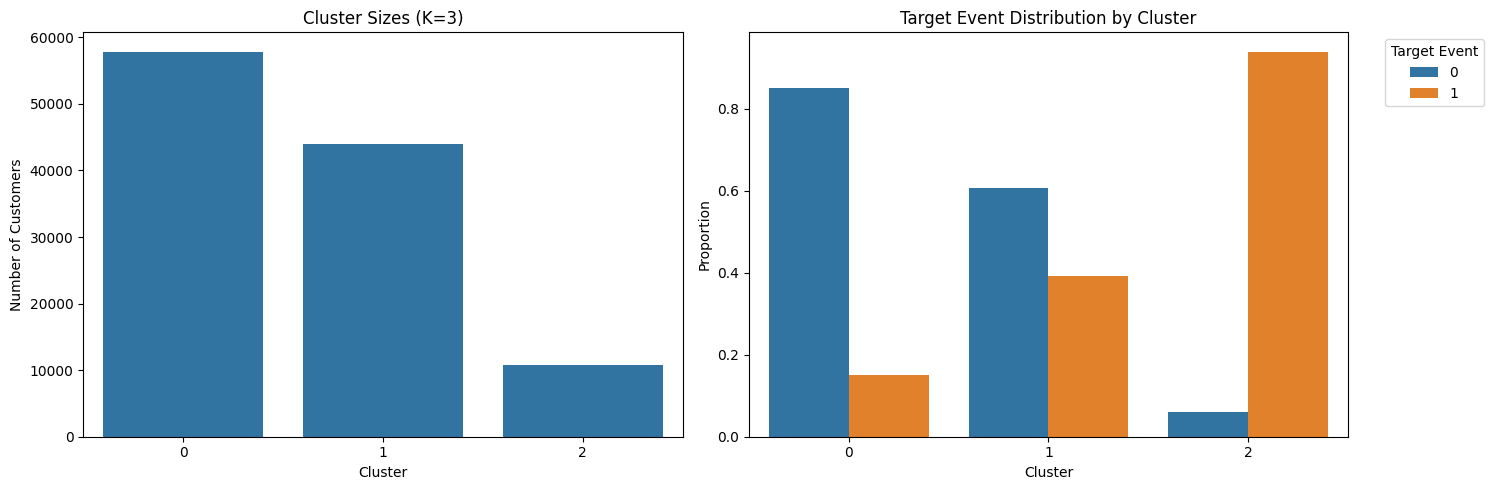

✓ Success: K=3, Features=9

--- Grid Search Experiment 129/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39733 customers (35.28%)
  Cluster 1: 39273 customers (34.88%)
  Cluster 2: 24352 customers (21.63%)
  Cluster 3: 9252 customers (8.22%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.41              0.69          0.99        16.84
1        -8.41              0.43          0.68        45.84
2        -5.10              0.37          0.63        81.83
3         3.02              0.34          0.45       111.47

Target Event Distribution by Cluster:
target_event      0

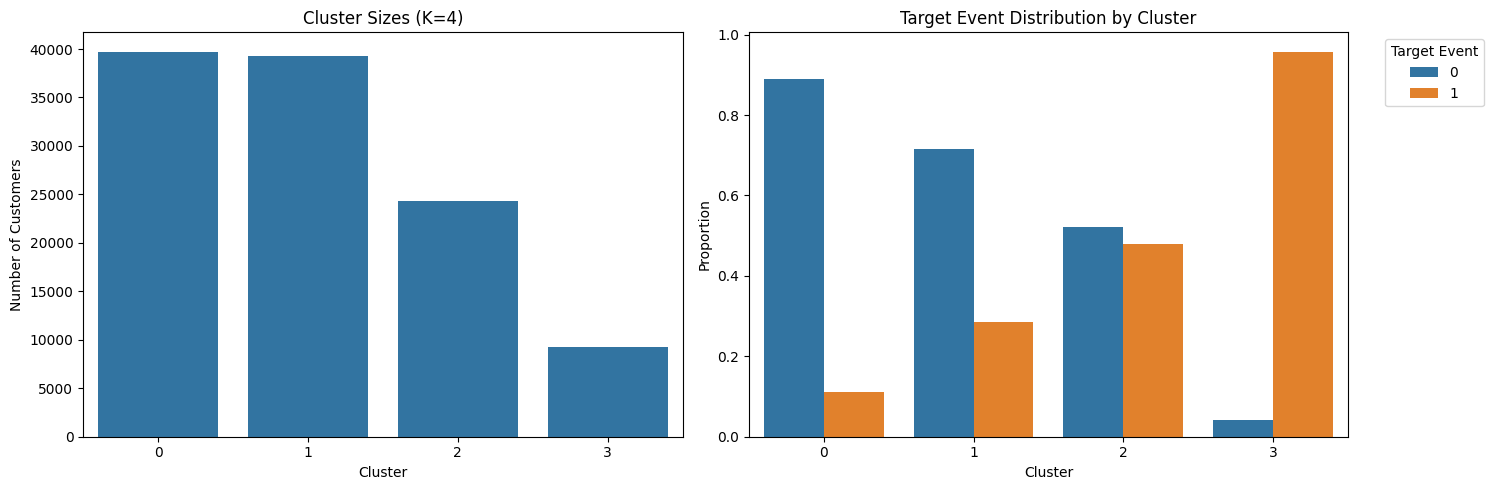

✓ Success: K=4, Features=9

--- Grid Search Experiment 130/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 38246 customers (33.96%)
  Cluster 1: 22027 customers (19.56%)
  Cluster 2: 10534 customers (9.35%)
  Cluster 3: 5287 customers (4.69%)
  Cluster 4: 36516 customers (32.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.10              0.44          0.70        42.71
1        -6.45              0.37          0.65        79.41
2         0.86              0.37          0.52        82.47
3         3.63              0.34          0.44       125.75
4       -11.45       

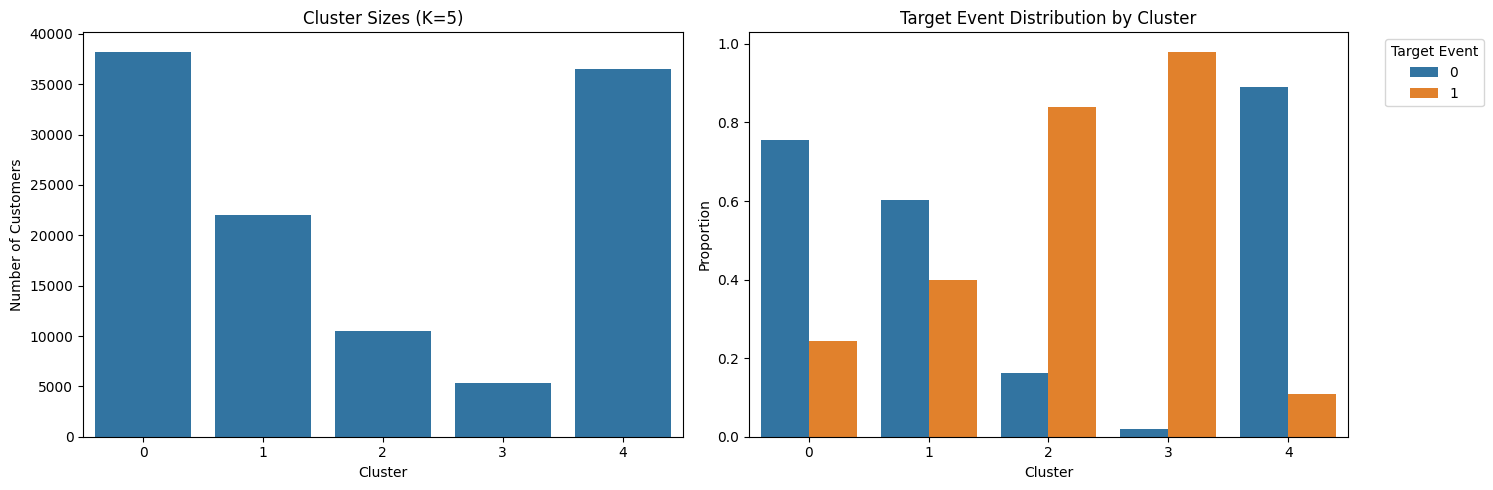

✓ Success: K=5, Features=9

--- Grid Search Experiment 131/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39437 customers (35.02%)
  Cluster 1: 19776 customers (17.56%)
  Cluster 2: 35430 customers (31.46%)
  Cluster 3: 5722 customers (5.08%)
  Cluster 4: 2004 customers (1.78%)
  Cluster 5: 10241 customers (9.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.25              0.68          0.99        18.09
1        -5.93              0.37          0.65        82.73
2        -9.11              0.42          0.68        45.50
3         3.51              0.33          0.4

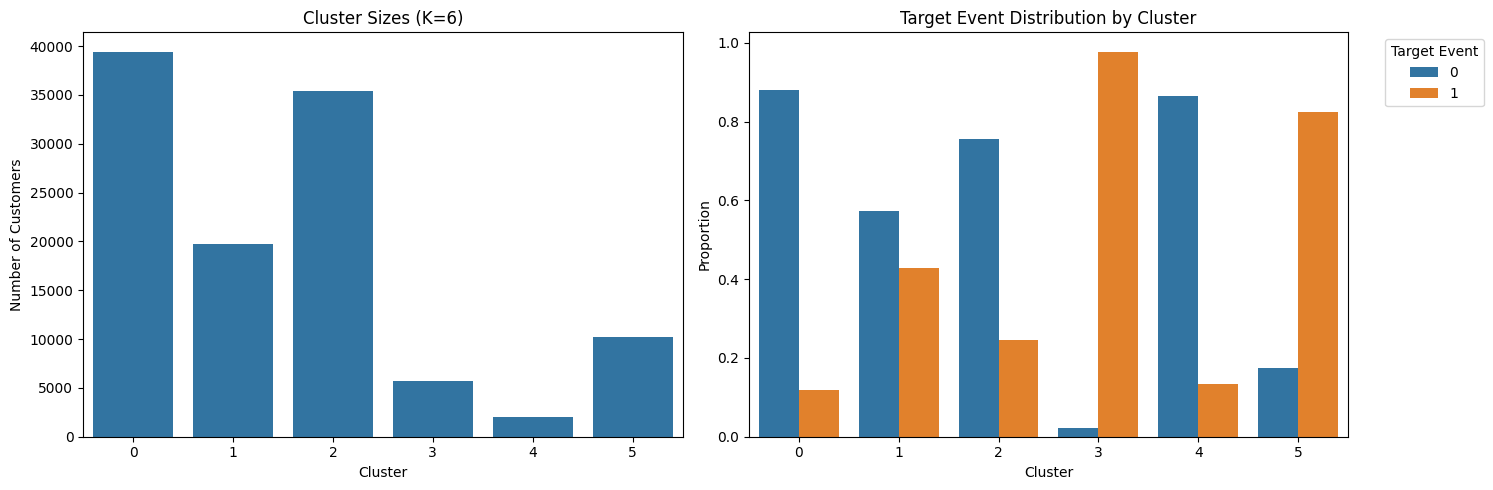

✓ Success: K=6, Features=9

--- Grid Search Experiment 132/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=10
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39052 customers (34.68%)
  Cluster 1: 19753 customers (17.54%)
  Cluster 2: 11290 customers (10.03%)
  Cluster 3: 3674 customers (3.26%)
  Cluster 4: 1918 customers (1.70%)
  Cluster 5: 8383 customers (7.44%)
  Cluster 6: 28540 customers (25.34%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.33              0.68          1.00        18.00
1        -6.15              0.37          0.65        81.37
2        -2.89              0.44          0.60        54.20
3       

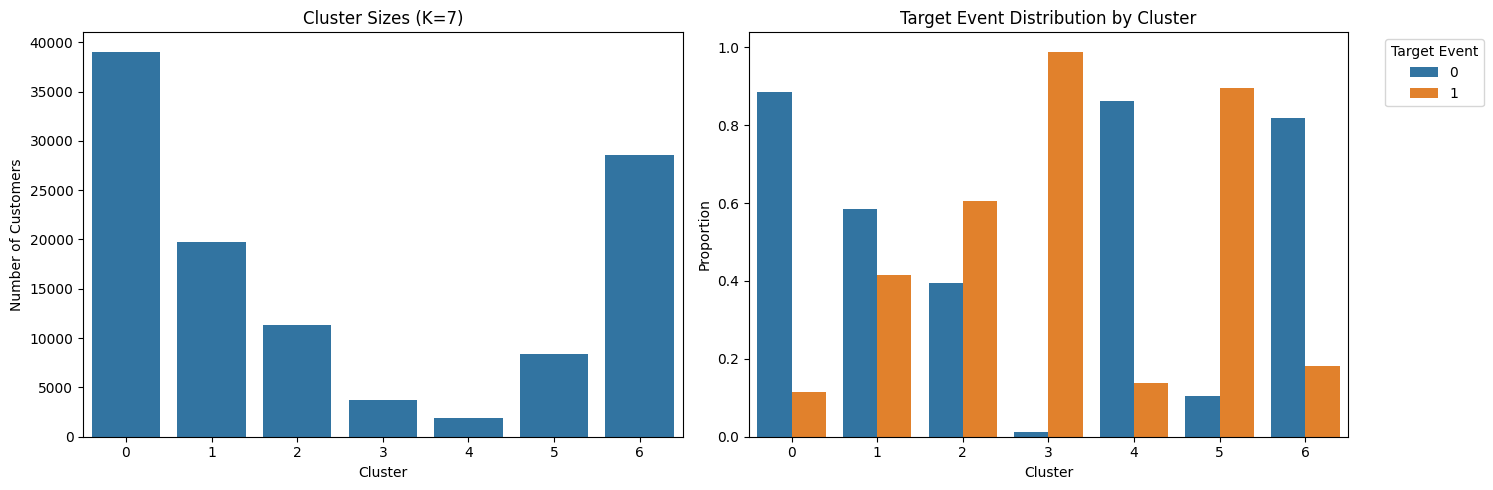

✓ Success: K=7, Features=9

--- Grid Search Experiment 133/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=auto, max_k=12


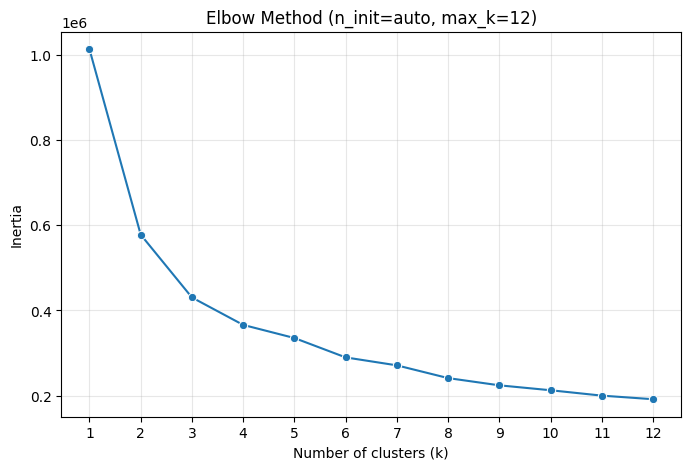

Rate of change analysis:
K=2, First diff=-435468.86, Second diff=287964.04
K=3, First diff=-147504.82, Second diff=83091.65
K=4, First diff=-64413.17, Second diff=33588.77
K=5, First diff=-30824.40, Second diff=-14670.26
K=6, First diff=-45494.65, Second diff=26819.15
K=7, First diff=-18675.51, Second diff=-11249.65
K=8, First diff=-29925.16, Second diff=12943.24
K=9, First diff=-16981.92, Second diff=5426.46
K=10, First diff=-11555.46, Second diff=-1068.00
K=11, First diff=-12623.46, Second diff=4184.97
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70511 customers (62.62%)
  Cluster 1: 42099 customers (37.38%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.43              0.

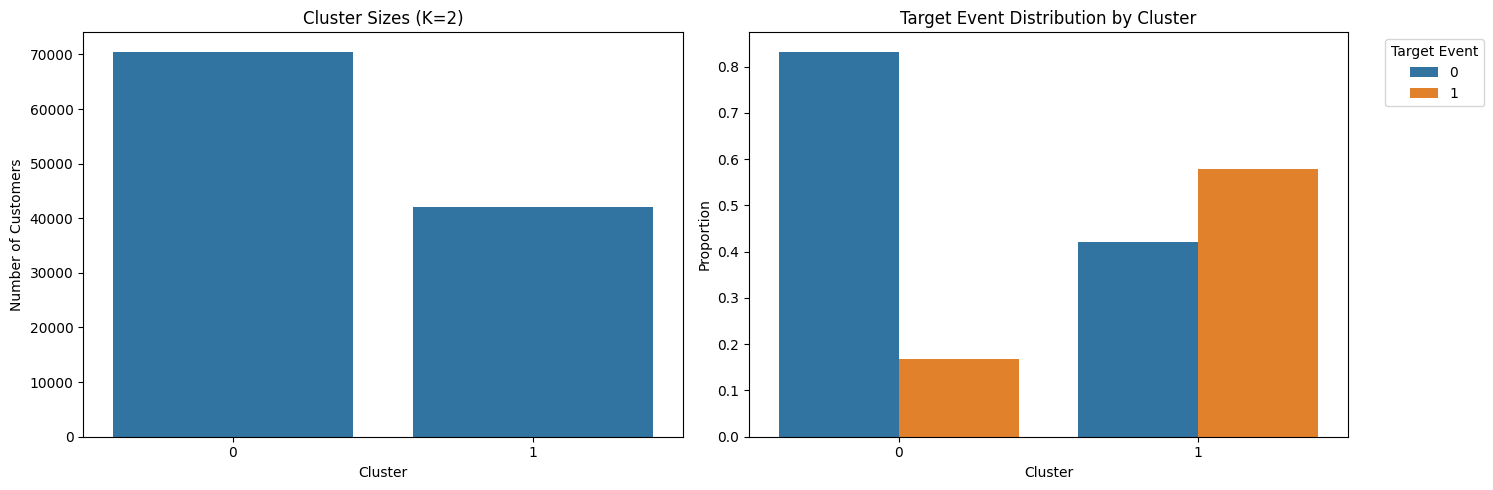

✓ Success: K=2, Features=9

--- Grid Search Experiment 134/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57866 customers (51.39%)
  Cluster 1: 43914 customers (39.00%)
  Cluster 2: 10830 customers (9.62%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.71              0.63          0.91        23.12
1        -6.63              0.37          0.63        67.49
2         2.86              0.36          0.50       110.07

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.150
1             0.607  0.393
2       

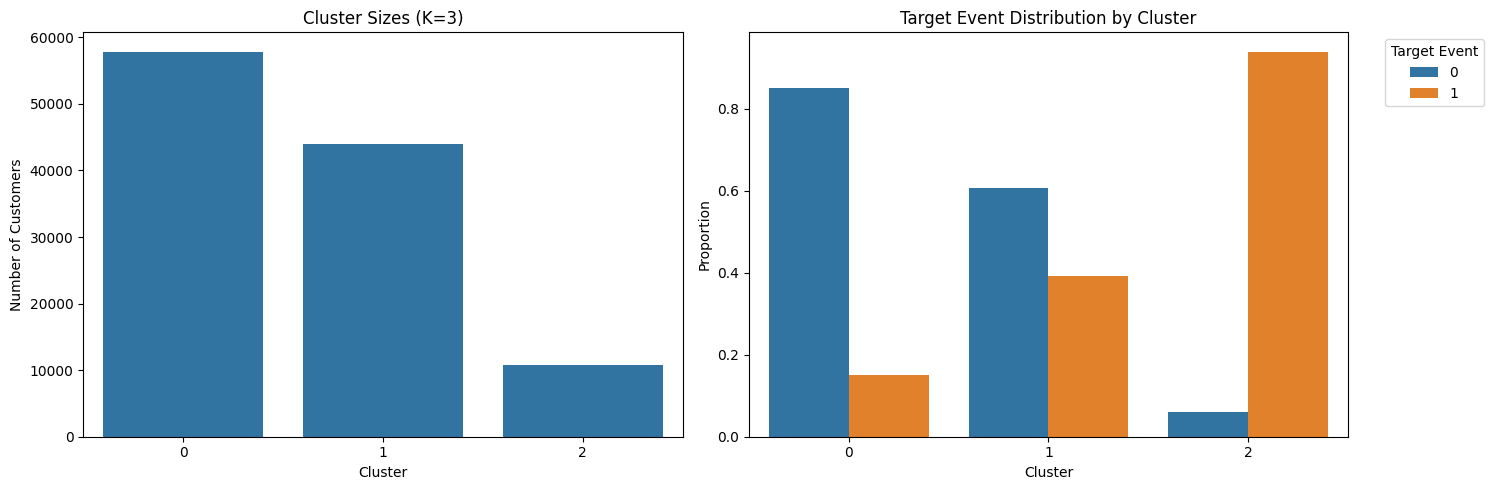

✓ Success: K=3, Features=9

--- Grid Search Experiment 135/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39733 customers (35.28%)
  Cluster 1: 39273 customers (34.88%)
  Cluster 2: 24352 customers (21.63%)
  Cluster 3: 9252 customers (8.22%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.41              0.69          0.99        16.84
1        -8.41              0.43          0.68        45.84
2        -5.10              0.37          0.63        81.83
3         3.02              0.34          0.45       111.47

Target Event Distribution by Cluster:
target_event      0

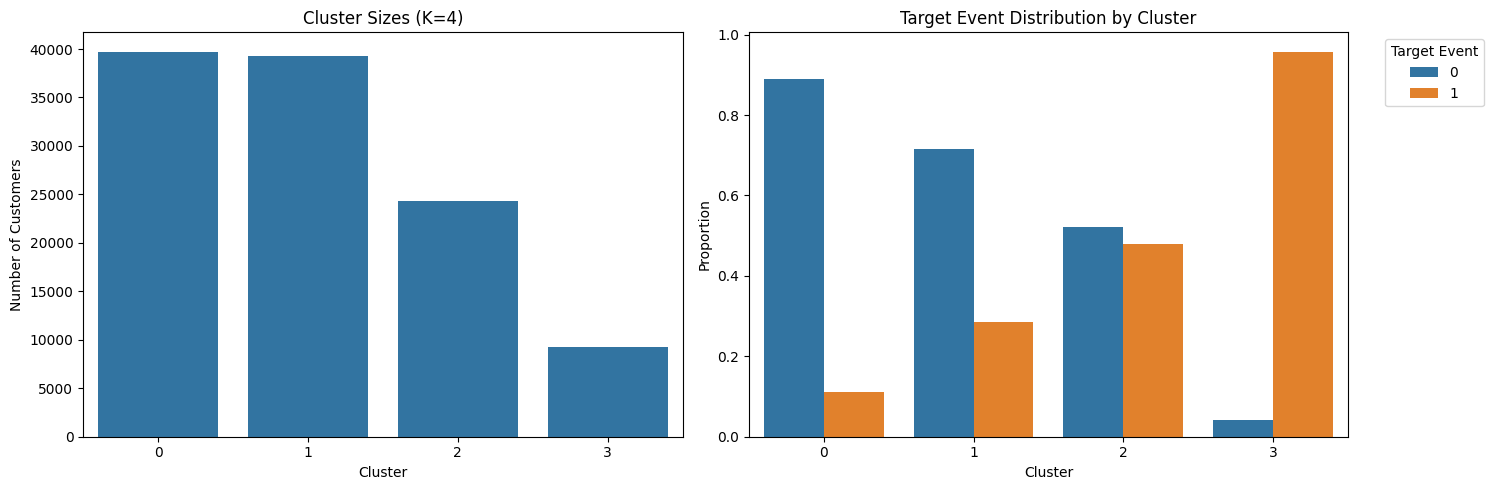

✓ Success: K=4, Features=9

--- Grid Search Experiment 136/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 38246 customers (33.96%)
  Cluster 1: 22027 customers (19.56%)
  Cluster 2: 10534 customers (9.35%)
  Cluster 3: 5287 customers (4.69%)
  Cluster 4: 36516 customers (32.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.10              0.44          0.70        42.71
1        -6.45              0.37          0.65        79.41
2         0.86              0.37          0.52        82.47
3         3.63              0.34          0.44       125.75
4       -11.45       

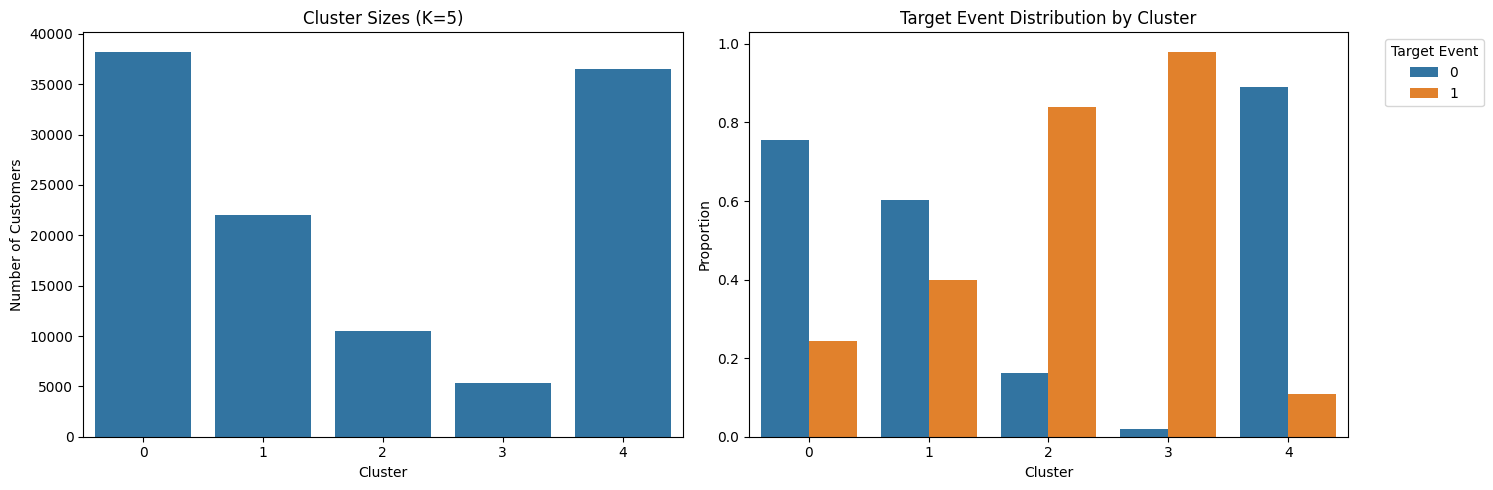

✓ Success: K=5, Features=9

--- Grid Search Experiment 137/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39437 customers (35.02%)
  Cluster 1: 19776 customers (17.56%)
  Cluster 2: 35430 customers (31.46%)
  Cluster 3: 5722 customers (5.08%)
  Cluster 4: 2004 customers (1.78%)
  Cluster 5: 10241 customers (9.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.25              0.68          0.99        18.09
1        -5.93              0.37          0.65        82.73
2        -9.11              0.42          0.68        45.50
3         3.51              0.33          0.4

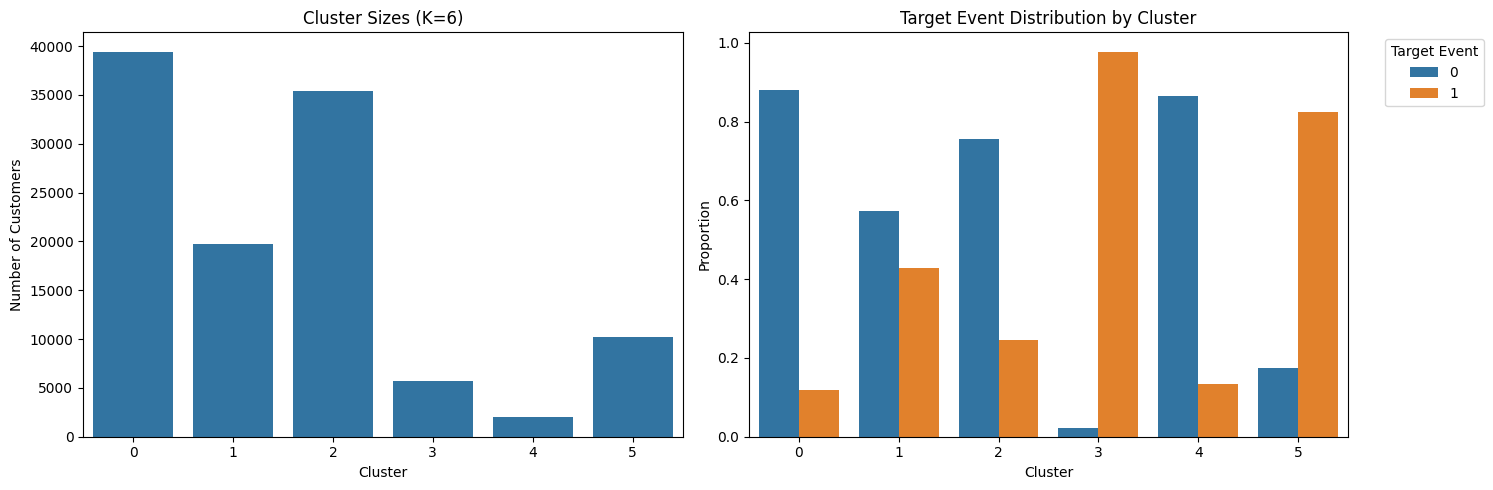

✓ Success: K=6, Features=9

--- Grid Search Experiment 138/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=12
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39052 customers (34.68%)
  Cluster 1: 19753 customers (17.54%)
  Cluster 2: 11290 customers (10.03%)
  Cluster 3: 3674 customers (3.26%)
  Cluster 4: 1918 customers (1.70%)
  Cluster 5: 8383 customers (7.44%)
  Cluster 6: 28540 customers (25.34%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.33              0.68          1.00        18.00
1        -6.15              0.37          0.65        81.37
2        -2.89              0.44          0.60        54.20
3       

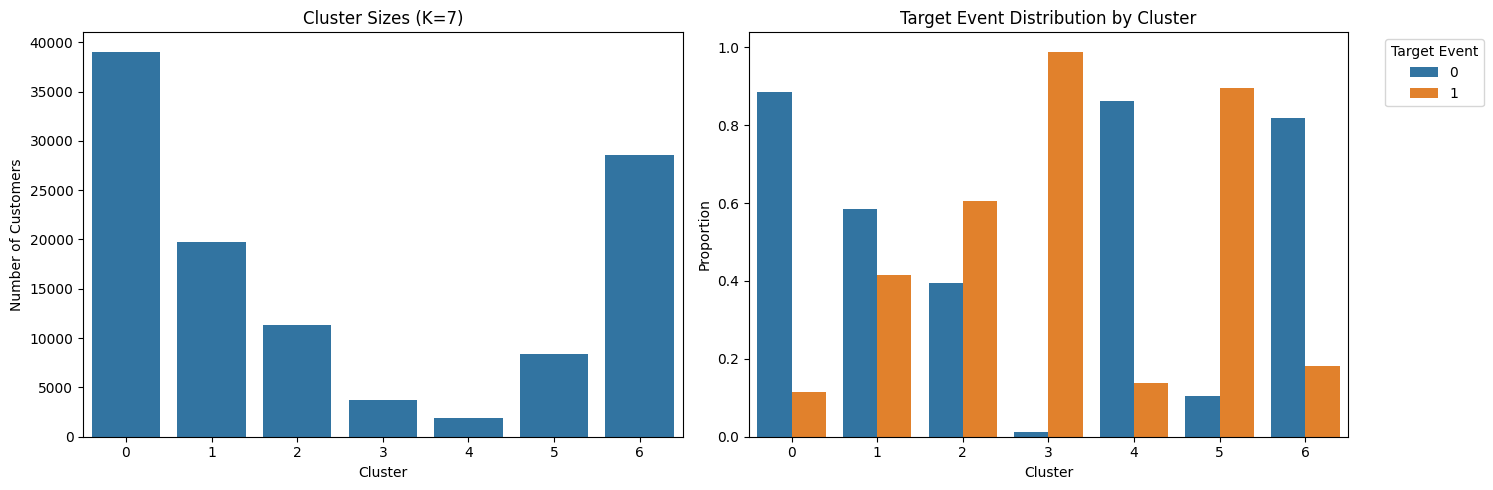

✓ Success: K=7, Features=9

--- Grid Search Experiment 139/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Threshold (0.3, -0.3): 9 features selected
Finding optimal clusters: n_init=auto, max_k=15


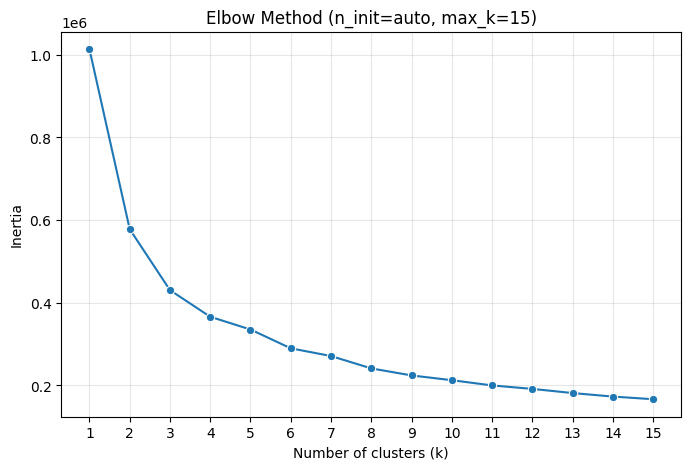

Rate of change analysis:
K=2, First diff=-435468.86, Second diff=287964.04
K=3, First diff=-147504.82, Second diff=83091.65
K=4, First diff=-64413.17, Second diff=33588.77
K=5, First diff=-30824.40, Second diff=-14670.26
K=6, First diff=-45494.65, Second diff=26819.15
K=7, First diff=-18675.51, Second diff=-11249.65
K=8, First diff=-29925.16, Second diff=12943.24
K=9, First diff=-16981.92, Second diff=5426.46
K=10, First diff=-11555.46, Second diff=-1068.00
K=11, First diff=-12623.46, Second diff=4184.97
K=12, First diff=-8438.49, Second diff=-1610.99
K=13, First diff=-10049.48, Second diff=1517.05
K=14, First diff=-8532.43, Second diff=2138.85
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 70511 customers (62.62%)
  Cluster 1: 42099 customers (37.38%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics An

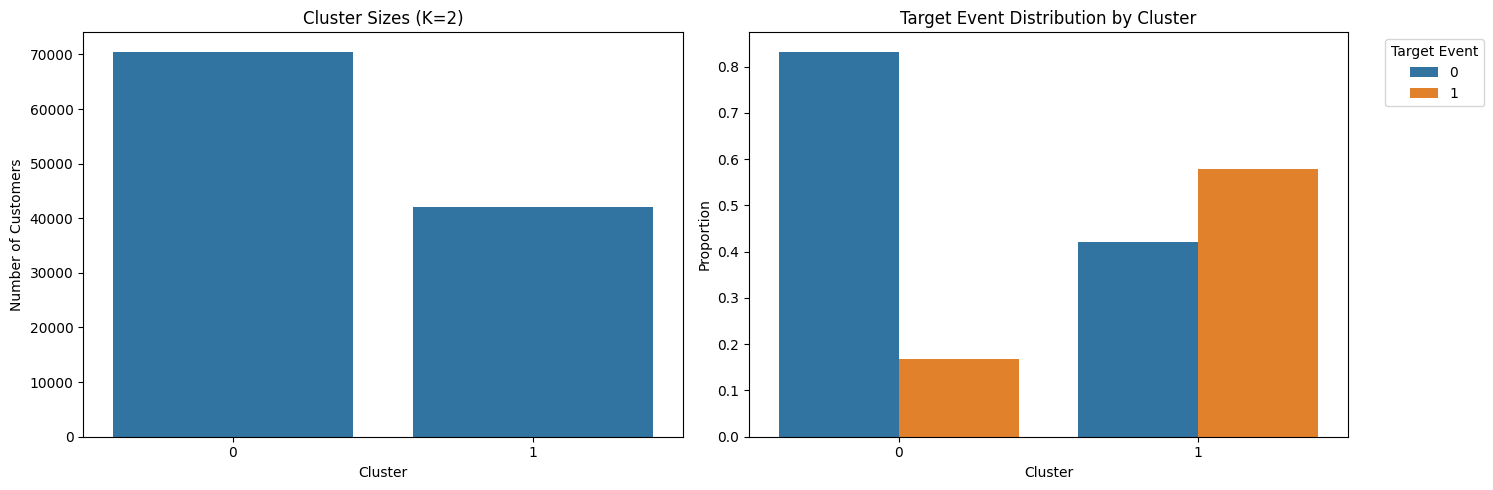

✓ Success: K=2, Features=9

--- Grid Search Experiment 140/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Manual K override: 3
Threshold (0.3, -0.3): 9 features selected
Using manual K = 3
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 57866 customers (51.39%)
  Cluster 1: 43914 customers (39.00%)
  Cluster 2: 10830 customers (9.62%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.71              0.63          0.91        23.12
1        -6.63              0.37          0.63        67.49
2         2.86              0.36          0.50       110.07

Target Event Distribution by Cluster:
target_event      0      1
cluster                   
0             0.850  0.150
1             0.607  0.393
2       

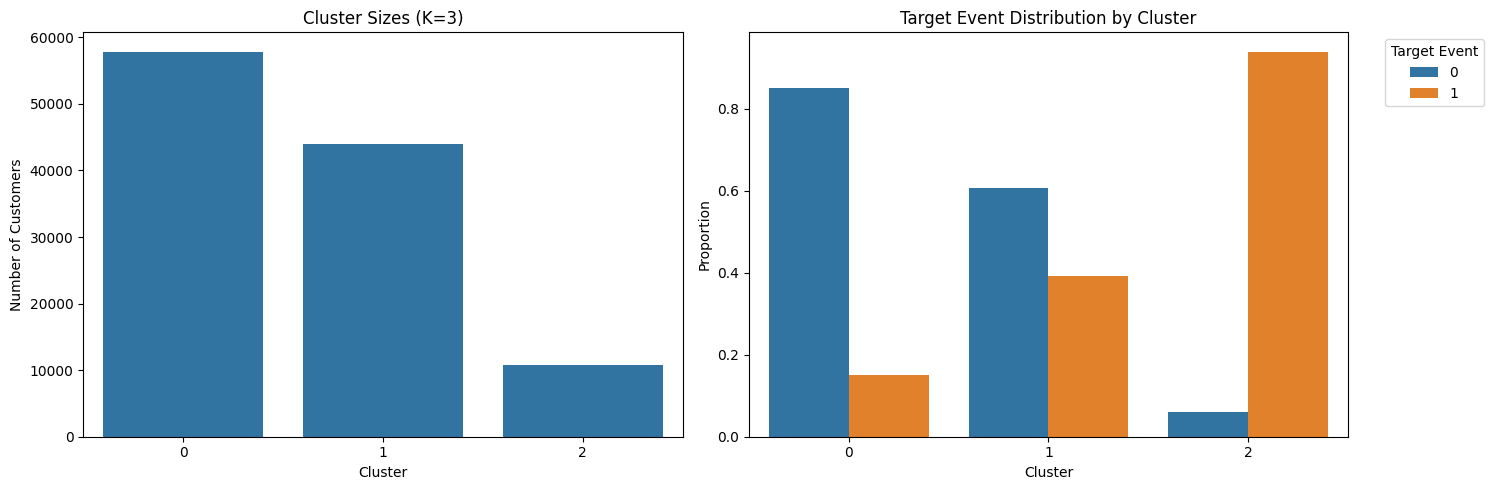

✓ Success: K=3, Features=9

--- Grid Search Experiment 141/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Manual K override: 4
Threshold (0.3, -0.3): 9 features selected
Using manual K = 4
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39733 customers (35.28%)
  Cluster 1: 39273 customers (34.88%)
  Cluster 2: 24352 customers (21.63%)
  Cluster 3: 9252 customers (8.22%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.41              0.69          0.99        16.84
1        -8.41              0.43          0.68        45.84
2        -5.10              0.37          0.63        81.83
3         3.02              0.34          0.45       111.47

Target Event Distribution by Cluster:
target_event      0

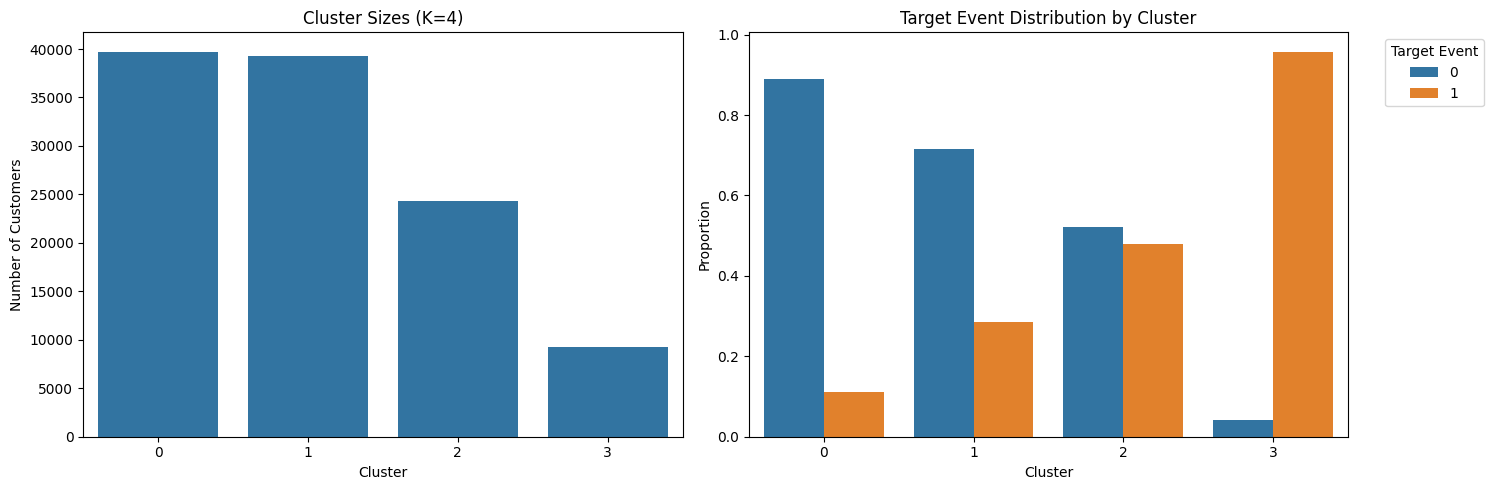

✓ Success: K=4, Features=9

--- Grid Search Experiment 142/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Manual K override: 5
Threshold (0.3, -0.3): 9 features selected
Using manual K = 5
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 38246 customers (33.96%)
  Cluster 1: 22027 customers (19.56%)
  Cluster 2: 10534 customers (9.35%)
  Cluster 3: 5287 customers (4.69%)
  Cluster 4: 36516 customers (32.43%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0        -9.10              0.44          0.70        42.71
1        -6.45              0.37          0.65        79.41
2         0.86              0.37          0.52        82.47
3         3.63              0.34          0.44       125.75
4       -11.45       

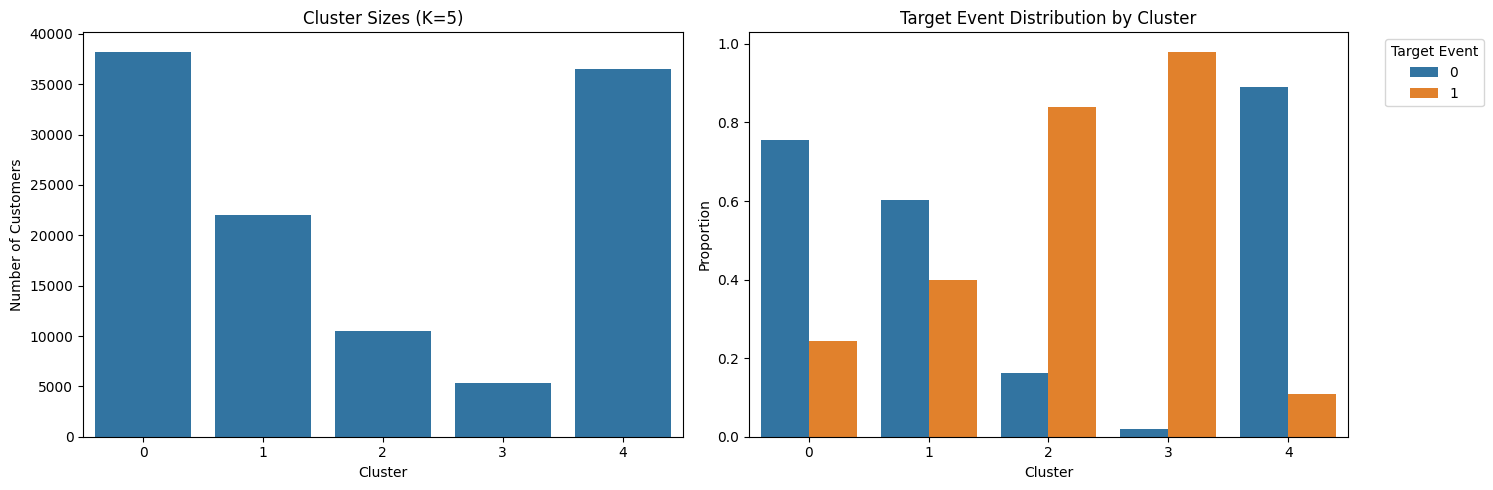

✓ Success: K=5, Features=9

--- Grid Search Experiment 143/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Manual K override: 6
Threshold (0.3, -0.3): 9 features selected
Using manual K = 6
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39437 customers (35.02%)
  Cluster 1: 19776 customers (17.56%)
  Cluster 2: 35430 customers (31.46%)
  Cluster 3: 5722 customers (5.08%)
  Cluster 4: 2004 customers (1.78%)
  Cluster 5: 10241 customers (9.09%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.25              0.68          0.99        18.09
1        -5.93              0.37          0.65        82.73
2        -9.11              0.42          0.68        45.50
3         3.51              0.33          0.4

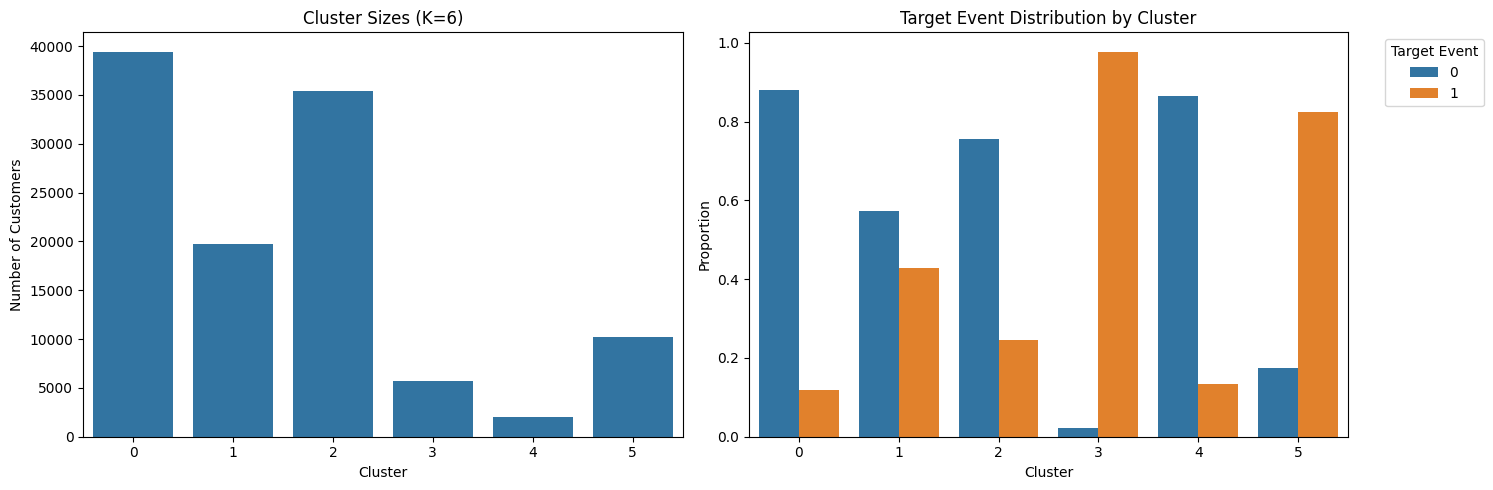

✓ Success: K=6, Features=9

--- Grid Search Experiment 144/144 ---

EXPERIMENT: threshold=(0.3, -0.3), n_init=auto, max_k=15
Manual K override: 7
Threshold (0.3, -0.3): 9 features selected
Using manual K = 7
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 39052 customers (34.68%)
  Cluster 1: 19753 customers (17.54%)
  Cluster 2: 11290 customers (10.03%)
  Cluster 3: 3674 customers (3.26%)
  Cluster 4: 1918 customers (1.70%)
  Cluster 5: 8383 customers (7.44%)
  Cluster 6: 28540 customers (25.34%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -11.33              0.68          1.00        18.00
1        -6.15              0.37          0.65        81.37
2        -2.89              0.44          0.60        54.20
3       

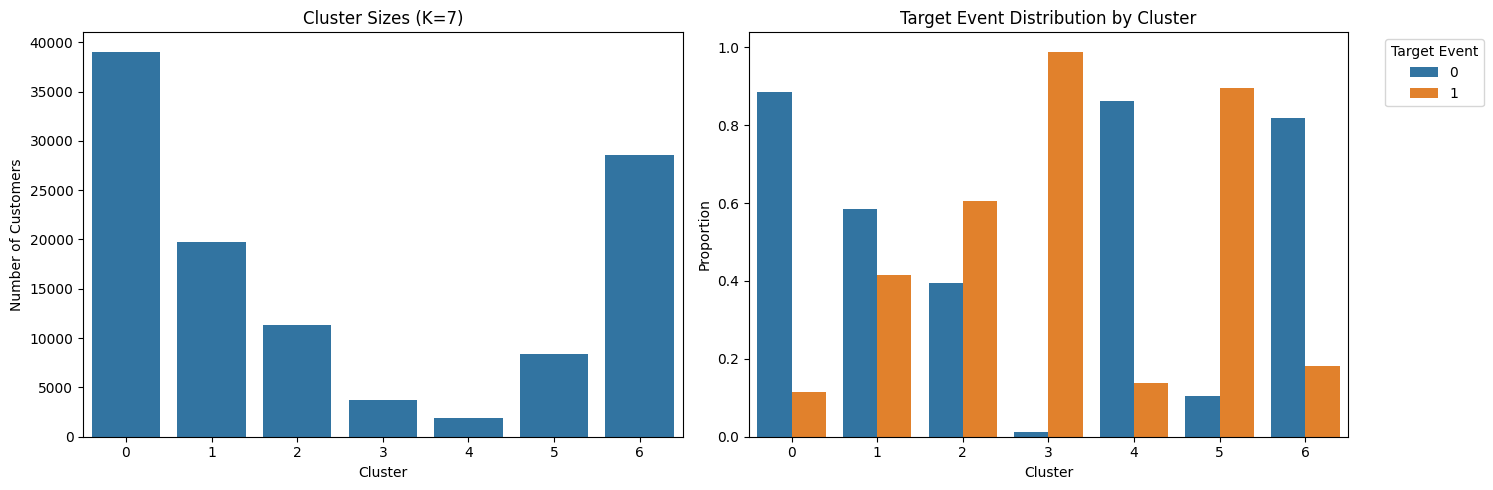

✓ Success: K=7, Features=9

Grid Search Complete!
Total time: 4.29 minutes
Successful experiments: 144
Failed experiments: 0


In [6]:
# Grid Search Implementation for Clustering Parameters
from itertools import product
import time

def run_grid_search_experiments():
    """
    Run comprehensive grid search across all parameter combinations
    """
    print("\n" + "="*80)
    print("RUNNING GRID SEARCH EXPERIMENTS")
    print("="*80)
    
    # Define parameter grid
    param_grid = {
        'threshold': EXPERIMENT_CONFIG['correlation_thresholds'],
        'n_init': EXPERIMENT_CONFIG['n_init_values'],
        'max_k': EXPERIMENT_CONFIG['max_k_values'],
        'manual_k': [None] + EXPERIMENT_CONFIG['manual_k_values']  # Include None for elbow method
    }
    
    # Generate all combinations
    param_combinations = list(product(
        param_grid['threshold'],
        param_grid['n_init'], 
        param_grid['max_k'],
        param_grid['manual_k']
    ))
    
    print(f"Total parameter combinations to test: {len(param_combinations)}")
    print(f"Estimated runtime: ~{len(param_combinations) * 0.5:.1f} minutes")
    
    # Track results
    grid_search_results = []
    failed_experiments = []
    
    start_time = time.time()
    
    for i, (threshold, n_init, max_k, manual_k) in enumerate(param_combinations):
        print(f"\n--- Grid Search Experiment {i+1}/{len(param_combinations)} ---")
        
        # Skip invalid combinations
        if manual_k and manual_k > max_k:
            print(f"Skipping: manual_k ({manual_k}) > max_k ({max_k})")
            continue
            
        try:
            result = run_clustering_experiment(
                df_original=df,
                df_features_filtered=df_features_filtered,
                target_variable=target_variable,
                threshold=threshold,
                n_init=n_init,
                max_k=max_k,
                manual_k=manual_k
            )
            
            if result:
                # Add grid search metadata
                result['grid_experiment_id'] = i + 1
                result['experiment_type'] = 'grid_search'
                grid_search_results.append(result)
                
                # Quick progress update
                print(f"✓ Success: K={result['optimal_k']}, Features={result['n_features']}")
            else:
                failed_experiments.append({
                    'experiment_id': i + 1,
                    'threshold': threshold,
                    'n_init': n_init, 
                    'max_k': max_k,
                    'manual_k': manual_k,
                    'reason': 'No features selected'
                })
                print(f"✗ Failed: No features selected")
                
        except Exception as e:
            failed_experiments.append({
                'experiment_id': i + 1,
                'threshold': threshold,
                'n_init': n_init,
                'max_k': max_k, 
                'manual_k': manual_k,
                'reason': str(e)
            })
            print(f"✗ Failed: {str(e)}")
    
    elapsed_time = time.time() - start_time
    print(f"\nGrid Search Complete!")
    print(f"Total time: {elapsed_time/60:.2f} minutes")
    print(f"Successful experiments: {len(grid_search_results)}")
    print(f"Failed experiments: {len(failed_experiments)}")
    
    if failed_experiments:
        print("\nFailed Experiments Summary:")
        for fail in failed_experiments[:5]:  # Show first 5 failures
            print(f"  Exp {fail['experiment_id']}: {fail['reason']}")
    
    return grid_search_results, failed_experiments

# Run grid search
print("Starting comprehensive grid search...")
grid_results, grid_failures = run_grid_search_experiments()


EXPERIMENT RESULTS SUMMARY
Experiment Summary:
    Experiment    Threshold N_Init  Max_K  Optimal_K  N_Features  N_Clusters  \
0            1  (0.1, -0.1)     10     10          2          48           2   
1            2  (0.2, -0.2)     10     10          2          18           2   
2            3  (0.3, -0.3)     10     10          2           9           2   
3            4  (0.1, -0.1)     10     10          2          48           2   
4            5  (0.1, -0.1)   auto     10          2          48           2   
5            6  (0.1, -0.1)     10      8          2          48           2   
6            7  (0.1, -0.1)     10     10          2          48           2   
7            8  (0.1, -0.1)     10     12          2          48           2   
8            9  (0.1, -0.1)     10     15          2          48           2   
9           10  (0.1, -0.1)     10     10          3          48           3   
10          11  (0.1, -0.1)     10     10          4          48        

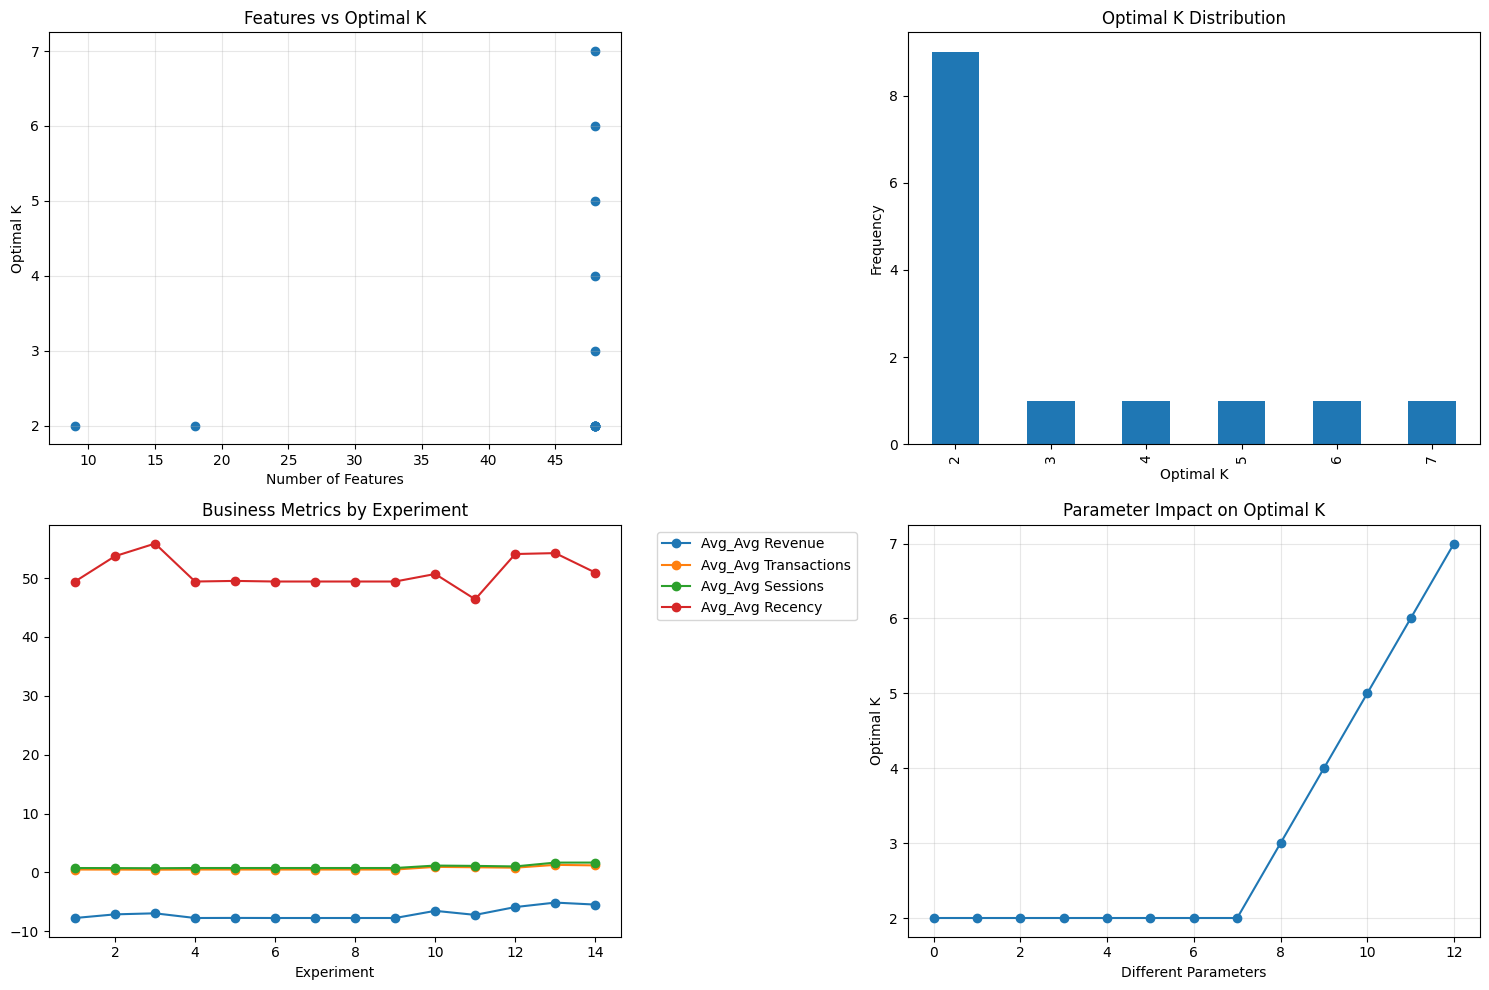


--- Finding Best Experiment (Criteria: balanced) ---
Best Experiment: #14
  Threshold: (0.1, -0.1)
  N_Init: 10
  Max_K: 10
  Optimal_K: 7
  N_Features: 48

--- Finding Best Experiment (Criteria: min_k) ---
Best Experiment: #1
  Threshold: (0.1, -0.1)
  N_Init: 10
  Max_K: 10
  Optimal_K: 2
  N_Features: 48

--- Finding Best Experiment (Criteria: max_features) ---
Best Experiment: #1
  Threshold: (0.1, -0.1)
  N_Init: 10
  Max_K: 10
  Optimal_K: 2
  N_Features: 48


In [7]:
# Results analysis and comparison
def analyze_experiment_results(results):
    """
    Analyze and compare results from multiple experiments
    """
    print("\n" + "="*80)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*80)
    
    if not results:
        print("No experiment results to analyze.")
        return
    
    # Create summary dataframe
    summary_data = []
    for i, result in enumerate(results):
        summary_row = {
            'Experiment': i + 1,
            'Threshold': str(result['threshold']),
            'N_Init': result['n_init'],
            'Max_K': result['max_k'],
            'Optimal_K': result['optimal_k'],
            'N_Features': result['n_features'],
            'N_Clusters': len(result['cluster_sizes'])
        }
        
        # Add business metrics if available
        if not result['business_metrics'].empty:
            for metric in result['business_metrics'].columns:
                summary_row[f'Avg_{metric}'] = result['business_metrics'][metric].mean()
        
        summary_data.append(summary_row)
    
    summary_df = pd.DataFrame(summary_data)
    print("Experiment Summary:")
    print(summary_df.round(3))
    
    # Visualize key comparisons
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Number of features vs Optimal K
    axes[0, 0].scatter(summary_df['N_Features'], summary_df['Optimal_K'])
    axes[0, 0].set_xlabel('Number of Features')
    axes[0, 0].set_ylabel('Optimal K')
    axes[0, 0].set_title('Features vs Optimal K')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Optimal K distribution
    summary_df['Optimal_K'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Optimal K Distribution')
    axes[0, 1].set_xlabel('Optimal K')
    axes[0, 1].set_ylabel('Frequency')
    
    # Plot 3: Business metrics comparison (if available)
    metric_cols = [col for col in summary_df.columns if col.startswith('Avg_')]
    if metric_cols:
        metric_data = summary_df[['Experiment'] + metric_cols].set_index('Experiment')
        metric_data.plot(kind='line', ax=axes[1, 0], marker='o')
        axes[1, 0].set_title('Business Metrics by Experiment')
        axes[1, 0].set_xlabel('Experiment')
        axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 4: Parameter impact on K
    threshold_k_data = summary_df[summary_df['N_Init'] == 10]  # Filter for consistent n_init
    if len(threshold_k_data) > 1:
        axes[1, 1].plot(range(len(threshold_k_data)), threshold_k_data['Optimal_K'], 'o-')
        axes[1, 1].set_title('Parameter Impact on Optimal K')
        axes[1, 1].set_xlabel('Different Parameters')
        axes[1, 1].set_ylabel('Optimal K')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Best experiment selector
def find_best_experiment(results, criteria='balanced'):
    """
    Find the best experiment based on different criteria
    """
    if not results:
        return None
    
    print(f"\n--- Finding Best Experiment (Criteria: {criteria}) ---")
    
    best_result = None
    best_score = float('-inf') if criteria != 'min_k' else float('inf')
    
    for i, result in enumerate(results):
        if criteria == 'balanced':
            # Balanced approach: consider cluster count and feature count
            score = result['optimal_k'] * 0.3 + result['n_features'] * 0.1
            if score > best_score:
                best_score = score
                best_result = (i, result)
                
        elif criteria == 'min_k':
            # Minimize number of clusters for simplicity
            if result['optimal_k'] < best_score:
                best_score = result['optimal_k']
                best_result = (i, result)
                
        elif criteria == 'max_features':
            # Maximize feature usage
            if result['n_features'] > best_score:
                best_score = result['n_features']
                best_result = (i, result)
    
    if best_result:
        exp_idx, best_exp = best_result
        print(f"Best Experiment: #{exp_idx + 1}")
        print(f"  Threshold: {best_exp['threshold']}")
        print(f"  N_Init: {best_exp['n_init']}")
        print(f"  Max_K: {best_exp['max_k']}")
        print(f"  Optimal_K: {best_exp['optimal_k']}")
        print(f"  N_Features: {best_exp['n_features']}")
        
        return best_exp
    
    return None

# Analyze all experiment results
if 'experiment_results' in locals() and experiment_results:
    results_summary = analyze_experiment_results(experiment_results)
    
    # Find best experiments with different criteria
    best_balanced = find_best_experiment(experiment_results, 'balanced')
    best_simple = find_best_experiment(experiment_results, 'min_k')
    best_comprehensive = find_best_experiment(experiment_results, 'max_features')
else:
    print("No experiment results available. Run the experiments first.")

Example Custom Experiment:

--- Running Custom Experiment ---
Parameters: threshold=(0.05, -0.05), n_init=auto, max_k=8, manual_k=None

EXPERIMENT: threshold=(0.05, -0.05), n_init=auto, max_k=8
Threshold (0.05, -0.05): 122 features selected
Finding optimal clusters: n_init=auto, max_k=8
Threshold (0.05, -0.05): 122 features selected
Finding optimal clusters: n_init=auto, max_k=8


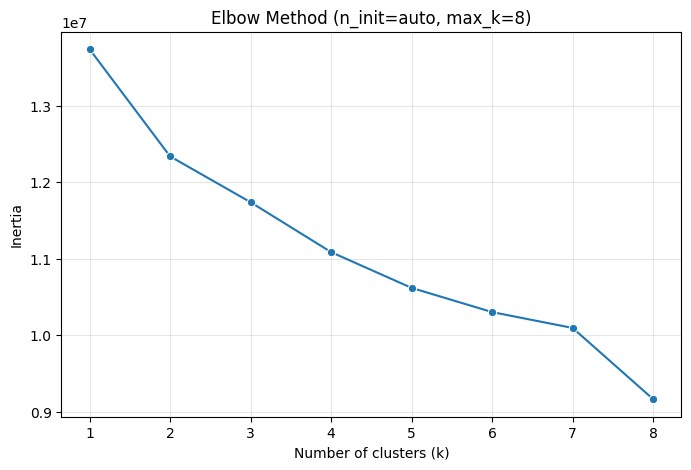

Rate of change analysis:
K=2, First diff=-1401140.49, Second diff=801350.95
K=3, First diff=-599789.54, Second diff=-52555.31
K=4, First diff=-652344.85, Second diff=184708.11
K=5, First diff=-467636.74, Second diff=151397.94
K=6, First diff=-316238.79, Second diff=108697.67
K=7, First diff=-207541.12, Second diff=-723996.24
Optimal K determined by elbow method: 2
=== ENHANCED CLUSTER ANALYSIS ===

Cluster Sizes:
  Cluster 0: 50859 customers (45.16%)
  Cluster 1: 61751 customers (54.84%)

Note: Using 'transaction_count_ratio' for Avg Transactions
Note: Using 'session_count_ratio' for Avg Sessions
Note: Using 'session_recency_mean' for Avg Recency
Business Metrics Analysis (4 metrics found):

Cluster Business Metrics:
   Avg Revenue  Avg Transactions  Avg Sessions  Avg Recency
0       -10.53              0.58          0.84        23.47
1        -5.57              0.43          0.70        69.63

Target Event Distribution by Cluster:
target_event      0      1
cluster                   


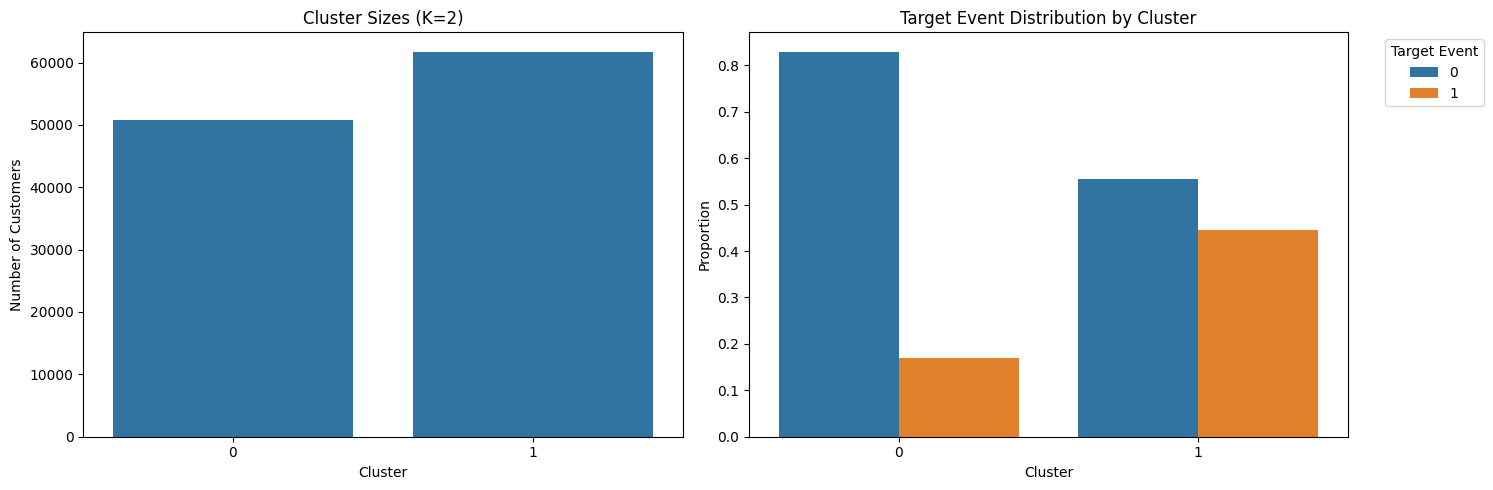


--- Quick Business Metrics Summary ---

Cluster 0 (50859 customers):
  Avg Revenue: -10.53
  Avg Transactions: 0.58
  Avg Sessions: 0.84
  Avg Recency: 23.47

Cluster 1 (61751 customers):
  Avg Revenue: -5.57
  Avg Transactions: 0.43
  Avg Sessions: 0.70
  Avg Recency: 69.63


In [8]:
# Custom experiment runner for quick testing
def run_custom_experiment(threshold=(0.1, -0.1), n_init='auto', max_k=10, manual_k=None):
    """
    Quick function to run a single experiment with custom parameters
    Usage: run_custom_experiment(threshold=(0.15, -0.15), n_init='auto', max_k=12, manual_k=5)
    n_init can be an integer (e.g., 10) or 'auto'
    """
    print(f"\n--- Running Custom Experiment ---")
    print(f"Parameters: threshold={threshold}, n_init={n_init}, max_k={max_k}, manual_k={manual_k}")
    
    result = run_clustering_experiment(
        df_original=df,
        df_features_filtered=df_features_filtered,
        target_variable=target_variable,
        threshold=threshold,
        n_init=n_init,
        max_k=max_k,
        manual_k=manual_k
    )
    
    if result and not result['business_metrics'].empty:
        print(f"\n--- Quick Business Metrics Summary ---")
        for cluster in sorted(result['cluster_sizes'].index):
            print(f"\nCluster {cluster} ({result['cluster_sizes'][cluster]} customers):")
            for metric in result['business_metrics'].columns:
                value = result['business_metrics'].loc[cluster, metric]
                print(f"  {metric}: {value:.2f}")
    
    return result

# Example: Run a quick custom experiment
print("Example Custom Experiment:")
custom_result = run_custom_experiment(
    threshold=(0.05, -0.05),  # More lenient threshold 
    max_k=8,
    manual_k=None  # Let elbow method decide
)